# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


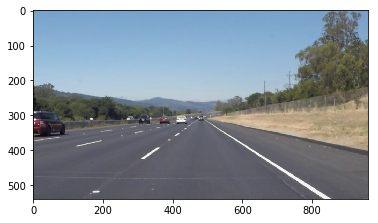

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    print(lines)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return line_img,lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [37]:
def process(image):
    work_img = image.copy()
    work_img = grayscale(work_img)
    imshape = image.shape
    

    work_img = gaussian_blur(work_img,3)
    work_img = canny(work_img, 50, 150)
#     plt.imshow(work_img) 
    vertices = np.array([[(imshape[1]/2+25,310),(imshape[1]/2-25,310), (0+100,imshape[0]),(imshape[1]-20,imshape[0])]], dtype=np.int32)
    work_img= region_of_interest(work_img, vertices)
#     plt.imshow(work_img)
# def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    line_img,lines = hough_lines(work_img, 1, np.pi/180, 60, 30, 100)
#     draw_lines(image, lines, [255, 0, 0], 2)
    
#     final=weighted_img(lines, image, α=0.8, β=1., γ=0.)
    
#     print(lines)
    pos_slope = 0
    neg_slope = 0
    p_count = 0
    n_count = 0
    px=py=nx=ny = imshape[0]
    px_next=nx_next=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            y_next = imshape[0]
            print(slope)
            if slope > 0:
                pos_slope += slope
                p_count+=1
                pc_next = y2 - slope*x2
                px_next += (y_next - pc_next)/slope
                if y1 < py:
                    px=x1
                    py=y1
                if y2 < py:
                    px=x2
                    py=y2
            elif slope < 0:
                neg_slope +=slope
                n_count +=1
                nc_next = y2 - slope*x2
                nx_next += (y_next - nc_next)/slope
                if y1 < ny:
                    nx=x1
                    ny=y1
                if y2 < ny:
                    nx=x2
                    ny=y2
#     print(px,py,nx,ny)
    if p_count > 0 :    
#         print("here not")
        pos_slope/=p_count
        px_next/= p_count
#         px /= p_count
#         py /= p_count
        draw_lines(line_img, np.array([[[px,py,px_next,y_next]]],dtype=np.float32),thickness = 10)  
#     print(n_count)
    if n_count >0:
#         print("here")
        neg_slope/= n_count
        nx_next /= n_count
#         nx /= n_count
#         ny /= n_count
        draw_lines(line_img, np.array([[[nx,ny,nx_next,y_next]]],dtype=np.float32),thickness = 10)
    
    return line_img

[[[483 311 877 538]]

 [[490 313 898 539]]

 [[488 310 898 538]]

 [[293 462 440 339]]

 [[294 449 481 313]]

 [[313 434 461 322]]]
0.5761421319796954
0.553921568627451
0.5560975609756098
-0.8367346938775511
-0.7272727272727273
-0.7567567567567568
[[[488.     310.     893.9577 540.    ]]]
[[[481.      313.      180.52802 540.     ]]]


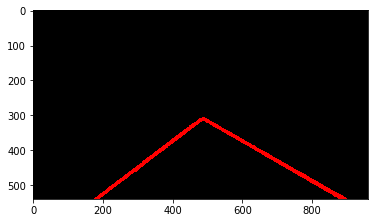

In [38]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
for img in os.listdir("test_images/"):
    image = mpimg.imread('test_images/'+img)
    line_img  = process(image)
    plt.imshow(line_img)
    
    break

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [39]:
# Import everything needed to edit/save/watch video clips
! pip install imageio_ffmpeg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    line_img = process(image)
    result=weighted_img(line_img, image, α=0.8, β=1., γ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [41]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[[490 310 870 538]]

 [[508 321 870 539]]

 [[487 310 688 436]]

 [[187 513 466 310]]

 [[201 515 474 310]]

 [[695 442 848 538]]

 [[487 311 742 471]]

 [[187 514 468 310]]

 [[749 477 848 539]]]
0.6
0.6022099447513812
0.6268656716417911
-0.7275985663082437
-0.7509157509157509
0.6274509803921569
0.6274509803921569
-0.7259786476868327
0.6262626262626263
[[[490.     310.     858.6086 540.    ]]]
[[[466.      310.      156.26173 540.     ]]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:06, 32.46it/s]

[[[490 310 870 538]]

 [[508 321 870 539]]

 [[487 310 688 436]]

 [[187 513 466 310]]

 [[201 515 474 310]]

 [[695 442 848 538]]

 [[487 311 742 471]]

 [[187 514 468 310]]

 [[749 477 848 539]]]
0.6
0.6022099447513812
0.6268656716417911
-0.7275985663082437
-0.7509157509157509
0.6274509803921569
0.6274509803921569
-0.7259786476868327
0.6262626262626263
[[[490.     310.     858.6086 540.    ]]]
[[[466.      310.      156.26173 540.     ]]]
[[[498 315 868 538]]

 [[492 310 822 524]]

 [[491 310 714 444]]

 [[170 538 464 317]]

 [[151 538 277 447]]

 [[736 459 868 539]]

 [[494 312 759 484]]

 [[694 440 846 538]]

 [[151 539 466 310]]

 [[170 539 469 314]]

 [[487 310 579 369]]

 [[490 310 748 465]]]
0.6027027027027027
0.6484848484848484
0.600896860986547
-0.7517006802721088
-0.7222222222222222
0.6060606060606061
0.6490566037735849
0.6447368421052632
-0.726984126984127
-0.7525083612040134
0.6413043478260869
0.6007751937984496
[[[492.     310.     859.2833 540.    ]]]
[[[466.      310.  

  5%|▌         | 12/222 [00:00<00:06, 32.88it/s]

[[[486 310 851 538]]

 [[516 329 850 538]]

 [[491 310 873 539]]

 [[326 411 470 310]]

 [[229 488 474 310]]

 [[490 310 793 492]]]
0.6246575342465753
0.625748502994012
0.599476439790576
-0.7013888888888888
-0.726530612244898
0.6006600660066007
[[[486.     310.     863.7445 540.    ]]]
[[[470.      310.      149.75308 540.     ]]]
[[[490 310 871 539]]

 [[514 328 849 538]]

 [[492 312 869 538]]

 [[602 384 848 538]]

 [[487 310 705 447]]

 [[316 425 472 312]]

 [[310 422 470 310]]

 [[309 422 469 310]]]
0.6010498687664042
0.6268656716417911
0.5994694960212201
0.6260162601626016
0.6284403669724771
-0.7243589743589743
-0.7
-0.7
[[[490.     310.     860.2742 540.    ]]]
[[[470.      310.      146.36536 540.     ]]]
[[[486 311 866 539]]

 [[491 312 863 536]]

 [[600 385 844 538]]

 [[482 311 767 489]]

 [[483 310 610 390]]

 [[297 441 478 310]]

 [[289 439 474 310]]]
0.6
0.6021505376344086
0.6270491803278688
0.624561403508772
0.6299212598425197
-0.7237569060773481
-0.6972972972972973
[[[48

  9%|▊         | 19/222 [00:00<00:06, 32.39it/s]

[[[502 317 857 539]]

 [[487 310 648 415]]

 [[141 538 467 310]]

 [[650 418 835 538]]

 [[186 519 473 310]]

 [[488 312 699 449]]

 [[492 310 857 538]]

 [[142 539 468 310]]

 [[492 312 811 511]]

 [[161 538 474 310]]]
0.6253521126760564
0.6521739130434783
-0.6993865030674846
0.6486486486486487
-0.7282229965156795
0.6492890995260664
0.6246575342465753
-0.7024539877300614
0.6238244514106583
-0.7284345047923323
[[[487.      310.      848.86523 540.     ]]]
[[[467.      310.      148.53346 540.     ]]]
[[[493 311 859 539]]

 [[495 310 787 507]]

 [[498 312 859 538]]

 [[331 412 470 311]]

 [[321 412 466 310]]

 [[502 317 687 441]]

 [[138 539 208 490]]

 [[157 538 221 491]]

 [[791 508 837 539]]]
0.6229508196721312
0.6746575342465754
0.6260387811634349
-0.7266187050359713
-0.7034482758620689
0.6702702702702703
-0.7
-0.734375
0.6739130434782609
[[[495.     310.     846.3798 540.    ]]]
[[[466.     310.     146.1822 540.    ]]]
[[[497 311 860 538]]

 [[491 310 658 419]]

 [[690 442 837 538

 10%|█         | 23/222 [00:00<00:06, 32.34it/s]

[[[496 315 854 539]]

 [[483 310 818 528]]

 [[483 311 833 538]]

 [[301 439 471 311]]

 [[486 311 644 414]]

 [[290 437 479 310]]]
0.6256983240223464
0.6507462686567164
0.6485714285714286
-0.7529411764705882
0.6518987341772152
-0.671957671957672
[[[483.      310.      841.35095 540.     ]]]
[[[479.      310.      151.78795 540.     ]]]
[[[494 313 854 538]]

 [[483 310 823 531]]

 [[662 427 833 539]]

 [[518 329 854 539]]

 [[264 456 471 311]]

 [[275 457 478 310]]

 [[486 311 651 418]]]
0.625
0.65
0.6549707602339181
0.625
-0.7004830917874396
-0.7241379310344828
0.6484848484848484
[[[483.      310.      844.66077 540.     ]]]
[[[478.      310.      152.23186 540.     ]]]
[[[502 318 854 538]]

 [[485 310 668 429]]

 [[645 415 833 538]]

 [[244 479 477 310]]

 [[495 313 853 537]]

 [[232 476 478 310]]

 [[694 439 854 539]]

 [[697 450 832 538]]]
0.625
0.6502732240437158
0.6542553191489362
-0.7253218884120172
0.6256983240223464
-0.6747967479674797
0.625
0.6518518518518519
[[[485.     310.

 12%|█▏        | 27/222 [00:00<00:05, 32.55it/s]

[[[493 311 852 536]]

 [[484 310 778 501]]

 [[496 315 855 539]]

 [[483 310 829 535]]

 [[161 527 471 310]]

 [[164 539 479 310]]

 [[486 310 698 448]]

 [[166 536 477 310]]

 [[147 536 247 466]]]
0.6267409470752089
0.6496598639455783
0.6239554317548747
0.6502890173410405
-0.7
-0.726984126984127
0.6509433962264151
-0.7266881028938906
-0.7
[[[484.     310.     845.8077 540.    ]]]
[[[471.      310.      151.70857 540.     ]]]
[[[490 310 856 538]]

 [[490 311 855 539]]

 [[484 310 833 537]]

 [[147 536 210 492]]

 [[486 310 640 410]]

 [[164 539 226 493]]

 [[324 415 464 314]]

 [[331 416 478 310]]]
0.6229508196721312
0.6246575342465753
0.6504297994269341
-0.6984126984126984
0.6493506493506493
-0.7419354838709677
-0.7214285714285714
-0.7210884353741497
[[[490.      310.      848.40594 540.     ]]]
[[[478.      310.      153.42383 540.     ]]]


 14%|█▍        | 31/222 [00:00<00:05, 32.64it/s]

[[[484 310 790 509]]

 [[490 311 855 539]]

 [[491 310 856 538]]

 [[483 310 834 538]]

 [[487 310 530 338]]

 [[308 428 469 311]]

 [[314 428 477 310]]]
0.6503267973856209
0.6246575342465753
0.6246575342465753
0.6495726495726496
0.6511627906976745
-0.7267080745341615
-0.7239263803680982
[[[484.      310.      846.15283 540.     ]]]
[[[477.      310.      156.58424 540.     ]]]
[[[493 311 857 539]]

 [[503 321 805 518]]

 [[488 310 742 468]]

 [[699 450 835 539]]

 [[280 442 474 311]]

 [[360 395 468 310]]]
0.6263736263736264
0.652317880794702
0.6220472440944882
0.6544117647058824
-0.6752577319587629
-0.7870370370370371
[[[488.      310.      847.89935 540.     ]]]
[[[468.      310.      155.31747 540.     ]]]
[[[506 319 857 539]]

 [[489 312 760 488]]

 [[489 313 836 538]]

 [[253 462 467 312]]

 [[488 310 630 398]]

 [[652 410 858 538]]

 [[269 459 475 310]]]
0.6267806267806267
0.6494464944649446
0.6484149855907781
-0.7009345794392523
0.6197183098591549
0.6213592233009708
-0.72330097

 16%|█▌        | 35/222 [00:01<00:05, 32.81it/s]

[[[483 310 834 538]]

 [[487 310 815 514]]

 [[484 310 815 525]]

 [[714 450 856 538]]

 [[267 453 471 310]]

 [[268 454 459 320]]

 [[278 455 478 310]]

 [[486 310 552 353]]

 [[492 310 640 406]]]
0.6495726495726496
0.6219512195121951
0.649546827794562
0.6197183098591549
-0.7009803921568627
-0.7015706806282722
-0.725
0.6515151515151515
0.6486486486486487
[[[483.      310.      846.13495 540.     ]]]
[[[471.      310.      149.68822 540.     ]]]


 18%|█▊        | 39/222 [00:01<00:05, 32.75it/s]

[[[488 311 848 535]]

 [[483 310 832 537]]

 [[483 311 833 538]]

 [[240 473 467 314]]

 [[247 478 479 310]]

 [[709 448 855 539]]

 [[485 310 559 358]]

 [[235 476 472 310]]

 [[244 478 476 310]]

 [[490 310 546 345]]]
0.6222222222222222
0.6504297994269341
0.6485714285714286
-0.7004405286343612
-0.7241379310344828
0.6232876712328768
0.6486486486486487
-0.70042194092827
-0.7241379310344828
0.625
[[[483.      310.      847.15326 540.     ]]]
[[[479.      310.      151.93358 540.     ]]]
[[[486 310 830 524]]

 [[592 382 833 539]]

 [[192 506 472 310]]

 [[483 310 834 538]]

 [[720 455 855 539]]

 [[206 509 471 310]]

 [[209 508 467 314]]

 [[485 310 758 480]]

 [[192 507 462 318]]

 [[500 320 590 379]]]
0.622093023255814
0.6514522821576764
-0.7
0.6495726495726496
0.6222222222222222
-0.7509433962264151
-0.751937984496124
0.6227106227106227
-0.7
0.6555555555555556
[[[486.     310.     845.6478 540.    ]]]
[[[472.      310.      154.86191 540.     ]]]
[[[488 311 854 539]]

 [[481 310 833 53

 19%|█▉        | 43/222 [00:01<00:07, 23.18it/s]

[[[493 311 799 517]]

 [[496 310 739 467]]

 [[490 310 731 472]]

 [[748 482 833 539]]

 [[490 311 855 539]]

 [[221 483 467 310]]

 [[242 481 460 317]]]
0.673202614379085
0.6460905349794238
0.6721991701244814
0.6705882352941176
0.6246575342465753
-0.7032520325203252
-0.7522935779816514
[[[496.      310.      841.68097 540.     ]]]
[[[467.      310.      151.76057 540.     ]]]
[[[490 311 854 538]]

 [[704 453 832 539]]

 [[490 310 750 485]]

 [[494 312 824 534]]

 [[496 310 740 468]]

 [[319 414 466 311]]

 [[324 420 468 311]]

 [[494 310 683 432]]

 [[314 418 474 310]]]
0.6236263736263736
0.671875
0.6730769230769231
0.6727272727272727
0.6475409836065574
-0.7006802721088435
-0.7569444444444444
0.6455026455026455
-0.675
[[[490.    310.    842.805 540.   ]]]
[[[474.     310.     145.9673 540.    ]]]
[[[524 332 816 528]]

 [[491 311 855 538]]

 [[502 318 755 488]]

 [[630 398 855 539]]

 [[505 318 648 408]]

 [[302 434 466 311]]

 [[295 431 474 310]]

 [[733 472 833 539]]

 [[305 434 457 

 22%|██▏       | 49/222 [00:01<00:10, 17.26it/s]

[[[492 311 855 538]]

 [[526 333 828 536]]

 [[501 318 548 348]]

 [[507 319 647 407]]

 [[640 404 854 538]]

 [[282 450 467 311]]

 [[270 448 465 311]]

 [[494 310 588 369]]

 [[496 314 730 471]]]
0.6253443526170799
0.6721854304635762
0.6382978723404256
0.6285714285714286
0.6261682242990654
-0.7513513513513513
-0.7025641025641025
0.6276595744680851
0.6709401709401709
[[[494.     310.     850.0022 540.    ]]]
[[[467.      311.      150.63347 540.     ]]]
[[[489 310 854 538]]

 [[493 310 832 539]]

 [[493 312 786 509]]

 [[240 469 464 312]]

 [[252 472 466 311]]

 [[510 321 648 408]]]
0.6246575342465753
0.6755162241887905
0.6723549488054608
-0.7008928571428571
-0.7523364485981309
0.6304347826086957
[[[489.    310.    845.042 540.   ]]]
[[[466.      311.      150.15778 540.     ]]]
[[[527 335 819 531]]

 [[619 391 854 538]]

 [[198 499 468 310]]

 [[494 313 696 439]]

 [[675 427 853 539]]

 [[209 502 313 427]]

 [[493 310 566 356]]]
0.6712328767123288
0.625531914893617
-0.7
0.62376237623

 23%|██▎       | 52/222 [00:02<00:10, 15.66it/s]

[[[518 329 820 532]]

 [[630 398 853 538]]

 [[140 539 463 313]]

 [[494 313 707 446]]

 [[686 434 853 539]]

 [[161 538 464 310]]

 [[497 313 635 400]]

 [[161 539 446 325]]

 [[551 350 831 539]]]
0.6721854304635762
0.6278026905829597
-0.6996904024767802
0.6244131455399061
0.6287425149700598
-0.7524752475247525
0.6304347826086957
-0.7508771929824561
0.675
[[[494.     313.     848.2949 540.    ]]]
[[[464.      310.      152.19371 540.     ]]]
[[[500 317 796 516]]

 [[492 312 852 537]]

 [[139 539 448 323]]

 [[508 321 831 539]]

 [[159 538 267 460]]

 [[727 460 853 539]]

 [[492 310 648 408]]

 [[658 416 853 538]]]
0.6722972972972973
0.625
-0.6990291262135923
0.6749226006191951
-0.7222222222222222
0.626984126984127
0.6282051282051282
0.6256410256410256
[[[492.      310.      848.31573 540.     ]]]
[[[448.     323.     146.9001 540.    ]]]
[[[507 320 831 539]]

 [[506 319 708 446]]

 [[662 418 853 538]]

 [[489 310 726 469]]

 [[323 412 472 312]]

 [[137 538 218 482]]

 [[157 538 332 41

 24%|██▍       | 54/222 [00:02<00:11, 15.11it/s]

[[[492 310 831 538]]

 [[493 313 852 537]]

 [[504 320 799 518]]

 [[526 332 741 467]]

 [[486 310 561 357]]

 [[306 423 473 310]]

 [[493 311 683 430]]

 [[302 422 468 310]]

 [[696 440 853 538]]]
0.672566371681416
0.6239554317548747
0.6711864406779661
0.627906976744186
0.6266666666666667
-0.6766467065868264
0.6263157894736842
-0.6746987951807228
0.6242038216560509
[[[492.     310.     849.6678 540.    ]]]
[[[473.      310.      130.09782 540.     ]]]
[[[509 322 823 534]]

 [[493 311 700 441]]

 [[488 310 853 538]]

 [[707 447 852 538]]

 [[281 436 468 310]]

 [[499 317 712 460]]

 [[291 437 467 314]]

 [[492 310 831 539]]]
0.6751592356687898
0.6280193236714976
0.6246575342465753
0.6275862068965518
-0.6737967914438503
0.6713615023474179
-0.6988636363636364
0.6755162241887905
[[[488.     310.     844.0925 540.    ]]]
[[[468.      310.      135.13434 540.     ]]]
[[[491 310 831 539]]

 [[488 310 853 538]]

 [[635 402 853 539]]

 [[501 316 721 454]]

 [[487 310 591 378]]

 [[253 455 468 

 25%|██▌       | 56/222 [00:02<00:11, 14.27it/s]

[[[491 311 799 504]]

 [[513 326 852 538]]

 [[499 318 659 425]]

 [[509 323 751 486]]

 [[685 441 830 538]]

 [[231 480 474 310]]

 [[218 480 469 311]]]
0.6266233766233766
0.6253687315634219
0.66875
0.6735537190082644
0.6689655172413793
-0.6995884773662552
-0.6733067729083665
[[[491.     311.     841.3546 540.    ]]]
[[[474.      310.      137.06143 540.     ]]]
[[[493 313 852 538]]

 [[483 311 749 484]]

 [[633 409 818 530]]

 [[488 312 851 538]]

 [[307 420 469 311]]

 [[313 423 474 311]]

 [[487 312 616 396]]

 [[306 421 470 311]]]
0.6267409470752089
0.650375939849624
0.654054054054054
0.6225895316804407
-0.6728395061728395
-0.6956521739130435
0.6511627906976745
-0.6707317073170732
[[[483.     311.     842.9879 540.    ]]]
[[[469.      311.      134.01523 540.     ]]]
[[[488 312 851 538]]

 [[492 313 790 514]]

 [[488 313 575 371]]

 [[293 438 476 310]]

 [[286 436 473 310]]

 [[644 410 850 539]]

 [[678 440 829 539]]

 [[629 407 820 532]]]
0.6225895316804407
0.674496644295302
0.66

 27%|██▋       | 60/222 [00:02<00:12, 13.34it/s]

[[[486 310 815 531]]

 [[488 312 850 538]]

 [[647 412 849 539]]

 [[492 313 637 404]]

 [[268 446 477 310]]

 [[272 454 467 312]]

 [[488 313 676 439]]

 [[260 453 478 311]]

 [[743 482 827 538]]]
0.6717325227963525
0.6243093922651933
0.6287128712871287
0.6275862068965518
-0.6507177033492823
-0.7282051282051282
0.6702127659574468
-0.6513761467889908
0.6666666666666666
[[[486.     310.     840.4323 540.    ]]]
[[[477.      310.      134.62738 540.     ]]]
[[[494 316 826 539]]

 [[683 435 848 538]]

 [[487 312 732 465]]

 [[238 476 476 310]]

 [[226 475 466 313]]

 [[510 325 676 429]]

 [[489 311 621 400]]]
0.6716867469879518
0.6242424242424243
0.6244897959183674
-0.6974789915966386
-0.675
0.6265060240963856
0.6742424242424242
[[[489.     311.     842.5209 540.    ]]]
[[[476.      310.      137.97234 540.     ]]]
[[[495 317 824 538]]

 [[606 385 821 524]]

 [[193 508 476 310]]

 [[181 505 468 312]]

 [[491 312 602 384]]

 [[181 507 473 310]]

 [[486 312 819 536]]

 [[197 507 269 456]]]


 29%|██▉       | 64/222 [00:03<00:11, 13.66it/s]

[[[490 314 822 538]]

 [[151 538 281 447]]

 [[612 389 844 539]]

 [[132 538 466 313]]

 [[555 357 824 538]]

 [[491 312 685 437]]

 [[154 535 474 311]]

 [[511 326 554 354]]

 [[131 538 380 370]]

 [[132 539 469 312]]

 [[689 438 844 538]]]
0.6746987951807228
-0.7
0.646551724137931
-0.6736526946107785
0.6728624535315985
0.6443298969072165
-0.7
0.6511627906976745
-0.6746987951807228
-0.6735905044510386
0.6451612903225806
[[[491.      312.      838.18036 540.     ]]]
[[[474.      311.      136.51645 540.     ]]]
[[[493 316 823 538]]

 [[495 314 792 506]]

 [[132 539 468 312]]

 [[484 311 823 539]]

 [[380 377 476 310]]

 [[629 400 844 539]]

 [[489 312 607 388]]

 [[161 532 467 310]]]
0.6727272727272727
0.6464646464646465
-0.6755952380952381
0.672566371681416
-0.6979166666666666
0.6465116279069767
0.6440677966101694
-0.7254901960784313
[[[484.     311.     836.7201 540.    ]]]
[[[476.      310.      142.31352 540.     ]]]
[[[486 312 822 538]]

 [[589 375 829 530]]

 [[491 313 632 404]]


 30%|██▉       | 66/222 [00:03<00:11, 13.32it/s]

[[[485 312 821 538]]

 [[632 403 842 539]]

 [[485 310 628 402]]

 [[502 322 816 534]]

 [[365 387 473 311]]

 [[299 424 470 313]]]
0.6726190476190477
0.6476190476190476
0.6433566433566433
0.6751592356687898
-0.7037037037037037
-0.6491228070175439
[[[485.     310.     833.7261 540.    ]]]
[[[473.      311.      133.93813 540.     ]]]
[[[483 311 821 539]]

 [[490 314 822 538]]

 [[665 424 842 538]]

 [[488 311 628 402]]

 [[489 311 682 436]]

 [[276 441 467 312]]

 [[699 445 843 538]]]
0.6745562130177515
0.6746987951807228
0.6440677966101694
0.65
0.6476683937823834
-0.675392670157068
0.6458333333333334
[[[483.      311.      836.92206 540.     ]]]
[[[467.      312.      129.41861 540.     ]]]
[[[484 310 822 538]]

 [[482 310 824 524]]

 [[490 313 824 538]]

 [[492 312 635 405]]

 [[492 311 739 471]]

 [[335 398 476 310]]

 [[263 455 454 322]]]
0.6745562130177515
0.6257309941520468
0.6736526946107785
0.6503496503496503
0.6477732793522267
-0.624113475177305
-0.6963350785340314
[[[484.    

 32%|███▏      | 70/222 [00:03<00:11, 13.58it/s]

[[[486 310 825 539]]

 [[491 311 707 451]]

 [[484 310 816 518]]

 [[482 310 540 347]]

 [[485 310 823 538]]

 [[230 478 468 311]]

 [[214 481 468 310]]

 [[695 443 847 538]]]
0.6755162241887905
0.6481481481481481
0.6265060240963856
0.6379310344827587
0.6745562130177515
-0.7016806722689075
-0.6732283464566929
0.625
[[[486.     310.     840.1026 540.    ]]]
[[[468.      310.      134.00165 540.     ]]]
[[[485 310 824 539]]

 [[491 311 771 492]]

 [[514 327 613 391]]

 [[483 310 768 502]]

 [[639 406 811 517]]

 [[306 417 470 311]]

 [[313 420 468 311]]

 [[492 312 711 454]]

 [[767 488 846 539]]]
0.6755162241887905
0.6464285714285715
0.6464646464646465
0.6736842105263158
0.6453488372093024
-0.6463414634146342
-0.7032258064516129
0.6484018264840182
0.6455696202531646
[[[485.     310.     839.4925 540.    ]]]
[[[470.      311.      129.02795 540.     ]]]
[[[484 310 823 538]]

 [[489 311 743 475]]

 [[489 310 809 517]]

 [[483 310 822 539]]

 [[298 432 473 310]]

 [[295 433 470 311]]

 [[2

 32%|███▏      | 72/222 [00:03<00:10, 13.85it/s]

[[[486 311 823 538]]

 [[490 310 825 527]]

 [[483 310 822 538]]

 [[488 310 723 462]]

 [[273 449 470 311]]

 [[741 472 844 538]]

 [[261 448 474 310]]

 [[261 447 446 326]]]
0.6735905044510386
0.6477611940298508
0.672566371681416
0.6468085106382979
-0.700507614213198
0.6407766990291263
-0.647887323943662
-0.654054054054054
[[[490.      310.      837.34503 540.     ]]]
[[[474.      310.      126.96804 540.     ]]]
[[[491 311 814 520]]

 [[484 310 822 538]]

 [[692 440 844 538]]

 [[229 468 473 310]]

 [[241 470 469 310]]

 [[489 310 660 421]]

 [[246 467 470 311]]]
0.6470588235294118
0.6745562130177515
0.6447368421052632
-0.6475409836065574
-0.7017543859649122
0.6491228070175439
-0.6964285714285714
[[[484.     310.     840.0751 540.    ]]]
[[[473.      310.      133.41321 540.     ]]]
[[[482 310 821 538]]

 [[639 407 843 539]]

 [[486 311 710 462]]

 [[489 310 788 504]]

 [[187 496 474 310]]

 [[202 498 469 311]]

 [[518 330 640 409]]

 [[189 494 470 311]]

 [[484 310 820 537]]]
0.672

 34%|███▍      | 76/222 [00:03<00:11, 13.24it/s]

[[[482 310 821 538]]

 [[491 312 730 467]]

 [[149 535 469 311]]

 [[132 532 473 310]]

 [[676 431 842 538]]

 [[143 538 468 311]]

 [[127 536 476 310]]

 [[486 313 818 537]]

 [[484 310 749 489]]

 [[630 402 842 539]]]
0.672566371681416
0.6485355648535565
-0.7
-0.6510263929618768
0.6445783132530121
-0.6984615384615385
-0.6475644699140402
0.6746987951807228
0.6754716981132075
0.6462264150943396
[[[482.     310.     833.6891 540.    ]]]
[[[473.      310.      130.63211 540.     ]]]
[[[482 310 820 538]]

 [[488 310 841 539]]

 [[493 315 690 442]]

 [[123 538 474 310]]

 [[143 538 468 311]]

 [[705 450 841 538]]

 [[595 387 820 539]]

 [[212 491 469 311]]

 [[131 532 473 310]]]
0.6745562130177515
0.6487252124645893
0.6446700507614214
-0.6495726495726496
-0.6984615384615385
0.6470588235294118
0.6755555555555556
-0.7003891050583657
-0.6491228070175439
[[[482.      310.      834.61865 540.     ]]]
[[[474.      310.      130.19304 540.     ]]]
[[[607 395 819 538]]

 [[488 310 841 539]]

 [[48

 35%|███▌      | 78/222 [00:04<00:10, 13.17it/s]

[[[493 314 840 539]]

 [[491 313 709 465]]

 [[723 473 817 538]]

 [[299 420 468 310]]

 [[118 538 156 514]]

 [[306 422 470 312]]

 [[486 313 819 538]]]
0.6484149855907781
0.6972477064220184
0.6914893617021277
-0.650887573964497
-0.631578947368421
-0.6707317073170732
0.6756756756756757
[[[491.      313.      824.99005 540.     ]]]
[[[468.      310.      119.84747 540.     ]]]
[[[487 311 839 539]]

 [[625 408 818 538]]

 [[486 313 706 462]]

 [[516 328 839 538]]

 [[485 311 609 395]]

 [[285 436 471 311]]

 [[277 434 468 310]]]
0.6477272727272727
0.6735751295336787
0.6772727272727272
0.6501547987616099
0.6774193548387096
-0.6720430107526881
-0.6492146596858639
[[[487.     311.     829.5609 540.    ]]]
[[[468.     310.     121.9869 540.    ]]]
[[[484 310 837 539]]

 [[487 311 759 501]]

 [[495 316 837 538]]

 [[677 443 812 537]]

 [[259 454 473 310]]

 [[252 451 467 311]]]
0.6487252124645893
0.6985294117647058
0.6491228070175439
0.6962962962962963
-0.6728971962616822
-0.6511627906976745

 37%|███▋      | 82/222 [00:04<00:10, 13.44it/s]

[[[487 311 834 537]]

 [[490 314 751 496]]

 [[484 310 835 538]]

 [[512 328 812 538]]

 [[319 406 468 310]]

 [[218 481 471 311]]]
0.6512968299711815
0.6973180076628352
0.6495726495726496
0.7
-0.6442953020134228
-0.6719367588932806
[[[484.     310.     826.4103 540.    ]]]
[[[468.       310.       120.607475 540.      ]]]
[[[484 310 742 490]]

 [[487 310 813 539]]

 [[487 311 831 535]]

 [[485 311 835 538]]

 [[302 417 473 310]]

 [[311 419 467 310]]]
0.6976744186046512
0.7024539877300614
0.6511627906976745
0.6485714285714286
-0.6257309941520468
-0.6987179487179487
[[[484.      310.      826.21313 540.     ]]]
[[[473.     310.     121.6278 540.    ]]]
[[[484 310 809 537]]

 [[487 311 811 538]]

 [[490 310 734 474]]

 [[661 424 806 521]]

 [[292 432 473 310]]

 [[283 430 468 310]]

 [[488 310 589 378]]]
0.6984615384615385
0.7006172839506173
0.6721311475409836
0.6689655172413793
-0.6740331491712708
-0.6486486486486487
0.6732673267326733
[[[484.     310.     824.6729 540.    ]]]
[[[473. 

 38%|███▊      | 84/222 [00:04<00:10, 13.05it/s]

[[[484 310 812 539]]

 [[487 311 712 458]]

 [[485 311 832 537]]

 [[267 448 471 311]]

 [[492 314 811 538]]

 [[257 447 468 310]]

 [[710 458 833 538]]

 [[494 315 635 407]]]
0.698170731707317
0.6533333333333333
0.6512968299711815
-0.6715686274509803
0.7021943573667712
-0.6492890995260664
0.6504065040650406
0.6524822695035462
[[[484.     310.     829.3848 540.    ]]]
[[[468.      310.      121.88686 540.     ]]]
[[[485 310 811 538]]

 [[484 310 744 479]]

 [[485 311 777 501]]

 [[226 467 468 310]]

 [[236 469 471 311]]

 [[488 311 810 537]]

 [[491 310 570 365]]

 [[693 447 833 538]]

 [[225 467 465 311]]]
0.6993865030674846
0.65
0.6506849315068494
-0.6487603305785123
-0.6723404255319149
0.7018633540372671
0.6962025316455697
0.65
-0.65
[[[485.      310.      826.72626 540.     ]]]
[[[468.      310.      118.85625 540.     ]]]
[[[484 310 811 539]]

 [[498 319 783 505]]

 [[182 496 468 311]]

 [[194 498 474 310]]

 [[658 424 833 538]]

 [[490 313 811 538]]

 [[496 313 592 380]]]
0.70030

 40%|███▉      | 88/222 [00:04<00:10, 13.25it/s]

[[[485 310 811 538]]

 [[137 537 474 310]]

 [[122 535 467 311]]

 [[492 311 785 508]]

 [[489 310 697 450]]

 [[484 310 811 539]]

 [[122 536 469 311]]

 [[692 445 832 539]]

 [[136 537 473 310]]]
0.6993865030674846
-0.6735905044510386
-0.6492753623188405
0.6723549488054608
0.6730769230769231
0.7003058103975535
-0.6484149855907781
0.6714285714285714
-0.6735905044510386
[[[485.    310.    824.617 540.   ]]]
[[[474.      310.      123.55568 540.     ]]]
[[[486 311 811 538]]

 [[484 310 748 482]]

 [[136 538 474 310]]

 [[116 538 466 311]]

 [[129 531 469 311]]

 [[136 539 254 459]]

 [[487 313 810 539]]

 [[481 310 828 535]]

 [[494 312 615 396]]]
0.6984615384615385
0.6515151515151515
-0.6745562130177515
-0.6485714285714286
-0.6470588235294118
-0.6779661016949152
0.6996904024767802
0.6484149855907781
0.6942148760330579
[[[484.     310.     824.0911 540.    ]]]
[[[474.      310.      123.89182 540.     ]]]
[[[484 310 810 538]]

 [[489 310 769 498]]

 [[314 411 467 312]]

 [[324 412 476 3

 41%|████      | 90/222 [00:05<00:09, 13.28it/s]

[[[483 310 809 538]]

 [[490 310 542 345]]

 [[490 311 768 498]]

 [[484 310 791 525]]

 [[295 423 467 312]]

 [[138 538 171 516]]

 [[489 311 676 437]]

 [[692 446 830 539]]

 [[492 314 552 356]]

 [[300 424 482 311]]]
0.6993865030674846
0.6730769230769231
0.6726618705035972
0.7003257328990228
-0.6453488372093024
-0.6666666666666666
0.6737967914438503
0.6739130434782609
0.7
-0.6208791208791209
[[[483.    310.    823.091 540.   ]]]
[[[482.      311.      120.62361 540.     ]]]
[[[483 310 809 538]]

 [[490 311 786 510]]

 [[715 461 830 538]]

 [[486 310 649 419]]

 [[274 437 469 311]]

 [[285 437 474 310]]

 [[695 448 830 539]]

 [[491 314 621 405]]]
0.6993865030674846
0.6722972972972973
0.6695652173913044
0.6687116564417178
-0.6461538461538462
-0.671957671957672
0.674074074074074
0.7
[[[483.     310.     825.1259 540.    ]]]
[[[474.      310.      123.15588 540.     ]]]
[[[482 310 808 538]]

 [[678 439 828 537]]

 [[483 311 689 445]]

 [[491 310 627 405]]

 [[247 456 473 310]]

 [[477 

 42%|████▏     | 94/222 [00:05<00:09, 13.59it/s]

[[[484 311 809 538]]

 [[488 310 793 515]]

 [[491 311 577 369]]

 [[487 310 741 481]]

 [[605 396 808 539]]

 [[320 408 469 312]]

 [[228 478 478 310]]

 [[541 345 829 539]]

 [[227 478 475 311]]

 [[771 499 829 538]]

 [[212 480 474 310]]

 [[485 310 670 440]]]
0.6984615384615385
0.6721311475409836
0.6744186046511628
0.6732283464566929
0.7044334975369458
-0.6442953020134228
-0.672
0.6736111111111112
-0.6733870967741935
0.6724137931034483
-0.648854961832061
0.7027027027027027
[[[488.      310.      823.17926 540.     ]]]
[[[478.      310.      126.33016 540.     ]]]
[[[487 310 804 523]]

 [[491 311 829 539]]

 [[592 386 808 538]]

 [[484 310 732 484]]

 [[689 455 808 539]]

 [[314 420 478 310]]

 [[305 419 474 310]]

 [[485 310 612 399]]

 [[306 418 469 312]]

 [[311 421 475 311]]

 [[492 310 559 356]]]
0.6719242902208202
0.6745562130177515
0.7037037037037037
0.7016129032258065
0.7058823529411765
-0.6707317073170732
-0.6449704142011834
0.7007874015748031
-0.6503067484662577
-0.6707317

 43%|████▎     | 96/222 [00:05<00:09, 13.58it/s]

[[[491 310 830 539]]

 [[497 315 695 458]]

 [[261 447 471 311]]

 [[269 449 476 310]]

 [[716 471 810 539]]

 [[690 453 797 530]]

 [[272 448 477 310]]

 [[499 313 690 446]]]
0.6755162241887905
0.7222222222222222
-0.6476190476190476
-0.6714975845410628
0.723404255319149
0.719626168224299
-0.6731707317073171
0.6963350785340314
[[[491.      310.      817.45795 540.     ]]]
[[[476.      310.      128.73747 540.     ]]]
[[[495 311 746 493]]

 [[502 314 704 455]]

 [[231 466 472 310]]

 [[242 468 475 311]]

 [[491 310 697 459]]

 [[502 317 831 539]]

 [[741 488 811 539]]

 [[232 465 469 311]]

 [[544 344 638 408]]]
0.7250996015936255
0.698019801980198
-0.6473029045643154
-0.6738197424892703
0.7233009708737864
0.6747720364741642
0.7285714285714285
-0.6497890295358649
0.6808510638297872
[[[491.      310.      820.38464 540.     ]]]
[[[472.     310.     122.8013 540.    ]]]
[[[496 313 832 539]]

 [[503 318 723 477]]

 [[190 493 472 310]]

 [[495 310 766 507]]

 [[201 495 474 311]]

 [[560 355

 45%|████▌     | 100/222 [00:05<00:08, 13.61it/s]

[[[495 310 783 519]]

 [[132 530 471 310]]

 [[527 333 831 538]]

 [[146 532 475 310]]

 [[495 312 545 346]]

 [[496 310 811 539]]

 [[658 422 831 539]]

 [[550 347 656 419]]

 [[503 317 682 447]]

 [[505 315 552 347]]

 [[147 532 474 312]]]
0.7256944444444444
-0.6489675516224189
0.6743421052631579
-0.6747720364741642
0.68
0.726984126984127
0.6763005780346821
0.6792452830188679
0.7262569832402235
0.6808510638297872
-0.672782874617737
[[[495.     310.     825.0892 540.    ]]]
[[[471.      310.      128.61472 540.     ]]]
[[[496 310 812 539]]

 [[555 350 806 520]]

 [[510 321 739 487]]

 [[117 539 470 310]]

 [[137 538 475 310]]

 [[576 365 832 538]]

 [[691 451 811 538]]

 [[505 315 636 404]]]
0.7246835443037974
0.6772908366533864
0.7248908296943232
-0.6487252124645893
-0.6745562130177515
0.67578125
0.725
0.6793893129770993
[[[496.     310.     824.3203 540.    ]]]
[[[470.     310.     124.7468 540.    ]]]
[[[496 310 797 528]]

 [[560 353 832 537]]

 [[498 310 813 539]]

 [[327 409 471 

 46%|████▌     | 102/222 [00:05<00:08, 13.82it/s]

[[[496 310 812 539]]

 [[495 310 831 537]]

 [[514 324 739 487]]

 [[497 310 699 447]]

 [[492 310 545 345]]

 [[312 420 476 310]]

 [[507 319 832 538]]

 [[700 457 812 538]]

 [[136 538 179 509]]

 [[303 419 471 310]]]
0.7246835443037974
0.6755952380952381
0.7244444444444444
0.6782178217821783
0.660377358490566
-0.6707317073170732
0.6738461538461539
0.7232142857142857
-0.6744186046511628
-0.6488095238095238
[[[496.     310.     826.7319 540.    ]]]
[[[476.      310.      127.54333 540.     ]]]
[[[493 310 832 539]]

 [[632 409 812 539]]

 [[494 310 832 538]]

 [[526 333 768 508]]

 [[492 310 614 398]]

 [[709 464 811 538]]

 [[350 390 479 310]]]
0.6755162241887905
0.7222222222222222
0.6745562130177515
0.7231404958677686
0.7213114754098361
0.7254901960784313
-0.6201550387596899
[[[493.     310.     819.7836 540.    ]]]
[[[479.    310.    108.125 540.   ]]]
[[[494 310 832 538]]

 [[605 392 811 537]]

 [[489 310 716 469]]

 [[493 311 832 539]]

 [[339 399 482 310]]

 [[505 320 592 381]]]


 48%|████▊     | 106/222 [00:06<00:08, 12.97it/s]

[[[495 311 833 539]]

 [[489 311 813 538]]

 [[613 398 812 538]]

 [[490 310 611 395]]

 [[506 318 833 538]]

 [[326 409 483 311]]

 [[496 313 710 457]]

 [[340 407 470 313]]]
0.6745562130177515
0.7006172839506173
0.7035175879396985
0.7024793388429752
0.672782874617737
-0.6242038216560509
0.6728971962616822
-0.7230769230769231
[[[490.     310.     825.3186 540.    ]]]
[[[483.      311.      136.09824 540.     ]]]
[[[502 315 835 539]]

 [[497 312 798 515]]

 [[610 395 815 539]]

 [[489 310 815 538]]

 [[493 311 622 402]]

 [[311 418 477 310]]

 [[311 419 479 310]]

 [[328 415 471 312]]]
0.6726726726726727
0.6744186046511628
0.7024390243902439
0.6993865030674846
0.7054263565891473
-0.6506024096385542
-0.6488095238095238
-0.7202797202797203
[[[489.      310.      824.69305 540.     ]]]
[[[477.      310.      134.14746 540.     ]]]
[[[494 310 771 496]]

 [[712 455 836 538]]

 [[492 312 816 538]]

 [[493 311 812 535]]

 [[507 317 836 539]]

 [[292 431 471 311]]

 [[493 310 601 386]]

 [[302

 49%|████▊     | 108/222 [00:06<00:08, 13.16it/s]

[[[496 310 795 511]]

 [[495 313 818 539]]

 [[511 319 838 539]]

 [[632 409 816 538]]

 [[268 445 477 310]]

 [[493 310 630 406]]

 [[280 447 474 311]]

 [[269 447 471 311]]]
0.6722408026755853
0.6996904024767802
0.672782874617737
0.7010869565217391
-0.645933014354067
0.7007299270072993
-0.7010309278350515
-0.6732673267326733
[[[496.      310.      827.42737 540.     ]]]
[[[477.      310.      133.04393 540.     ]]]
[[[506 316 838 539]]

 [[492 311 818 539]]

 [[493 310 818 538]]

 [[238 465 477 310]]

 [[249 468 474 311]]

 [[238 466 479 310]]

 [[489 310 827 530]]]
0.6716867469879518
0.6993865030674846
0.7015384615384616
-0.6485355648535565
-0.6977777777777778
-0.6473029045643154
0.650887573964497
[[[493.      310.      830.53326 540.     ]]]
[[[477.      310.      130.61653 540.     ]]]
[[[497 310 782 502]]

 [[493 311 818 538]]

 [[198 493 479 310]]

 [[532 333 834 536]]

 [[210 496 474 311]]

 [[223 488 478 310]]

 [[493 310 819 538]]

 [[497 312 607 389]]]
0.6736842105263158
0.6

 50%|█████     | 112/222 [00:06<00:08, 13.37it/s]

[[[510 319 821 528]]

 [[493 311 818 539]]

 [[142 530 480 310]]

 [[547 343 838 539]]

 [[160 532 477 310]]

 [[493 310 818 538]]

 [[156 534 476 310]]

 [[496 310 750 481]]

 [[383 369 473 311]]]
0.6720257234726688
0.7015384615384616
-0.650887573964497
0.6735395189003437
-0.7003154574132492
0.7015384615384616
-0.7
0.6732283464566929
-0.6444444444444445
[[[493.    310.    831.251 540.   ]]]
[[[480.      310.      135.07417 540.     ]]]
[[[497 310 837 539]]

 [[493 311 817 538]]

 [[159 521 470 312]]

 [[151 538 477 310]]

 [[494 311 818 538]]

 [[715 456 837 538]]

 [[132 538 226 475]]

 [[496 310 711 455]]

 [[152 539 479 310]]

 [[649 421 817 539]]]
0.6735294117647059
0.7006172839506173
-0.6720257234726688
-0.6993865030674846
0.7006172839506173
0.6721311475409836
-0.6702127659574468
0.6744186046511628
-0.7003058103975535
0.7023809523809523
[[[497.     310.     829.1046 540.    ]]]
[[[477.      310.      139.61389 540.     ]]]
[[[494 311 818 538]]

 [[497 310 826 531]]

 [[322 411 46

 51%|█████▏    | 114/222 [00:06<00:08, 13.43it/s]


[[[479.      310.      133.24214 540.     ]]]
[[[498 313 821 539]]

 [[559 351 741 473]]

 [[631 398 841 539]]

 [[495 310 821 538]]

 [[292 436 479 310]]

 [[512 321 659 417]]

 [[353 390 476 310]]]
0.6996904024767802
0.6703296703296703
0.6714285714285714
0.6993865030674846
-0.6737967914438503
0.6530612244897959
-0.6504065040650406
[[[495.      310.      835.41455 540.     ]]]
[[[479.     310.     130.0129 540.    ]]]
[[[501 314 823 539]]

 [[624 392 843 539]]

 [[582 365 779 497]]

 [[498 311 822 538]]

 [[349 391 472 311]]

 [[267 452 479 310]]

 [[499 313 680 430]]]
0.6987577639751553
0.6712328767123288
0.6700507614213198
0.7006172839506173
-0.6504065040650406
-0.6698113207547169
0.6464088397790055
[[[498.      311.      837.42413 540.     ]]]
[[[479.       310.       127.766106 540.      ]]]


 53%|█████▎    | 118/222 [00:07<00:07, 13.46it/s]

[[[498 311 824 539]]

 [[510 319 766 486]]

 [[681 431 843 537]]

 [[512 320 689 435]]

 [[329 404 473 311]]

 [[530 333 824 538]]

 [[230 476 477 310]]

 [[489 310 577 367]]

 [[744 473 844 538]]]
0.6993865030674846
0.65234375
0.654320987654321
0.6497175141242938
-0.6458333333333334
0.6972789115646258
-0.6720647773279352
0.6477272727272727
0.65
[[[489.      310.      841.49066 540.     ]]]
[[[477.      310.      126.59522 540.     ]]]
[[[495 310 846 538]]

 [[493 311 687 442]]

 [[499 316 732 473]]

 [[663 427 788 512]]

 [[707 448 846 539]]

 [[563 353 723 457]]

 [[314 414 472 311]]

 [[321 416 479 310]]]
0.6495726495726496
0.6752577319587629
0.6738197424892703
0.68
0.6546762589928058
0.65
-0.6518987341772152
-0.6708860759493671
[[[495.      310.      840.00635 540.     ]]]
[[[479.      310.      128.44412 540.     ]]]
[[[495 310 846 538]]

 [[493 312 787 511]]

 [[493 311 697 449]]

 [[494 310 567 357]]

 [[515 322 752 476]]

 [[304 428 480 310]]

 [[699 452 826 538]]

 [[296 426 4

 54%|█████▍    | 120/222 [00:07<00:07, 13.35it/s]

[[[496 310 848 538]]

 [[489 310 543 346]]

 [[493 311 718 463]]

 [[656 422 827 538]]

 [[274 441 476 310]]

 [[294 427 472 311]]

 [[281 444 480 310]]

 [[585 367 842 534]]

 [[494 310 568 358]]]
0.6477272727272727
0.6666666666666666
0.6755555555555556
0.6783625730994152
-0.6485148514851485
-0.651685393258427
-0.6733668341708543
0.6498054474708171
0.6486486486486487
[[[496.      310.      841.13885 540.     ]]]
[[[476.      310.      126.79327 540.     ]]]
[[[490 310 827 538]]

 [[704 444 847 537]]

 [[515 323 847 538]]

 [[246 460 476 310]]

 [[491 310 731 472]]

 [[250 465 480 310]]

 [[494 311 594 375]]

 [[717 464 827 539]]

 [[256 464 465 312]]]
0.6765578635014837
0.6503496503496503
0.6475903614457831
-0.6521739130434783
0.675
-0.6739130434782609
0.64
0.6818181818181818
-0.7272727272727273
[[[490.     310.     840.6129 540.    ]]]
[[[476.      310.      137.84767 540.     ]]]
[[[490 310 827 538]]

 [[509 322 751 474]]

 [[629 398 815 515]]

 [[216 492 476 310]]

 [[205 489 305 4

 56%|█████▌    | 124/222 [00:07<00:07, 13.53it/s]

[[[490 310 828 538]]

 [[493 313 828 539]]

 [[487 310 850 537]]

 [[164 528 470 314]]

 [[166 528 476 311]]

 [[153 524 283 436]]

 [[499 315 636 401]]

 [[152 525 286 435]]

 [[529 335 709 448]]

 [[484 310 540 345]]

 [[168 528 226 487]]]
0.6745562130177515
0.6746268656716418
0.6253443526170799
-0.6993464052287581
-0.7
-0.676923076923077
0.6277372262773723
-0.6716417910447762
0.6277777777777778
0.625
-0.7068965517241379
[[[490.     310.     846.7039 540.    ]]]
[[[476.      311.      141.15059 540.     ]]]
[[[490 310 829 538]]

 [[487 310 534 340]]

 [[493 313 851 537]]

 [[151 538 476 310]]

 [[494 313 699 441]]

 [[131 538 258 453]]

 [[670 424 852 538]]

 [[151 539 477 311]]

 [[495 312 828 537]]

 [[484 310 553 353]]

 [[349 402 478 312]]]
0.672566371681416
0.6382978723404256
0.6256983240223464
-0.7015384615384616
0.624390243902439
-0.6692913385826772
0.6263736263736264
-0.6993865030674846
0.6756756756756757
0.6231884057971014
-0.6976744186046512
[[[490.      310.      847.62274

 57%|█████▋    | 126/222 [00:07<00:07, 13.65it/s]


0.6745562130177515
0.6256983240223464
0.6274509803921569
-0.6488095238095238
0.6619718309859155
-0.6956521739130435
-0.6445783132530121
0.6254545454545455
-0.6697247706422018
-0.6730769230769231
[[[494.    311.    848.907 540.   ]]]
[[[480.      310.      131.68964 540.     ]]]
[[[521 330 855 538]]

 [[494 311 821 516]]

 [[488 311 737 473]]

 [[491 312 665 425]]

 [[685 440 830 535]]

 [[303 434 480 310]]

 [[293 434 477 310]]]
0.6227544910179641
0.6269113149847095
0.6506024096385542
0.6494252873563219
0.6551724137931034
-0.7005649717514124
-0.6739130434782609
[[[494.      311.      847.43744 540.     ]]]
[[[480.      310.      143.70161 540.     ]]]
[[[495 312 857 538]]

 [[488 311 832 535]]

 [[488 310 752 482]]

 [[718 461 836 538]]

 [[266 451 471 313]]

 [[495 311 807 506]]

 [[279 451 480 310]]]
0.6243093922651933
0.6511627906976745
0.6515151515151515
0.652542372881356
-0.6731707317073171
0.625
-0.7014925373134329
[[[488.      310.      848.27405 540.     ]]]
[[[480.      310. 

 59%|█████▊    | 130/222 [00:08<00:06, 13.69it/s]

[[[499 314 858 538]]

 [[614 393 837 538]]

 [[489 311 818 525]]

 [[491 310 858 539]]

 [[234 474 477 310]]

 [[248 473 480 311]]

 [[234 473 476 310]]]
0.6239554317548747
0.6502242152466368
0.6504559270516718
0.6239782016348774
-0.6748971193415638
-0.6982758620689655
-0.6735537190082644
[[[491.      310.      850.48615 540.     ]]]
[[[477.     310.     140.9281 540.    ]]]
[[[499 314 859 539]]

 [[488 311 838 538]]

 [[494 313 730 467]]

 [[320 416 477 310]]

 [[494 312 699 440]]

 [[327 418 480 311]]

 [[320 418 480 310]]]
0.625
0.6485714285714286
0.652542372881356
-0.6751592356687898
0.624390243902439
-0.6993464052287581
-0.675
[[[488.     311.     850.6775 540.    ]]]
[[[477.      310.      142.71677 540.     ]]]
[[[488 311 838 538]]

 [[491 310 854 536]]

 [[650 417 836 538]]

 [[302 430 480 310]]

 [[313 430 477 311]]

 [[698 438 859 538]]

 [[406 358 477 310]]]
0.6485714285714286
0.6225895316804407
0.6505376344086021
-0.6741573033707865
-0.725609756097561
0.6211180124223602
-0.

 59%|█████▉    | 132/222 [00:08<00:06, 13.11it/s]

[[[499 318 838 538]]

 [[491 310 815 512]]

 [[485 310 837 538]]

 [[280 445 480 310]]

 [[731 458 860 538]]

 [[291 447 462 323]]

 [[280 447 469 315]]]
0.6489675516224189
0.6234567901234568
0.6477272727272727
-0.675
0.6201550387596899
-0.7251461988304093
-0.6984126984126984
[[[491.      310.      851.07635 540.     ]]]
[[[480.      310.      149.61673 540.     ]]]
[[[492 310 858 539]]

 [[485 310 837 539]]

 [[488 310 793 509]]

 [[263 467 480 310]]

 [[252 467 475 311]]

 [[252 466 474 310]]

 [[491 311 746 470]]

 [[498 318 837 538]]]
0.6256830601092896
0.6505681818181818
0.6524590163934426
-0.7235023041474654
-0.6995515695067265
-0.7027027027027027
0.6235294117647059
0.6489675516224189
[[[492.     310.     847.3988 540.    ]]]
[[[480.      310.      152.14722 540.     ]]]
[[[488 310 838 538]]

 [[491 310 787 495]]

 [[492 310 859 539]]

 [[485 310 838 539]]

 [[229 493 480 311]]

 [[215 490 481 311]]

 [[215 493 469 315]]]
0.6514285714285715
0.625
0.6239782016348774
0.648725212464

 61%|██████▏   | 136/222 [00:08<00:06, 12.97it/s]

[[[495 311 860 539]]

 [[488 310 839 538]]

 [[486 310 839 539]]

 [[180 527 478 311]]

 [[165 527 471 313]]

 [[164 526 290 438]]

 [[181 527 480 310]]

 [[491 310 540 342]]]
0.6246575342465753
0.6495726495726496
0.6487252124645893
-0.7248322147651006
-0.6993464052287581
-0.6984126984126984
-0.725752508361204
0.6530612244897959
[[[488.     310.     846.8522 540.    ]]]
[[[480.      310.      153.87953 540.     ]]]
[[[495 310 861 539]]

 [[491 310 735 469]]

 [[162 539 476 311]]

 [[489 310 840 538]]

 [[142 538 480 310]]

 [[143 538 482 310]]

 [[496 310 861 538]]

 [[243 470 468 313]]]
0.6256830601092896
0.6516393442622951
-0.7261146496815286
0.6495726495726496
-0.6745562130177515
-0.672566371681416
0.6246575342465753
-0.6977777777777778
[[[495.      310.      853.45874 540.     ]]]
[[[480.      310.      145.59143 540.     ]]]
[[[497 311 863 539]]

 [[491 310 842 538]]

 [[680 424 863 538]]

 [[161 538 470 314]]

 [[141 539 476 313]]

 [[493 312 841 538]]

 [[172 516 475 311]]

 [[4

 62%|██████▏   | 138/222 [00:08<00:06, 12.76it/s]

[[[492 310 843 538]]

 [[685 427 864 538]]

 [[495 310 725 453]]

 [[161 539 209 504]]

 [[608 386 842 538]]

 [[494 310 790 503]]

 [[318 419 476 313]]

 [[324 419 474 310]]

 [[317 418 470 311]]

 [[141 538 193 502]]

 [[500 312 864 539]]]
0.6495726495726496
0.6201117318435754
0.6217391304347826
-0.7291666666666666
0.6495726495726496
0.652027027027027
-0.6708860759493671
-0.7266666666666667
-0.6993464052287581
-0.6923076923076923
0.6236263736263736
[[[492.     310.     855.9438 540.    ]]]
[[[474.      310.      147.08377 540.     ]]]
[[[494 311 844 538]]

 [[497 311 761 475]]

 [[701 437 865 539]]

 [[490 310 844 539]]

 [[298 431 470 311]]

 [[307 432 468 315]]]
0.6485714285714286
0.6212121212121212
0.6219512195121951
0.6468926553672316
-0.6976744186046512
-0.7267080745341615
[[[490.     310.     856.2179 540.    ]]]
[[[470.      311.      150.07564 540.     ]]]
[[[490 310 842 538]]

 [[496 310 836 522]]

 [[501 314 772 483]]

 [[745 465 864 539]]

 [[494 311 624 396]]

 [[620 395 

 64%|██████▍   | 142/222 [00:08<00:06, 12.55it/s]

[[[489 311 839 538]]

 [[494 310 847 530]]

 [[492 310 778 488]]

 [[493 312 642 409]]

 [[257 471 477 312]]

 [[784 490 862 538]]

 [[240 474 471 313]]

 [[492 312 841 539]]]
0.6485714285714286
0.623229461756374
0.6223776223776224
0.6510067114093959
-0.7227272727272728
0.6153846153846154
-0.696969696969697
0.6504297994269341
[[[494.    310.    852.949 540.   ]]]
[[[477.      312.      153.41632 540.     ]]]
[[[490 312 839 538]]

 [[492 310 785 493]]

 [[494 310 861 539]]

 [[324 416 469 315]]

 [[332 417 479 310]]

 [[801 513 840 538]]

 [[491 312 836 536]]]
0.6475644699140402
0.6245733788395904
0.6239782016348774
-0.696551724137931
-0.7278911564625851
0.6410256410256411
0.6492753623188405
[[[492.     310.     850.0446 540.    ]]]
[[[479.      310.      154.49945 540.     ]]]
[[[491 313 838 538]]

 [[492 310 859 539]]

 [[495 313 800 503]]

 [[688 442 825 531]]

 [[317 430 477 310]]

 [[493 313 671 429]]

 [[307 428 480 311]]

 [[649 416 838 539]]]
0.6484149855907781
0.623978201634877

 65%|██████▍   | 144/222 [00:09<00:06, 12.46it/s]

[[[499 316 798 502]]

 [[490 313 838 539]]

 [[497 313 859 539]]

 [[286 444 477 310]]

 [[488 310 688 440]]

 [[295 446 480 312]]

 [[713 458 836 538]]]
0.6220735785953178
0.6494252873563219
0.6243093922651933
-0.7015706806282722
0.65
-0.7243243243243244
0.6504065040650406
[[[488.     310.     848.0297 540.    ]]]
[[[477.      310.      157.19403 540.     ]]]
[[[505 318 859 539]]

 [[696 446 838 539]]

 [[488 310 837 537]]

 [[259 464 477 311]]

 [[269 465 480 312]]

 [[492 311 831 522]]]
0.6242937853107344
0.6549295774647887
0.6504297994269341
-0.7018348623853211
-0.7251184834123223
0.6224188790560472
[[[488.     310.     850.4151 540.    ]]]
[[[477.      311.      158.14052 540.     ]]]
[[[488 310 837 537]]

 [[497 312 859 539]]

 [[224 488 477 311]]

 [[238 489 469 315]]

 [[489 310 752 481]]

 [[241 488 462 322]]

 [[488 311 838 538]]

 [[224 489 479 310]]]
0.6504297994269341
0.6270718232044199
-0.6996047430830039
-0.7532467532467533
0.6501901140684411
-0.751131221719457
0.6485714

 67%|██████▋   | 148/222 [00:09<00:05, 12.94it/s]

[[[492 311 842 538]]

 [[500 313 862 539]]

 [[175 522 477 311]]

 [[191 524 472 313]]

 [[491 311 841 539]]

 [[175 523 475 313]]

 [[303 439 480 310]]

 [[177 520 477 310]]

 [[496 312 699 438]]]
0.6485714285714286
0.6243093922651933
-0.6986754966887417
-0.7508896797153025
0.6514285714285715
-0.7
-0.7288135593220338
-0.7
0.6206896551724138
[[[492.     311.     853.6385 540.    ]]]
[[[480.      310.      156.49808 540.     ]]]
[[[492 310 844 538]]

 [[498 310 865 539]]

 [[497 311 712 445]]

 [[157 534 477 310]]

 [[170 539 470 313]]

 [[152 538 465 319]]

 [[491 311 635 404]]

 [[497 312 843 537]]

 [[742 462 865 538]]

 [[496 313 844 539]]

 [[501 313 780 487]]]
0.6477272727272727
0.6239782016348774
0.6232558139534884
-0.7
-0.7533333333333333
-0.6996805111821086
0.6458333333333334
0.6502890173410405
0.6178861788617886
0.6494252873563219
0.6236559139784946
[[[492.      310.      856.25867 540.     ]]]
[[[477.      310.      155.41423 540.     ]]]
[[[497 312 847 539]]

 [[491 310 790 

 68%|██████▊   | 150/222 [00:09<00:05, 12.90it/s]

[[[490 310 870 538]]

 [[496 312 800 495]]

 [[497 311 849 539]]

 [[508 320 694 440]]

 [[325 421 468 314]]

 [[321 419 477 310]]

 [[498 310 545 340]]

 [[323 421 488 310]]

 [[324 418 478 310]]

 [[500 312 674 420]]]
0.6
0.6019736842105263
0.6477272727272727
0.6451612903225806
-0.7482517482517482
-0.6987179487179487
0.6382978723404256
-0.6727272727272727
-0.7012987012987013
0.6206896551724138
[[[490.     310.     862.2163 540.    ]]]
[[[477.      310.      152.48337 540.     ]]]
[[[493 310 872 538]]

 [[655 415 851 538]]

 [[492 310 872 539]]

 [[489 310 687 434]]

 [[501 314 639 397]]

 [[307 431 470 313]]

 [[497 311 607 377]]

 [[314 434 478 310]]

 [[495 313 620 391]]

 [[732 464 850 538]]]
0.6015831134564644
0.6275510204081632
0.6026315789473684
0.6262626262626263
0.6014492753623188
-0.7239263803680982
0.6
-0.7560975609756098
0.624
0.6271186440677966
[[[493.     310.     865.8533 540.    ]]]
[[[478.      310.      165.11932 540.     ]]]
[[[617 385 871 538]]

 [[497 312 777 493]

 69%|██████▉   | 154/222 [00:09<00:05, 13.31it/s]

[[[496 315 869 539]]

 [[701 446 848 538]]

 [[497 313 712 443]]

 [[500 311 698 444]]

 [[499 311 644 409]]

 [[667 424 847 537]]

 [[265 472 478 312]]

 [[498 313 641 399]]

 [[248 475 469 315]]]
0.6005361930294906
0.6258503401360545
0.6046511627906976
0.6717171717171717
0.6758620689655173
0.6277777777777778
-0.7511737089201878
0.6013986013986014
-0.7239819004524887
[[[500.   311.   857.18 540.  ]]]
[[[478.      312.      166.34688 540.     ]]]
[[[497 312 847 539]]

 [[499 311 803 500]]

 [[497 313 823 524]]

 [[502 314 734 458]]

 [[327 416 477 310]]

 [[648 403 833 518]]

 [[335 418 478 311]]

 [[779 484 868 539]]]
0.6485714285714286
0.6217105263157895
0.647239263803681
0.6206896551724138
-0.7066666666666667
0.6216216216216216
-0.7482517482517482
0.6179775280898876
[[[499.     311.     861.2869 540.    ]]]
[[[477.      310.      161.74078 540.     ]]]
[[[498 312 848 539]]

 [[499 310 788 490]]

 [[761 472 869 539]]

 [[319 429 477 310]]

 [[310 427 478 310]]

 [[785 488 849 527]]]


 70%|███████   | 156/222 [00:10<00:05, 13.07it/s]

[[[498 311 847 538]]

 [[504 312 848 526]]

 [[500 310 784 487]]

 [[502 313 848 538]]

 [[289 442 478 310]]

 [[310 437 468 314]]

 [[497 312 820 521]]

 [[712 441 869 539]]]
0.6504297994269341
0.622093023255814
0.6232394366197183
0.6502890173410405
-0.6984126984126984
-0.7784810126582279
0.6470588235294118
0.6242038216560509
[[[500.      310.      860.11005 540.     ]]]
[[[478.      310.      163.18643 540.     ]]]
[[[498 310 850 539]]

 [[503 311 774 480]]

 [[681 421 871 539]]

 [[498 311 826 524]]

 [[273 463 477 310]]

 [[267 457 473 312]]

 [[262 461 478 310]]]
0.6505681818181818
0.6236162361623616
0.6210526315789474
0.649390243902439
-0.75
-0.7038834951456311
-0.6990740740740741
[[[498.     310.     861.2497 540.    ]]]
[[[477.      310.      156.13649 540.     ]]]
[[[499 311 849 538]]

 [[499 310 850 538]]

 [[675 417 867 536]]

 [[231 483 478 310]]

 [[504 311 746 462]]

 [[240 489 467 318]]

 [[498 311 655 413]]

 [[238 489 474 311]]

 [[503 312 614 381]]]
0.6485714285714286

 72%|███████▏  | 160/222 [00:10<00:04, 13.15it/s]

[[[498 311 839 516]]

 [[191 526 478 310]]

 [[495 310 873 537]]

 [[497 313 722 454]]

 [[494 312 772 486]]

 [[178 524 470 311]]

 [[740 467 853 538]]

 [[178 522 300 434]]

 [[500 314 666 418]]]
0.6011730205278593
-0.7526132404181185
0.6005291005291006
0.6266666666666667
0.6258992805755396
-0.7294520547945206
0.6283185840707964
-0.7213114754098361
0.6265060240963856
[[[495.     310.     865.2236 540.    ]]]
[[[478.      310.      160.50311 540.     ]]]
[[[496 310 876 538]]

 [[494 311 845 531]]

 [[499 311 877 538]]

 [[498 312 683 428]]

 [[175 538 478 310]]

 [[156 538 277 450]]

 [[156 539 354 396]]

 [[494 312 542 342]]

 [[737 464 855 538]]]
0.6
0.6267806267806267
0.6005291005291006
0.6270270270270271
-0.7524752475247525
-0.7272727272727273
-0.7222222222222222
0.625
0.6271186440677966
[[[496.     310.     866.2721 540.    ]]]
[[[478.      310.      160.06917 540.     ]]]
[[[500 311 880 539]]

 [[691 434 858 539]]

 [[497 311 768 481]]

 [[503 312 879 538]]

 [[178 538 469 311]]

 73%|███████▎  | 162/222 [00:10<00:04, 13.27it/s]

[[[495 310 860 538]]

 [[501 311 873 534]]

 [[336 419 481 310]]

 [[500 312 708 436]]

 [[498 313 860 539]]

 [[333 419 470 312]]

 [[159 539 209 503]]

 [[718 442 850 519]]

 [[332 419 444 332]]

 [[783 481 882 538]]

 [[496 310 859 537]]]
0.6246575342465753
0.5994623655913979
-0.7517241379310344
0.5961538461538461
0.6243093922651933
-0.781021897810219
-0.72
0.5833333333333334
-0.7767857142857143
0.5757575757575758
0.6253443526170799
[[[495.     310.     875.0765 540.    ]]]
[[[481.      310.      171.73811 540.     ]]]
[[[495 310 861 538]]

 [[626 386 852 521]]

 [[496 311 861 539]]

 [[654 402 883 539]]

 [[486 310 605 374]]

 [[309 435 471 313]]

 [[493 311 585 368]]]
0.6229508196721312
0.5973451327433629
0.6246575342465753
0.5982532751091703
0.5378151260504201
-0.7530864197530864
0.6195652173913043
[[[495.      310.      878.59344 540.     ]]]
[[[471.      313.      169.57378 540.     ]]]
[[[495 310 855 534]]

 [[493 310 770 470]]

 [[500 312 862 538]]

 [[766 469 885 538]]

 [[2

 75%|███████▍  | 166/222 [00:10<00:04, 13.27it/s]

[[[493 310 859 522]]

 [[495 314 784 488]]

 [[492 311 714 445]]

 [[741 454 886 538]]

 [[262 471 472 313]]

 [[754 471 865 538]]

 [[495 310 769 469]]

 [[275 470 480 310]]

 [[694 434 803 500]]]
0.5792349726775956
0.6020761245674741
0.6036036036036037
0.5793103448275863
-0.7523809523809524
0.6036036036036037
0.5802919708029197
-0.7804878048780488
0.6055045871559633
[[[493.     310.     878.5729 540.    ]]]
[[[480.      310.      177.80182 540.     ]]]
[[[493 310 887 538]]

 [[490 312 843 524]]

 [[344 416 480 310]]

 [[494 313 758 472]]

 [[811 506 864 538]]

 [[336 415 467 317]]

 [[492 311 887 539]]]
0.5786802030456852
0.6005665722379604
-0.7794117647058824
0.6022727272727273
0.6037735849056604
-0.7480916030534351
0.5772151898734177
[[[493.      310.      877.40967 540.     ]]]
[[[480.     310.     176.9069 540.    ]]]
[[[493 311 887 538]]

 [[495 315 866 538]]

 [[494 314 772 481]]

 [[320 429 478 310]]

 [[329 429 480 311]]

 [[760 475 864 538]]

 [[492 311 885 538]]]
0.57614213

 76%|███████▌  | 168/222 [00:10<00:04, 12.92it/s]

[[[492 312 885 539]]

 [[488 311 851 530]]

 [[490 310 885 538]]

 [[301 443 478 310]]

 [[309 445 482 310]]

 [[483 310 864 538]]]
0.5776081424936387
0.6033057851239669
0.5772151898734177
-0.751412429378531
-0.7803468208092486
0.5984251968503937
[[[490.     310.     877.5284 540.    ]]]
[[[478.      310.      179.58452 540.     ]]]
[[[484 310 864 538]]

 [[492 312 886 539]]

 [[490 310 886 538]]

 [[275 463 478 310]]

 [[488 311 850 529]]

 [[285 464 480 312]]

 [[287 463 483 310]]]
0.6
0.5761421319796954
0.5757575757575758
-0.7536945812807881
0.6022099447513812
-0.7794871794871795
-0.7806122448979592
[[[484.     310.     878.2022 540.    ]]]
[[[478.     310.     182.8987 540.    ]]]
[[[489 310 885 539]]

 [[497 317 864 538]]

 [[483 310 863 538]]

 [[491 312 848 518]]

 [[242 486 480 313]]

 [[255 488 471 313]]

 [[288 463 478 310]]

 [[491 310 539 338]]]
0.5782828282828283
0.6021798365122616
0.6
0.5770308123249299
-0.726890756302521
-0.8101851851851852
-0.8052631578947368
0.58333333

 77%|███████▋  | 172/222 [00:11<00:03, 13.33it/s]

[[[488 310 885 539]]

 [[484 310 864 538]]

 [[196 522 477 310]]

 [[211 523 321 437]]

 [[208 524 483 310]]

 [[492 311 885 538]]]
0.5768261964735516
0.6
-0.7544483985765125
-0.7818181818181819
-0.7781818181818182
0.5776081424936387
[[[488.     310.     880.8432 540.    ]]]
[[[477.      310.      182.94553 540.     ]]]
[[[498 316 885 539]]

 [[498 318 806 503]]

 [[483 310 863 538]]

 [[175 538 478 310]]

 [[216 521 477 310]]

 [[193 539 476 310]]

 [[501 318 853 521]]]
0.5762273901808785
0.6006493506493507
0.6
-0.7524752475247525
-0.8084291187739464
-0.8091872791519434
0.5767045454545454
[[[483.     310.     876.6536 540.    ]]]
[[[478.      310.      185.53464 540.     ]]]
[[[491 312 884 538]]

 [[494 315 864 538]]

 [[483 310 863 538]]

 [[176 538 479 310]]

 [[193 538 273 476]]

 [[490 312 830 508]]]
0.5750636132315522
0.6027027027027027
0.6
-0.7524752475247525
-0.775
0.5764705882352941
[[[483.   310.   876.66 540.  ]]]
[[[479.      310.      181.88074 540.     ]]]


 78%|███████▊  | 174/222 [00:11<00:03, 13.44it/s]

[[[494 313 884 538]]

 [[484 310 864 538]]

 [[485 311 863 538]]

 [[498 315 885 538]]

 [[175 538 222 503]]

 [[498 317 757 473]]

 [[340 419 468 316]]

 [[343 419 477 310]]

 [[209 527 467 311]]]
0.5769230769230769
0.6
0.6005291005291006
0.5762273901808785
-0.7446808510638298
0.6023166023166023
-0.8046875
-0.8134328358208955
-0.8372093023255814
[[[484.     310.     875.5677 540.    ]]]
[[[477.      310.      187.41632 540.     ]]]
[[[491 312 884 539]]

 [[484 310 864 538]]

 [[499 314 574 358]]

 [[499 317 613 386]]

 [[492 311 885 538]]

 [[318 432 473 311]]]
0.5776081424936387
0.6
0.5866666666666667
0.6052631578947368
0.5776081424936387
-0.7806451612903226
[[[484.     310.     878.6378 540.    ]]]
[[[473.     311.     179.6529 540.    ]]]
[[[490 313 866 538]]

 [[499 315 886 539]]

 [[484 310 860 536]]

 [[499 317 693 429]]

 [[759 465 886 538]]

 [[499 316 809 495]]

 [[310 447 479 310]]

 [[294 448 477 310]]]
0.598404255319149
0.5788113695090439
0.601063829787234
0.57731958762886

 80%|████████  | 178/222 [00:11<00:03, 13.47it/s]


0.5766233766233766
0.6015831134564644
0.5747800586510264
0.5768261964735516
0.6014492753623188
-0.8061224489795918
-0.7559808612440191
[[[484.      310.      879.27716 540.     ]]]
[[[479.      310.      183.22151 540.     ]]]
[[[489 310 885 539]]

 [[600 380 864 539]]

 [[484 310 864 538]]

 [[232 500 472 312]]

 [[500 318 590 372]]

 [[789 483 885 538]]

 [[488 311 813 498]]

 [[250 496 480 310]]

 [[500 315 592 369]]]
0.5782828282828283
0.6022727272727273
0.6
-0.7833333333333333
0.6
0.5729166666666666
0.5753846153846154
-0.808695652173913
0.5869565217391305
[[[489.     310.     878.2203 540.    ]]]
[[[480.      310.      188.26378 540.     ]]]
[[[485 310 864 538]]

 [[494 313 886 539]]

 [[500 317 845 516]]

 [[711 447 864 539]]

 [[814 497 886 538]]

 [[334 428 480 310]]

 [[325 427 477 312]]

 [[500 318 605 381]]

 [[496 313 684 422]]]
0.6015831134564644
0.576530612244898
0.5768115942028985
0.6013071895424836
0.5694444444444444
-0.8082191780821918
-0.756578947368421
0.6
0.5797872

 81%|████████  | 180/222 [00:11<00:03, 13.52it/s]

[[[492 312 886 539]]

 [[615 388 865 538]]

 [[492 311 886 538]]

 [[491 313 784 489]]

 [[319 441 467 317]]

 [[508 322 608 382]]

 [[306 441 458 323]]

 [[500 315 616 382]]]
0.5761421319796954
0.6
0.5761421319796954
0.6006825938566553
-0.8378378378378378
0.6
-0.7763157894736842
0.5775862068965517
[[[492.      311.      879.22156 540.     ]]]
[[[467.      317.      189.65665 540.     ]]]
[[[624 392 867 538]]

 [[500 315 888 539]]

 [[489 311 864 536]]

 [[282 460 474 310]]

 [[500 316 631 395]]

 [[293 461 478 311]]

 [[501 314 622 384]]]
0.6008230452674898
0.5773195876288659
0.6
-0.78125
0.6030534351145038
-0.8108108108108109
0.5785123966942148
[[[489.      311.      878.76556 540.     ]]]
[[[474.      310.      187.58333 540.     ]]]
[[[501 315 888 539]]

 [[489 310 868 538]]

 [[634 398 867 538]]

 [[250 485 474 310]]

 [[262 486 478 311]]

 [[501 316 604 378]]

 [[501 314 639 394]]

 [[267 484 475 310]]]
0.5788113695090439
0.6015831134564644
0.6008583690987125
-0.78125
-0.81018518

 83%|████████▎ | 184/222 [00:12<00:02, 13.37it/s]

[[[489 310 869 538]]

 [[501 315 860 522]]

 [[207 519 474 310]]

 [[501 314 660 406]]

 [[223 520 466 317]]

 [[663 416 793 494]]

 [[232 514 475 310]]

 [[502 318 869 539]]]
0.6
0.5766016713091922
-0.7827715355805244
0.5786163522012578
-0.8353909465020576
0.6
-0.8395061728395061
0.6021798365122616
[[[489.    310.    879.093 540.   ]]]
[[[474.      310.      193.42026 540.     ]]]
[[[501 315 869 527]]

 [[501 317 869 538]]

 [[501 314 890 538]]

 [[181 538 473 310]]

 [[677 424 820 510]]

 [[210 529 478 312]]

 [[200 538 481 310]]

 [[501 316 646 403]]]
0.5760869565217391
0.6005434782608695
0.5758354755784062
-0.7808219178082192
0.6013986013986014
-0.8097014925373134
-0.8113879003558719
0.6
[[[501.     314.     880.3173 540.    ]]]
[[[473.      310.      190.79614 540.     ]]]
[[[492 310 888 538]]

 [[504 315 764 477]]

 [[832 505 890 538]]

 [[181 539 474 310]]

 [[667 416 811 505]]

 [[200 538 360 408]]

 [[501 314 890 539]]

 [[534 335 711 445]]

 [[181 538 453 325]]

 [[766 497 82

 84%|████████▍ | 186/222 [00:12<00:02, 13.52it/s]

[[[501 314 889 538]]

 [[501 317 729 454]]

 [[730 456 868 539]]

 [[491 310 580 362]]

 [[334 417 454 324]]

 [[488 310 519 328]]

 [[501 313 713 436]]

 [[179 538 233 498]]

 [[200 538 459 321]]

 [[652 408 868 538]]

 [[681 419 887 538]]

 [[338 418 481 311]]]
0.5773195876288659
0.6008771929824561
0.6014492753623188
0.5842696629213483
-0.775
0.5806451612903226
0.5801886792452831
-0.7407407407407407
-0.8378378378378378
0.6018518518518519
0.5776699029126213
-0.7482517482517482
[[[491.      310.      882.13165 540.     ]]]
[[[481.      311.      181.03912 540.     ]]]
[[[501 314 784 478]]

 [[501 317 759 472]]

 [[753 461 887 539]]

 [[681 426 867 538]]

 [[501 315 599 374]]

 [[331 430 475 310]]

 [[317 432 469 313]]]
0.5795053003533569
0.6007751937984496
0.582089552238806
0.6021505376344086
0.6020408163265306
-0.8333333333333334
-0.7828947368421053
[[[501.     314.     879.3886 540.    ]]]
[[[475.     310.     189.0252 540.    ]]]
[[[500 315 887 538]]

 [[488 310 819 509]]

 [[491 31

 86%|████████▌ | 190/222 [00:12<00:02, 13.57it/s]

[[[501 313 891 539]]

 [[500 315 871 538]]

 [[502 313 891 538]]

 [[352 403 475 310]]

 [[625 391 869 538]]

 [[500 314 811 493]]

 [[283 466 476 310]]

 [[504 317 702 436]]]
0.5794871794871795
0.601078167115903
0.5784061696658098
-0.7560975609756098
0.6024590163934426
0.5755627009646302
-0.8082901554404145
0.601010101010101
[[[501.     313.     883.5886 540.    ]]]
[[[475.      310.      181.12758 540.     ]]]
[[[500 313 877 539]]

 [[503 312 846 510]]

 [[502 311 898 539]]

 [[500 312 690 421]]

 [[340 410 472 311]]

 [[254 492 470 311]]]
0.5994694960212201
0.577259475218659
0.5757575757575758
0.5736842105263158
-0.75
-0.8379629629629629
[[[502.     311.     893.4515 540.    ]]]
[[[472.      311.      181.69244 540.     ]]]
[[[501 310 881 538]]

 [[505 310 903 539]]

 [[504 311 716 433]]

 [[500 311 754 463]]

 [[325 420 450 322]]

 [[335 421 464 313]]

 [[737 443 902 538]]]
0.6
0.5753768844221105
0.5754716981132075
0.5984251968503937
-0.784
-0.8372093023255814
0.5757575757575758
[[

 86%|████████▋ | 192/222 [00:12<00:02, 13.54it/s]


0.5568181818181818
0.5555555555555556
0.597457627118644
0.5988023952095808
0.5984848484848485
0.5543071161048689
-0.7560975609756098
-0.8095238095238095
0.5546875
[[[502.      311.      899.49585 540.     ]]]
[[[469.     312.     178.7258 540.    ]]]
[[[493 310 904 538]]

 [[488 310 529 333]]

 [[499 311 783 481]]

 [[706 429 904 539]]

 [[496 310 674 409]]

 [[281 456 476 310]]

 [[504 311 612 375]]

 [[294 458 469 311]]

 [[810 495 882 538]]

 [[503 312 572 353]]

 [[697 431 878 536]]

 [[491 310 670 413]]

 [[296 457 471 311]]]
0.5547445255474452
0.5609756097560976
0.5985915492957746
0.5555555555555556
0.5561797752808989
-0.7487179487179487
0.5925925925925926
-0.84
0.5972222222222222
0.5942028985507246
0.580110497237569
0.5754189944134078
-0.8342857142857143
[[[493.     310.     894.0603 540.    ]]]
[[[476.      310.      187.23428 540.     ]]]
[[[493 311 794 491]]

 [[504 314 804 487]]

 [[503 315 853 525]]

 [[262 486 479 310]]

 [[250 483 467 319]]

 [[831 511 878 539]]

 [[788 

 88%|████████▊ | 196/222 [00:13<00:01, 13.21it/s]

[[[491 311 865 535]]

 [[504 315 892 539]]

 [[219 521 479 311]]

 [[205 518 477 313]]

 [[495 311 833 506]]

 [[205 517 478 311]]

 [[489 312 658 410]]

 [[222 520 477 314]]

 [[494 312 595 370]]]
0.5989304812834224
0.5773195876288659
-0.8076923076923077
-0.7536764705882353
0.5769230769230769
-0.7545787545787546
0.5798816568047337
-0.807843137254902
0.5742574257425742
[[[491.      311.      886.44635 540.     ]]]
[[[479.      311.      185.76202 540.     ]]]
[[[493 313 868 538]]

 [[495 311 889 539]]

 [[494 312 870 538]]

 [[198 538 478 311]]

 [[624 385 890 538]]

 [[177 538 479 311]]

 [[788 481 847 515]]

 [[541 339 627 388]]]
0.6
0.5786802030456852
0.601063829787234
-0.8107142857142857
0.575187969924812
-0.7516556291390728
0.576271186440678
0.5697674418604651
[[[495.      311.      885.50397 540.     ]]]
[[[478.      311.      184.93613 540.     ]]]
[[[494 312 886 539]]

 [[490 312 867 538]]

 [[489 312 865 538]]

 [[198 539 478 312]]

 [[178 538 470 318]]

 [[491 312 804 500]]



 89%|████████▉ | 198/222 [00:13<00:01, 13.02it/s]

[[[490 311 868 538]]

 [[642 396 889 538]]

 [[494 311 888 539]]

 [[178 539 230 500]]

 [[343 419 477 311]]

 [[484 311 678 423]]

 [[491 311 597 372]]

 [[197 539 469 311]]]
0.6005291005291006
0.5748987854251012
0.5786802030456852
-0.75
-0.8059701492537313
0.5773195876288659
0.5754716981132075
-0.8382352941176471
[[[490.     311.     884.6265 540.    ]]]
[[[477.      311.      188.44801 540.     ]]]
[[[501 318 868 538]]

 [[492 310 888 538]]

 [[646 398 890 538]]

 [[489 310 870 538]]

 [[491 310 649 401]]

 [[372 388 480 312]]]
0.5994550408719346
0.5757575757575758
0.5737704918032787
0.5984251968503937
0.5759493670886076
-0.7037037037037037
[[[492.     310.     883.9957 540.    ]]]
[[[480. 312. 156. 540.]]]
[[[491 310 871 538]]

 [[652 401 892 539]]

 [[488 310 665 416]]

 [[492 310 717 439]]

 [[502 316 646 399]]

 [[489 310 871 539]]

 [[723 441 892 538]]

 [[312 446 466 317]]

 [[295 449 470 312]]]
0.6
0.575
0.5988700564971752
0.5733333333333334
0.5763888888888888
0.5994764397905

 91%|█████████ | 202/222 [00:13<00:01, 13.20it/s]

[[[489 311 868 538]]

 [[492 310 848 515]]

 [[675 415 890 539]]

 [[691 431 870 538]]

 [[489 310 588 367]]

 [[352 404 477 313]]

 [[484 311 684 427]]

 [[287 468 473 312]]

 [[490 310 692 426]]]
0.5989445910290238
0.5758426966292135
0.5767441860465117
0.5977653631284916
0.5757575757575758
-0.728
0.58
-0.8387096774193549
0.5742574257425742
[[[492.      310.      883.66455 540.     ]]]
[[[473.      312.      183.17033 540.     ]]]
[[[502 316 872 539]]

 [[485 311 592 371]]

 [[667 411 864 521]]

 [[502 318 734 447]]

 [[253 495 465 317]]

 [[510 323 719 448]]

 [[755 459 893 538]]

 [[232 498 471 311]]]
0.6027027027027027
0.5607476635514018
0.5583756345177665
0.5560344827586207
-0.839622641509434
0.5980861244019139
0.572463768115942
-0.7824267782426778
[[[485.      311.      889.27386 540.     ]]]
[[[471.      311.      188.86267 540.     ]]]
[[[486 310 566 355]]

 [[502 317 763 473]]

 [[489 311 792 479]]

 [[748 463 875 539]]

 [[679 417 896 538]]

 [[483 310 602 376]]

 [[324 424 4

 92%|█████████▏| 204/222 [00:13<00:01, 13.28it/s]

[[[503 317 791 490]]

 [[691 424 896 538]]

 [[507 319 812 502]]

 [[489 311 822 496]]

 [[761 471 875 539]]

 [[489 310 685 419]]

 [[320 439 473 311]]

 [[322 426 478 312]]

 [[487 312 573 360]]

 [[305 440 477 310]]]
0.6006944444444444
0.5560975609756098
0.6
0.5555555555555556
0.5964912280701754
0.5561224489795918
-0.8366013071895425
-0.7307692307692307
0.5581395348837209
-0.7558139534883721
[[[489.      310.      889.30304 540.     ]]]
[[[477.      310.      179.32191 540.     ]]]
[[[490 311 900 538]]

 [[493 310 807 498]]

 [[503 317 705 429]]

 [[291 461 478 310]]

 [[280 458 477 310]]

 [[690 429 878 538]]

 [[486 310 589 368]]

 [[736 448 899 539]]]
0.5536585365853659
0.5987261146496815
0.5544554455445545
-0.8074866310160428
-0.751269035532995
0.5797872340425532
0.5631067961165048
0.558282208588957
[[[493.     310.     893.7745 540.    ]]]
[[[478.      310.      182.00845 540.     ]]]
[[[722 439 900 538]]

 [[693 428 879 539]]

 [[491 311 706 436]]

 [[493 311 781 471]]

 [[504

 94%|█████████▎| 208/222 [00:13<00:01, 13.20it/s]

[[[504 315 836 514]]

 [[656 400 843 507]]

 [[204 516 478 310]]

 [[221 519 327 433]]

 [[727 440 886 531]]

 [[505 314 589 364]]

 [[488 310 749 461]]

 [[508 315 721 438]]

 [[204 517 479 310]]

 [[670 414 876 537]]

 [[504 314 650 398]]]
0.5993975903614458
0.5721925133689839
-0.7518248175182481
-0.8113207547169812
0.5723270440251572
0.5952380952380952
0.578544061302682
0.5774647887323944
-0.7527272727272727
0.5970873786407767
0.5753424657534246
[[[488.     310.     890.9341 540.    ]]]
[[[478.     310.     180.2128 540.    ]]]
[[[493 310 821 492]]

 [[490 310 771 473]]

 [[175 538 476 311]]

 [[492 310 903 538]]

 [[196 539 307 449]]

 [[745 459 882 538]]

 [[193 524 475 311]]

 [[504 315 704 426]]

 [[491 310 695 428]]

 [[196 538 307 448]]

 [[176 538 479 310]]]
0.5548780487804879
0.5800711743772242
-0.7541528239202658
0.5547445255474452
-0.8108108108108109
0.5766423357664233
-0.7553191489361702
0.555
0.5784313725490197
-0.8108108108108109
-0.7524752475247525
[[[493.     310.    

 95%|█████████▍| 210/222 [00:14<00:00, 13.23it/s]

[[[488 310 883 538]]

 [[504 316 906 538]]

 [[491 310 823 502]]

 [[199 538 458 321]]

 [[339 416 480 310]]

 [[177 538 227 499]]

 [[178 539 231 498]]

 [[199 539 466 315]]]
0.5772151898734177
0.5522388059701493
0.5783132530120482
-0.8378378378378378
-0.75177304964539
-0.78
-0.7735849056603774
-0.8389513108614233
[[[488.      310.      894.93164 540.     ]]]
[[[480.      310.      183.92415 540.     ]]]
[[[488 310 884 538]]

 [[505 317 905 538]]

 [[492 311 885 538]]

 [[505 316 906 538]]

 [[491 310 741 448]]

 [[496 315 881 537]]]
0.5757575757575758
0.5525
0.5776081424936387
0.5536159600997507
0.552
0.5766233766233766
[[[488.      310.      898.00635 540.     ]]]
[[[491 311 885 538]]

 [[505 317 906 539]]

 [[488 310 883 538]]

 [[631 386 906 538]]

 [[363 393 480 311]]]
0.5761421319796954
0.5536159600997507
0.5772151898734177
0.5527272727272727
-0.7008547008547008
[[[488.     310.     898.0903 540.    ]]]
[[[480.     311.     153.2561 540.    ]]]


 96%|█████████▋| 214/222 [00:14<00:00, 13.83it/s]

[[[489 312 880 537]]

 [[492 311 905 539]]

 [[492 312 802 483]]

 [[801 481 905 538]]

 [[807 494 884 538]]

 [[359 397 480 312]]]
0.5754475703324808
0.5520581113801453
0.5516129032258065
0.5480769230769231
0.5714285714285714
-0.7024793388429752
[[[492.     311.     898.7014 540.    ]]]
[[[480.      312.      155.43529 540.     ]]]
[[[489 310 903 539]]

 [[486 311 878 537]]

 [[489 311 882 538]]

 [[247 496 467 318]]

 [[843 505 903 538]]

 [[340 413 466 318]]

 [[496 315 594 369]]]
0.5531400966183575
0.576530612244898
0.5776081424936387
-0.8090909090909091
0.55
-0.753968253968254
0.5510204081632653
[[[489.      310.      896.88873 540.     ]]]
[[[467.      318.      182.08794 540.     ]]]
[[[485 311 879 539]]

 [[488 310 900 539]]

 [[486 311 874 535]]

 [[325 425 420 351]]

 [[335 427 457 325]]

 [[333 427 466 319]]]
0.5786802030456852
0.5558252427184466
0.5773195876288659
-0.7789473684210526
-0.8360655737704918
-0.8120300751879699
[[[488.    310.    888.396 540.   ]]]
[[[466.     3

 97%|█████████▋| 216/222 [00:14<00:00, 13.56it/s]

[[[489 311 898 538]]

 [[489 313 878 538]]

 [[488 310 900 538]]

 [[316 442 472 316]]

 [[305 440 466 319]]

 [[744 461 878 539]]]
0.5550122249388753
0.5784061696658098
0.5533980582524272
-0.8076923076923077
-0.7515527950310559
0.582089552238806
[[[488.     310.     891.5983 540.    ]]]
[[[472.      316.      183.30441 540.     ]]]
[[[482 311 876 538]]

 [[490 312 898 539]]

 [[487 313 877 538]]

 [[293 462 440 339]]

 [[281 459 481 313]]

 [[307 439 465 320]]]
0.5761421319796954
0.5563725490196079
0.5769230769230769
-0.8367346938775511
-0.73
-0.7531645569620253
[[[482.     311.     886.5785 540.    ]]]
[[[481.      313.      180.90692 540.     ]]]
[[[490 312 897 538]]

 [[483 310 839 516]]

 [[484 312 876 539]]

 [[248 485 376 385]]

 [[259 488 471 317]]

 [[482 310 876 538]]]
0.5552825552825553
0.5786516853932584
0.5790816326530612
-0.78125
-0.8066037735849056
0.5786802030456852
[[[483.     310.     884.5651 540.    ]]]
[[[471.      317.      186.06609 540.     ]]]


 99%|█████████▉| 220/222 [00:14<00:00, 13.66it/s]

[[[487 311 897 538]]

 [[482 310 876 538]]

 [[203 519 312 434]]

 [[219 522 424 350]]

 [[203 520 406 362]]

 [[483 310 897 539]]

 [[736 458 874 538]]]
0.5536585365853659
0.5786802030456852
-0.7798165137614679
-0.8390243902439024
-0.7783251231527094
0.5531400966183575
0.5797101449275363
[[[482.     310.     889.0816 540.    ]]]
[[[424.     350.     183.6403 540.    ]]]
[[[484 310 896 538]]

 [[482 310 876 538]]

 [[487 310 898 538]]

 [[198 539 433 342]]

 [[204 517 466 319]]

 [[178 538 467 321]]

 [[626 394 875 538]]]
0.5533980582524272
0.5786802030456852
0.5547445255474452
-0.8382978723404255
-0.7557251908396947
-0.7508650519031141
0.5783132530120482
[[[484.      310.      889.78345 540.     ]]]
[[[466.      319.      181.90306 540.     ]]]
[[[485 310 896 538]]

 [[480 310 875 538]]

 [[482 310 778 481]]

 [[486 310 895 537]]

 [[196 538 470 316]]

 [[175 538 465 319]]

 [[705 440 875 539]]

 [[203 516 464 319]]]
0.5547445255474452
0.5772151898734177
0.5777027027027027
0.555012224

100%|█████████▉| 221/222 [00:14<00:00, 14.83it/s]


[[[485 310 897 538]]

 [[481 310 876 538]]

 [[499 317 894 536]]

 [[486 312 737 457]]

 [[341 419 465 319]]

 [[650 402 897 539]]

 [[688 430 875 538]]

 [[175 539 228 499]]

 [[176 537 225 500]]

 [[195 538 239 502]]]
0.5533980582524272
0.5772151898734177
0.5544303797468354
0.5776892430278885
-0.8064516129032258
0.5546558704453441
0.5775401069518716
-0.7547169811320755
-0.7551020408163265
-0.8181818181818182
[[[485.      310.      889.87256 540.     ]]]
[[[465.     319.     182.3044 540.    ]]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.81 s, sys: 362 ms, total: 4.18 s
Wall time: 16.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>

""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [43]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[[104 538 455 327]]

 [[130 522 456 326]]

 [[217 479 435 342]]

 [[124 538 279 441]]

 [[507 316 775 497]]

 [[563 360 758 497]]

 [[289 433 445 335]]]
-0.6011396011396012
-0.6012269938650306
-0.6284403669724771
-0.6258064516129033
0.6753731343283582
0.7025641025641025
-0.6282051282051282
[[[507.      316.      828.93646 540.     ]]]
[[[456.      326.      112.02922 540.     ]]]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 4/682 [00:00<00:20, 33.43it/s]

[[[104 538 455 327]]

 [[130 522 456 326]]

 [[217 479 435 342]]

 [[124 538 279 441]]

 [[507 316 775 497]]

 [[563 360 758 497]]

 [[289 433 445 335]]]
-0.6011396011396012
-0.6012269938650306
-0.6284403669724771
-0.6258064516129033
0.6753731343283582
0.7025641025641025
-0.6282051282051282
[[[507.      316.      828.93646 540.     ]]]
[[[456.      326.      112.02922 540.     ]]]
[[[105 538 455 327]]

 [[171 509 413 357]]

 [[273 444 443 337]]

 [[537 342 832 533]]

 [[106 538 452 330]]

 [[524 332 813 535]]

 [[126 538 249 461]]

 [[613 396 812 535]]

 [[308 415 456 326]]]
-0.6028571428571429
-0.628099173553719
-0.6294117647058823
0.6474576271186441
-0.6011560693641619
0.7024221453287197
-0.6260162601626016
0.6984924623115578
-0.6013513513513513
[[[524.     332.     827.3627 540.    ]]]
[[[456.      326.      111.56949 540.     ]]]
[[[106 538 452 330]]

 [[128 539 341 401]]

 [[539 343 839 538]]

 [[281 441 447 334]]

 [[524 332 819 539]]

 [[243 455 455 327]]

 [[287 437 462 319]]]


  2%|▏         | 12/682 [00:00<00:20, 33.41it/s]

[[[120 538 447 334]]

 [[177 513 399 368]]

 [[119 538 450 331]]

 [[512 320 742 470]]

 [[140 538 261 459]]

 [[356 395 438 341]]

 [[521 328 724 470]]]
-0.6238532110091743
-0.6531531531531531
-0.6253776435045317
0.6521739130434783
-0.6528925619834711
-0.6585365853658537
0.6995073891625616
[[[512.     320.     836.7019 540.    ]]]
[[[450.      331.      128.20193 540.     ]]]
[[[120 539 444 336]]

 [[140 538 379 383]]

 [[171 517 393 372]]

 [[140 525 448 332]]

 [[508 316 659 414]]

 [[120 538 446 334]]

 [[532 336 652 417]]

 [[288 440 416 356]]]
-0.6265432098765432
-0.6485355648535565
-0.6531531531531531
-0.6266233766233766
0.6490066225165563
-0.6257668711656442
0.675
-0.65625
[[[508.      316.      843.68256 540.     ]]]
[[[448.      332.      126.59857 540.     ]]]
[[[120 538 446 334]]

 [[196 503 441 338]]

 [[120 539 433 344]]

 [[511 318 678 427]]

 [[162 525 448 332]]

 [[527 332 670 428]]

 [[504 311 660 424]]

 [[347 397 458 322]]

 [[140 538 187 507]]]
-0.6257668711656442


  3%|▎         | 19/682 [00:00<00:21, 31.38it/s]

[[[129 538 446 332]]

 [[169 514 437 340]]

 [[523 329 859 538]]

 [[209 497 412 360]]

 [[149 538 413 360]]

 [[572 364 839 538]]

 [[623 399 839 539]]

 [[130 539 438 339]]

 [[130 538 443 335]]

 [[307 440 466 311]]]
-0.6498422712933754
-0.6492537313432836
0.6220238095238095
-0.6748768472906403
-0.6742424242424242
0.651685393258427
0.6481481481481481
-0.6493506493506493
-0.6485623003194888
-0.8113207547169812
[[[523.     329.     848.2757 540.    ]]]
[[[466.      311.      140.75931 540.     ]]]
[[[132 538 438 339]]

 [[246 475 430 346]]

 [[524 329 860 539]]

 [[576 367 840 539]]

 [[194 510 432 344]]

 [[347 397 446 332]]

 [[152 539 276 452]]

 [[513 321 860 538]]

 [[228 477 453 325]]]
-0.6503267973856209
-0.7010869565217391
0.625
0.6515151515151515
-0.6974789915966386
-0.6565656565656566
-0.7016129032258065
0.6253602305475504
-0.6755555555555556
[[[513.      321.      855.44434 540.     ]]]
[[[453.      325.      141.28625 540.     ]]]
[[[153 539 433 343]]

 [[218 484 451 327]]

  3%|▎         | 23/682 [00:00<00:20, 31.61it/s]

[[[150 539 425 346]]

 [[133 539 447 327]]

 [[152 539 410 358]]

 [[518 323 675 421]]

 [[553 349 667 423]]

 [[133 538 294 430]]]
-0.7018181818181818
-0.6751592356687898
-0.7015503875968992
0.6242038216560509
0.6491228070175439
-0.6708074534161491
[[[518.      323.      856.44305 540.     ]]]
[[[447.      327.      140.17177 540.     ]]]
[[[152 538 419 351]]

 [[132 539 448 326]]

 [[284 438 440 333]]

 [[154 538 406 361]]

 [[518 324 697 436]]

 [[132 538 277 441]]

 [[556 352 686 436]]]
-0.700374531835206
-0.6740506329113924
-0.6730769230769231
-0.7023809523809523
0.6256983240223464
-0.6689655172413793
0.6461538461538462
[[[518.     324.     855.0833 540.    ]]]
[[[448.      326.      138.45616 540.     ]]]
[[[152 538 425 346]]

 [[132 539 448 326]]

 [[218 482 445 329]]

 [[153 539 406 361]]

 [[133 538 255 456]]

 [[511 318 712 453]]

 [[520 325 725 453]]

 [[153 538 415 354]]]
-0.7032967032967034
-0.6740506329113924
-0.6740088105726872
-0.7035573122529645
-0.6721311475409836
0.6

  4%|▍         | 27/682 [00:00<00:20, 31.62it/s]

[[[138 539 433 340]]

 [[158 538 377 384]]

 [[538 339 871 539]]

 [[518 324 848 539]]

 [[138 538 440 334]]

 [[537 338 830 528]]

 [[159 538 317 428]]

 [[314 427 406 362]]

 [[513 320 848 538]]]
-0.6745762711864407
-0.7031963470319634
0.6006006006006006
0.6515151515151515
-0.6754966887417219
0.6484641638225256
-0.6962025316455697
-0.7065217391304348
0.6507462686567164
[[[513.      320.      855.44464 540.     ]]]
[[[440.     334.     147.3803 540.    ]]]
[[[139 538 432 340]]

 [[159 539 293 445]]

 [[539 338 872 538]]

 [[635 403 852 538]]

 [[160 537 363 394]]

 [[139 539 428 344]]

 [[294 441 398 368]]

 [[306 445 456 314]]]
-0.6757679180887372
-0.7014925373134329
0.6006006006006006
0.6221198156682027
-0.7044334975369458
-0.6747404844290658
-0.7019230769230769
-0.8733333333333333
[[[539.     338.     865.2724 540.    ]]]
[[[456.      314.      156.17572 540.     ]]]


  4%|▍         | 30/682 [00:00<00:21, 29.95it/s]

[[[139 538 433 339]]

 [[169 533 415 354]]

 [[527 329 662 411]]

 [[140 539 422 348]]

 [[779 481 853 524]]

 [[580 366 654 412]]

 [[766 482 835 527]]

 [[776 480 874 537]]

 [[766 480 855 538]]

 [[277 464 456 313]]

 [[160 539 426 345]]]
-0.6768707482993197
-0.7276422764227642
0.6074074074074074
-0.6773049645390071
0.581081081081081
0.6216216216216216
0.6521739130434783
0.5816326530612245
0.651685393258427
-0.8435754189944135
-0.7293233082706767
[[[527.      329.      867.83105 540.     ]]]
[[[456.      313.      155.89697 540.     ]]]
[[[162 538 415 354]]

 [[142 537 424 346]]

 [[509 313 679 423]]

 [[236 488 460 313]]

 [[586 369 673 423]]

 [[240 489 462 310]]

 [[141 538 417 352]]

 [[525 326 568 352]]]
-0.7272727272727273
-0.6773049645390071
0.6470588235294118
-0.78125
0.6206896551724138
-0.8063063063063063
-0.6739130434782609
0.6046511627906976
[[[509.     313.     866.7471 540.    ]]]
[[[462.      310.      156.20831 540.     ]]]
[[[141 539 416 353]]

 [[163 538 390 373]]



  5%|▍         | 34/682 [00:01<00:21, 30.82it/s]

[[[163 539 365 392]]

 [[181 513 438 333]]

 [[390 366 446 326]]

 [[163 538 378 382]]

 [[143 538 405 361]]

 [[142 538 410 357]]

 [[511 314 761 470]]

 [[517 319 644 405]]]
-0.7277227722772277
-0.7003891050583657
-0.7142857142857143
-0.7255813953488373
-0.6755725190839694
-0.6753731343283582
0.624
0.6771653543307087
[[[511.      314.      858.26996 540.     ]]]
[[[446.     326.     148.2996 540.    ]]]
[[[145 539 436 335]]

 [[165 538 383 380]]

 [[166 538 384 380]]

 [[366 391 452 316]]

 [[511 314 670 414]]

 [[261 459 428 342]]

 [[365 384 444 328]]

 [[517 320 670 415]]]
-0.7010309278350515
-0.7247706422018348
-0.7247706422018348
-0.872093023255814
0.6289308176100629
-0.7005988023952096
-0.7088607594936709
0.6209150326797386
[[[511.     314.     870.8279 540.    ]]]
[[[452.      316.      159.08574 540.     ]]]
[[[145 539 433 337]]

 [[221 499 412 355]]

 [[189 509 426 343]]

 [[511 314 690 426]]

 [[360 389 462 310]]

 [[166 538 375 386]]

 [[531 330 680 427]]]
-0.7013888888888

  6%|▌         | 38/682 [00:01<00:20, 31.53it/s]


-0.70042194092827
0.6256983240223464
-0.7745098039215687
-0.7272727272727273
0.6510067114093959
[[[511.     314.     862.8869 540.    ]]]
[[[462.      310.      156.64426 540.     ]]]
[[[146 538 429 340]]

 [[227 495 385 376]]

 [[175 533 410 356]]

 [[206 498 293 437]]

 [[532 331 701 441]]

 [[159 530 422 346]]

 [[532 330 714 440]]

 [[169 537 212 504]]

 [[370 381 461 310]]

 [[327 411 436 334]]]
-0.6996466431095406
-0.7531645569620253
-0.7531914893617021
-0.7011494252873564
0.650887573964497
-0.6996197718631179
0.6043956043956044
-0.7674418604651163
-0.7802197802197802
-0.7064220183486238
[[[532.     330.     866.2773 540.    ]]]
[[[461.      310.      155.32455 540.     ]]]
[[[147 539 423 345]]

 [[171 536 406 359]]

 [[146 538 432 337]]

 [[534 331 745 458]]

 [[192 520 225 495]]

 [[521 323 732 460]]

 [[318 427 455 312]]]
-0.7028985507246377
-0.7531914893617021
-0.7027972027972028
0.6018957345971564
-0.7575757575757576
0.6492890995260664
-0.8394160583941606
[[[521.      323. 

  6%|▌         | 42/682 [00:01<00:20, 31.45it/s]

[[[144 538 426 340]]

 [[165 539 394 366]]

 [[790 493 862 538]]

 [[167 537 219 497]]

 [[806 493 883 539]]

 [[255 461 452 318]]

 [[507 311 660 410]]

 [[144 539 419 346]]

 [[165 538 408 355]]]
-0.7021276595744681
-0.7554585152838428
0.625
-0.7692307692307693
0.5974025974025974
-0.7258883248730964
0.6470588235294118
-0.7018181818181818
-0.7530864197530864
[[[507.    311.    870.261 540.   ]]]
[[[452.      318.      153.16917 540.     ]]]
[[[142 539 430 337]]

 [[165 538 409 354]]

 [[343 397 446 324]]

 [[218 499 380 377]]

 [[142 538 432 335]]

 [[191 518 224 493]]

 [[510 314 689 426]]]
-0.7013888888888888
-0.7540983606557377
-0.7087378640776699
-0.7530864197530864
-0.7
-0.7575757575757576
0.6256983240223464
[[[510.     314.     871.1964 540.    ]]]
[[[446.     324.     151.4692 540.    ]]]
[[[143 538 434 334]]

 [[167 537 398 363]]

 [[143 539 420 345]]

 [[344 398 454 312]]

 [[165 538 413 351]]

 [[511 316 708 439]]]
-0.7010309278350515
-0.7532467532467533
-0.7003610108303249


  7%|▋         | 49/682 [00:01<00:36, 17.25it/s]

[[[165 539 440 331]]

 [[224 484 458 314]]

 [[186 524 402 361]]

 [[145 538 433 336]]

 [[505 313 678 421]]

 [[515 322 669 422]]

 [[509 317 677 422]]]
-0.7563636363636363
-0.7264957264957265
-0.7546296296296297
-0.7013888888888888
0.6242774566473989
0.6493506493506493
0.625
[[[505.      313.      861.71344 540.     ]]]
[[[458.      314.      154.38539 540.     ]]]
[[[166 539 398 364]]

 [[145 539 431 338]]

 [[276 446 442 329]]

 [[502 311 700 435]]

 [[517 324 688 435]]

 [[359 388 455 313]]]
-0.7543103448275862
-0.7027972027972028
-0.7048192771084337
0.6262626262626263
0.6491228070175439
-0.78125
[[[502.      311.      858.70905 540.     ]]]
[[[455.      313.      153.83096 540.     ]]]
[[[183 526 386 373]]

 [[145 538 440 331]]

 [[160 527 441 330]]

 [[372 378 450 317]]

 [[516 323 727 450]]

 [[556 351 716 451]]

 [[165 538 423 344]]

 [[194 505 461 311]]]
-0.7536945812807881
-0.7016949152542373
-0.701067615658363
-0.782051282051282
0.6018957345971564
0.625
-0.751937984496124
-

  8%|▊         | 54/682 [00:02<00:42, 14.76it/s]

[[[168 536 441 330]]

 [[143 538 448 324]]

 [[537 339 857 539]]

 [[509 317 877 538]]

 [[512 320 857 527]]

 [[284 440 463 310]]

 [[163 539 449 323]]]
-0.7545787545787546
-0.7016393442622951
0.625
0.6005434782608695
0.6
-0.7262569832402235
-0.7552447552447552
[[[509.      317.      872.53235 540.     ]]]
[[[463.      310.      152.70804 540.     ]]]
[[[143 538 450 323]]

 [[169 535 440 331]]

 [[144 537 452 321]]

 [[758 477 856 538]]

 [[511 320 656 407]]

 [[772 478 877 538]]

 [[163 539 453 320]]

 [[758 478 856 539]]

 [[275 459 459 310]]]
-0.7003257328990228
-0.7527675276752768
-0.7012987012987013
0.6224489795918368
0.6
0.5714285714285714
-0.7551724137931034
0.6224489795918368
-0.8097826086956522
[[[511.     320.     868.7466 540.    ]]]
[[[459.      310.      155.77464 540.     ]]]
[[[142 539 450 323]]

 [[239 483 438 333]]

 [[142 538 452 321]]

 [[182 525 447 326]]

 [[164 538 264 463]]

 [[812 512 856 539]]

 [[828 509 877 538]]]
-0.7012987012987013
-0.7537688442211056
-0.7

  9%|▊         | 58/682 [00:02<00:44, 14.16it/s]

[[[141 538 459 315]]

 [[230 489 445 327]]

 [[142 539 446 326]]

 [[162 539 452 321]]

 [[259 468 437 334]]

 [[507 317 689 431]]]
-0.7012578616352201
-0.7534883720930232
-0.7006578947368421
-0.7517241379310344
-0.7528089887640449
0.6263736263736264
[[[507.     317.     863.0175 540.    ]]]
[[[459.     315.     153.0127 540.    ]]]
[[[141 539 454 319]]

 [[211 503 447 325]]

 [[164 537 456 317]]

 [[147 535 444 327]]

 [[301 426 453 319]]

 [[505 315 714 446]]]
-0.7028753993610224
-0.7542372881355932
-0.7534246575342466
-0.7003367003367004
-0.7039473684210527
0.6267942583732058
[[[505.     315.     863.9695 540.    ]]]
[[[456.      317.      148.09119 540.     ]]]
[[[176 529 456 318]]

 [[142 539 448 325]]

 [[142 538 449 323]]

 [[229 490 447 326]]

 [[527 334 636 405]]

 [[505 316 745 466]]

 [[162 539 307 430]]]
-0.7535714285714286
-0.6993464052287581
-0.7003257328990228
-0.7522935779816514
0.6513761467889908
0.625
-0.7517241379310344
[[[505.     316.     853.3268 540.    ]]]
[[[45

  9%|▉         | 60/682 [00:02<00:45, 13.70it/s]

[[[141 538 455 318]]

 [[212 502 451 322]]

 [[163 538 445 326]]

 [[520 328 654 415]]

 [[161 539 306 430]]

 [[506 317 654 409]]

 [[142 537 456 317]]]
-0.7006369426751592
-0.7531380753138075
-0.75177304964539
0.6492537313432836
-0.7517241379310344
0.6216216216216216
-0.7006369426751592
[[[506.     317.     855.6339 540.    ]]]
[[[456.      317.      151.48349 540.     ]]]
[[[140 539 458 316]]

 [[233 484 419 348]]

 [[140 538 460 314]]

 [[161 537 353 397]]

 [[284 446 433 337]]

 [[514 324 680 424]]

 [[520 328 671 426]]

 [[160 538 370 386]]]
-0.7012578616352201
-0.7311827956989247
-0.7
-0.7291666666666666
-0.7315436241610739
0.6024096385542169
0.6490066225165563
-0.7238095238095238
[[[514.     324.     859.6065 540.    ]]]
[[[460.      314.      150.29263 540.     ]]]
[[[140 539 458 316]]

 [[140 538 460 314]]

 [[159 538 425 344]]

 [[500 312 672 428]]

 [[516 326 704 439]]

 [[160 538 420 349]]

 [[498 310 692 440]]]
-0.7012578616352201
-0.7
-0.7293233082706767
0.67441860465116

  9%|▉         | 64/682 [00:03<00:46, 13.31it/s]

[[[157 538 424 344]]

 [[227 477 457 316]]

 [[138 538 290 432]]

 [[528 334 733 457]]

 [[177 523 440 331]]

 [[558 355 723 458]]

 [[294 431 454 319]]

 [[499 310 761 487]]]
-0.7265917602996255
-0.7
-0.6973684210526315
0.6
-0.7300380228136882
0.6242424242424243
-0.7
0.6755725190839694
[[[499.      310.      855.04816 540.     ]]]
[[[457.      316.      143.67575 540.     ]]]
[[[155 538 440 331]]

 [[270 447 457 316]]

 [[136 539 268 447]]

 [[530 335 771 480]]

 [[156 539 421 346]]

 [[572 364 757 480]]

 [[516 325 771 479]]

 [[194 499 461 312]]]
-0.7263157894736842
-0.7005347593582888
-0.696969696969697
0.6016597510373444
-0.7283018867924528
0.6270270270270271
0.6039215686274509
-0.700374531835206
[[[516.     325.     865.1401 540.    ]]]
[[[461.      312.      142.82854 540.     ]]]
[[[155 539 438 333]]

 [[241 467 458 315]]

 [[194 499 461 312]]

 [[578 368 805 510]]

 [[517 326 821 509]]

 [[135 539 236 469]]

 [[160 536 420 347]]

 [[291 433 454 319]]

 [[563 358 807 510]]

 [[

 10%|▉         | 66/682 [00:03<00:46, 13.17it/s]

[[[156 539 436 335]]

 [[226 478 460 314]]

 [[568 362 850 538]]

 [[527 333 860 533]]

 [[136 539 241 466]]

 [[518 326 864 534]]

 [[702 447 845 536]]

 [[154 525 442 330]]]
-0.7285714285714285
-0.7008547008547008
0.624113475177305
0.6006006006006006
-0.6952380952380952
0.6011560693641619
0.6223776223776224
-0.6770833333333334
[[[518.      326.      862.56683 540.     ]]]
[[[460.      314.      139.64296 540.     ]]]
[[[156 539 440 332]]

 [[163 521 463 311]]

 [[520 329 870 539]]

 [[231 475 458 316]]

 [[571 364 849 538]]

 [[747 465 870 538]]]
-0.7288732394366197
-0.7
0.6
-0.7004405286343612
0.6258992805755396
0.5934959349593496
[[[520.      329.      865.74396 540.     ]]]
[[[463.      311.      142.89548 540.     ]]]
[[[157 539 445 329]]

 [[160 537 423 346]]

 [[185 507 462 313]]

 [[271 448 458 317]]

 [[148 532 282 439]]

 [[499 312 656 414]]

 [[773 491 848 538]]

 [[784 489 869 538]]

 [[137 539 190 502]]]
-0.7291666666666666
-0.7262357414448669
-0.7003610108303249
-0.70053

 10%|█         | 70/682 [00:03<00:47, 12.91it/s]

[[[164 535 413 354]]

 [[197 499 461 314]]

 [[418 344 464 311]]

 [[158 538 445 329]]

 [[251 462 458 317]]

 [[138 539 256 457]]

 [[498 311 674 425]]

 [[158 539 431 340]]]
-0.7269076305220884
-0.7007575757575758
-0.717391304347826
-0.7282229965156795
-0.7004830917874396
-0.6949152542372882
0.6477272727272727
-0.7289377289377289
[[[498.     311.     851.5439 540.    ]]]
[[[464.      311.      146.92747 540.     ]]]
[[[158 539 433 339]]

 [[138 538 434 338]]

 [[202 494 447 328]]

 [[158 538 448 327]]

 [[736 473 812 524]]

 [[355 391 464 312]]

 [[737 473 817 525]]

 [[504 313 614 393]]]
-0.7272727272727273
-0.6756756756756757
-0.6775510204081633
-0.7275862068965517
0.6710526315789473
-0.7247706422018348
0.65
0.7272727272727273
[[[504.     313.     830.6817 540.    ]]]
[[[464.      312.      146.08847 540.     ]]]
[[[183 521 417 351]]

 [[138 538 437 336]]

 [[177 511 447 328]]

 [[187 518 455 316]]

 [[419 348 454 322]]

 [[497 310 720 455]]

 [[238 481 466 310]]

 [[506 319 704 45

 11%|█         | 72/682 [00:03<00:47, 12.79it/s]

[[[158 539 434 338]]

 [[157 538 453 323]]

 [[140 536 438 335]]

 [[503 316 649 407]]

 [[138 538 431 340]]

 [[371 379 466 310]]

 [[498 310 639 409]]]
-0.7282608695652174
-0.7263513513513513
-0.674496644295302
0.6232876712328768
-0.6757679180887372
-0.7263157894736842
0.7021276595744681
[[[498.      310.      843.98016 540.     ]]]
[[[466.      310.      145.86336 540.     ]]]
[[[249 473 424 346]]

 [[137 538 446 329]]

 [[157 539 451 325]]

 [[341 401 465 311]]

 [[508 321 640 410]]

 [[547 349 666 418]]

 [[498 310 654 419]]]
-0.7257142857142858
-0.6763754045307443
-0.7278911564625851
-0.7258064516129032
0.6742424242424242
0.5798319327731093
0.6987179487179487
[[[498.    310.    845.463 540.   ]]]
[[[465.      311.      148.95882 540.     ]]]
[[[137 539 437 336]]

 [[192 514 428 343]]

 [[138 537 451 325]]

 [[207 503 455 316]]

 [[527 335 686 431]]

 [[275 455 404 361]]

 [[549 350 675 432]]

 [[157 539 442 332]]]
-0.6766666666666666
-0.7245762711864406
-0.6773162939297125
-0.754

 11%|█         | 76/682 [00:04<00:48, 12.59it/s]

[[[137 538 444 331]]

 [[198 510 432 340]]

 [[140 537 425 345]]

 [[552 352 699 448]]

 [[504 318 711 448]]

 [[157 539 248 473]]

 [[337 404 467 310]]

 [[501 315 711 446]]

 [[259 467 398 366]]]
-0.6742671009771987
-0.7264957264957265
-0.6736842105263158
0.6530612244897959
0.6280193236714976
-0.7252747252747253
-0.7230769230769231
0.6238095238095238
-0.7266187050359713
[[[501.     315.     853.0181 540.    ]]]
[[[467.      310.      148.22623 540.     ]]]
[[[158 539 443 332]]

 [[138 538 444 331]]

 [[138 539 422 347]]

 [[542 346 730 468]]

 [[555 354 742 466]]

 [[220 495 407 359]]

 [[352 393 467 310]]

 [[158 538 226 489]]

 [[497 310 663 426]]]
-0.7263157894736842
-0.6764705882352942
-0.676056338028169
0.648936170212766
0.5989304812834224
-0.7272727272727273
-0.7217391304347827
-0.7205882352941176
0.6987951807228916
[[[497.     310.     844.2141 540.    ]]]
[[[467.      310.      148.31038 540.     ]]]
[[[138 538 442 333]]

 [[178 525 433 340]]

 [[544 348 767 493]]

 [[502 317

 11%|█▏        | 78/682 [00:04<00:47, 12.80it/s]

[[[139 538 441 334]]

 [[159 539 426 345]]

 [[535 342 840 526]]

 [[681 438 823 527]]

 [[138 538 446 330]]

 [[348 396 467 310]]

 [[496 310 799 514]]]
-0.6754966887417219
-0.7265917602996255
0.6032786885245902
0.6267605633802817
-0.6753246753246753
-0.7226890756302521
0.6732673267326733
[[[496.     310.     848.1886 540.    ]]]
[[[467.      310.      144.36139 540.     ]]]
[[[158 539 450 326]]

 [[220 484 464 313]]

 [[549 351 861 538]]

 [[705 454 841 539]]

 [[168 519 269 449]]

 [[228 489 418 351]]

 [[143 536 222 481]]

 [[277 445 460 317]]

 [[534 341 862 538]]

 [[496 310 753 483]]]
-0.7294520547945206
-0.7008196721311475
0.5993589743589743
0.625
-0.693069306930693
-0.7263157894736842
-0.6962025316455697
-0.6994535519125683
0.600609756097561
0.6731517509727627
[[[496.     310.     852.4858 540.    ]]]
[[[464.      313.      145.10658 540.     ]]]
[[[137 539 436 337]]

 [[163 535 448 328]]

 [[739 474 840 539]]

 [[157 539 451 325]]

 [[537 343 642 406]]

 [[359 388 467 310]]



 12%|█▏        | 82/682 [00:04<00:45, 13.06it/s]

[[[219 495 417 351]]

 [[157 538 453 323]]

 [[203 495 467 310]]

 [[247 465 464 313]]

 [[158 525 272 446]]

 [[536 342 650 416]]

 [[496 310 652 415]]

 [[137 539 199 496]]

 [[803 503 860 538]]]
-0.7272727272727273
-0.7263513513513513
-0.7007575757575758
-0.7004608294930875
-0.6929824561403509
0.6491228070175439
0.6730769230769231
-0.6935483870967742
0.6140350877192983
[[[496.     310.     847.3328 540.    ]]]
[[[467.      310.      143.66591 540.     ]]]
[[[207 492 467 310]]

 [[199 509 444 331]]

 [[156 539 452 324]]

 [[273 447 464 313]]

 [[431 335 466 310]]

 [[143 535 247 463]]

 [[500 314 674 427]]]
-0.7
-0.726530612244898
-0.7263513513513513
-0.7015706806282722
-0.7142857142857143
-0.6923076923076923
0.6494252873563219
[[[500. 314. 848. 540.]]]
[[[467.      310.      144.93356 540.     ]]]
[[[156 539 450 325]]

 [[239 469 467 310]]

 [[137 538 228 475]]

 [[231 485 443 331]]

 [[498 312 695 440]]

 [[513 325 685 441]]

 [[135 538 436 335]]]
-0.7278911564625851
-0.69736842105

 12%|█▏        | 84/682 [00:04<00:45, 13.17it/s]

[[[211 499 448 327]]

 [[134 539 450 325]]

 [[181 520 455 321]]

 [[499 313 721 457]]

 [[242 467 467 310]]

 [[525 334 709 458]]

 [[154 538 197 507]]]
-0.7257383966244726
-0.6772151898734177
-0.7262773722627737
0.6486486486486487
-0.6977777777777778
0.6739130434782609
-0.7209302325581395
[[[499.     313.     839.8179 540.    ]]]
[[[467.      310.      145.81989 540.     ]]]
[[[161 534 457 319]]

 [[133 538 450 324]]

 [[208 501 445 329]]

 [[505 319 651 410]]

 [[513 325 746 482]]

 [[209 489 453 318]]

 [[360 384 460 316]]]
-0.7263513513513513
-0.6750788643533123
-0.7257383966244726
0.6232876712328768
0.6738197424892703
-0.7008196721311475
-0.68
[[[505.     319.     845.8239 540.    ]]]
[[[460.      316.      140.77097 540.     ]]]
[[[155 539 457 319]]

 [[133 538 450 325]]

 [[208 501 445 329]]

 [[153 539 465 312]]

 [[134 537 458 318]]

 [[497 310 661 424]]

 [[506 320 658 423]]

 [[504 318 669 421]]]
-0.7284768211920529
-0.6719242902208202
-0.7257383966244726
-0.727564102564102

 13%|█▎        | 86/682 [00:04<00:46, 12.90it/s]

[[[133 538 457 319]]

 [[222 490 451 324]]

 [[154 538 465 312]]

 [[504 318 690 435]]

 [[515 327 666 429]]

 [[504 314 678 436]]

 [[511 324 687 434]]

 [[154 523 439 330]]]
-0.6759259259259259
-0.7248908296943232
-0.7266881028938906
0.6290322580645161
0.6754966887417219
0.7011494252873564
0.625
-0.6771929824561403
[[[504.      314.      842.54364 540.     ]]]
[[[465.      312.      140.80234 540.     ]]]
[[[131 539 458 318]]

 [[131 538 464 313]]

 [[157 534 343 403]]

 [[231 481 430 341]]

 [[505 319 716 451]]

 [[504 318 704 453]]

 [[321 417 443 331]]

 [[152 538 351 399]]

 [[507 321 688 443]]]
-0.6758409785932722
-0.6756756756756757
-0.7043010752688172
-0.7035175879396985
0.6255924170616114
0.675
-0.7049180327868853
-0.6984924623115578
0.6740331491712708
[[[504.     318.     841.0213 540.    ]]]
[[[464.      313.      141.47089 540.     ]]]
[[[130 539 460 316]]

 [[150 538 358 392]]

 [[503 317 751 472]]

 [[149 538 427 343]]

 [[564 361 738 474]]

 [[301 431 443 331]]

 [[388 

 13%|█▎        | 90/682 [00:05<00:46, 12.83it/s]

[[[147 527 463 314]]

 [[149 538 427 343]]

 [[600 385 779 501]]

 [[504 318 796 501]]

 [[502 316 796 500]]

 [[271 452 444 330]]

 [[149 539 327 414]]

 [[533 340 782 502]]

 [[398 357 467 310]]]
-0.6740506329113924
-0.7014388489208633
0.6480446927374302
0.6267123287671232
0.6258503401360545
-0.7052023121387283
-0.702247191011236
0.6506024096385542
-0.6811594202898551
[[[502.      316.      849.43274 540.     ]]]
[[[467.      310.      139.39838 540.     ]]]
[[[157 521 464 314]]

 [[130 538 468 310]]

 [[149 538 436 337]]

 [[562 360 836 538]]

 [[503 317 852 535]]

 [[497 311 836 539]]

 [[152 537 363 389]]]
-0.6742671009771987
-0.6745562130177515
-0.7003484320557491
0.6496350364963503
0.6246418338108882
0.672566371681416
-0.7014218009478673
[[[497.     311.     845.5234 540.    ]]]
[[[468.     310.     137.4309 540.    ]]]
[[[151 538 435 339]]

 [[131 539 467 312]]

 [[732 461 856 538]]

 [[565 363 835 538]]

 [[242 465 460 318]]

 [[504 319 856 539]]

 [[150 538 446 330]]

 [[130 

 14%|█▍        | 94/682 [00:05<00:45, 12.96it/s]

[[[152 538 445 332]]

 [[184 505 467 314]]

 [[133 539 469 312]]

 [[755 477 855 539]]

 [[152 539 356 396]]

 [[491 310 796 515]]

 [[506 318 834 539]]

 [[153 538 435 340]]

 [[133 538 221 479]]]
-0.7030716723549488
-0.6749116607773852
-0.6755952380952381
0.62
-0.7009803921568627
0.6721311475409836
0.6737804878048781
-0.7021276595744681
-0.6704545454545454
[[[491.      310.      841.76404 540.     ]]]
[[[469.      312.      140.59306 540.     ]]]
[[[154 538 438 339]]

 [[171 515 466 316]]

 [[134 539 470 312]]

 [[500 318 660 418]]

 [[575 372 650 420]]

 [[779 502 832 538]]

 [[154 539 361 394]]

 [[502 316 656 420]]]
-0.7007042253521126
-0.6745762711864407
-0.6755952380952381
0.625
0.64
0.6792452830188679
-0.7004830917874396
0.6753246753246753
[[[502.      316.      840.33417 540.     ]]]
[[[470.      312.      142.54442 540.     ]]]
[[[155 539 430 346]]

 [[135 539 469 314]]

 [[155 538 441 337]]

 [[276 446 454 326]]

 [[238 471 459 322]]

 [[491 312 676 432]]]
-0.701818181818181

 14%|█▍        | 96/682 [00:05<00:44, 13.05it/s]

[[[136 539 468 315]]

 [[156 538 438 340]]

 [[204 494 465 318]]

 [[157 538 351 402]]

 [[336 411 446 333]]

 [[136 538 221 481]]

 [[490 312 699 447]]]
-0.6746987951807228
-0.7021276595744681
-0.6743295019157088
-0.7010309278350515
-0.7090909090909091
-0.6705882352941176
0.645933014354067
[[[490.     312.     842.9778 540.    ]]]
[[[468.      315.      144.11583 540.     ]]]
[[[161 523 465 318]]

 [[137 538 469 314]]

 [[156 538 435 342]]

 [[156 539 388 376]]

 [[332 414 445 334]]

 [[491 312 727 465]]

 [[493 310 622 404]]]
-0.6743421052631579
-0.6746987951807228
-0.7025089605734767
-0.7025862068965517
-0.7079646017699115
0.6483050847457628
0.7286821705426356
[[[493.     310.     825.6623 540.    ]]]
[[[469.      314.      146.31615 540.     ]]]
[[[141 536 461 320]]

 [[155 538 422 351]]

 [[283 448 439 338]]

 [[157 538 305 434]]

 [[136 538 468 314]]

 [[490 311 647 413]]

 [[515 330 639 414]]]
-0.675
-0.700374531835206
-0.7051282051282052
-0.7027027027027027
-0.6746987951807228


 15%|█▍        | 100/682 [00:05<00:44, 13.18it/s]

[[[137 539 459 321]]

 [[136 538 466 315]]

 [[271 458 453 326]]

 [[191 515 463 318]]

 [[491 311 664 423]]

 [[512 327 656 424]]

 [[156 539 266 460]]]
-0.6770186335403726
-0.6757575757575758
-0.7252747252747253
-0.7242647058823529
0.6473988439306358
0.6736111111111112
-0.7181818181818181
[[[491.     311.     836.4647 540.    ]]]
[[[466.      315.      147.51851 540.     ]]]
[[[137 538 456 323]]

 [[250 473 453 326]]

 [[162 521 465 316]]

 [[173 528 441 334]]

 [[158 538 316 424]]

 [[511 326 674 436]]

 [[504 320 684 433]]

 [[362 393 443 334]]

 [[493 311 684 435]]]
-0.6739811912225705
-0.7241379310344828
-0.6765676567656765
-0.7238805970149254
-0.7215189873417721
0.6748466257668712
0.6277777777777778
-0.7283950617283951
0.6492146596858639
[[[493.      311.      842.76184 540.     ]]]
[[[465.      316.      149.54384 540.     ]]]
[[[138 538 455 324]]

 [[151 528 467 314]]

 [[177 523 403 364]]

 [[489 310 698 451]]

 [[510 325 709 449]]

 [[156 539 346 406]]

 [[310 428 440 336]]]

 15%|█▍        | 102/682 [00:06<00:44, 12.96it/s]

[[[136 539 459 321]]

 [[135 538 467 314]]

 [[156 538 358 396]]

 [[271 456 434 341]]

 [[509 324 725 470]]

 [[508 323 740 468]]

 [[490 310 727 470]]]
-0.6749226006191951
-0.6746987951807228
-0.7029702970297029
-0.7055214723926381
0.6759259259259259
0.625
0.6751054852320675
[[[490.     310.     838.1497 540.    ]]]
[[[467.      314.      142.91203 540.     ]]]
[[[135 539 464 317]]

 [[213 497 426 347]]

 [[663 428 767 496]]

 [[155 538 386 376]]

 [[518 330 782 495]]

 [[506 321 782 494]]

 [[135 538 468 313]]

 [[300 435 435 340]]]
-0.6747720364741642
-0.704225352112676
0.6538461538461539
-0.7012987012987013
0.625
0.6268115942028986
-0.6756756756756757
-0.7037037037037037
[[[506.     321.     847.8938 540.    ]]]
[[[468.      313.      144.08713 540.     ]]]
[[[134 539 469 313]]

 [[180 520 423 349]]

 [[506 321 839 529]]

 [[175 512 460 320]]

 [[682 441 821 531]]

 [[155 539 250 472]]

 [[134 538 252 459]]

 [[511 325 839 530]]

 [[155 538 383 378]]]
-0.6746268656716418
-0.703703

 15%|█▌        | 104/682 [00:06<00:47, 12.24it/s]

[[[158 535 428 345]]

 [[134 539 466 315]]

 [[136 537 298 428]]

 [[491 311 854 538]]

 [[708 458 832 538]]

 [[512 326 781 494]]

 [[302 427 452 326]]

 [[154 539 369 388]]

 [[510 324 854 539]]]
-0.7037037037037037
-0.6746987951807228
-0.6728395061728395
0.6253443526170799
0.6451612903225806
0.6245353159851301
-0.6733333333333333
-0.7023255813953488
0.625
[[[491.      311.      850.63824 540.     ]]]
[[[466.      315.      140.34164 540.     ]]]
[[[153 538 417 353]]

 [[175 511 467 314]]

 [[509 323 649 411]]

 [[753 476 856 538]]

 [[507 319 834 539]]

 [[133 538 296 429]]

 [[493 311 790 511]]

 [[152 538 430 343]]

 [[132 538 204 490]]]
-0.7007575757575758
-0.6746575342465754
0.6285714285714286
0.6019417475728155
0.672782874617737
-0.6687116564417178
0.6734006734006734
-0.7014388489208633
-0.6666666666666666
[[[493.     311.     845.5253 540.    ]]]
[[[467.      314.      138.06381 540.     ]]]
[[[231 474 461 319]]

 [[153 538 417 353]]

 [[417 347 470 311]]

 [[133 539 468 313]]

 16%|█▌        | 108/682 [00:06<00:44, 12.97it/s]

[[[153 538 417 353]]

 [[158 522 468 313]]

 [[132 538 206 489]]

 [[306 424 470 310]]

 [[496 310 607 391]]

 [[254 469 465 316]]]
-0.7007575757575758
-0.6741935483870968
-0.6621621621621622
-0.6951219512195121
0.7297297297297297
-0.7251184834123223
[[[496.     310.     811.1852 540.    ]]]
[[[470.      310.      141.12695 540.     ]]]
[[[153 538 420 351]]

 [[207 490 468 314]]

 [[146 530 303 425]]

 [[155 538 393 371]]

 [[435 334 470 310]]

 [[493 312 705 449]]

 [[491 312 693 448]]]
-0.700374531835206
-0.6743295019157088
-0.6687898089171974
-0.7016806722689075
-0.6857142857142857
0.6462264150943396
0.6732673267326733
[[[493.     312.     837.7323 540.    ]]]
[[[470.      310.      140.15546 540.     ]]]
[[[187 504 469 314]]

 [[154 539 413 357]]

 [[409 354 470 313]]

 [[512 326 741 469]]

 [[134 539 295 431]]

 [[134 538 206 490]]

 [[288 437 466 317]]

 [[153 539 418 353]]

 [[490 312 631 407]]]
-0.6737588652482269
-0.7027027027027027
-0.6721311475409836
0.6244541484716157
-0.67

 16%|█▋        | 112/682 [00:06<00:43, 13.14it/s]

[[[154 539 408 361]]

 [[168 517 469 314]]

 [[277 445 464 319]]

 [[135 539 264 452]]

 [[153 539 428 346]]

 [[491 313 654 415]]

 [[157 538 338 411]]

 [[515 329 644 416]]

 [[424 343 471 311]]]
-0.7007874015748031
-0.6744186046511628
-0.6737967914438503
-0.6744186046511628
-0.7018181818181818
0.6257668711656442
-0.7016574585635359
0.6744186046511628
-0.6808510638297872
[[[491.     313.     840.8085 540.    ]]]
[[[471.      311.      142.33939 540.     ]]]
[[[154 539 412 358]]

 [[217 485 468 316]]

 [[157 538 399 368]]

 [[191 502 470 314]]

 [[135 539 245 465]]

 [[491 313 672 426]]

 [[495 311 662 428]]

 [[490 313 636 411]]]
-0.7015503875968992
-0.6733067729083665
-0.7024793388429752
-0.6738351254480287
-0.6727272727272727
0.6243093922651933
0.7005988023952096
0.6712328767123288
[[[495.     311.     834.8829 540.    ]]]
[[[470.      314.      142.03221 540.     ]]]
[[[201 496 468 316]]

 [[157 539 370 389]]

 [[136 539 470 314]]

 [[156 538 411 359]]

 [[487 310 694 439]]

 [[13

 17%|█▋        | 114/682 [00:07<00:43, 12.94it/s]

[[[137 539 477 310]]

 [[157 538 482 311]]

 [[156 538 480 311]]

 [[487 310 721 456]]

 [[486 312 711 458]]

 [[139 537 470 314]]

 [[405 357 472 311]]]
-0.6735294117647059
-0.6984615384615385
-0.7006172839506173
0.6239316239316239
0.6488888888888888
-0.6737160120845922
-0.6865671641791045
[[[487.  310.  846.5 540. ]]]
[[[477.      310.      143.16017 540.     ]]]
[[[137 539 468 316]]

 [[157 538 391 374]]

 [[138 538 470 314]]

 [[489 310 758 478]]

 [[532 341 744 479]]

 [[185 518 398 368]]

 [[487 310 758 479]]]
-0.6737160120845922
-0.7008547008547008
-0.6746987951807228
0.6245353159851301
0.6509433962264151
-0.704225352112676
0.6236162361623616
[[[489.      310.      850.26685 540.     ]]]
[[[470.      314.      144.61444 540.     ]]]
[[[158 538 356 399]]

 [[185 507 467 317]]

 [[137 539 471 313]]

 [[564 362 788 508]]

 [[493 313 805 508]]

 [[157 538 393 372]]

 [[489 310 804 506]]

 [[534 342 790 508]]]
-0.702020202020202
-0.6737588652482269
-0.6766467065868264
0.6517857142857

 17%|█▋        | 118/682 [00:07<00:43, 13.00it/s]

[[[197 499 478 310]]

 [[157 538 481 311]]

 [[488 312 836 538]]

 [[137 539 471 313]]

 [[491 310 855 537]]

 [[489 310 784 494]]

 [[486 312 836 539]]

 [[284 450 468 316]]

 [[413 351 471 311]]]
-0.6725978647686833
-0.7006172839506173
0.6494252873563219
-0.6766467065868264
0.6236263736263736
0.6237288135593221
0.6485714285714286
-0.7282608695652174
-0.6896551724137931
[[[491.      310.      848.54553 540.     ]]]
[[[478.      310.      145.01555 540.     ]]]
[[[373 379 471 313]]

 [[157 538 374 386]]

 [[162 522 469 315]]

 [[538 344 837 538]]

 [[156 538 391 373]]

 [[490 310 853 536]]

 [[492 313 735 464]]

 [[136 538 251 463]]

 [[748 470 856 537]]

 [[401 364 466 318]]

 [[377 382 443 335]]]
-0.673469387755102
-0.7004608294930875
-0.6742671009771987
0.6488294314381271
-0.7021276595744681
0.6225895316804407
0.6213991769547325
-0.6521739130434783
0.6203703703703703
-0.7076923076923077
-0.7121212121212122
[[[490.     310.     854.4119 540.    ]]]
[[[471.      313.      145.27219 54

 18%|█▊        | 120/682 [00:07<00:43, 13.05it/s]

[[[194 501 478 310]]

 [[157 539 482 311]]

 [[137 539 477 310]]

 [[184 523 461 322]]

 [[391 366 472 311]]

 [[489 310 671 424]]

 [[492 313 669 428]]

 [[490 310 677 427]]]
-0.6725352112676056
-0.7015384615384616
-0.6735294117647059
-0.7256317689530686
-0.6790123456790124
0.6263736263736264
0.6497175141242938
0.6256684491978609
[[[489.     310.     851.7275 540.    ]]]
[[[478.      310.      144.48358 540.     ]]]
[[[138 539 477 311]]

 [[163 534 376 384]]

 [[138 538 471 313]]

 [[159 539 295 443]]

 [[276 456 464 320]]

 [[488 310 699 442]]

 [[407 355 472 311]]]
-0.672566371681416
-0.704225352112676
-0.6756756756756757
-0.7058823529411765
-0.723404255319149
0.6255924170616114
-0.676923076923077
[[[488.     310.     855.6515 540.    ]]]
[[[477.      311.      146.20056 540.     ]]]
[[[230 489 471 314]]

 [[138 539 461 321]]

 [[168 533 471 313]]

 [[138 538 425 344]]

 [[490 310 631 405]]

 [[387 369 471 312]]

 [[496 311 724 459]]]
-0.7261410788381742
-0.6749226006191951
-0.72607

 18%|█▊        | 124/682 [00:07<00:42, 13.03it/s]

[[[139 538 476 311]]

 [[159 538 379 384]]

 [[139 539 478 311]]

 [[341 401 472 312]]

 [[488 310 652 412]]

 [[170 532 469 315]]

 [[501 314 643 413]]

 [[490 310 652 411]]]
-0.6735905044510386
-0.7
-0.672566371681416
-0.6793893129770993
0.6219512195121951
-0.725752508361204
0.6971830985915493
0.6234567901234568
[[[488.     310.     847.2921 540.    ]]]
[[[476.      311.      145.01366 540.     ]]]
[[[164 537 477 310]]

 [[237 474 471 311]]

 [[209 505 477 311]]

 [[492 311 660 424]]

 [[140 539 319 418]]

 [[493 311 670 422]]

 [[140 538 397 364]]

 [[497 312 670 424]]

 [[162 538 250 474]]]
-0.7252396166134185
-0.6965811965811965
-0.7238805970149254
0.6726190476190477
-0.6759776536312849
0.6271186440677966
-0.6770428015564203
0.6473988439306358
-0.7272727272727273
[[[492.     311.     846.6003 540.    ]]]
[[[477.      310.      149.59685 540.     ]]]
[[[217 500 479 310]]

 [[222 485 471 311]]

 [[163 538 471 315]]

 [[261 459 471 312]]

 [[490 311 690 436]]

 [[486 311 683 438]]

 

 18%|█▊        | 126/682 [00:07<00:41, 13.32it/s]

[[[163 539 471 315]]

 [[224 484 471 311]]

 [[178 515 352 394]]

 [[494 312 717 451]]

 [[487 311 706 453]]

 [[490 311 717 453]]

 [[357 392 471 313]]]
-0.7272727272727273
-0.7004048582995951
-0.6954022988505747
0.6233183856502242
0.6484018264840182
0.6255506607929515
-0.6929824561403509
[[[487.     311.     852.0126 540.    ]]]
[[[471.     311.     147.7878 540.    ]]]
[[[164 539 477 312]]

 [[186 510 471 311]]

 [[340 404 473 311]]

 [[163 538 471 315]]

 [[486 311 737 474]]

 [[162 526 330 409]]

 [[493 312 750 473]]]
-0.7252396166134185
-0.6982456140350877
-0.6992481203007519
-0.724025974025974
0.649402390438247
-0.6964285714285714
0.6264591439688716
[[[486.     311.     847.7911 540.    ]]]
[[[471.      311.      150.65936 540.     ]]]
[[[164 539 479 310]]

 [[182 511 480 310]]

 [[225 481 476 311]]

 [[484 310 778 501]]

 [[491 310 795 500]]

 [[164 538 442 336]]

 [[445 335 482 310]]

 [[489 310 795 501]]

 [[143 538 223 484]]

 [[489 312 782 502]]]
-0.726984126984127
-0.67449

 19%|█▉        | 130/682 [00:08<00:41, 13.26it/s]

[[[144 537 479 311]]

 [[164 539 479 310]]

 [[484 310 835 538]]

 [[704 443 856 538]]

 [[485 310 837 538]]

 [[246 467 478 310]]

 [[488 310 854 538]]]
-0.6746268656716418
-0.726984126984127
0.6495726495726496
0.625
0.6477272727272727
-0.6767241379310345
0.6229508196721312
[[[484.     310.     848.6443 540.    ]]]
[[[479.      310.      146.76831 540.     ]]]
[[[142 538 479 311]]

 [[164 538 479 310]]

 [[185 524 469 318]]

 [[485 310 837 538]]

 [[482 311 860 538]]

 [[243 469 460 322]]]
-0.6735905044510386
-0.7238095238095238
-0.7253521126760564
0.6477272727272727
0.6005291005291006
-0.6774193548387096
[[[485.      310.      851.70905 540.     ]]]
[[[479.      310.      150.34998 540.     ]]]
[[[164 538 479 310]]

 [[143 537 478 311]]

 [[196 516 480 310]]

 [[750 481 838 538]]

 [[142 538 467 319]]

 [[767 482 861 538]]

 [[340 403 471 314]]

 [[485 310 644 413]]

 [[492 310 650 412]]

 [[489 310 648 413]]]
-0.7238095238095238
-0.6746268656716418
-0.7253521126760564
0.647727272727

 19%|█▉        | 132/682 [00:08<00:42, 12.99it/s]

[[[163 539 478 310]]

 [[169 536 479 311]]

 [[151 532 478 311]]

 [[800 514 839 539]]

 [[143 538 482 310]]

 [[492 310 666 423]]

 [[386 372 477 310]]

 [[484 310 660 424]]]
-0.726984126984127
-0.7258064516129032
-0.6758409785932722
0.6410256410256411
-0.672566371681416
0.6494252873563219
-0.6813186813186813
0.6477272727272727
[[[492.      310.      841.93567 540.     ]]]
[[[478.      310.      148.74438 540.     ]]]
[[[163 539 478 310]]

 [[246 480 479 311]]

 [[142 538 478 311]]

 [[274 448 470 315]]

 [[489 310 673 434]]

 [[492 310 685 435]]]
-0.726984126984127
-0.7253218884120172
-0.6755952380952381
-0.6785714285714286
0.6739130434782609
0.6476683937823834
[[[489.      310.      838.70514 540.     ]]]
[[[478.      310.      150.59082 540.     ]]]
[[[142 538 479 311]]

 [[163 539 478 310]]

 [[204 510 465 321]]

 [[400 362 477 310]]

 [[163 538 304 436]]

 [[484 310 714 448]]

 [[482 310 714 449]]]
-0.6735905044510386
-0.726984126984127
-0.7241379310344828
-0.6753246753246753
-0.

 20%|█▉        | 134/682 [00:08<00:43, 12.64it/s]

[[[142 538 478 311]]

 [[203 511 479 311]]

 [[163 539 477 311]]

 [[490 311 744 469]]

 [[142 539 476 314]]

 [[484 310 734 472]]

 [[342 402 470 315]]]
-0.6755952380952381
-0.7246376811594203
-0.7261146496815286
0.6220472440944882
-0.6736526946107785
0.648
-0.6796875
[[[484.      310.      848.53876 540.     ]]]
[[[478.      311.      148.62471 540.     ]]]
[[[168 536 478 311]]

 [[304 428 477 311]]

 [[143 538 479 311]]

 [[484 310 651 418]]

 [[165 538 469 317]]

 [[491 311 659 416]]

 [[142 538 454 327]]]
-0.7258064516129032
-0.6763005780346821
-0.6755952380952381
0.6467065868263473
-0.7269736842105263
0.625
-0.6762820512820513
[[[484.      310.      848.52405 540.     ]]]
[[[478.      311.      148.44264 540.     ]]]
[[[171 534 480 310]]

 [[143 538 478 312]]

 [[165 538 469 317]]

 [[142 538 457 325]]

 [[489 311 676 427]]

 [[486 311 670 430]]

 [[244 482 479 312]]

 [[341 403 477 311]]]
-0.7249190938511327
-0.6746268656716418
-0.7269736842105263
-0.6761904761904762
0.620320855

 20%|██        | 138/682 [00:08<00:42, 12.79it/s]

[[[166 538 480 310]]

 [[144 538 479 312]]

 [[174 533 481 310]]

 [[491 312 701 443]]

 [[484 310 690 444]]

 [[317 420 479 310]]]
-0.7261146496815286
-0.6746268656716418
-0.7263843648208469
0.6238095238095238
0.6504854368932039
-0.6790123456790124
[[[484.     310.     847.0391 540.    ]]]
[[[480.      310.      152.22925 540.     ]]]
[[[164 539 480 310]]

 [[143 538 479 312]]

 [[484 310 717 461]]

 [[200 499 469 317]]

 [[488 310 729 461]]

 [[499 315 729 459]]

 [[385 373 477 311]]]
-0.7246835443037974
-0.6726190476190477
0.648068669527897
-0.6765799256505576
0.6265560165975104
0.6260869565217392
-0.6739130434782609
[[[484.      310.      850.78723 540.     ]]]
[[[480.      310.      144.81032 540.     ]]]
[[[163 539 476 312]]

 [[199 499 479 310]]

 [[142 538 478 312]]

 [[486 311 751 483]]

 [[205 510 474 315]]

 [[493 312 766 482]]

 [[488 311 754 483]]]
-0.7252396166134185
-0.675
-0.6726190476190477
0.6490566037735849
-0.724907063197026
0.6227106227106227
0.6466165413533834
[[[

 21%|██        | 142/682 [00:09<00:41, 13.00it/s]

[[[141 538 477 311]]

 [[164 538 476 311]]

 [[481 311 816 512]]

 [[486 311 799 514]]

 [[142 539 480 311]]

 [[488 311 800 514]]

 [[234 488 478 311]]

 [[491 311 815 513]]

 [[311 424 474 310]]

 [[163 538 473 313]]]
-0.6755952380952381
-0.7275641025641025
0.6
0.6485623003194888
-0.6745562130177515
0.6506410256410257
-0.7254098360655737
0.6234567901234568
-0.6993865030674846
-0.7258064516129032
[[[481.      311.      850.00574 540.     ]]]
[[[474.      310.      151.25157 540.     ]]]
[[[164 538 476 312]]

 [[142 538 477 312]]

 [[482 311 861 538]]

 [[142 539 480 311]]

 [[488 311 838 538]]

 [[226 494 473 315]]

 [[365 386 476 311]]

 [[487 311 838 539]]

 [[484 311 862 538]]

 [[162 539 469 316]]

 [[489 311 623 398]]]
-0.7243589743589743
-0.6746268656716418
0.5989445910290238
-0.6745562130177515
0.6485714285714286
-0.7246963562753036
-0.6756756756756757
0.6495726495726496
0.6005291005291006
-0.7263843648208469
0.6492537313432836
[[[482.      311.      850.40106 540.     ]]]
[[[4

 21%|██        | 144/682 [00:09<00:41, 13.00it/s]

[[[163 539 478 310]]

 [[142 538 357 393]]

 [[207 508 477 312]]

 [[482 311 659 417]]

 [[372 381 477 310]]

 [[143 537 468 317]]

 [[771 495 839 539]]

 [[784 493 863 538]]

 [[771 494 831 533]]

 [[486 311 660 415]]]
-0.726984126984127
-0.6744186046511628
-0.725925925925926
0.5988700564971752
-0.6761904761904762
-0.676923076923077
0.6470588235294118
0.569620253164557
0.65
0.5977011494252874
[[[482.     311.     856.4694 540.    ]]]
[[[478.      310.      147.80093 540.     ]]]
[[[164 539 476 312]]

 [[143 537 467 318]]

 [[143 538 306 428]]

 [[337 405 478 310]]

 [[481 311 678 425]]]
-0.7275641025641025
-0.6759259259259259
-0.6748466257668712
-0.6737588652482269
0.5786802030456852
[[[481.     311.     876.7281 540.    ]]]
[[[478.      310.      144.46379 540.     ]]]
[[[164 539 475 313]]

 [[143 538 347 400]]

 [[336 406 477 311]]

 [[399 367 481 311]]

 [[228 480 451 329]]

 [[477 310 700 439]]

 [[496 315 684 442]]]
-0.7266881028938906
-0.6764705882352942
-0.6737588652482269
-0.6

 22%|██▏       | 148/682 [00:09<00:41, 12.93it/s]

[[[164 538 477 311]]

 [[142 538 345 401]]

 [[167 537 476 313]]

 [[308 425 467 317]]

 [[488 312 717 461]]

 [[485 311 729 458]]]
-0.7252396166134185
-0.6748768472906403
-0.7249190938511327
-0.6792452830188679
0.6506550218340611
0.6024590163934426
[[[485.      311.      851.76245 540.     ]]]
[[[477.      311.      150.45871 540.     ]]]
[[[164 538 477 311]]

 [[310 423 477 310]]

 [[142 538 346 400]]

 [[485 311 753 485]]

 [[335 413 476 310]]

 [[162 539 414 356]]

 [[488 311 648 408]]

 [[212 504 476 313]]

 [[481 312 652 411]]]
-0.7252396166134185
-0.6766467065868264
-0.6764705882352942
0.6492537313432836
-0.7304964539007093
-0.7261904761904762
0.60625
-0.7234848484848485
0.5789473684210527
[[[485.     311.     859.4209 540.    ]]]
[[[477.      310.      153.56395 540.     ]]]
[[[163 539 477 310]]

 [[209 494 471 311]]

 [[356 393 475 310]]

 [[191 506 317 418]]

 [[488 312 660 423]]

 [[142 539 227 480]]

 [[491 312 669 423]]

 [[366 393 478 312]]]
-0.7292993630573248
-0.6984732

 22%|██▏       | 150/682 [00:09<00:42, 12.51it/s]

[[[180 527 475 313]]

 [[143 537 477 311]]

 [[163 538 476 310]]

 [[142 539 280 445]]

 [[266 453 451 328]]

 [[493 315 679 436]]

 [[485 311 689 434]]

 [[163 539 422 351]]

 [[494 315 686 431]]]
-0.7254237288135593
-0.6766467065868264
-0.7284345047923323
-0.6811594202898551
-0.6756756756756757
0.6505376344086021
0.6029411764705882
-0.7258687258687259
0.6041666666666666
[[[485.     311.     856.6955 540.    ]]]
[[[476.      310.      150.04907 540.     ]]]
[[[162 539 477 310]]

 [[157 527 474 313]]

 [[489 312 703 451]]

 [[164 538 466 319]]

 [[488 312 716 449]]

 [[485 311 716 450]]

 [[141 538 471 316]]]
-0.726984126984127
-0.6750788643533123
0.6495327102803738
-0.7251655629139073
0.6008771929824561
0.6017316017316018
-0.6727272727272727
[[[485.     311.     857.6784 540.    ]]]
[[[477.      310.      149.40912 540.     ]]]
[[[164 538 477 311]]

 [[142 538 476 313]]

 [[487 312 749 470]]

 [[333 414 471 314]]

 [[652 419 737 472]]

 [[164 539 472 316]]

 [[651 418 738 472]]

 [[48

 23%|██▎       | 154/682 [00:10<00:41, 12.86it/s]

[[[164 538 474 313]]

 [[143 538 293 437]]

 [[251 464 462 321]]

 [[482 310 792 496]]

 [[164 539 475 313]]

 [[487 310 777 498]]

 [[232 477 489 310]]

 [[489 313 792 495]]]
-0.7258064516129032
-0.6733333333333333
-0.6777251184834123
0.6
-0.7266881028938906
0.6482758620689655
-0.6498054474708171
0.6006600660066007
[[[482.     310.     858.0127 540.    ]]]
[[[489.      310.      147.56122 540.     ]]]
[[[143 538 471 316]]

 [[164 538 474 313]]

 [[483 310 852 531]]

 [[692 444 835 533]]

 [[192 519 471 317]]

 [[690 442 836 533]]

 [[143 539 286 442]]

 [[301 441 482 310]]]
-0.676829268292683
-0.7258064516129032
0.5989159891598916
0.6223776223776224
-0.7240143369175627
0.6232876712328768
-0.6783216783216783
-0.7237569060773481
[[[483.     310.     853.5017 540.    ]]]
[[[482.     310.     154.0048 540.    ]]]
[[[145 537 475 314]]

 [[166 538 477 312]]

 [[485 310 865 538]]

 [[718 460 843 538]]

 [[144 538 307 428]]

 [[268 453 463 321]]

 [[482 310 809 506]]

 [[278 455 480 313]]

 [

 23%|██▎       | 156/682 [00:10<00:41, 12.72it/s]

[[[229 481 477 313]]

 [[301 440 486 310]]

 [[146 538 484 310]]

 [[487 311 657 413]]

 [[768 480 865 538]]

 [[225 495 318 429]]

 [[754 483 844 539]]

 [[478 310 524 338]]

 [[483 310 656 414]]

 [[167 538 468 320]]

 [[753 482 844 538]]]
-0.6774193548387096
-0.7027027027027027
-0.6745562130177515
0.6
0.5979381443298969
-0.7096774193548387
0.6222222222222222
0.6086956521739131
0.6011560693641619
-0.7242524916943521
0.6153846153846154
[[[478.      310.      858.55365 540.     ]]]
[[[486.      310.      153.89232 540.     ]]]
[[[167 538 477 313]]

 [[188 510 476 315]]

 [[168 539 474 316]]

 [[486 312 674 425]]

 [[147 539 278 450]]

 [[394 376 485 310]]

 [[486 311 675 425]]

 [[484 315 514 333]]

 [[814 509 864 538]]

 [[798 510 843 539]]

 [[416 361 485 311]]]
-0.7258064516129032
-0.6770833333333334
-0.7287581699346405
0.601063829787234
-0.6793893129770993
-0.7252747252747253
0.6031746031746031
0.6
0.58
0.6444444444444445
-0.7246376811594203
[[[486.     311.     860.3971 540.    ]]

 23%|██▎       | 160/682 [00:10<00:39, 13.07it/s]

[[[151 537 487 310]]

 [[170 539 486 310]]

 [[170 538 479 313]]

 [[489 316 711 455]]

 [[390 382 489 310]]

 [[481 315 637 402]]]
-0.6755952380952381
-0.7246835443037974
-0.7281553398058253
0.6261261261261262
-0.7272727272727273
0.5576923076923077
[[[481.     315.     865.6018 540.    ]]]
[[[487.      310.      163.79573 540.     ]]]
[[[171 538 486 310]]

 [[151 538 489 310]]

 [[292 441 468 322]]

 [[171 539 487 310]]

 [[477 314 651 410]]

 [[358 404 488 310]]

 [[488 315 746 476]]

 [[322 422 479 312]]]
-0.7238095238095238
-0.6745562130177515
-0.6761363636363636
-0.7246835443037974
0.5517241379310345
-0.7230769230769231
0.624031007751938
-0.7006369426751592
[[[477.    314.    867.592 540.   ]]]
[[[486.      310.      159.16142 540.     ]]]
[[[172 539 488 310]]

 [[212 497 489 310]]

 [[482 312 658 422]]

 [[152 538 275 455]]

 [[171 538 486 310]]

 [[482 313 666 419]]

 [[443 339 475 317]]

 [[154 538 226 489]]

 [[321 430 489 312]]]
-0.7246835443037974
-0.6750902527075813
0.625
-

 24%|██▍       | 162/682 [00:10<00:39, 13.20it/s]

[[[191 512 489 311]]

 [[173 539 488 310]]

 [[237 480 489 310]]

 [[173 538 487 310]]

 [[154 538 241 479]]

 [[484 316 679 433]]

 [[485 315 687 431]]

 [[487 314 649 408]]

 [[489 316 677 433]]

 [[369 399 487 313]]]
-0.674496644295302
-0.726984126984127
-0.6746031746031746
-0.7261146496815286
-0.6781609195402298
0.6
0.5742574257425742
0.5802469135802469
0.6223404255319149
-0.7288135593220338
[[[487.     314.     864.8912 540.    ]]]
[[[488.      310.      161.00037 540.     ]]]
[[[174 538 486 312]]

 [[216 495 490 310]]

 [[484 312 701 447]]

 [[161 533 490 311]]

 [[356 408 483 316]]

 [[313 428 487 310]]

 [[480 312 711 445]]

 [[155 538 214 498]]

 [[483 312 709 443]]

 [[268 459 466 325]]]
-0.7243589743589743
-0.6751824817518248
0.6221198156682027
-0.6747720364741642
-0.7244094488188977
-0.6781609195402298
0.5757575757575758
-0.6779661016949152
0.5796460176991151
-0.6767676767676768
[[[484.     312.     867.6108 540.    ]]]
[[[490.      310.      156.17285 540.     ]]]
[[[174 5

 24%|██▍       | 166/682 [00:11<00:40, 12.83it/s]

[[[174 538 487 311]]

 [[229 486 490 310]]

 [[668 426 768 486]]

 [[154 538 293 444]]

 [[480 311 780 484]]

 [[175 539 478 319]]

 [[483 311 775 480]]]
-0.7252396166134185
-0.6743295019157088
0.6
-0.6762589928057554
0.5766666666666667
-0.7260726072607261
0.5787671232876712
[[[480.      311.      871.25946 540.     ]]]
[[[490.    310.    161.207 540.   ]]]
[[[175 538 487 311]]

 [[275 457 486 310]]

 [[156 539 313 429]]

 [[176 538 490 310]]

 [[479 311 834 516]]

 [[482 311 834 514]]

 [[478 311 510 330]]

 [[489 312 816 516]]

 [[688 438 818 516]]

 [[485 311 825 507]]]
-0.7275641025641025
-0.6966824644549763
-0.7006369426751592
-0.7261146496815286
0.5774647887323944
0.5767045454545454
0.59375
0.6238532110091743
0.6
0.5764705882352941
[[[479.      311.      868.84076 540.     ]]]
[[[486.      310.      163.98335 540.     ]]]
[[[174 538 487 311]]

 [[241 480 485 310]]

 [[480 310 876 538]]

 [[174 539 487 312]]

 [[714 453 856 538]]

 [[155 539 278 453]]

 [[368 393 486 310]]

 [[184

 25%|██▍       | 168/682 [00:11<00:39, 12.89it/s]

[[[174 539 487 311]]

 [[155 539 479 313]]

 [[230 488 485 310]]

 [[488 313 878 538]]

 [[746 471 857 538]]

 [[176 538 490 310]]

 [[330 419 486 310]]

 [[748 473 857 539]]

 [[492 314 654 407]]

 [[156 538 242 478]]]
-0.7284345047923323
-0.6975308641975309
-0.6980392156862745
0.5769230769230769
0.6036036036036037
-0.7261146496815286
-0.6987179487179487
0.6055045871559633
0.5740740740740741
-0.6976744186046512
[[[488.     313.     871.5273 540.    ]]]
[[[485.     310.     160.8173 540.    ]]]
[[[176 539 491 310]]

 [[157 539 484 310]]

 [[277 456 486 310]]

 [[803 495 878 538]]

 [[175 538 487 312]]

 [[789 497 857 538]]

 [[482 314 616 385]]

 [[157 538 243 478]]]
-0.726984126984127
-0.7003058103975535
-0.6985645933014354
0.5733333333333334
-0.7243589743589743
0.6029411764705882
0.5298507462686567
-0.6976744186046512
[[[482.     314.     883.4469 540.    ]]]
[[[491.      310.      162.66444 540.     ]]]
[[[164 535 486 310]]

 [[189 529 489 311]]

 [[178 538 491 310]]

 [[158 539 485

 25%|██▌       | 172/682 [00:11<00:38, 13.20it/s]

[[[158 539 485 310]]

 [[178 538 383 389]]

 [[219 497 487 310]]

 [[177 538 491 310]]

 [[494 315 631 400]]

 [[486 316 636 396]]]
-0.7003058103975535
-0.7268292682926829
-0.6977611940298507
-0.7261146496815286
0.6204379562043796
0.5333333333333333
[[[494.      315.      881.32355 540.     ]]]
[[[485.      310.      165.86008 540.     ]]]
[[[159 539 487 310]]

 [[179 538 488 313]]

 [[402 368 484 310]]

 [[159 538 485 310]]

 [[237 495 491 310]]

 [[483 310 737 462]]

 [[487 311 747 461]]

 [[233 488 484 313]]]
-0.698170731707317
-0.7281553398058253
-0.7073170731707317
-0.6993865030674846
-0.7283464566929134
0.5984251968503937
0.5769230769230769
-0.6972111553784861
[[[483.     310.     875.6377 540.    ]]]
[[[487.      310.      163.73705 540.     ]]]
[[[161 539 487 310]]

 [[243 493 486 310]]

 [[183 537 485 310]]

 [[483 310 658 415]]

 [[300 451 477 318]]

 [[361 399 474 314]]

 [[487 311 665 414]]]
-0.7024539877300614
-0.7530864197530864
-0.7516556291390728
0.6
-0.751412429378531


 26%|██▌       | 174/682 [00:11<00:38, 13.32it/s]

[[[161 539 487 311]]

 [[213 514 373 397]]

 [[222 509 487 310]]

 [[161 538 465 325]]

 [[483 310 676 426]]

 [[490 312 684 424]]

 [[313 442 477 310]]

 [[485 310 679 426]]]
-0.6993865030674846
-0.73125
-0.7509433962264151
-0.7006578947368421
0.6010362694300518
0.5773195876288659
-0.8048780487804879
0.5979381443298969
[[[483.     310.     873.4187 540.    ]]]
[[[487.      310.      173.42424 540.     ]]]
[[[182 539 483 312]]

 [[161 539 487 310]]

 [[487 311 699 438]]

 [[209 519 424 357]]

 [[340 414 475 313]]

 [[490 312 691 428]]

 [[489 310 706 435]]]
-0.7541528239202658
-0.7024539877300614
0.5990566037735849
-0.7534883720930232
-0.7481481481481481
0.5771144278606966
0.576036866359447
[[[489.      310.      880.87225 540.     ]]]
[[[487.      310.      173.24106 540.     ]]]
[[[235 489 479 312]]

 [[190 534 487 310]]

 [[182 539 484 311]]

 [[209 507 478 312]]

 [[487 311 723 453]]

 [[489 310 735 452]]

 [[490 312 725 453]]

 [[163 539 218 499]]

 [[336 417 484 310]]]
-0.7254098

 26%|██▌       | 178/682 [00:11<00:38, 13.18it/s]

[[[174 533 479 312]]

 [[185 538 487 310]]

 [[185 539 373 397]]

 [[486 310 758 473]]

 [[218 502 480 312]]

 [[165 539 281 455]]

 [[483 312 771 471]]

 [[484 310 764 466]]

 [[187 537 488 310]]]
-0.7245901639344262
-0.7549668874172185
-0.7553191489361702
0.5992647058823529
-0.7251908396946565
-0.7241379310344828
0.5520833333333334
0.5571428571428572
-0.7541528239202658
[[[486.     310.     887.5351 540.    ]]]
[[[487.     310.     173.7679 540.    ]]]
[[[276 472 484 310]]

 [[170 537 480 312]]

 [[486 310 803 500]]

 [[189 538 479 312]]

 [[490 310 819 500]]

 [[167 539 435 344]]

 [[490 311 805 500]]

 [[487 312 810 491]]

 [[196 531 419 363]]]
-0.7788461538461539
-0.7258064516129032
0.5993690851735016
-0.7793103448275862
0.5775075987841946
-0.7276119402985075
0.6
0.5541795665634675
-0.7533632286995515
[[[486.     310.     882.0214 540.    ]]]
[[[484.      310.      178.13417 540.     ]]]
[[[169 539 480 313]]

 [[210 523 479 313]]

 [[490 311 867 537]]

 [[289 463 483 312]]

 [[639

 26%|██▋       | 180/682 [00:12<00:38, 13.05it/s]

[[[170 539 483 311]]

 [[273 476 486 310]]

 [[190 539 483 310]]

 [[490 310 870 539]]

 [[653 403 883 535]]

 [[235 505 283 467]]

 [[247 484 479 310]]

 [[760 463 890 538]]

 [[213 522 480 314]]

 [[490 311 861 534]]]
-0.7284345047923323
-0.7793427230046949
-0.7815699658703071
0.6026315789473684
0.5739130434782609
-0.7916666666666666
-0.75
0.5769230769230769
-0.7790262172284644
0.601078167115903
[[[490.     310.     881.9551 540.    ]]]
[[[486.      310.      183.54071 540.     ]]]
[[[171 539 484 311]]

 [[211 524 462 328]]

 [[483 311 670 414]]

 [[780 485 870 537]]

 [[171 538 479 314]]

 [[191 539 478 314]]

 [[798 485 891 539]]

 [[476 311 664 415]]]
-0.7284345047923323
-0.7808764940239044
0.5508021390374331
0.5777777777777777
-0.7272727272727273
-0.7839721254355401
0.5806451612903226
0.5531914893617021
[[[483.     311.     889.1583 540.    ]]]
[[[484.      311.      179.52795 540.     ]]]
[[[171 538 485 310]]

 [[192 539 475 318]]

 [[176 534 483 311]]

 [[192 538 460 329]]

 [[

 27%|██▋       | 184/682 [00:12<00:37, 13.41it/s]

[[[192 538 483 311]]

 [[171 538 481 313]]

 [[282 458 478 311]]

 [[484 311 711 436]]

 [[476 310 705 436]]

 [[233 494 478 310]]

 [[193 538 476 317]]]
-0.7800687285223368
-0.7258064516129032
-0.75
0.5506607929515418
0.5502183406113537
-0.7510204081632653
-0.7809187279151943
[[[476.      310.      896.93994 540.     ]]]
[[[478.      310.      178.50723 540.     ]]]
[[[192 538 484 310]]

 [[171 538 484 311]]

 [[247 482 479 313]]

 [[193 538 475 318]]

 [[488 313 738 451]]

 [[475 310 731 452]]

 [[385 382 477 310]]

 [[484 312 737 452]]]
-0.7808219178082192
-0.7252396166134185
-0.728448275862069
-0.7801418439716312
0.552
0.5546875
-0.782608695652174
0.5533596837944664
[[[475.     310.     894.9694 540.    ]]]
[[[484.     310.     179.7214 540.    ]]]
[[[192 539 482 312]]

 [[171 538 484 311]]

 [[253 478 482 311]]

 [[484 312 660 409]]

 [[484 313 763 474]]

 [[172 539 277 462]]

 [[369 394 477 310]]]
-0.7827586206896552
-0.7252396166134185
-0.7292576419213974
0.5511363636363636
0.57

 27%|██▋       | 186/682 [00:12<00:37, 13.10it/s]

[[[247 485 477 312]]

 [[194 538 486 310]]

 [[186 530 318 431]]

 [[482 312 673 422]]

 [[296 449 477 313]]

 [[197 534 479 314]]

 [[482 310 680 420]]]
-0.7521739130434782
-0.7808219178082192
-0.75
0.5759162303664922
-0.7513812154696132
-0.7801418439716312
0.5555555555555556
[[[482.      310.      886.94543 540.     ]]]
[[[486.      310.      180.43654 540.     ]]]
[[[193 538 483 312]]

 [[238 491 472 315]]

 [[289 454 475 314]]

 [[194 539 376 397]]

 [[371 398 481 312]]

 [[484 313 693 433]]

 [[483 313 691 433]]

 [[488 314 700 431]]

 [[173 539 269 467]]]
-0.7793103448275862
-0.7521367521367521
-0.7526881720430108
-0.7802197802197802
-0.7818181818181819
0.5741626794258373
0.5769230769230769
0.5518867924528302
-0.75
[[[484.     313.     884.4431 540.    ]]]
[[[483.      312.      181.96431 540.     ]]]
[[[202 518 477 311]]

 [[194 538 486 310]]

 [[318 440 481 312]]

 [[481 313 715 448]]

 [[336 419 476 314]]

 [[481 311 728 448]]

 [[194 539 366 405]]

 [[482 312 718 448]]

 [[24

 28%|██▊       | 190/682 [00:12<00:37, 13.24it/s]

[[[224 502 476 312]]

 [[193 538 485 310]]

 [[174 539 477 311]]

 [[480 312 748 466]]

 [[487 314 757 463]]

 [[483 313 749 466]]

 [[194 539 355 413]]

 [[307 450 475 314]]

 [[490 316 759 466]]]
-0.753968253968254
-0.7808219178082192
-0.7524752475247525
0.5746268656716418
0.5518518518518518
0.575187969924812
-0.782608695652174
-0.8095238095238095
0.5576208178438662
[[[480.     312.     885.6674 540.    ]]]
[[[485.      310.      185.05109 540.     ]]]
[[[173 539 309 437]]

 [[220 505 474 314]]

 [[193 538 485 310]]

 [[473 311 803 487]]

 [[481 311 790 489]]

 [[480 311 788 489]]

 [[414 363 476 314]]

 [[183 532 473 314]]

 [[194 538 485 311]]]
-0.75
-0.7519685039370079
-0.7808219178082192
0.5333333333333333
0.5760517799352751
0.577922077922078
-0.7903225806451613
-0.7517241379310344
-0.7800687285223368
[[[473.     311.     885.7186 540.    ]]]
[[[485.      310.      181.56592 540.     ]]]
[[[174 539 477 311]]

 [[193 538 482 312]]

 [[471 312 860 519]]

 [[472 311 842 508]]

 [[24

 28%|██▊       | 192/682 [00:12<00:36, 13.40it/s]

[[[174 539 475 312]]

 [[194 538 485 311]]

 [[469 312 895 538]]

 [[196 535 478 314]]

 [[480 312 871 537]]

 [[475 313 841 508]]

 [[248 484 473 315]]

 [[385 386 479 312]]

 [[488 315 875 539]]

 [[174 538 302 442]]]
-0.7541528239202658
-0.7800687285223368
0.5305164319248826
-0.7836879432624113
0.5754475703324808
0.5327868852459017
-0.7511111111111111
-0.7872340425531915
0.5788113695090439
-0.75
[[[469.     312.     888.1931 540.    ]]]
[[[485.      311.      181.31425 540.     ]]]
[[[179 535 474 313]]

 [[192 538 484 310]]

 [[771 473 894 538]]

 [[762 474 873 538]]

 [[773 473 869 524]]

 [[261 486 474 314]]

 [[173 539 474 312]]

 [[763 476 828 513]]

 [[487 315 656 412]]

 [[471 312 661 409]]]
-0.752542372881356
-0.7808219178082192
0.5284552845528455
0.5765765765765766
0.53125
-0.8075117370892019
-0.7541528239202658
0.5692307692307692
0.5739644970414202
0.5105263157894737
[[[471.    312.    890.902 540.   ]]]
[[[484.     310.     181.8991 540.    ]]]
[[[173 539 474 312]]

 [[192

 29%|██▊       | 196/682 [00:13<00:38, 12.65it/s]

[[[175 537 473 313]]

 [[243 497 479 312]]

 [[192 538 484 310]]

 [[383 386 477 312]]

 [[478 312 685 431]]

 [[172 538 474 311]]

 [[480 312 696 431]]

 [[490 316 697 431]]]
-0.7516778523489933
-0.7838983050847458
-0.7808219178082192
-0.7872340425531915
0.5748792270531401
-0.7516556291390728
0.5509259259259259
0.5555555555555556
[[[478.      312.      887.21796 540.     ]]]
[[[484.      310.      181.06221 540.     ]]]
[[[171 538 470 313]]

 [[174 537 472 313]]

 [[190 538 480 312]]

 [[196 533 479 312]]

 [[388 381 477 311]]

 [[484 313 723 445]]

 [[478 311 708 444]]]
-0.7525083612040134
-0.7516778523489933
-0.7793103448275862
-0.7809187279151943
-0.7865168539325843
0.5523012552301255
0.5782608695652174
[[[478.     311.     884.5113 540.    ]]]
[[[477.      311.      179.73277 540.     ]]]
[[[171 538 472 311]]

 [[174 537 472 313]]

 [[190 538 479 312]]

 [[247 493 477 313]]

 [[377 390 478 311]]

 [[480 313 739 462]]

 [[484 313 753 462]]

 [[191 538 479 313]]

 [[171 539 472 312]

 29%|██▉       | 198/682 [00:13<00:38, 12.64it/s]

[[[171 539 472 312]]

 [[239 501 472 313]]

 [[282 467 473 313]]

 [[191 539 295 455]]

 [[477 312 657 415]]

 [[483 313 665 414]]

 [[238 489 449 330]]

 [[170 538 240 486]]]
-0.7541528239202658
-0.8068669527896996
-0.806282722513089
-0.8076923076923077
0.5722222222222222
0.554945054945055
-0.7535545023696683
-0.7428571428571429
[[[477.      312.      883.74805 540.     ]]]
[[[472.      312.      179.86505 540.     ]]]
[[[214 507 471 314]]

 [[278 471 472 314]]

 [[171 539 468 315]]

 [[478 313 676 427]]

 [[247 495 465 319]]

 [[475 314 684 425]]

 [[424 354 477 312]]

 [[191 538 238 502]]

 [[484 314 683 424]]]
-0.7509727626459144
-0.8092783505154639
-0.7542087542087542
0.5757575757575758
-0.8073394495412844
0.5311004784688995
-0.7924528301886793
-0.7659574468085106
0.5527638190954773
[[[478.      313.      888.54974 540.     ]]]
[[[477.      312.      183.56766 540.     ]]]
[[[170 539 473 311]]

 [[190 539 483 310]]

 [[235 491 474 311]]

 [[189 538 480 310]]

 [[339 420 477 312]]


 30%|██▉       | 202/682 [00:13<00:37, 12.97it/s]

[[[230 494 473 311]]

 [[188 538 480 310]]

 [[190 538 481 310]]

 [[317 437 474 314]]

 [[169 539 471 311]]

 [[482 314 799 490]]

 [[471 310 787 492]]

 [[483 314 800 489]]]
-0.7530864197530864
-0.7808219178082192
-0.7835051546391752
-0.7834394904458599
-0.7549668874172185
0.555205047318612
0.5759493670886076
0.5520504731861199
[[[471.      310.      883.92676 540.     ]]]
[[[480.      310.      179.00157 540.     ]]]
[[[188 537 473 314]]

 [[188 538 480 310]]

 [[203 513 472 311]]

 [[258 473 473 311]]

 [[471 310 839 522]]

 [[483 314 858 522]]

 [[167 539 243 482]]

 [[482 315 859 524]]

 [[478 313 843 524]]]
-0.7824561403508772
-0.7808219178082192
-0.7509293680297398
-0.7534883720930232
0.5760869565217391
0.5546666666666666
-0.75
0.5543766578249337
0.5780821917808219
[[[471.    310.    879.809 540.   ]]]
[[[480.      310.      174.27919 540.     ]]]
[[[187 538 476 312]]

 [[167 539 466 314]]

 [[239 486 472 311]]

 [[186 538 474 313]]

 [[682 432 807 504]]

 [[481 314 821 502]]



 30%|██▉       | 204/682 [00:13<00:36, 12.98it/s]

[[[167 539 470 310]]

 [[241 495 472 314]]

 [[186 538 479 310]]

 [[477 312 884 538]]

 [[205 511 470 312]]

 [[706 447 863 538]]

 [[477 313 883 538]]

 [[482 314 873 530]]

 [[385 377 471 313]]]
-0.7557755775577558
-0.7835497835497836
-0.7781569965870307
0.5552825552825553
-0.7509433962264151
0.5796178343949044
0.5541871921182266
0.5524296675191815
-0.7441860465116279
[[[477.      312.      882.94073 540.     ]]]
[[[470.      310.      173.00528 540.     ]]]
[[[186 538 472 315]]

 [[167 539 464 315]]

 [[479 310 859 538]]

 [[476 313 878 536]]

 [[478 315 881 538]]

 [[205 511 466 315]]

 [[355 399 467 315]]

 [[233 503 449 329]]

 [[479 311 824 518]]]
-0.7797202797202797
-0.7542087542087542
0.6
0.554726368159204
0.5533498759305211
-0.7509578544061303
-0.75
-0.8055555555555556
0.6
[[[479.     310.     873.2063 540.    ]]]
[[[472.      315.      173.91214 540.     ]]]
[[[186 538 472 315]]

 [[198 516 469 312]]

 [[479 311 656 417]]

 [[785 487 879 539]]

 [[790 488 867 530]]

 [[279 

 30%|███       | 208/682 [00:14<00:36, 12.87it/s]

[[[179 528 472 315]]

 [[187 538 476 313]]

 [[186 538 459 325]]

 [[242 481 470 315]]

 [[166 538 239 485]]

 [[481 316 682 427]]

 [[844 519 878 538]]

 [[471 312 673 428]]

 [[827 520 858 538]]]
-0.726962457337884
-0.7785467128027682
-0.7802197802197802
-0.7280701754385965
-0.726027397260274
0.5522388059701493
0.5588235294117647
0.5742574257425742
0.5806451612903226
[[[471.      312.      874.41986 540.     ]]]
[[[476.      313.      170.91397 540.     ]]]
[[[187 521 470 315]]

 [[185 538 471 315]]

 [[164 538 446 333]]

 [[352 409 475 313]]

 [[483 316 706 440]]

 [[476 314 696 441]]

 [[469 311 695 441]]]
-0.7279151943462897
-0.7797202797202797
-0.7269503546099291
-0.7804878048780488
0.5560538116591929
0.5772727272727273
0.5752212389380531
[[[469.      311.      873.48083 540.     ]]]
[[[475.      313.      172.18451 540.     ]]]
[[[164 537 470 314]]

 [[247 488 483 310]]

 [[334 421 476 314]]

 [[163 539 475 312]]

 [[211 516 483 311]]

 [[475 313 724 457]]

 [[474 312 735 456]]


 31%|███       | 210/682 [00:14<00:37, 12.60it/s]

[[[162 539 475 312]]

 [[161 538 468 315]]

 [[256 480 476 314]]

 [[210 516 483 310]]

 [[477 315 646 412]]

 [[480 315 651 409]]

 [[182 538 244 491]]]
-0.7252396166134185
-0.7263843648208469
-0.7545454545454545
-0.7545787545787546
0.5739644970414202
0.5497076023391813
-0.7580645161290323
[[[477.     315.     879.1594 540.    ]]]
[[[483.      310.      170.58112 540.     ]]]
[[[237 484 474 312]]

 [[160 539 469 315]]

 [[181 538 483 310]]

 [[211 514 480 311]]

 [[475 312 670 420]]

 [[478 315 663 422]]

 [[614 395 661 422]]]
-0.7257383966244726
-0.7249190938511327
-0.7549668874172185
-0.7546468401486989
0.5538461538461539
0.5783783783783784
0.574468085106383
[[[475.      312.      873.36426 540.     ]]]
[[[483.      310.      168.33885 540.     ]]]
[[[160 538 469 314]]

 [[179 538 476 314]]

 [[206 506 474 312]]

 [[180 538 473 317]]

 [[475 312 690 431]]

 [[330 423 470 317]]

 [[483 316 679 434]]

 [[482 314 682 434]]]
-0.7249190938511327
-0.7542087542087542
-0.7238805970149254
-0

 31%|███▏      | 214/682 [00:14<00:35, 13.08it/s]

[[[214 511 475 314]]

 [[183 522 468 315]]

 [[179 539 473 317]]

 [[481 315 705 449]]

 [[159 538 292 442]]

 [[475 312 700 447]]

 [[328 418 473 313]]

 [[481 312 715 447]]

 [[481 313 703 441]]]
-0.7547892720306514
-0.7263157894736842
-0.7551020408163265
0.5982142857142857
-0.7218045112781954
0.6
-0.7241379310344828
0.5769230769230769
0.5765765765765766
[[[475.     312.     865.7556 540.    ]]]
[[[473.      313.      165.44495 540.     ]]]
[[[179 538 476 314]]

 [[162 537 468 315]]

 [[272 458 469 315]]

 [[181 537 438 343]]

 [[159 538 278 452]]

 [[473 314 747 465]]

 [[474 312 734 468]]

 [[482 315 736 468]]]
-0.7542087542087542
-0.7254901960784313
-0.7258883248730964
-0.754863813229572
-0.7226890756302521
0.551094890510949
0.6
0.6023622047244095
[[[474.     312.     864.2074 540.    ]]]
[[[476.      314.      165.30127 540.     ]]]
[[[178 539 475 315]]

 [[201 507 470 318]]

 [[481 314 789 491]]

 [[251 471 475 314]]

 [[475 313 775 493]]

 [[158 538 314 428]]

 [[482 315 788 49

 32%|███▏      | 216/682 [00:14<00:35, 13.18it/s]

[[[178 538 479 311]]

 [[162 534 479 312]]

 [[690 443 828 526]]

 [[202 505 474 314]]

 [[480 313 847 525]]

 [[478 313 846 525]]

 [[480 315 724 462]]

 [[157 538 291 444]]

 [[474 313 829 526]]]
-0.7541528239202658
-0.7003154574132492
0.6014492753623188
-0.7022058823529411
0.5776566757493188
0.5760869565217391
0.6024590163934426
-0.7014925373134329
0.6
[[[480.      313.      860.41693 540.     ]]]
[[[479.     311.     158.7716 540.    ]]]
[[[176 538 475 313]]

 [[155 538 475 314]]

 [[481 313 871 539]]

 [[473 312 850 538]]

 [[176 539 444 337]]

 [[481 314 869 538]]

 [[289 443 474 313]]]
-0.7525083612040134
-0.7
0.5794871794871795
0.5994694960212201
-0.753731343283582
0.5773195876288659
-0.7027027027027027
[[[473.     312.     866.1754 540.    ]]]
[[[475.      313.      162.77997 540.     ]]]
[[[154 538 475 313]]

 [[175 539 445 335]]

 [[173 524 474 313]]

 [[480 313 653 413]]

 [[473 312 641 413]]

 [[750 478 847 538]]

 [[763 477 833 515]]

 [[759 476 870 538]]

 [[175 538 442 

 32%|███▏      | 220/682 [00:15<00:34, 13.27it/s]

[[[174 538 474 312]]

 [[154 538 475 313]]

 [[153 538 474 313]]

 [[175 539 444 336]]

 [[481 314 671 423]]

 [[795 505 849 538]]

 [[809 504 870 539]]

 [[478 314 660 423]]

 [[283 446 473 312]]]
-0.7533333333333333
-0.7009345794392523
-0.7009345794392523
-0.7546468401486989
0.5736842105263158
0.6111111111111112
0.5737704918032787
0.5989010989010989
-0.7052631578947368
[[[481.     314.     863.5796 540.    ]]]
[[[474.      312.      159.20595 540.     ]]]
[[[174 539 474 313]]

 [[153 538 479 310]]

 [[300 445 478 311]]

 [[174 538 474 312]]

 [[477 314 681 436]]

 [[478 312 691 435]]]
-0.7533333333333333
-0.6993865030674846
-0.7528089887640449
-0.7533333333333333
0.5980392156862745
0.5774647887323944
[[[478.     312.     863.8655 540.    ]]]
[[[479.      310.      166.99101 540.     ]]]
[[[174 538 474 312]]

 [[152 538 474 313]]

 [[218 506 475 313]]

 [[152 539 466 319]]

 [[478 312 717 450]]

 [[478 314 706 451]]

 [[470 311 702 450]]]
-0.7533333333333333
-0.6987577639751553
-0.750

 33%|███▎      | 222/682 [00:15<00:34, 13.26it/s]

[[[151 539 475 312]]

 [[217 506 474 312]]

 [[151 538 472 313]]

 [[473 311 739 471]]

 [[479 312 750 469]]

 [[171 538 480 314]]

 [[206 512 481 312]]

 [[203 503 479 310]]]
-0.7006172839506173
-0.754863813229572
-0.7009345794392523
0.6015037593984962
0.5793357933579336
-0.7249190938511327
-0.7272727272727273
-0.6992753623188406
[[[473.     311.     863.1333 540.    ]]]
[[[479.     310.     159.2512 540.    ]]]
[[[150 539 475 312]]

 [[229 497 470 316]]

 [[479 313 658 416]]

 [[171 538 481 313]]

 [[473 311 652 418]]

 [[375 381 472 313]]

 [[210 498 479 310]]

 [[173 536 369 393]]]
-0.6984615384615385
-0.7510373443983402
0.5754189944134078
-0.7258064516129032
0.5977653631284916
-0.7010309278350515
-0.6988847583643123
-0.7295918367346939
[[[473.     311.     864.7943 540.    ]]]
[[[479.      310.      159.02858 540.     ]]]
[[[151 539 475 312]]

 [[225 500 448 332]]

 [[332 421 479 311]]

 [[479 312 677 426]]

 [[172 539 475 311]]

 [[403 361 474 311]]

 [[212 497 362 392]]

 [[265 

 33%|███▎      | 226/682 [00:15<00:35, 12.91it/s]

[[[183 531 475 311]]

 [[151 539 475 312]]

 [[199 506 480 310]]

 [[480 313 701 440]]

 [[261 474 469 318]]

 [[480 311 690 442]]]
-0.7534246575342466
-0.7006172839506173
-0.697508896797153
0.5746606334841629
-0.75
0.6238095238095238
[[[480.     311.     861.0575 540.    ]]]
[[[480.      310.      160.97058 540.     ]]]
[[[183 532 476 312]]

 [[153 539 478 312]]

 [[335 410 475 311]]

 [[487 310 719 460]]

 [[483 315 730 458]]

 [[480 312 717 460]]

 [[228 499 443 337]]

 [[153 538 468 317]]]
-0.7508532423208191
-0.6984615384615385
-0.7071428571428572
0.646551724137931
0.5789473684210527
0.6244725738396625
-0.7534883720930232
-0.7015873015873015
[[[487.      310.      853.15924 540.     ]]]
[[[475.      311.      159.76222 540.     ]]]
[[[153 539 476 313]]

 [[221 504 476 312]]

 [[155 536 475 312]]

 [[483 313 790 504]]

 [[179 535 474 313]]

 [[480 312 790 506]]

 [[487 313 767 481]]]
-0.6996904024767802
-0.7529411764705882
-0.7
0.6221498371335505
-0.752542372881356
0.62580645161290

 33%|███▎      | 228/682 [00:15<00:34, 13.08it/s]

[[[173 539 476 311]]

 [[152 538 467 317]]

 [[483 311 840 534]]

 [[314 424 476 310]]

 [[475 310 818 508]]

 [[152 539 323 419]]

 [[481 311 838 534]]

 [[479 311 812 503]]

 [[476 312 814 507]]]
-0.7524752475247525
-0.7015873015873015
0.6246498599439776
-0.7037037037037037
0.577259475218659
-0.7017543859649122
0.6246498599439776
0.5765765765765766
0.5769230769230769
[[[475.     310.     863.6034 540.    ]]]
[[[476.      310.      155.13832 540.     ]]]
[[[151 539 476 311]]

 [[292 439 476 310]]

 [[172 539 474 312]]

 [[477 311 871 538]]

 [[480 310 846 538]]

 [[477 312 869 538]]

 [[229 497 469 317]]

 [[487 313 848 538]]]
-0.7015384615384616
-0.7010869565217391
-0.7516556291390728
0.5761421319796954
0.6229508196721312
0.576530612244898
-0.75
0.6232686980609419
[[[480.      310.      861.83997 540.     ]]]
[[[476.     310.     159.9622 540.    ]]]
[[[171 539 476 310]]

 [[151 538 474 312]]

 [[476 311 870 538]]

 [[480 310 840 534]]

 [[487 313 849 539]]

 [[226 499 472 314]]

 [[

 34%|███▍      | 232/682 [00:16<00:33, 13.37it/s]

[[[150 538 476 310]]

 [[170 539 351 403]]

 [[206 513 471 314]]

 [[791 492 871 538]]

 [[483 310 658 419]]

 [[225 485 473 311]]

 [[779 496 848 538]]]
-0.6993865030674846
-0.7513812154696132
-0.7509433962264151
0.575
0.6228571428571429
-0.7016129032258065
0.6086956521739131
[[[483.     310.     859.3433 540.    ]]]
[[[476.      310.      158.11597 540.     ]]]
[[[149 538 474 310]]

 [[215 503 479 311]]

 [[248 478 477 311]]

 [[148 538 472 311]]

 [[333 410 477 310]]

 [[168 538 261 470]]

 [[481 310 675 431]]]
-0.7015384615384616
-0.7272727272727273
-0.7292576419213974
-0.7006172839506173
-0.6944444444444444
-0.7311827956989247
0.6237113402061856
[[[481.     310.     849.7603 540.    ]]]
[[[474.      310.      154.91104 540.     ]]]
[[[167 538 478 312]]

 [[148 539 474 310]]

 [[283 445 476 310]]

 [[227 493 477 311]]

 [[147 538 285 442]]

 [[481 311 694 444]]

 [[487 312 707 445]]

 [[169 537 479 312]]

 [[482 311 699 446]]]
-0.7266881028938906
-0.7024539877300614
-0.699481865284

 34%|███▍      | 234/682 [00:16<00:33, 13.33it/s]

[[[166 538 477 312]]

 [[250 468 476 310]]

 [[206 498 475 310]]

 [[167 539 480 312]]

 [[147 538 252 465]]

 [[482 312 728 465]]

 [[487 313 737 463]]

 [[337 408 476 311]]]
-0.7266881028938906
-0.6991150442477876
-0.6988847583643123
-0.7252396166134185
-0.6952380952380952
0.6219512195121951
0.6
-0.697841726618705
[[[482.      312.      856.96075 540.     ]]]
[[[476.      310.      152.29242 540.     ]]]
[[[167 538 477 313]]

 [[159 531 475 310]]

 [[263 460 476 311]]

 [[481 313 645 415]]

 [[487 314 654 414]]

 [[483 313 647 415]]

 [[219 490 475 311]]]
-0.7258064516129032
-0.6993670886075949
-0.6995305164319249
0.6219512195121951
0.5988023952095808
0.6219512195121951
-0.69921875
[[[481.     313.     852.7936 540.    ]]]
[[[475.      310.      151.62622 540.     ]]]
[[[188 511 472 313]]

 [[167 539 474 316]]

 [[167 538 477 313]]

 [[310 427 476 311]]

 [[481 313 661 425]]

 [[147 539 302 431]]

 [[483 312 672 425]]

 [[483 313 663 425]]

 [[147 538 218 489]]]
-0.6971830985915493
-

 35%|███▍      | 238/682 [00:16<00:32, 13.46it/s]

[[[166 539 474 315]]

 [[178 515 444 335]]

 [[165 538 476 312]]

 [[145 538 328 414]]

 [[296 434 455 326]]

 [[482 312 683 437]]

 [[487 312 693 436]]

 [[166 538 477 312]]]
-0.7272727272727273
-0.6766917293233082
-0.7266881028938906
-0.6775956284153005
-0.6792452830188679
0.6218905472636815
0.6019417475728155
-0.7266881028938906
[[[482.     312.     857.1991 540.    ]]]
[[[476.      312.      152.19482 540.     ]]]
[[[164 538 477 311]]

 [[255 463 474 310]]

 [[311 433 480 311]]

 [[144 539 263 456]]

 [[167 537 474 314]]

 [[165 525 473 310]]

 [[483 310 710 452]]

 [[483 311 709 452]]

 [[486 311 719 451]]

 [[487 310 719 450]]]
-0.7252396166134185
-0.6986301369863014
-0.7218934911242604
-0.6974789915966386
-0.7263843648208469
-0.698051948051948
0.6255506607929515
0.6238938053097345
0.6008583690987125
0.603448275862069
[[[483.     310.     858.9975 540.    ]]]
[[[474.      310.      152.95886 540.     ]]]
[[[164 539 477 311]]

 [[143 538 481 310]]

 [[497 314 738 471]]

 [[236 476

 35%|███▌      | 240/682 [00:16<00:33, 13.09it/s]

[[[184 524 479 310]]

 [[142 538 480 310]]

 [[490 315 784 498]]

 [[487 310 787 490]]

 [[292 436 478 310]]

 [[693 442 782 498]]

 [[163 539 217 499]]

 [[393 367 468 311]]]
-0.7254237288135593
-0.6745562130177515
0.6224489795918368
0.6
-0.6774193548387096
0.6292134831460674
-0.7407407407407407
-0.7466666666666667
[[[487.     310.     856.8529 540.    ]]]
[[[479.      310.      152.48175 540.     ]]]
[[[166 537 476 312]]

 [[237 476 475 310]]

 [[167 523 281 444]]

 [[491 316 579 370]]

 [[490 312 861 535]]

 [[509 326 843 535]]

 [[723 461 841 535]]

 [[197 503 470 312]]

 [[629 395 860 534]]

 [[206 509 477 312]]

 [[476 310 577 370]]]
-0.7258064516129032
-0.6974789915966386
-0.6929824561403509
0.6136363636363636
0.601078167115903
0.625748502994012
0.6271186440677966
-0.6996336996336996
0.6017316017316018
-0.7269372693726938
0.594059405940594
[[[476.     310.     859.7428 540.    ]]]
[[[475.     310.     151.4093 540.    ]]]
[[[165 539 481 310]]

 [[161 528 470 312]]

 [[165 538 47

 36%|███▌      | 244/682 [00:16<00:32, 13.46it/s]

[[[165 539 479 311]]

 [[171 519 453 328]]

 [[485 310 653 415]]

 [[480 312 659 415]]

 [[144 539 185 511]]

 [[165 538 476 312]]

 [[769 480 870 538]]

 [[248 468 473 311]]

 [[760 483 847 536]]

 [[201 500 470 312]]

 [[773 481 858 530]]]
-0.7261146496815286
-0.6773049645390071
0.625
0.5754189944134078
-0.6829268292682927
-0.7266881028938906
0.5742574257425742
-0.6977777777777778
0.6091954022988506
-0.6988847583643123
0.5764705882352941
[[[485.      310.      866.32574 540.     ]]]
[[[479.      311.      149.49706 540.     ]]]
[[[143 538 479 311]]

 [[182 526 473 315]]

 [[148 534 472 315]]

 [[164 539 476 312]]

 [[485 310 669 425]]

 [[827 512 872 538]]

 [[824 511 871 538]]

 [[480 312 680 423]]]
-0.6755952380952381
-0.7250859106529209
-0.6759259259259259
-0.7275641025641025
0.625
0.5777777777777777
0.574468085106383
0.555
[[[485.     310.     873.4385 540.    ]]]
[[[479.     311.     151.1201 540.    ]]]
[[[180 528 476 313]]

 [[143 538 456 326]]

 [[164 539 476 312]]

 [[247 46

 36%|███▌      | 246/682 [00:17<00:32, 13.59it/s]

[[[144 538 476 314]]

 [[165 539 476 313]]

 [[145 538 477 314]]

 [[402 362 475 312]]

 [[481 313 619 392]]

 [[475 311 715 455]]]
-0.6746987951807228
-0.7266881028938906
-0.6746987951807228
-0.684931506849315
0.572463768115942
0.6
[[[475.     311.     867.0992 540.    ]]]
[[[475.      312.      147.20383 540.     ]]]
[[[166 538 475 314]]

 [[229 480 457 326]]

 [[166 539 476 314]]

 [[144 538 452 330]]

 [[482 314 626 397]]

 [[480 314 625 401]]

 [[474 312 621 400]]]
-0.7249190938511327
-0.6754385964912281
-0.7258064516129032
-0.6753246753246753
0.5763888888888888
0.6
0.5986394557823129
[[[474.      312.      861.87555 540.     ]]]
[[[475.      314.      152.26764 540.     ]]]
[[[143 538 476 314]]

 [[165 539 476 313]]

 [[226 495 472 317]]

 [[143 539 435 342]]

 [[473 313 643 407]]

 [[164 538 296 443]]

 [[480 312 635 408]]]
-0.6726726726726727
-0.7266881028938906
-0.7235772357723578
-0.6746575342465754
0.5529411764705883
-0.7196969696969697
0.6193548387096774
[[[480.     312.   

 36%|███▋      | 248/682 [00:17<00:33, 12.94it/s]

[[[143 538 475 314]]

 [[165 539 443 337]]

 [[144 538 480 312]]

 [[482 314 658 416]]

 [[481 313 647 416]]

 [[164 538 203 510]]

 [[245 482 423 353]]]
-0.6746987951807228
-0.7266187050359713
-0.6726190476190477
0.5795454545454546
0.6204819277108434
-0.717948717948718
-0.7247191011235955
[[[481.     313.     859.4027 540.    ]]]
[[[480.      312.      154.17386 540.     ]]]
[[[143 538 476 314]]

 [[165 539 473 315]]

 [[165 538 475 313]]

 [[294 446 421 354]]

 [[482 314 676 426]]

 [[346 402 468 314]]

 [[474 312 668 428]]

 [[479 314 669 428]]]
-0.6726726726726727
-0.7272727272727273
-0.7258064516129032
-0.7244094488188977
0.5773195876288659
-0.7213114754098361
0.5979381443298969
0.6
[[[474.     312.     861.4804 540.    ]]]
[[[475.      313.      156.96344 540.     ]]]
[[[143 538 480 311]]

 [[165 538 475 313]]

 [[482 315 698 439]]

 [[480 312 687 441]]

 [[143 539 476 314]]

 [[245 481 413 359]]

 [[176 515 268 453]]

 [[373 382 469 313]]]
-0.6735905044510386
-0.7258064516129032

 37%|███▋      | 252/682 [00:17<00:32, 13.08it/s]

[[[142 538 476 313]]

 [[165 539 475 313]]

 [[143 539 480 312]]

 [[481 312 713 457]]

 [[481 313 728 456]]

 [[475 311 725 455]]

 [[297 444 469 310]]

 [[164 538 250 476]]

 [[322 426 471 310]]]
-0.6736526946107785
-0.7290322580645161
-0.6735905044510386
0.625
0.5789473684210527
0.576
-0.7790697674418605
-0.7209302325581395
-0.7785234899328859
[[[475.     311.     863.8201 540.    ]]]
[[[469.      310.      159.12428 540.     ]]]
[[[144 538 476 314]]

 [[166 539 437 342]]

 [[482 315 764 478]]

 [[480 312 749 480]]

 [[166 538 475 314]]

 [[322 419 469 313]]

 [[471 310 761 477]]]
-0.6746987951807228
-0.7269372693726938
0.5780141843971631
0.6245353159851301
-0.7249190938511327
-0.7210884353741497
0.5758620689655173
[[[471.     310.     862.2455 540.    ]]]
[[[469.      313.      155.77481 540.     ]]]
[[[167 538 479 312]]

 [[223 487 474 312]]

 [[480 312 796 509]]

 [[164 527 272 452]]

 [[478 314 813 507]]

 [[289 442 474 313]]

 [[435 337 471 311]]

 [[361 397 475 314]]

 [[188 5

 38%|███▊      | 256/682 [00:17<00:31, 13.41it/s]

[[[168 538 480 312]]

 [[146 539 481 313]]

 [[485 316 841 538]]

 [[470 310 866 539]]

 [[331 413 468 314]]

 [[168 539 406 367]]

 [[389 376 487 310]]

 [[469 312 706 448]]]
-0.7243589743589743
-0.6746268656716418
0.6235955056179775
0.5782828282828283
-0.7226277372262774
-0.7226890756302521
-0.673469387755102
0.5738396624472574
[[[470.   310.   859.42 540.  ]]]
[[[487.      310.      155.42206 540.     ]]]
[[[256 476 474 312]]

 [[169 525 472 313]]

 [[471 311 864 538]]

 [[480 313 828 530]]

 [[169 538 480 312]]

 [[427 343 468 314]]

 [[481 313 843 539]]

 [[148 539 215 492]]

 [[479 314 849 528]]]
-0.7522935779816514
-0.6996699669966997
0.5776081424936387
0.6235632183908046
-0.7266881028938906
-0.7073170731707317
0.6243093922651933
-0.7014925373134329
0.5783783783783784
[[[471.     311.     856.4622 540.    ]]]
[[[474.      312.      155.95863 540.     ]]]
[[[149 539 474 312]]

 [[169 539 480 313]]

 [[749 480 844 539]]

 [[322 426 475 314]]

 [[471 311 644 411]]

 [[762 478 862 5

 38%|███▊      | 258/682 [00:18<00:31, 13.44it/s]

[[[153 537 474 313]]

 [[215 507 474 312]]

 [[150 539 473 312]]

 [[480 312 655 421]]

 [[171 538 481 313]]

 [[484 315 654 421]]

 [[485 313 662 420]]]
-0.6978193146417445
-0.752895752895753
-0.7027863777089783
0.6228571428571429
-0.7258064516129032
0.6235294117647059
0.6045197740112994
[[[480.     312.     850.4696 540.    ]]]
[[[474.      312.      159.17291 540.     ]]]
[[[151 539 474 313]]

 [[239 490 475 313]]

 [[151 538 474 312]]

 [[172 539 453 328]]

 [[470 310 616 391]]]
-0.6996904024767802
-0.75
-0.6996904024767802
-0.7508896797153025
0.5547945205479452
[[[470.     310.     884.5679 540.    ]]]
[[[474.     312.     160.1785 540.    ]]]
[[[172 539 474 311]]

 [[194 523 474 312]]

 [[151 539 474 313]]

 [[269 455 458 322]]

 [[484 314 695 446]]

 [[485 313 705 445]]]
-0.7549668874172185
-0.7535714285714286
-0.6996904024767802
-0.7037037037037037
0.6255924170616114
0.6
[[[485.     313.     854.2955 540.    ]]]
[[[474.      311.      159.97438 540.     ]]]


 38%|███▊      | 262/682 [00:18<00:31, 13.42it/s]

[[[151 538 474 312]]

 [[172 539 466 318]]

 [[152 538 472 314]]

 [[202 517 467 318]]

 [[480 312 726 465]]

 [[485 313 735 463]]

 [[171 538 294 446]]

 [[410 355 462 318]]]
-0.6996904024767802
-0.7517006802721088
-0.7
-0.7509433962264151
0.6219512195121951
0.6
-0.7479674796747967
-0.7115384615384616
[[[480.      312.      854.96075 540.     ]]]
[[[474.      312.      159.60867 540.     ]]]
[[[151 538 474 312]]

 [[174 537 470 314]]

 [[171 539 469 314]]

 [[247 483 472 314]]

 [[479 312 647 416]]

 [[485 312 654 413]]

 [[258 462 459 321]]]
-0.6996904024767802
-0.7533783783783784
-0.7550335570469798
-0.7511111111111111
0.6190476190476191
0.5976331360946746
-0.7014925373134329
[[[479.     312.     856.9063 540.    ]]]
[[[474.     312.     161.1512 540.    ]]]
[[[151 539 474 313]]

 [[172 539 470 315]]

 [[151 538 459 322]]

 [[249 482 465 320]]

 [[484 315 664 427]]

 [[485 313 672 425]]]
-0.6996904024767802
-0.7516778523489933
-0.7012987012987013
-0.75
0.6222222222222222
0.598930481

 39%|███▊      | 264/682 [00:18<00:32, 12.98it/s]

[[[151 539 475 312]]

 [[152 537 470 314]]

 [[171 539 468 316]]

 [[333 419 473 314]]

 [[490 318 686 440]]

 [[480 313 695 437]]

 [[242 487 457 325]]]
-0.7006172839506173
-0.7012578616352201
-0.7508417508417509
-0.75
0.6224489795918368
0.5767441860465117
-0.7534883720930232
[[[480.      313.      860.12225 540.     ]]]
[[[475.    312.    162.058 540.   ]]]
[[[162 530 475 311]]

 [[169 538 480 313]]

 [[170 537 480 312]]

 [[149 538 474 311]]

 [[284 453 475 314]]

 [[481 314 723 453]]

 [[485 314 712 455]]]
-0.6996805111821086
-0.7234726688102894
-0.7258064516129032
-0.6984615384615385
-0.7277486910994765
0.5743801652892562
0.6211453744493393
[[[481.     314.     861.6558 540.    ]]]
[[[475.      311.      158.07996 540.     ]]]
[[[148 539 471 313]]

 [[268 464 475 313]]

 [[168 538 481 311]]

 [[481 312 754 470]]

 [[485 313 745 475]]

 [[474 310 759 474]]]
-0.6996904024767802
-0.7294685990338164
-0.7252396166134185
0.5787545787545788
0.6230769230769231
0.5754385964912281
[[[474.  

 39%|███▉      | 268/682 [00:18<00:31, 13.35it/s]

[[[156 533 471 313]]

 [[212 505 476 313]]

 [[167 538 478 313]]

 [[480 313 806 501]]

 [[485 312 793 504]]

 [[481 311 791 504]]

 [[482 313 800 497]]

 [[147 538 302 430]]]
-0.6984126984126984
-0.7272727272727273
-0.7234726688102894
0.5766871165644172
0.6233766233766234
0.6225806451612903
0.5786163522012578
-0.6967741935483871
[[[481.      311.      861.87915 540.     ]]]
[[[471.      313.      154.55437 540.     ]]]
[[[235 479 476 311]]

 [[168 538 477 314]]

 [[485 312 847 538]]

 [[148 539 470 313]]

 [[482 314 869 538]]

 [[378 384 476 312]]

 [[482 312 845 538]]

 [[236 488 476 313]]

 [[169 538 341 413]]

 [[487 310 867 538]]]
-0.6970954356846473
-0.7249190938511327
0.6243093922651933
-0.7018633540372671
0.5788113695090439
-0.7346938775510204
0.6225895316804407
-0.7291666666666666
-0.7267441860465116
0.6
[[[487.      310.      860.30115 540.     ]]]
[[[476.      311.      159.31845 540.     ]]]
[[[168 538 476 314]]

 [[199 504 475 311]]

 [[486 313 847 538]]

 [[168 539 481 31

 40%|███▉      | 270/682 [00:18<00:31, 13.22it/s]

[[[169 538 477 314]]

 [[168 526 475 311]]

 [[781 487 869 538]]

 [[768 489 848 539]]

 [[170 537 476 314]]

 [[779 487 869 539]]

 [[149 539 305 430]]

 [[486 312 655 417]]

 [[284 446 476 312]]]
-0.7272727272727273
-0.7003257328990228
0.5795454545454546
0.625
-0.7287581699346405
0.5777777777777777
-0.6987179487179487
0.621301775147929
-0.6979166666666666
[[[486.     312.     861.4383 540.    ]]]
[[[475.      311.      155.40498 540.     ]]]
[[[170 538 480 313]]

 [[158 533 476 311]]

 [[169 538 477 314]]

 [[299 436 477 312]]

 [[471 313 605 381]]

 [[483 314 679 427]]

 [[487 313 671 428]]]
-0.7258064516129032
-0.6981132075471698
-0.7272727272727273
-0.6966292134831461
0.5074626865671642
0.576530612244898
0.625
[[[471.     313.     881.1745 540.    ]]]
[[[476.      311.      157.79428 540.     ]]]
[[[169 538 480 312]]

 [[222 489 477 311]]

 [[162 530 471 314]]

 [[172 537 478 315]]

 [[482 313 696 441]]

 [[282 448 475 313]]]
-0.7266881028938906
-0.6980392156862745
-0.699029126213

 40%|████      | 274/682 [00:19<00:30, 13.28it/s]

[[[171 525 477 311]]

 [[170 538 475 317]]

 [[225 488 477 312]]

 [[471 312 641 402]]

 [[150 538 205 500]]

 [[250 482 458 326]]

 [[487 312 721 458]]]
-0.6993464052287581
-0.7245901639344262
-0.6984126984126984
0.5294117647058824
-0.6909090909090909
-0.75
0.6239316239316239
[[[471.      312.      877.04565 540.     ]]]
[[[477.      311.      157.42172 540.     ]]]
[[[175 523 477 312]]

 [[171 538 478 315]]

 [[152 539 475 312]]

 [[172 539 481 315]]

 [[479 312 656 410]]

 [[484 314 647 412]]]
-0.6986754966887417
-0.7263843648208469
-0.7027863777089783
-0.7249190938511327
0.5536723163841808
0.6012269938650306
[[[479.     312.     875.3469 540.    ]]]
[[[477.      312.      160.02812 540.     ]]]
[[[153 539 477 312]]

 [[170 539 476 317]]

 [[171 539 481 314]]

 [[153 538 473 314]]

 [[286 454 478 314]]

 [[476 311 673 420]]

 [[487 311 664 422]]

 [[471 312 674 420]]]
-0.7006172839506173
-0.7254901960784313
-0.7258064516129032
-0.7
-0.7291666666666666
0.5532994923857868
0.6271186440

 40%|████      | 276/682 [00:19<00:32, 12.42it/s]

[[[153 538 476 312]]

 [[172 538 482 313]]

 [[214 497 478 313]]

 [[491 318 686 435]]

 [[260 473 480 313]]

 [[173 538 480 315]]

 [[471 312 673 420]]

 [[474 311 696 434]]

 [[153 539 473 315]]]
-0.6996904024767802
-0.7258064516129032
-0.696969696969697
0.6
-0.7272727272727273
-0.7263843648208469
0.5346534653465347
0.5540540540540541
-0.7
[[[474.      311.      881.92053 540.     ]]]
[[[476.      312.      160.23058 540.     ]]]
[[[153 538 477 312]]

 [[171 538 482 313]]

 [[179 532 481 312]]

 [[477 311 722 447]]

 [[473 311 534 346]]

 [[487 310 711 450]]

 [[152 538 476 311]]]
-0.6975308641975309
-0.7234726688102894
-0.7284768211920529
0.5551020408163265
0.5737704918032787
0.625
-0.7006172839506173
[[[487.      310.      872.21704 540.     ]]]
[[[476.      311.      158.88297 540.     ]]]
[[[151 539 477 311]]

 [[170 538 482 312]]

 [[475 310 756 466]]

 [[336 416 473 316]]

 [[491 311 744 469]]

 [[397 365 472 313]]

 [[487 310 735 465]]

 [[471 312 693 430]]]
-0.699386503067484

 41%|████      | 280/682 [00:19<00:31, 12.92it/s]

[[[170 538 480 313]]

 [[150 539 476 311]]

 [[482 312 787 495]]

 [[485 312 800 493]]

 [[242 476 478 311]]

 [[321 427 473 316]]

 [[171 538 481 313]]

 [[479 311 785 495]]

 [[619 388 801 493]]]
-0.7258064516129032
-0.6993865030674846
0.6
0.5746031746031746
-0.6991525423728814
-0.7302631578947368
-0.7258064516129032
0.6013071895424836
0.5769230769230769
[[[479.     311.     871.5248 540.    ]]]
[[[476.      311.      160.15619 540.     ]]]
[[[183 517 477 312]]

 [[171 538 481 313]]

 [[471 312 863 529]]

 [[151 539 476 311]]

 [[303 441 478 314]]

 [[487 310 835 527]]

 [[470 310 802 494]]

 [[808 499 863 530]]

 [[474 311 750 464]]

 [[698 443 846 532]]]
-0.6972789115646258
-0.7258064516129032
0.5535714285714286
-0.7015384615384616
-0.7257142857142858
0.6235632183908046
0.5542168674698795
0.5636363636363636
0.5543478260869565
0.6013513513513513
[[[487.     310.     875.1437 540.    ]]]
[[[476.      311.      158.60408 540.     ]]]
[[[152 539 476 312]]

 [[171 538 478 315]]

 [[725 

 41%|████▏     | 282/682 [00:19<00:30, 13.14it/s]

[[[154 538 476 313]]

 [[173 538 481 314]]

 [[250 481 477 316]]

 [[154 539 477 313]]

 [[464 310 654 415]]

 [[483 315 650 415]]

 [[773 480 875 539]]

 [[762 482 854 539]]

 [[762 481 853 538]]]
-0.6987577639751553
-0.7272727272727273
-0.7268722466960352
-0.6996904024767802
0.5526315789473685
0.5988023952095808
0.5784313725490197
0.6195652173913043
0.6263736263736264
[[[464.      310.      865.49524 540.     ]]]
[[[476.      313.      160.69722 540.     ]]]
[[[154 539 476 314]]

 [[174 538 487 311]]

 [[154 538 476 313]]

 [[208 512 478 316]]

 [[482 315 667 426]]

 [[826 511 874 538]]

 [[340 415 476 316]]

 [[814 515 852 538]]

 [[461 310 671 426]]

 [[464 310 673 426]]]
-0.6987577639751553
-0.7252396166134185
-0.6987577639751553
-0.725925925925926
0.6
0.5625
-0.7279411764705882
0.6052631578947368
0.5523809523809524
0.5550239234449761
[[[461.      310.      869.12714 540.     ]]]
[[[487.      311.      162.53207 540.     ]]]
[[[155 538 476 314]]

 [[173 538 478 316]]

 [[174 538 4

 42%|████▏     | 286/682 [00:20<00:29, 13.21it/s]

[[[155 538 477 313]]

 [[186 531 456 328]]

 [[239 492 473 316]]

 [[464 310 717 456]]

 [[471 312 727 454]]

 [[155 539 471 318]]

 [[280 462 472 318]]]
-0.6987577639751553
-0.7518518518518519
-0.7521367521367521
0.5770750988142292
0.5546875
-0.6993670886075949
-0.75
[[[464.      310.      872.30194 540.     ]]]
[[[477.      313.      166.18385 540.     ]]]
[[[154 538 477 312]]

 [[193 525 476 312]]

 [[153 538 475 312]]

 [[154 539 474 315]]

 [[472 311 749 477]]

 [[174 539 473 313]]

 [[470 311 650 411]]

 [[304 443 475 315]]

 [[469 312 643 412]]

 [[479 314 635 401]]]
-0.6996904024767802
-0.7526501766784452
-0.7018633540372671
-0.7
0.5992779783393501
-0.7558528428093646
0.5555555555555556
-0.7485380116959064
0.5747126436781609
0.5576923076923077
[[[472.      311.      871.57196 540.     ]]]
[[[477.     312.     162.3375 540.    ]]]
[[[153 539 477 312]]

 [[153 538 475 312]]

 [[174 538 475 311]]

 [[174 539 456 327]]

 [[473 311 658 422]]

 [[470 311 666 420]]

 [[469 312 661 422

 42%|████▏     | 288/682 [00:20<00:30, 12.97it/s]

[[[174 539 476 312]]

 [[152 538 476 311]]

 [[153 538 457 325]]

 [[174 538 475 311]]

 [[480 312 675 433]]

 [[469 312 686 432]]

 [[471 311 666 419]]]
-0.7516556291390728
-0.7006172839506173
-0.7006578947368421
-0.7541528239202658
0.6205128205128205
0.5529953917050692
0.5538461538461539
[[[471.      311.      871.07007 540.     ]]]
[[[476.      311.      160.82713 540.     ]]]
[[[175 539 475 313]]

 [[154 538 476 313]]

 [[154 539 477 313]]

 [[470 312 700 450]]

 [[474 312 711 448]]

 [[251 481 485 311]]

 [[263 461 472 314]]

 [[263 437 349 438]]

 [[487 320 710 449]]

 [[311 438 474 316]]]
-0.7533333333333333
-0.6987577639751553
-0.6996904024767802
0.6
0.5738396624472574
-0.7264957264957265
-0.7033492822966507
0.011627906976744186
0.57847533632287
-0.7484662576687117
[[[ 470.      312.     2927.4084  540.    ]]]
[[[485.      311.      162.09515 540.     ]]]
[[[156 538 476 314]]

 [[177 538 475 313]]

 [[177 539 457 328]]

 [[234 482 470 316]]

 [[466 310 731 469]]

 [[468 310 742

 43%|████▎     | 292/682 [00:20<00:29, 13.04it/s]

[[[159 536 476 314]]

 [[465 311 817 522]]

 [[468 310 783 492]]

 [[369 390 474 317]]

 [[226 500 483 313]]

 [[209 513 485 312]]

 [[213 497 324 419]]

 [[157 538 473 317]]

 [[177 538 488 312]]

 [[265 470 479 315]]

 [[461 310 570 375]]]
-0.7003154574132492
0.5994318181818182
0.5777777777777777
-0.6952380952380952
-0.7276264591439688
-0.7282608695652174
-0.7027027027027027
-0.6993670886075949
-0.7266881028938906
-0.7242990654205608
0.5963302752293578
[[[468.      310.      853.26587 540.     ]]]
[[[485.     312.     162.2547 540.    ]]]
[[[155 539 469 319]]

 [[180 534 485 312]]

 [[465 311 824 526]]

 [[467 310 838 524]]

 [[369 390 474 317]]

 [[436 341 471 316]]

 [[488 321 838 523]]

 [[197 524 470 319]]

 [[464 311 822 526]]

 [[155 538 465 321]]

 [[179 498 282 499]]

 [[160 536 454 330]]]
-0.7006369426751592
-0.7278688524590164
0.5988857938718662
0.5768194070080862
-0.6952380952380952
-0.7142857142857143
0.5771428571428572
-0.7509157509157509
0.6005586592178771
-0.7
0.009708

 43%|████▎     | 294/682 [00:20<00:28, 13.61it/s]

[[[154 539 477 312]]

 [[176 538 476 312]]

 [[760 477 866 538]]

 [[255 481 478 313]]

 [[465 310 642 416]]

 [[481 313 823 526]]

 [[470 311 652 416]]

 [[284 458 473 311]]

 [[482 312 845 539]]]
-0.7027863777089783
-0.7533333333333333
0.5754716981132075
-0.7533632286995515
0.5988700564971752
0.6228070175438597
0.5769230769230769
-0.7777777777777778
0.6253443526170799
[[[465.      310.      855.50867 540.     ]]]
[[[473.      311.      170.29454 540.     ]]]
[[[155 537 476 312]]

 [[154 539 475 314]]

 [[283 459 482 310]]

 [[196 523 477 312]]

 [[806 504 866 538]]

 [[793 506 845 539]]

 [[413 358 476 311]]

 [[463 310 670 424]]

 [[174 539 279 460]]

 [[577 377 665 426]]

 [[809 505 867 538]]]
-0.7009345794392523
-0.7009345794392523
-0.7487437185929648
-0.7508896797153025
0.5666666666666667
0.6346153846153846
-0.746031746031746
0.5507246376811594
-0.7523809523809524
0.5568181818181818
0.5689655172413793
[[[463.      310.      867.39734 540.     ]]]
[[[482.      310.      165.53096 

 44%|████▎     | 298/682 [00:21<00:28, 13.67it/s]

-0.6984615384615385
-0.75390625
-0.6993865030674846
0.5524193548387096
0.6444444444444445
-0.7277227722772277
[[[477.     310.     858.7183 540.    ]]]
[[[479.      311.      161.82663 540.     ]]]
[[[153 539 480 310]]

 [[180 535 444 336]]

 [[153 538 478 310]]

 [[174 538 301 443]]

 [[225 502 476 313]]

 [[165 531 481 310]]

 [[473 310 633 409]]

 [[469 311 642 407]]]
-0.7003058103975535
-0.7537878787878788
-0.7015384615384616
-0.7480314960629921
-0.7529880478087649
-0.6993670886075949
0.61875
0.5549132947976878
[[[473.      310.      863.19714 540.     ]]]
[[[480.   310.   162.18 540.  ]]]
[[[154 538 480 310]]

 [[195 522 487 310]]

 [[154 539 482 310]]

 [[230 498 441 339]]

 [[481 311 658 417]]

 [[473 310 649 419]]

 [[176 522 286 445]]

 [[477 310 657 418]]]
-0.6993865030674846
-0.726027397260274
-0.698170731707317
-0.7535545023696683
0.5988700564971752
0.6193181818181818
-0.7
0.6
[[[473.     310.     856.0321 540.    ]]]
[[[480.      310.      159.69308 540.     ]]]


 44%|████▍     | 300/682 [00:21<00:29, 13.01it/s]

[[[154 539 479 311]]

 [[175 537 486 311]]

 [[274 466 482 310]]

 [[175 538 488 311]]

 [[473 310 666 430]]

 [[477 310 677 430]]

 [[481 311 677 429]]

 [[186 515 490 310]]]
-0.7015384615384616
-0.7266881028938906
-0.75
-0.7252396166134185
0.6217616580310881
0.6
0.6020408163265306
-0.6743421052631579
[[[473.      310.      854.87427 540.     ]]]
[[[482.      310.      163.98975 540.     ]]]
[[[154 539 480 311]]

 [[172 527 482 310]]

 [[233 497 436 344]]

 [[469 310 699 443]]

 [[175 538 485 313]]

 [[477 310 658 427]]

 [[476 310 699 444]]]
-0.6993865030674846
-0.7
-0.7536945812807881
0.5782608695652174
-0.7258064516129032
0.6464088397790055
0.600896860986547
[[[469.     310.     852.7725 540.    ]]]
[[[482.      310.      163.54773 540.     ]]]
[[[155 539 482 310]]

 [[220 506 479 311]]

 [[155 538 454 328]]

 [[469 310 728 460]]

 [[174 538 487 311]]

 [[640 416 717 462]]

 [[469 311 721 456]]]
-0.7003058103975535
-0.752895752895753
-0.7023411371237458
0.5791505791505791
-0.725239

 45%|████▍     | 304/682 [00:21<00:28, 13.26it/s]

[[[155 539 482 310]]

 [[196 524 481 310]]

 [[469 310 766 482]]

 [[155 538 473 315]]

 [[175 539 479 310]]

 [[656 426 753 484]]

 [[478 310 755 476]]]
-0.7003058103975535
-0.7508771929824561
0.5791245791245792
-0.7012578616352201
-0.7532894736842105
0.5979381443298969
0.5992779783393501
[[[469.     310.     858.2005 540.    ]]]
[[[482.      310.      163.52103 540.     ]]]
[[[175 539 480 310]]

 [[155 538 481 310]]

 [[478 310 816 513]]

 [[675 437 798 513]]

 [[223 504 426 351]]

 [[351 400 472 315]]

 [[469 311 816 511]]

 [[480 316 813 508]]]
-0.7508196721311475
-0.6993865030674846
0.6005917159763313
0.6178861788617886
-0.7536945812807881
-0.7024793388429752
0.5763688760806917
0.5765765765765766
[[[478.    310.    859.367 540.   ]]]
[[[480.      310.      163.18741 540.     ]]]
[[[153 538 477 311]]

 [[183 532 434 343]]

 [[489 315 862 539]]

 [[700 452 829 532]]

 [[488 315 816 512]]

 [[381 378 469 310]]

 [[700 451 841 539]]

 [[265 461 472 311]]

 [[485 311 862 538]]]
-0.7006

 45%|████▍     | 306/682 [00:21<00:27, 13.43it/s]

[[[183 532 477 311]]

 [[153 538 474 314]]

 [[487 315 860 539]]

 [[485 310 837 538]]

 [[485 311 807 520]]

 [[152 538 476 311]]

 [[489 315 649 411]]

 [[404 361 469 311]]

 [[485 315 732 469]]]
-0.7517006802721088
-0.6978193146417445
0.6005361930294906
0.6477272727272727
0.6490683229813664
-0.7006172839506173
0.6
-0.7692307692307693
0.6234817813765182
[[[485.     310.     849.8886 540.    ]]]
[[[477.      311.      160.73419 540.     ]]]
[[[172 539 475 311]]

 [[151 539 477 310]]

 [[770 496 836 538]]

 [[237 491 474 313]]

 [[486 314 663 420]]

 [[784 494 859 539]]

 [[471 310 610 387]]

 [[151 538 452 327]]]
-0.7524752475247525
-0.7024539877300614
0.6363636363636364
-0.7510548523206751
0.5988700564971752
0.6
0.5539568345323741
-0.7009966777408638
[[[471.     310.     862.3454 540.    ]]]
[[[477.      310.      160.03821 540.     ]]]
[[[173 538 476 310]]

 [[152 537 471 313]]

 [[151 538 477 310]]

 [[218 505 474 313]]

 [[488 314 685 432]]

 [[485 314 676 433]]]
-0.75247524752475

 45%|████▌     | 308/682 [00:21<00:29, 12.78it/s]

[[[150 538 476 310]]

 [[179 533 475 310]]

 [[151 539 474 313]]

 [[173 537 448 330]]

 [[485 314 699 447]]

 [[484 310 710 446]]]
-0.6993865030674846
-0.7533783783783784
-0.6996904024767802
-0.7527272727272727
0.6214953271028038
0.6017699115044248
[[[484.     310.     857.4225 540.    ]]]
[[[476.      310.      158.85854 540.     ]]]
[[[150 539 477 310]]

 [[171 538 474 310]]

 [[149 538 475 310]]

 [[326 423 473 313]]

 [[485 314 784 500]]

 [[503 322 740 464]]

 [[170 538 306 436]]]
-0.7003058103975535
-0.7524752475247525
-0.6993865030674846
-0.7482993197278912
0.6220735785953178
0.5991561181434599
-0.75
[[[485.      314.      857.57306 540.     ]]]
[[[477.      310.      160.00665 540.     ]]]
[[[148 538 474 310]]

 [[169 539 453 325]]

 [[259 472 450 328]]

 [[492 318 648 415]]

 [[487 313 656 414]]

 [[360 391 466 311]]

 [[306 437 475 310]]

 [[477 313 657 412]]]
-0.6993865030674846
-0.7535211267605634
-0.7539267015706806
0.6217948717948718
0.5976331360946746
-0.754716981132075

 46%|████▌     | 312/682 [00:22<00:28, 12.95it/s]

[[[226 484 475 310]]

 [[146 539 473 310]]

 [[166 538 476 313]]

 [[246 479 474 313]]

 [[484 314 664 426]]

 [[488 313 675 425]]

 [[158 531 474 310]]

 [[493 318 666 426]]]
-0.6987951807228916
-0.7003058103975535
-0.7258064516129032
-0.7280701754385965
0.6222222222222222
0.5989304812834224
-0.6993670886075949
0.6242774566473989
[[[488.      313.      854.27814 540.     ]]]
[[[475.      310.      152.20534 540.     ]]]
[[[166 538 476 313]]

 [[147 538 473 310]]

 [[217 500 474 313]]

 [[485 314 686 439]]

 [[511 327 697 438]]

 [[214 492 474 310]]

 [[145 539 242 471]]

 [[310 426 476 310]]]
-0.7258064516129032
-0.6993865030674846
-0.7276264591439688
0.6218905472636815
0.5967741935483871
-0.7
-0.7010309278350515
-0.6987951807228916
[[[485.      314.      858.16345 540.     ]]]
[[[473.      310.      150.87929 540.     ]]]
[[[257 462 474 310]]

 [[165 538 475 313]]

 [[187 510 473 310]]

 [[485 314 713 456]]

 [[144 539 265 455]]

 [[489 314 724 455]]

 [[166 538 476 313]]

 [[492 314

 46%|████▋     | 316/682 [00:22<00:28, 12.89it/s]

[[[165 538 479 310]]

 [[231 480 473 311]]

 [[165 539 474 314]]

 [[162 527 472 310]]

 [[410 353 471 310]]

 [[485 314 748 478]]

 [[491 314 760 476]]

 [[144 539 227 481]]

 [[268 455 474 311]]

 [[487 314 749 478]]]
-0.7261146496815286
-0.6983471074380165
-0.7281553398058253
-0.7
-0.7049180327868853
0.623574144486692
0.6022304832713755
-0.6987951807228916
-0.6990291262135923
0.6259541984732825
[[[485.     314.     853.9157 540.    ]]]
[[[479.      310.      149.72519 540.     ]]]
[[[166 538 478 311]]

 [[207 497 473 311]]

 [[487 315 794 507]]

 [[145 539 471 311]]

 [[484 311 808 505]]

 [[620 391 808 504]]

 [[484 315 547 354]]

 [[304 430 474 311]]

 [[145 538 193 505]]

 [[486 315 793 507]]

 [[257 473 472 311]]]
-0.7275641025641025
-0.6992481203007519
0.6254071661237784
-0.6993865030674846
0.5987654320987654
0.601063829787234
0.6190476190476191
-0.7
-0.6875
0.6254071661237784
-0.7534883720930232
[[[484.      311.      854.86804 540.     ]]]
[[[478.      311.      151.55916 540

 47%|████▋     | 318/682 [00:22<00:28, 12.92it/s]

[[[147 539 472 312]]

 [[166 538 480 310]]

 [[479 310 845 539]]

 [[167 539 356 401]]

 [[198 504 473 312]]

 [[645 406 857 533]]

 [[403 359 472 310]]

 [[494 321 635 409]]

 [[486 315 646 407]]

 [[399 367 474 312]]]
-0.6984615384615385
-0.7261146496815286
0.6256830601092896
-0.7301587301587301
-0.6981818181818182
0.5990566037735849
-0.7101449275362319
0.624113475177305
0.575
-0.7333333333333333
[[[479.      310.      859.37134 540.     ]]]
[[[480.     310.     155.3492 540.    ]]]
[[[167 538 481 310]]

 [[185 511 475 315]]

 [[388 376 486 310]]

 [[480 310 655 419]]

 [[147 538 258 463]]

 [[169 536 211 505]]

 [[770 492 844 538]]

 [[780 489 868 539]]

 [[300 434 469 312]]

 [[476 312 660 418]]

 [[146 538 476 315]]

 [[487 316 662 417]]]
-0.7261146496815286
-0.6758620689655173
-0.673469387755102
0.6228571428571429
-0.6756756756756757
-0.7380952380952381
0.6216216216216216
0.5681818181818182
-0.7218934911242604
0.5760869565217391
-0.6757575757575758
0.5771428571428572
[[[480.     

 47%|████▋     | 322/682 [00:22<00:27, 13.18it/s]

[[[151 536 472 312]]

 [[167 538 480 310]]

 [[201 502 473 312]]

 [[146 539 222 486]]

 [[242 485 451 328]]

 [[485 315 705 442]]

 [[476 312 694 443]]

 [[167 539 480 311]]]
-0.6978193146417445
-0.7284345047923323
-0.6985294117647058
-0.6973684210526315
-0.7511961722488039
0.5772727272727273
0.6009174311926605
-0.7284345047923323
[[[476.     312.     865.0918 540.    ]]]
[[[480.      310.      155.84982 540.     ]]]
[[[148 538 473 311]]

 [[232 492 469 314]]

 [[188 524 471 311]]

 [[146 539 249 467]]

 [[167 539 247 479]]

 [[488 318 724 460]]

 [[296 436 469 311]]

 [[480 311 735 459]]]
-0.6984615384615385
-0.7510548523206751
-0.7526501766784452
-0.6990291262135923
-0.75
0.6016949152542372
-0.7225433526011561
0.5803921568627451
[[[480.     311.     865.7593 540.    ]]]
[[[473.      311.      157.04472 540.     ]]]
[[[148 538 472 311]]

 [[267 466 469 314]]

 [[180 530 471 311]]

 [[480 311 656 412]]

 [[477 311 649 414]]

 [[167 539 248 478]]

 [[374 379 470 311]]

 [[480 312 654 4

 48%|████▊     | 324/682 [00:23<00:27, 12.90it/s]

[[[145 539 471 311]]

 [[166 538 350 404]]

 [[165 538 478 311]]

 [[185 512 473 311]]

 [[362 387 470 311]]

 [[479 311 673 423]]

 [[490 319 666 424]]

 [[348 404 476 311]]

 [[364 391 474 311]]

 [[802 507 856 539]]]
-0.6993865030674846
-0.7282608695652174
-0.7252396166134185
-0.6979166666666666
-0.7037037037037037
0.5773195876288659
0.5965909090909091
-0.7265625
-0.7272727272727273
0.5925925925925926
[[[479.      311.      864.59546 540.     ]]]
[[[471.      311.      154.06685 540.     ]]]
[[[145 539 467 314]]

 [[166 538 354 401]]

 [[156 532 471 312]]

 [[485 315 695 436]]

 [[165 538 476 312]]

 [[357 397 474 312]]

 [[486 318 687 438]]]
-0.6987577639751553
-0.7287234042553191
-0.6984126984126984
0.5761904761904761
-0.7266881028938906
-0.7264957264957265
0.5970149253731343
[[[485.     315.     866.6729 540.    ]]]
[[[471.      312.      154.75647 540.     ]]]
[[[147 538 471 312]]

 [[165 538 480 310]]

 [[478 312 723 453]]

 [[343 408 478 310]]

 [[476 313 713 455]]

 [[223 486

 48%|████▊     | 328/682 [00:23<00:27, 12.77it/s]

[[[171 522 474 310]]

 [[166 538 345 408]]

 [[147 538 473 310]]

 [[165 538 478 310]]

 [[479 312 759 474]]

 [[478 313 757 474]]

 [[469 310 746 476]]

 [[332 416 477 310]]

 [[476 313 747 476]]]
-0.6996699669966997
-0.7262569832402235
-0.6993865030674846
-0.7284345047923323
0.5785714285714286
0.5770609318996416
0.5992779783393501
-0.7310344827586207
0.6014760147601476
[[[469.     310.     862.6617 540.    ]]]
[[[474.      310.      155.45837 540.     ]]]
[[[146 539 474 310]]

 [[164 539 478 311]]

 [[480 311 790 505]]

 [[683 431 805 504]]

 [[166 539 320 427]]

 [[474 311 776 499]]

 [[475 310 778 499]]]
-0.698170731707317
-0.7261146496815286
0.6258064516129033
0.5983606557377049
-0.7272727272727273
0.6225165562913907
0.6237623762376238
[[[475.    310.    849.171 540.   ]]]
[[[474.      310.      157.27184 540.     ]]]
[[[168 524 474 310]]

 [[145 539 473 310]]

 [[164 538 477 311]]

 [[165 539 311 433]]

 [[471 310 857 533]]

 [[480 311 843 538]]

 [[470 310 865 538]]

 [[475 310 

 48%|████▊     | 330/682 [00:23<00:27, 12.71it/s]

[[[150 536 473 310]]

 [[165 538 478 311]]

 [[738 464 862 536]]

 [[284 451 477 310]]

 [[479 311 844 539]]

 [[469 310 865 538]]

 [[480 311 844 538]]

 [[165 539 298 442]]

 [[145 539 472 310]]]
-0.6996904024767802
-0.7252396166134185
0.5806451612903226
-0.7305699481865285
0.6246575342465753
0.5757575757575758
0.6236263736263736
-0.7293233082706767
-0.7003058103975535
[[[469.     310.     857.5426 540.    ]]]
[[[473.      310.      155.18074 540.     ]]]
[[[143 539 470 310]]

 [[163 538 477 310]]

 [[206 496 470 312]]

 [[476 313 654 415]]

 [[165 538 264 466]]

 [[272 458 468 315]]

 [[480 310 650 416]]

 [[779 487 865 538]]

 [[761 487 846 538]]

 [[143 538 195 502]]]
-0.7003058103975535
-0.7261146496815286
-0.696969696969697
0.5730337078651685
-0.7272727272727273
-0.7295918367346939
0.6235294117647059
0.5930232558139535
0.6
-0.6923076923076923
[[[480.     310.     859.6778 540.    ]]]
[[[470.      310.      151.10945 540.     ]]]
[[[161 538 469 314]]

 [[153 531 468 311]]

 [[141

 49%|████▉     | 334/682 [00:23<00:26, 13.18it/s]

[[[160 538 473 311]]

 [[140 539 329 407]]

 [[272 448 463 315]]

 [[484 314 623 394]]

 [[478 311 683 439]]

 [[210 489 449 327]]]
-0.7252396166134185
-0.6984126984126984
-0.6963350785340314
0.5755395683453237
0.624390243902439
-0.6778242677824268
[[[478.      311.      860.71643 540.     ]]]
[[[473.      311.      142.61235 540.     ]]]
[[[160 538 472 312]]

 [[169 517 470 314]]

 [[139 538 309 423]]

 [[484 315 711 457]]

 [[484 311 722 454]]

 [[261 464 480 310]]

 [[286 437 468 314]]]
-0.7243589743589743
-0.6744186046511628
-0.6764705882352942
0.6255506607929515
0.6008403361344538
-0.7031963470319634
-0.6758241758241759
[[[484.      311.      854.40796 540.     ]]]
[[[480.     310.     142.9389 540.    ]]]
[[[138 538 472 313]]

 [[222 494 449 329]]

 [[159 538 317 424]]

 [[471 312 650 411]]

 [[159 539 468 315]]

 [[484 316 748 481]]]
-0.6736526946107785
-0.7268722466960352
-0.7215189873417721
0.553072625698324
-0.7249190938511327
0.625
[[[471.     312.     862.8212 540.    ]]]
[

 49%|████▉     | 336/682 [00:24<00:25, 13.36it/s]

[[[138 538 477 310]]

 [[215 497 481 310]]

 [[158 538 368 391]]

 [[472 310 656 424]]

 [[481 311 667 422]]

 [[365 390 478 310]]

 [[475 310 658 424]]

 [[292 442 476 313]]

 [[159 538 257 469]]]
-0.672566371681416
-0.7030075187969925
-0.7
0.6195652173913043
0.5967741935483871
-0.7079646017699115
0.6229508196721312
-0.7010869565217391
-0.7040816326530612
[[[472.     310.     850.7228 540.    ]]]
[[[477.      310.      150.91748 540.     ]]]
[[[240 479 481 310]]

 [[137 539 471 314]]

 [[158 538 357 399]]

 [[481 311 687 434]]

 [[479 313 677 437]]

 [[137 538 470 314]]]
-0.7012448132780082
-0.6736526946107785
-0.6984924623115578
0.5970873786407767
0.6262626262626263
-0.6726726726726727
[[[481.     311.     852.9981 540.    ]]]
[[[481.      310.      144.42271 540.     ]]]
[[[157 538 481 311]]

 [[137 539 472 313]]

 [[484 317 769 495]]

 [[481 312 714 452]]

 [[255 468 476 313]]

 [[479 313 771 495]]]
-0.7006172839506173
-0.6746268656716418
0.624561403508772
0.6008583690987125
-0.701

 50%|████▉     | 338/682 [00:24<00:26, 13.09it/s]

[[[136 539 471 313]]

 [[156 538 481 311]]

 [[475 313 748 470]]

 [[268 451 473 313]]

 [[485 316 828 530]]

 [[238 480 472 316]]

 [[492 322 825 530]]

 [[151 529 472 313]]]
-0.6746268656716418
-0.6984615384615385
0.575091575091575
-0.6731707317073171
0.6239067055393586
-0.7008547008547008
0.6246246246246246
-0.6728971962616822
[[[475.     313.     851.5858 540.    ]]]
[[[481.      311.      142.09743 540.     ]]]
[[[156 538 481 311]]

 [[136 539 475 310]]

 [[474 310 777 499]]

 [[326 412 478 310]]

 [[475 313 792 496]]

 [[168 529 476 313]]

 [[471 310 739 465]]]
-0.6984615384615385
-0.6755162241887905
0.6237623762376238
-0.6710526315789473
0.5772870662460567
-0.7012987012987013
0.5783582089552238
[[[474.      310.      859.87537 540.     ]]]
[[[475.      310.      143.80649 540.     ]]]
[[[156 538 482 310]]

 [[231 476 472 314]]

 [[156 539 481 311]]

 [[151 529 471 314]]

 [[479 314 837 537]]

 [[474 314 855 534]]

 [[481 312 855 536]]

 [[136 538 197 497]]]
-0.6993865030674846
-

 50%|█████     | 342/682 [00:24<00:26, 12.88it/s]

[[[157 538 482 310]]

 [[227 479 472 314]]

 [[484 317 839 539]]

 [[136 539 468 315]]

 [[467 310 858 536]]

 [[159 536 481 310]]

 [[482 318 837 523]]

 [[466 310 861 538]]]
-0.7015384615384616
-0.673469387755102
0.6253521126760564
-0.6746987951807228
0.578005115089514
-0.7018633540372671
0.5774647887323944
0.5772151898734177
[[[467.      310.      859.10583 540.     ]]]
[[[482.      310.      144.59802 540.     ]]]
[[[156 538 482 310]]

 [[198 498 473 313]]

 [[136 539 476 310]]

 [[481 311 652 414]]

 [[766 483 861 538]]

 [[753 485 839 539]]

 [[763 482 860 538]]

 [[157 538 481 312]]

 [[383 375 476 313]]

 [[136 538 263 453]]

 [[753 484 839 538]]

 [[338 405 474 313]]]
-0.6993865030674846
-0.6727272727272727
-0.6735294117647059
0.6023391812865497
0.5789473684210527
0.627906976744186
0.5773195876288659
-0.6975308641975309
-0.6666666666666666
-0.6692913385826772
0.627906976744186
-0.6764705882352942
[[[481.     311.     854.3762 540.    ]]]
[[[482.      310.      140.61464 540.  

 51%|█████     | 346/682 [00:24<00:25, 12.96it/s]

[[[155 538 481 310]]

 [[221 483 474 313]]

 [[156 539 481 311]]

 [[136 539 316 418]]

 [[470 311 618 393]]

 [[136 538 224 479]]

 [[474 310 680 438]]]
-0.6993865030674846
-0.6719367588932806
-0.7015384615384616
-0.6722222222222223
0.5540540540540541
-0.6704545454545454
0.6213592233009708
[[[474.      310.      863.73663 540.     ]]]
[[[481.      310.      142.08296 540.     ]]]
[[[137 539 477 310]]

 [[157 539 481 312]]

 [[156 538 482 310]]

 [[433 339 476 310]]

 [[319 418 480 310]]

 [[138 538 288 437]]

 [[471 312 630 400]]

 [[481 313 707 454]]]
-0.6735294117647059
-0.7006172839506173
-0.6993865030674846
-0.6744186046511628
-0.6708074534161491
-0.6733333333333333
0.5534591194968553
0.6238938053097345
[[[471.      312.      863.89923 540.     ]]]
[[[477.     310.     141.8922 540.    ]]]
[[[157 538 482 310]]

 [[138 539 474 313]]

 [[138 538 476 310]]

 [[473 310 645 409]]

 [[261 457 475 313]]

 [[475 310 741 476]]]
-0.7015384615384616
-0.6726190476190477
-0.6745562130177515
0.

 51%|█████     | 348/682 [00:24<00:26, 12.63it/s]

[[[156 539 482 311]]

 [[257 460 476 313]]

 [[138 538 255 460]]

 [[158 538 481 312]]

 [[484 313 661 419]]

 [[138 539 474 313]]

 [[474 310 653 421]]]
-0.6993865030674846
-0.6712328767123288
-0.6666666666666666
-0.6996904024767802
0.5988700564971752
-0.6726190476190477
0.6201117318435754
[[[474.      310.      853.97406 540.     ]]]
[[[482.      311.      143.80827 540.     ]]]
[[[139 539 475 313]]

 [[156 539 481 312]]

 [[159 538 476 316]]

 [[481 311 681 431]]

 [[475 310 673 433]]

 [[473 310 671 433]]

 [[139 538 477 310]]

 [[237 474 481 310]]]
-0.6726190476190477
-0.6984615384615385
-0.7003154574132492
0.6
0.6212121212121212
0.6212121212121212
-0.6745562130177515
-0.6721311475409836
[[[475.     310.     850.3848 540.    ]]]
[[[477.      310.      144.61313 540.     ]]]
[[[157 539 482 311]]

 [[139 539 475 313]]

 [[482 310 696 449]]

 [[476 313 706 446]]

 [[471 311 706 447]]

 [[207 494 472 316]]

 [[140 538 473 313]]]
-0.7015384615384616
-0.6726190476190477
0.64953271028037

 51%|█████▏    | 350/682 [00:25<00:25, 12.78it/s]

[[[140 539 474 313]]

 [[160 538 379 384]]

 [[145 536 477 313]]

 [[482 311 724 468]]

 [[336 413 482 310]]

 [[481 312 738 467]]

 [[492 318 732 462]]]
-0.6766467065868264
-0.7031963470319634
-0.6716867469879518
0.6487603305785123
-0.7054794520547946
0.603112840466926
0.6
[[[482.      311.      852.00653 540.     ]]]
[[[482.      310.      147.67584 540.     ]]]
[[[158 538 482 311]]

 [[140 539 476 313]]

 [[492 317 814 526]]

 [[480 312 780 492]]

 [[140 538 474 313]]

 [[481 311 780 491]]

 [[482 310 764 493]]

 [[159 539 337 414]]]
-0.7006172839506173
-0.6726190476190477
0.6490683229813664
0.6
-0.6736526946107785
0.6020066889632107
0.648936170212766
-0.702247191011236
[[[482.      310.      848.34753 540.     ]]]
[[[482.      311.      147.06644 540.     ]]]
[[[139 539 475 313]]

 [[157 539 481 312]]

 [[491 315 819 528]]

 [[512 331 837 526]]

 [[481 311 837 525]]

 [[241 482 473 313]]]
-0.6726190476190477
-0.7006172839506173
0.649390243902439
0.6
0.601123595505618
-0.72844827586

 52%|█████▏    | 354/682 [00:25<00:25, 13.02it/s]

[[[139 538 470 315]]

 [[139 539 474 313]]

 [[158 538 476 316]]

 [[480 311 858 538]]

 [[491 314 837 538]]

 [[491 315 813 524]]

 [[517 334 857 538]]

 [[277 456 475 313]]

 [[496 318 837 539]]]
-0.6737160120845922
-0.6746268656716418
-0.6981132075471698
0.6005291005291006
0.6473988439306358
0.6490683229813664
0.6
-0.7222222222222222
0.6480938416422287
[[[480.      311.      847.58936 540.     ]]]
[[[474.      313.      147.34413 540.     ]]]
[[[138 539 473 313]]

 [[164 522 474 313]]

 [[158 538 475 316]]

 [[480 311 649 412]]

 [[747 482 836 538]]

 [[756 478 857 538]]

 [[159 539 285 450]]

 [[758 478 822 515]]

 [[401 366 481 310]]

 [[138 538 294 433]]]
-0.6746268656716418
-0.6741935483870968
-0.7003154574132492
0.5976331360946746
0.6292134831460674
0.594059405940594
-0.7063492063492064
0.578125
-0.7
-0.6730769230769231
[[[480.     311.     856.9917 540.    ]]]
[[[481.      310.      145.66745 540.     ]]]
[[[138 539 473 313]]

 [[170 518 478 311]]

 [[158 538 475 316]]

 [[277

 52%|█████▏    | 358/682 [00:25<00:24, 13.29it/s]

[[[139 539 474 313]]

 [[192 514 481 311]]

 [[159 538 477 316]]

 [[138 538 472 313]]

 [[465 310 618 392]]]
-0.6746268656716418
-0.7024221453287197
-0.6981132075471698
-0.6736526946107785
0.5359477124183006
[[[465.      310.      894.14636 540.     ]]]
[[[481.     311.     145.9173 540.    ]]]
[[[384 381 473 319]]

 [[233 485 480 312]]

 [[158 538 476 316]]

 [[139 538 473 313]]

 [[139 539 474 313]]

 [[465 312 629 399]]

 [[418 349 475 310]]]
-0.6966292134831461
-0.7004048582995951
-0.6981132075471698
-0.6736526946107785
-0.6746268656716418
0.5304878048780488
-0.6842105263157895
[[[465.     312.     894.7931 540.    ]]]
[[[475.      310.      146.29369 540.     ]]]
[[[157 538 474 316]]

 [[158 525 473 313]]

 [[155 526 472 313]]

 [[290 437 478 311]]

 [[478 312 735 472]]

 [[466 310 642 407]]]
-0.7003154574132492
-0.6730158730158731
-0.6719242902208202
-0.6702127659574468
0.622568093385214
0.5511363636363636
[[[466.     310.     863.7723 540.    ]]]
[[[478.      311.      140.0845

 53%|█████▎    | 360/682 [00:25<00:23, 13.49it/s]

[[[157 538 474 316]]

 [[147 532 472 313]]

 [[156 538 473 316]]

 [[281 443 478 311]]

 [[464 310 658 417]]

 [[136 538 203 493]]

 [[477 312 648 419]]

 [[466 310 657 416]]]
-0.7003154574132492
-0.6738461538461539
-0.7003154574132492
-0.6700507614213198
0.5515463917525774
-0.6716417910447762
0.6257309941520468
0.5549738219895288
[[[464.     310.     867.6057 540.    ]]]
[[[478.      311.      142.33464 540.     ]]]
[[[156 538 400 367]]

 [[211 489 477 310]]

 [[409 354 474 310]]

 [[176 512 476 310]]

 [[480 310 667 431]]

 [[135 539 472 312]]

 [[465 310 675 426]]]
-0.7008196721311475
-0.6729323308270677
-0.676923076923077
-0.6733333333333333
0.6470588235294118
-0.6735905044510386
0.5523809523809524
[[[480.      310.      858.41693 540.     ]]]
[[[477.      310.      138.10341 540.     ]]]
[[[156 538 480 311]]

 [[151 529 469 315]]

 [[476 312 691 446]]

 [[135 539 209 489]]

 [[219 484 475 312]]

 [[479 311 701 444]]

 [[464 310 698 440]]]
-0.7006172839506173
-0.6729559748427673
0.

 53%|█████▎    | 364/682 [00:26<00:24, 13.04it/s]

[[[158 538 475 316]]

 [[142 536 473 313]]

 [[393 366 471 313]]

 [[189 505 477 311]]

 [[479 311 731 462]]

 [[472 310 720 464]]

 [[309 431 480 311]]

 [[137 539 472 313]]

 [[158 539 340 412]]]
-0.7003154574132492
-0.6737160120845922
-0.6794871794871795
-0.6736111111111112
0.5992063492063492
0.6209677419354839
-0.7017543859649122
-0.6746268656716418
-0.6978021978021978
[[[472.     310.     851.7809 540.    ]]]
[[[477.     311.     144.4189 540.    ]]]
[[[138 539 477 311]]

 [[158 538 475 316]]

 [[478 311 771 487]]

 [[477 312 759 488]]

 [[660 427 757 488]]

 [[138 538 472 313]]

 [[159 538 337 413]]

 [[157 538 474 316]]

 [[473 313 765 481]]]
-0.672566371681416
-0.7003154574132492
0.6006825938566553
0.624113475177305
0.6288659793814433
-0.6736526946107785
-0.702247191011236
-0.7003154574132492
0.5753424657534246
[[[478.      311.      852.19684 540.     ]]]
[[[477.      311.      147.39691 540.     ]]]
[[[140 539 480 310]]

 [[140 538 478 310]]

 [[159 538 360 397]]

 [[477 310 

 54%|█████▎    | 366/682 [00:26<00:23, 13.24it/s]

[[[140 539 480 310]]

 [[229 491 477 311]]

 [[161 539 288 447]]

 [[479 311 857 538]]

 [[730 471 837 538]]

 [[480 311 858 538]]

 [[474 310 583 378]]

 [[140 538 473 313]]

 [[489 313 835 538]]

 [[366 386 461 315]]

 [[192 517 471 315]]]
-0.6735294117647059
-0.7258064516129032
-0.7244094488188977
0.6005291005291006
0.6261682242990654
0.6005291005291006
0.6238532110091743
-0.6756756756756757
0.6502890173410405
-0.7473684210526316
-0.7240143369175627
[[[474.      310.      848.52136 540.     ]]]
[[[480.      310.      152.80669 540.     ]]]
[[[140 539 479 310]]

 [[180 526 478 310]]

 [[154 530 473 315]]

 [[752 474 855 536]]

 [[739 476 837 538]]

 [[164 537 206 506]]

 [[354 395 461 315]]

 [[748 473 857 538]]

 [[462 311 659 411]]

 [[161 538 291 447]]]
-0.6755162241887905
-0.7248322147651006
-0.6739811912225705
0.6019417475728155
0.6326530612244898
-0.7380952380952381
-0.7476635514018691
0.5963302752293578
0.5076142131979695
-0.7
[[[462.     311.     868.8226 540.    ]]]
[[[479. 

 54%|█████▍    | 370/682 [00:26<00:23, 13.48it/s]

[[[144 537 481 310]]

 [[163 539 474 313]]

 [[172 533 478 311]]

 [[173 519 472 310]]

 [[463 310 692 432]]

 [[486 320 676 434]]

 [[242 472 469 313]]]
-0.6735905044510386
-0.7266881028938906
-0.7254901960784313
-0.6989966555183946
0.5327510917030568
0.6
-0.7004405286343612
[[[463.    310.    873.694 540.   ]]]
[[[481.      310.      150.27934 540.     ]]]
[[[163 539 479 310]]

 [[143 538 474 315]]

 [[142 538 480 310]]

 [[163 538 477 310]]

 [[347 399 453 320]]

 [[463 310 719 446]]]
-0.7246835443037974
-0.6737160120845922
-0.6745562130177515
-0.7261146496815286
-0.7452830188679245
0.53125
[[[463.      310.      895.94116 540.     ]]]
[[[479.      310.      151.74846 540.     ]]]
[[[141 538 479 310]]

 [[162 538 474 312]]

 [[247 478 478 311]]

 [[298 433 467 311]]

 [[141 539 480 310]]

 [[468 314 638 404]]

 [[478 315 732 467]]

 [[284 451 472 310]]]
-0.6745562130177515
-0.7243589743589743
-0.7229437229437229
-0.7218934911242604
-0.6755162241887905
0.5294117647058824
0.5984251968

 55%|█████▍    | 372/682 [00:26<00:23, 13.48it/s]

[[[210 493 472 310]]

 [[199 513 479 310]]

 [[163 538 477 310]]

 [[142 539 215 488]]

 [[481 315 645 417]]

 [[297 434 467 311]]

 [[509 331 653 414]]

 [[161 526 474 315]]]
-0.6984732824427481
-0.725
-0.7261146496815286
-0.6986301369863014
0.6219512195121951
-0.7235294117647059
0.5763888888888888
-0.6741214057507987
[[[481.      315.      857.18353 540.     ]]]
[[[472.      310.      149.33524 540.     ]]]
[[[163 539 366 391]]

 [[142 538 480 310]]

 [[306 427 467 311]]

 [[482 315 663 428]]

 [[324 421 476 310]]

 [[471 310 673 427]]

 [[472 310 670 424]]

 [[193 505 471 311]]]
-0.729064039408867
-0.6745562130177515
-0.7204968944099379
0.6243093922651933
-0.7302631578947368
0.5792079207920792
0.5757575757575758
-0.697841726618705
[[[471.      310.      860.65533 540.     ]]]
[[[480.      310.      150.74353 540.     ]]]
[[[163 539 358 397]]

 [[143 539 468 312]]

 [[218 488 472 311]]

 [[163 538 471 315]]

 [[474 313 696 441]]

 [[479 310 683 442]]

 [[333 414 476 310]]

 [[401 358

 55%|█████▍    | 374/682 [00:26<00:24, 12.36it/s]

[[[143 539 467 312]]

 [[229 492 468 312]]

 [[180 514 472 310]]

 [[472 311 713 461]]

 [[262 468 440 334]]

 [[475 310 724 460]]

 [[163 538 230 491]]

 [[476 310 724 459]]

 [[462 310 721 454]]]
-0.7006172839506173
-0.7531380753138075
-0.6986301369863014
0.6224066390041494
-0.7528089887640449
0.6024096385542169
-0.7014925373134329
0.6008064516129032
0.555984555984556
[[[475.     310.     857.8065 540.    ]]]
[[[472.      310.      155.22617 540.     ]]]
[[[165 524 469 312]]

 [[219 499 448 327]]

 [[475 310 761 482]]

 [[479 310 748 484]]

 [[143 539 467 312]]

 [[279 455 472 310]]

 [[472 311 749 484]]

 [[169 535 263 465]]]
-0.6973684210526315
-0.7510917030567685
0.6013986013986014
0.6468401486988847
-0.7006172839506173
-0.7512953367875648
0.6245487364620939
-0.7446808510638298
[[[475.     310.     843.5604 540.    ]]]
[[[472.      310.      155.23798 540.     ]]]
[[[143 539 467 312]]

 [[162 538 476 310]]

 [[673 437 798 515]]

 [[475 310 813 513]]

 [[289 447 469 312]]

 [[472 3

 55%|█████▌    | 378/682 [00:27<00:23, 12.96it/s]

[[[161 538 470 314]]

 [[160 538 470 313]]

 [[140 539 463 313]]

 [[242 469 468 311]]

 [[479 311 856 538]]

 [[474 312 566 369]]

 [[484 311 835 539]]

 [[334 411 473 310]]

 [[494 321 856 539]]]
-0.7249190938511327
-0.7258064516129032
-0.6996904024767802
-0.6991150442477876
0.6021220159151194
0.6195652173913043
0.6495726495726496
-0.7266187050359713
0.6022099447513812
[[[479.      311.      848.88043 540.     ]]]
[[[473.      310.      150.19293 540.     ]]]
[[[159 538 473 310]]

 [[138 538 470 314]]

 [[729 471 836 538]]

 [[478 311 857 539]]

 [[311 419 472 310]]

 [[228 476 442 331]]

 [[742 469 805 505]]

 [[729 470 786 506]]

 [[159 539 375 382]]

 [[138 539 194 501]]

 [[160 537 436 336]]

 [[464 310 635 408]]]
-0.7261146496815286
-0.6746987951807228
0.6261682242990654
0.6015831134564644
-0.6770186335403726
-0.677570093457944
0.5714285714285714
0.631578947368421
-0.7268518518518519
-0.6785714285714286
-0.7282608695652174
0.5730994152046783
[[[464.     310.     853.8532 540.   

 56%|█████▌    | 382/682 [00:27<00:22, 13.24it/s]

[[[158 539 473 310]]

 [[215 486 463 313]]

 [[158 538 468 313]]

 [[314 418 464 313]]

 [[429 336 464 311]]

 [[137 539 207 490]]

 [[187 505 310 419]]

 [[474 310 667 430]]]
-0.726984126984127
-0.6975806451612904
-0.7258064516129032
-0.7
-0.7142857142857143
-0.7
-0.6991869918699187
0.6217616580310881
[[[474.     310.     843.9167 540.    ]]]
[[[473.      310.      143.58372 540.     ]]]
[[[158 539 471 312]]

 [[137 538 475 310]]

 [[258 455 468 313]]

 [[482 316 702 444]]

 [[470 311 693 445]]

 [[178 525 474 310]]

 [[226 479 467 311]]]
-0.7252396166134185
-0.6745562130177515
-0.6761904761904762
0.5818181818181818
0.600896860986547
-0.7263513513513513
-0.6970954356846473
[[[470.     311.     859.0485 540.    ]]]
[[[475.      310.      143.75897 540.     ]]]
[[[158 539 471 311]]

 [[138 537 471 312]]

 [[168 532 472 312]]

 [[137 538 475 310]]

 [[471 310 733 462]]

 [[470 311 724 464]]

 [[465 310 722 464]]]
-0.7284345047923323
-0.6756756756756757
-0.7236842105263158
-0.674556213017

 56%|█████▋    | 384/682 [00:27<00:22, 13.25it/s]

[[[180 508 471 312]]

 [[137 538 476 310]]

 [[185 520 444 332]]

 [[158 539 449 327]]

 [[477 313 642 416]]

 [[473 313 636 414]]

 [[475 311 649 416]]

 [[138 537 403 358]]

 [[494 321 649 414]]]
-0.6735395189003437
-0.672566371681416
-0.7258687258687259
-0.7285223367697594
0.6242424242424243
0.6196319018404908
0.603448275862069
-0.6754716981132075
0.6
[[[475.     311.     848.3683 540.    ]]]
[[[476.      310.      142.82979 540.     ]]]
[[[198 510 471 312]]

 [[134 539 470 312]]

 [[162 521 476 310]]

 [[246 476 443 333]]

 [[471 310 659 427]]

 [[518 336 668 426]]

 [[157 538 224 490]]

 [[475 311 668 427]]

 [[394 363 469 312]]

 [[479 316 657 427]]]
-0.7252747252747253
-0.6755952380952381
-0.6719745222929936
-0.7258883248730964
0.6223404255319149
0.6
-0.7164179104477612
0.6010362694300518
-0.68
0.6235955056179775
[[[471.      310.      848.19714 540.     ]]]
[[[476.      310.      144.77129 540.     ]]]
[[[133 539 472 311]]

 [[187 517 449 327]]

 [[476 310 689 438]]

 [[474 312

 57%|█████▋    | 388/682 [00:28<00:22, 13.00it/s]

[[[139 536 473 311]]

 [[203 506 472 311]]

 [[134 538 472 310]]

 [[477 311 717 455]]

 [[156 539 340 406]]

 [[474 312 706 457]]

 [[291 443 444 332]]]
-0.6736526946107785
-0.724907063197026
-0.6745562130177515
0.6
-0.7228260869565217
0.625
-0.7254901960784313
[[[477.      311.      848.73334 540.     ]]]
[[[472.      310.      146.42172 540.     ]]]
[[[134 538 466 314]]

 [[134 539 473 311]]

 [[275 454 473 310]]

 [[213 498 448 328]]

 [[475 313 740 478]]

 [[476 311 750 475]]

 [[477 310 753 476]]

 [[155 539 325 416]]]
-0.6746987951807228
-0.672566371681416
-0.7272727272727273
-0.723404255319149
0.6226415094339622
0.5985401459854015
0.6014492753623188
-0.7235294117647059
[[[477.      310.      852.52765 540.     ]]]
[[[473.      310.      145.77159 540.     ]]]
[[[133 539 472 310]]

 [[476 310 801 505]]

 [[235 482 473 310]]

 [[155 538 251 469]]

 [[135 538 474 310]]

 [[478 314 788 507]]

 [[705 457 785 507]]

 [[382 370 466 313]]

 [[484 315 797 503]]]
-0.6755162241887905
0.6


 57%|█████▋    | 390/682 [00:28<00:22, 13.26it/s]

[[[133 538 467 313]]

 [[238 478 477 310]]

 [[154 538 336 410]]

 [[474 310 856 539]]

 [[692 449 836 539]]

 [[481 312 857 538]]

 [[227 476 467 315]]

 [[256 467 473 310]]]
-0.6736526946107785
-0.702928870292887
-0.7032967032967034
0.599476439790576
0.625
0.601063829787234
-0.6708333333333333
-0.7235023041474654
[[[474.     310.     851.8652 540.    ]]]
[[[477.      310.      143.53664 540.     ]]]
[[[132 539 470 311]]

 [[154 538 479 310]]

 [[235 471 474 310]]

 [[482 311 833 539]]

 [[475 311 855 539]]

 [[204 502 478 310]]

 [[481 312 828 537]]

 [[376 380 474 311]]]
-0.6745562130177515
-0.7015384615384616
-0.6736401673640168
0.6495726495726496
0.6
-0.7007299270072993
0.6484149855907781
-0.7040816326530612
[[[482.     311.     841.2776 540.    ]]]
[[[479.     310.     142.5525 540.    ]]]
[[[153 538 479 310]]

 [[198 496 467 315]]

 [[133 539 473 310]]

 [[478 310 644 418]]

 [[772 490 853 538]]

 [[364 389 475 311]]

 [[479 315 650 418]]

 [[758 492 831 539]]

 [[155 538 337 41

 58%|█████▊    | 394/682 [00:28<00:21, 13.15it/s]

[[[197 496 467 314]]

 [[154 538 352 399]]

 [[153 538 478 310]]

 [[134 538 456 321]]

 [[432 336 469 311]]

 [[478 311 660 429]]

 [[354 396 475 311]]

 [[470 311 671 427]]]
-0.674074074074074
-0.702020202020202
-0.7015384615384616
-0.6739130434782609
-0.6756756756756757
0.6483516483516484
-0.7024793388429752
0.5771144278606966
[[[478.      311.      849.00256 540.     ]]]
[[[478.      310.      140.52492 540.     ]]]
[[[132 539 470 311]]

 [[154 538 479 310]]

 [[282 447 476 311]]

 [[169 515 471 312]]

 [[477 311 682 444]]

 [[132 538 219 480]]

 [[153 538 358 394]]

 [[475 314 694 440]]]
-0.6745562130177515
-0.7015384615384616
-0.7010309278350515
-0.6721854304635762
0.6487804878048781
-0.6666666666666666
-0.7024390243902439
0.5753424657534246
[[[477.     311.     848.8897 540.    ]]]
[[[479.      310.      140.32759 540.     ]]]
[[[132 539 470 311]]

 [[152 538 478 310]]

 [[153 538 340 407]]

 [[342 399 475 310]]

 [[175 511 467 314]]

 [[311 426 475 311]]

 [[477 311 722 458]]



 58%|█████▊    | 396/682 [00:28<00:21, 13.38it/s]

[[[133 538 471 310]]

 [[138 536 474 310]]

 [[153 538 479 310]]

 [[266 458 475 311]]

 [[485 316 643 411]]

 [[467 310 643 412]]

 [[476 314 636 414]]]
-0.6745562130177515
-0.6726190476190477
-0.6993865030674846
-0.7033492822966507
0.6012658227848101
0.5795454545454546
0.625
[[[467.      310.      853.00336 540.     ]]]
[[[471.      310.      140.41087 540.     ]]]
[[[132 539 471 310]]

 [[153 538 479 310]]

 [[322 418 467 316]]

 [[483 312 660 423]]

 [[478 311 653 425]]

 [[167 516 473 310]]

 [[474 310 652 425]]]
-0.6755162241887905
-0.6993865030674846
-0.7034482758620689
0.6271186440677966
0.6514285714285715
-0.673202614379085
0.6460674157303371
[[[474.      310.      835.36755 540.     ]]]
[[[471.      310.      140.14453 540.     ]]]
[[[184 504 473 310]]

 [[152 538 472 314]]

 [[131 539 471 310]]

 [[151 538 475 311]]

 [[477 312 671 438]]

 [[369 381 467 315]]

 [[480 310 681 436]]

 [[479 311 680 436]]]
-0.671280276816609
-0.7
-0.6735294117647059
-0.7006172839506173
0.649484

 59%|█████▊    | 400/682 [00:28<00:21, 13.29it/s]

[[[152 538 476 311]]

 [[131 539 330 405]]

 [[200 493 471 311]]

 [[629 411 695 454]]

 [[151 538 475 311]]

 [[479 310 707 452]]

 [[329 407 473 310]]

 [[477 314 706 452]]]
-0.7006172839506173
-0.6733668341708543
-0.6715867158671587
0.6515151515151515
-0.7006172839506173
0.6228070175438597
-0.6736111111111112
0.6026200873362445
[[[479.     310.     842.4416 540.    ]]]
[[[473.      310.      137.67577 540.     ]]]
[[[151 538 476 311]]

 [[190 500 473 310]]

 [[152 525 471 310]]

 [[479 311 740 474]]

 [[480 315 727 475]]

 [[342 399 474 310]]]
-0.6984615384615385
-0.6713780918727915
-0.6739811912225705
0.6245210727969349
0.6477732793522267
-0.6742424242424242
[[[479.     311.     836.5124 540.    ]]]
[[[473.      310.      135.29456 540.     ]]]
[[[151 538 468 316]]

 [[133 537 327 407]]

 [[472 310 770 503]]

 [[479 311 784 501]]

 [[219 480 471 310]]

 [[326 409 474 310]]

 [[130 538 278 439]]

 [[152 538 472 314]]

 [[480 311 783 500]]]
-0.7003154574132492
-0.6701030927835051
0.6

 59%|█████▉    | 402/682 [00:29<00:21, 13.02it/s]

[[[479 312 843 539]]

 [[150 539 471 314]]

 [[199 491 476 311]]

 [[130 537 472 315]]

 [[471 310 502 330]]

 [[682 447 821 538]]

 [[149 538 308 427]]

 [[129 538 209 486]]]
0.6236263736263736
-0.7009345794392523
-0.6498194945848376
-0.6491228070175439
0.6451612903225806
0.6546762589928058
-0.6981132075471698
-0.65
[[[471.     310.     832.0528 540.    ]]]
[[[476.      311.      133.92087 540.     ]]]
[[[142 529 476 312]]

 [[163 530 450 329]]

 [[150 538 302 432]]

 [[480 311 841 537]]

 [[476 310 842 539]]

 [[710 466 821 538]]

 [[309 429 472 315]]

 [[477 315 714 463]]

 [[303 425 474 310]]

 [[129 539 242 465]]]
-0.6497005988023952
-0.7003484320557491
-0.6973684210526315
0.6260387811634349
0.6256830601092896
0.6486486486486487
-0.6993865030674846
0.6244725738396625
-0.672514619883041
-0.6548672566371682
[[[476.     310.     837.6944 540.    ]]]
[[[474.      310.      138.44751 540.     ]]]
[[[127 538 476 312]]

 [[275 452 469 317]]

 [[481 310 642 418]]

 [[150 538 302 432]]

 [

 60%|█████▉    | 406/682 [00:29<00:20, 13.35it/s]

[[[128 538 476 312]]

 [[251 469 448 331]]

 [[156 534 317 422]]

 [[811 520 841 538]]

 [[210 484 475 311]]

 [[128 539 477 312]]

 [[466 310 605 390]]

 [[485 317 590 380]]]
-0.6494252873563219
-0.700507614213198
-0.6956521739130435
0.6
-0.6528301886792452
-0.6504297994269341
0.5755395683453237
0.6
[[[466.     310.     855.5417 540.    ]]]
[[[475.      311.      134.52449 540.     ]]]
[[[128 539 477 312]]

 [[148 538 479 315]]

 [[171 522 363 392]]

 [[352 398 482 310]]

 [[129 537 472 314]]

 [[481 312 688 441]]

 [[480 312 675 443]]]
-0.6504297994269341
-0.6737160120845922
-0.6770833333333334
-0.676923076923077
-0.6501457725947521
0.6231884057971014
0.6717948717948717
[[[481.     312.     833.1249 540.    ]]]
[[[482.      310.      136.50446 540.     ]]]
[[[128 538 476 312]]

 [[181 517 477 310]]

 [[128 539 477 312]]

 [[231 483 442 336]]

 [[479 312 696 458]]

 [[484 314 715 458]]

 [[394 364 476 310]]]
-0.6494252873563219
-0.6993243243243243
-0.6504297994269341
-0.69668246445497

 60%|█████▉    | 408/682 [00:29<00:20, 13.12it/s]

[[[129 538 478 312]]

 [[153 537 476 311]]

 [[219 492 466 319]]

 [[477 310 751 481]]

 [[135 534 473 314]]

 [[151 538 257 464]]

 [[473 310 739 483]]

 [[397 363 469 313]]]
-0.6475644699140402
-0.6996904024767802
-0.7004048582995951
0.6240875912408759
-0.650887573964497
-0.6981132075471698
0.650375939849624
-0.6944444444444444
[[[477.      310.      836.08984 540.     ]]]
[[[476.      311.      140.18817 540.     ]]]
[[[130 538 482 310]]

 [[277 452 437 340]]

 [[150 539 477 310]]

 [[488 316 657 422]]

 [[255 456 470 316]]

 [[244 475 472 310]]

 [[475 311 650 424]]

 [[209 499 254 467]]

 [[130 539 265 451]]

 [[614 402 648 424]]]
-0.6477272727272727
-0.7
-0.7003058103975535
0.6272189349112426
-0.6511627906976745
-0.7236842105263158
0.6457142857142857
-0.7111111111111111
-0.6518518518518519
0.6470588235294118
[[[475.      311.      834.01697 540.     ]]]
[[[482.      310.      140.96593 540.     ]]]
[[[191 512 477 312]]

 [[207 488 478 312]]

 [[131 538 479 312]]

 [[477 310 676 4

 60%|██████    | 412/682 [00:29<00:20, 13.47it/s]

[[[152 539 478 311]]

 [[131 538 482 310]]

 [[481 311 690 452]]

 [[365 385 473 310]]

 [[477 310 702 450]]

 [[154 537 448 331]]

 [[474 310 693 452]]

 [[132 538 286 438]]

 [[225 476 453 327]]]
-0.6993865030674846
-0.6495726495726496
0.6746411483253588
-0.6944444444444444
0.6222222222222222
-0.7006802721088435
0.6484018264840182
-0.6493506493506493
-0.6535087719298246
[[[477.      310.      831.93365 540.     ]]]
[[[482.      310.      137.66614 540.     ]]]
[[[151 539 474 313]]

 [[130 538 479 311]]

 [[482 311 719 471]]

 [[200 492 478 311]]

 [[481 311 733 469]]

 [[131 538 305 425]]

 [[475 310 723 471]]

 [[384 371 477 310]]]
-0.6996904024767802
-0.6504297994269341
0.6751054852320675
-0.6510791366906474
0.626984126984127
-0.6494252873563219
0.6491935483870968
-0.6559139784946236
[[[475.      310.      832.24414 540.     ]]]
[[[477.      310.      131.40735 540.     ]]]
[[[151 539 478 310]]

 [[170 513 470 311]]

 [[212 486 471 312]]

 [[483 310 761 497]]

 [[481 310 775 494]]


 61%|██████    | 414/682 [00:29<00:19, 13.55it/s]

[[[151 538 474 312]]

 [[481 310 833 530]]

 [[232 472 471 311]]

 [[150 526 316 415]]

 [[491 314 816 533]]

 [[490 314 825 524]]

 [[130 538 217 480]]

 [[151 539 479 310]]]
-0.6996904024767802
0.625
-0.6736401673640168
-0.6686746987951807
0.6738461538461539
0.6268656716417911
-0.6666666666666666
-0.698170731707317
[[[481.      310.      841.97064 540.     ]]]
[[[479.      310.      136.96565 540.     ]]]
[[[152 538 475 312]]

 [[490 314 848 538]]

 [[186 503 471 311]]

 [[153 539 480 310]]

 [[707 459 826 537]]

 [[131 538 205 489]]

 [[491 314 843 534]]

 [[743 484 827 539]]

 [[484 314 775 503]]

 [[265 451 471 312]]]
-0.6996904024767802
0.6256983240223464
-0.6736842105263158
-0.7003058103975535
0.6554621848739496
-0.6621621621621622
0.625
0.6547619047619048
0.6494845360824743
-0.6747572815533981
[[[490.      314.      838.97375 540.     ]]]
[[[480.      310.      138.57442 540.     ]]]
[[[152 539 473 314]]

 [[217 483 472 311]]

 [[132 539 293 431]]

 [[152 538 472 314]]

 [[480 

 61%|██████▏   | 418/682 [00:30<00:19, 13.40it/s]

[[[153 539 480 310]]

 [[269 449 472 313]]

 [[432 338 472 311]]

 [[160 521 320 414]]

 [[156 537 481 310]]

 [[482 311 652 422]]

 [[483 310 662 422]]

 [[137 536 265 450]]

 [[791 514 829 539]]

 [[153 538 472 314]]]
-0.7003058103975535
-0.6699507389162561
-0.675
-0.66875
-0.6984615384615385
0.6529411764705882
0.6256983240223464
-0.671875
0.6578947368421053
-0.7021943573667712
[[[483.      310.      837.94336 540.     ]]]
[[[480.      310.      140.28198 540.     ]]]
[[[154 538 480 310]]

 [[154 539 481 310]]

 [[249 463 469 315]]

 [[138 536 280 441]]

 [[481 311 683 432]]

 [[481 314 675 435]]

 [[133 539 231 473]]

 [[472 310 617 393]]]
-0.6993865030674846
-0.7003058103975535
-0.6727272727272727
-0.6690140845070423
0.599009900990099
0.6237113402061856
-0.673469387755102
0.5724137931034483
[[[472.      310.      860.15063 540.     ]]]
[[[480.      310.      140.35783 540.     ]]]
[[[173 526 481 311]]

 [[221 480 451 330]]

 [[133 539 268 451]]

 [[154 538 480 310]]

 [[478 310 697

 62%|██████▏   | 420/682 [00:30<00:20, 13.05it/s]

[[[135 537 485 310]]

 [[155 539 473 316]]

 [[167 531 483 310]]

 [[276 446 479 310]]

 [[477 310 728 473]]

 [[176 512 476 310]]

 [[498 321 741 472]]]
-0.6485714285714286
-0.7012578616352201
-0.6993670886075949
-0.6699507389162561
0.649402390438247
-0.6733333333333333
0.6213991769547325
[[[477.      310.      840.80115 540.     ]]]
[[[485.      310.      141.63733 540.     ]]]
[[[156 539 483 310]]

 [[231 476 478 310]]

 [[135 539 295 432]]

 [[484 315 648 421]]

 [[346 400 480 310]]

 [[492 316 658 420]]

 [[155 538 473 316]]

 [[136 538 222 480]]]
-0.7003058103975535
-0.6720647773279352
-0.66875
0.6463414634146342
-0.6716417910447762
0.6265060240963856
-0.6981132075471698
-0.6744186046511628
[[[484.     315.     840.8258 540.    ]]]
[[[483.     310.     141.0955 540.    ]]]
[[[156 539 483 310]]

 [[136 539 301 428]]

 [[192 502 477 310]]

 [[156 538 480 311]]

 [[478 310 669 434]]

 [[305 427 477 311]]

 [[484 312 678 433]]

 [[135 538 188 503]]

 [[482 314 658 428]]]
-0.700305810

 62%|██████▏   | 424/682 [00:30<00:19, 13.54it/s]

[[[155 539 481 311]]

 [[158 524 473 312]]

 [[248 464 477 310]]

 [[135 539 288 436]]

 [[497 319 727 463]]

 [[253 469 480 310]]

 [[484 314 691 448]]

 [[483 311 738 470]]]
-0.6993865030674846
-0.6730158730158731
-0.6724890829694323
-0.673202614379085
0.6260869565217392
-0.7004405286343612
0.6473429951690821
0.6235294117647059
[[[483.      311.      844.45654 540.     ]]]
[[[477.      310.      141.58667 540.     ]]]
[[[154 539 481 310]]

 [[157 522 482 311]]

 [[483 314 733 464]]

 [[225 477 449 331]]

 [[134 538 255 459]]

 [[484 314 721 467]]

 [[354 392 476 312]]]
-0.7003058103975535
-0.6492307692307693
0.6
-0.6517857142857143
-0.6528925619834711
0.6455696202531646
-0.6557377049180327
[[[483.      314.      846.87256 540.     ]]]
[[[481.      310.      133.88522 540.     ]]]
[[[154 539 481 310]]

 [[232 474 473 312]]

 [[153 538 474 314]]

 [[134 539 244 465]]

 [[480 310 759 491]]

 [[493 317 844 536]]

 [[493 315 814 515]]

 [[307 425 473 313]]

 [[484 314 757 491]]

 [[281 44

 62%|██████▏   | 426/682 [00:30<00:18, 13.58it/s]

[[[154 539 481 310]]

 [[157 524 473 311]]

 [[483 314 805 508]]

 [[242 468 474 312]]

 [[473 310 828 523]]

 [[672 437 815 526]]

 [[174 526 481 311]]

 [[484 311 828 525]]

 [[483 313 811 526]]]
-0.7003058103975535
-0.6740506329113924
0.6024844720496895
-0.6724137931034483
0.6
0.6223776223776224
-0.7003257328990228
0.622093023255814
0.649390243902439
[[[473.     310.     847.3224 540.    ]]]
[[[481.      310.      143.69183 540.     ]]]
[[[155 539 481 310]]

 [[175 513 473 312]]

 [[473 310 853 538]]

 [[483 313 831 539]]

 [[170 529 482 311]]

 [[419 348 473 311]]

 [[480 310 831 538]]

 [[226 478 483 311]]

 [[135 539 223 480]]]
-0.7024539877300614
-0.674496644295302
0.6
0.6494252873563219
-0.6987179487179487
-0.6851851851851852
0.6495726495726496
-0.6498054474708171
-0.6704545454545454
[[[473.    310.    840.984 540.   ]]]
[[[481.      310.      140.94708 540.     ]]]
[[[177 512 477 310]]

 [[156 539 482 311]]

 [[156 538 480 311]]

 [[486 315 829 538]]

 [[473 310 637 409]]

 [[

 63%|██████▎   | 430/682 [00:31<00:19, 13.13it/s]

[[[188 505 473 313]]

 [[156 539 481 312]]

 [[156 538 481 311]]

 [[144 534 473 312]]

 [[492 316 654 417]]

 [[788 501 850 538]]

 [[768 500 827 538]]

 [[482 312 647 419]]]
-0.6736842105263158
-0.6984615384615385
-0.6984615384615385
-0.6747720364741642
0.6234567901234568
0.5967741935483871
0.6440677966101694
0.6484848484848484
[[[482.     312.     842.0831 540.    ]]]
[[[481.      311.      144.71495 540.     ]]]
[[[136 539 476 310]]

 [[192 502 473 313]]

 [[156 538 480 311]]

 [[156 539 481 311]]

 [[136 538 199 496]]

 [[482 312 664 430]]

 [[298 438 480 310]]

 [[484 311 672 428]]]
-0.6735294117647059
-0.6725978647686833
-0.7006172839506173
-0.7015384615384616
-0.6666666666666666
0.6483516483516484
-0.7032967032967034
0.6223404255319149
[[[484.     311.     842.8134 540.    ]]]
[[[476.     310.     143.9511 540.    ]]]
[[[156 538 481 310]]

 [[143 534 476 310]]

 [[135 538 213 486]]

 [[155 538 480 310]]

 [[156 539 482 311]]

 [[217 485 477 310]]

 [[135 539 460 320]]

 [[483 3

 63%|██████▎   | 432/682 [00:31<00:18, 13.18it/s]

[[[156 538 481 311]]

 [[135 539 473 311]]

 [[266 460 480 310]]

 [[305 426 467 317]]

 [[484 311 723 460]]

 [[483 313 712 462]]]
-0.6984615384615385
-0.6745562130177515
-0.7009345794392523
-0.6728395061728395
0.6234309623430963
0.6506550218340611
[[[484.      311.      841.60065 540.     ]]]
[[[480.     310.     143.5224 540.    ]]]
[[[136 538 473 311]]

 [[156 537 480 310]]

 [[155 539 364 392]]

 [[134 539 279 441]]

 [[484 311 760 483]]

 [[482 311 750 485]]]
-0.6735905044510386
-0.7006172839506173
-0.7033492822966507
-0.6758620689655173
0.6231884057971014
0.6492537313432836
[[[484.      311.      843.08887 540.     ]]]
[[[480.      310.      142.71188 540.     ]]]
[[[155 538 481 310]]

 [[208 490 472 312]]

 [[134 539 472 311]]

 [[492 315 664 431]]

 [[134 538 242 466]]

 [[483 311 673 429]]

 [[485 314 666 431]]]
-0.6993865030674846
-0.6742424242424242
-0.6745562130177515
0.6744186046511628
-0.6666666666666666
0.6210526315789474
0.6464088397790055
[[[483.      311.      837.32

 64%|██████▍   | 436/682 [00:31<00:18, 13.40it/s]

[[[154 538 478 311]]

 [[272 447 475 311]]

 [[147 530 472 311]]

 [[155 538 481 310]]

 [[484 314 687 445]]

 [[497 319 696 443]]

 [[434 336 472 310]]

 [[484 310 684 435]]

 [[133 539 241 466]]]
-0.7006172839506173
-0.6699507389162561
-0.6738461538461539
-0.6993865030674846
0.645320197044335
0.6231155778894473
-0.6842105263157895
0.625
-0.6759259259259259
[[[484.      310.      845.96106 540.     ]]]
[[[481.      310.      139.33267 540.     ]]]
[[[156 537 481 310]]

 [[213 486 472 312]]

 [[143 532 288 435]]

 [[489 311 714 463]]

 [[303 433 473 313]]

 [[639 406 724 461]]

 [[283 440 472 313]]

 [[484 314 703 456]]]
-0.6984615384615385
-0.6718146718146718
-0.6689655172413793
0.6755555555555556
-0.7058823529411765
0.6470588235294118
-0.671957671957672
0.6484018264840182
[[[489.      311.      835.54016 540.     ]]]
[[[481.     310.     140.1929 540.    ]]]
[[[153 538 472 315]]

 [[174 512 466 316]]

 [[153 539 480 310]]

 [[485 310 748 487]]

 [[133 539 254 458]]

 [[226 478 475 31

 64%|██████▍   | 438/682 [00:31<00:18, 13.43it/s]

[[[153 538 477 311]]

 [[175 511 472 311]]

 [[489 311 798 519]]

 [[152 526 298 428]]

 [[478 311 775 490]]

 [[309 422 472 313]]

 [[691 437 815 517]]

 [[497 319 609 389]]

 [[686 435 810 515]]

 [[132 538 166 515]]]
-0.7006172839506173
-0.6734006734006734
0.6731391585760518
-0.6712328767123288
0.6026936026936027
-0.6687116564417178
0.6451612903225806
0.625
0.6451612903225806
-0.6764705882352942
[[[489.     311.     847.4316 540.    ]]]
[[[477.     311.     134.9616 540.    ]]]
[[[136 537 471 312]]

 [[154 538 480 310]]

 [[153 538 477 311]]

 [[496 314 828 538]]

 [[486 310 849 537]]

 [[273 446 472 312]]

 [[481 311 790 512]]

 [[133 539 302 425]]]
-0.6716417910447762
-0.6993865030674846
-0.7006172839506173
0.6746987951807228
0.6253443526170799
-0.6733668341708543
0.6504854368932039
-0.6745562130177515
[[[486.     310.     839.2688 540.    ]]]
[[[480.      310.      139.54791 540.     ]]]
[[[152 538 477 310]]

 [[132 539 303 424]]

 [[257 456 473 311]]

 [[480 310 831 538]]

 [[47

 65%|██████▍   | 442/682 [00:32<00:18, 13.04it/s]

[[[151 539 477 311]]

 [[152 525 471 310]]

 [[151 538 465 318]]

 [[216 483 473 310]]

 [[741 478 834 538]]

 [[762 481 855 537]]

 [[480 310 636 411]]

 [[482 310 645 408]]

 [[131 539 263 450]]

 [[479 310 635 411]]]
-0.6993865030674846
-0.6739811912225705
-0.7006369426751592
-0.6731517509727627
0.6451612903225806
0.6021505376344086
0.6474358974358975
0.6012269938650306
-0.6742424242424242
0.6474358974358975
[[[480.      310.      846.22565 540.     ]]]
[[[471.      310.      137.66008 540.     ]]]
[[[150 538 465 317]]

 [[208 487 471 310]]

 [[129 539 239 465]]

 [[264 450 460 318]]

 [[481 310 651 420]]

 [[500 320 655 420]]]
-0.7015873015873015
-0.6730038022813688
-0.6727272727272727
-0.673469387755102
0.6470588235294118
0.6451612903225806
[[[481.     310.     838.7273 540.    ]]]
[[[471.      310.      133.56877 540.     ]]]
[[[153 536 465 318]]

 [[208 487 471 310]]

 [[148 539 463 318]]

 [[130 538 254 455]]

 [[481 310 680 430]]

 [[483 313 673 432]]

 [[128 538 190 497]]]
-0

 65%|██████▌   | 444/682 [00:32<00:18, 12.88it/s]

[[[148 539 464 317]]

 [[183 503 470 310]]

 [[270 446 464 316]]

 [[157 533 444 332]]

 [[151 524 266 447]]

 [[486 317 624 396]]

 [[480 310 693 448]]

 [[128 539 217 479]]

 [[482 310 705 444]]]
-0.7025316455696202
-0.6724738675958188
-0.6701030927835051
-0.7003484320557491
-0.6695652173913044
0.572463768115942
0.647887323943662
-0.6741573033707865
0.600896860986547
[[[480.     310.     858.4352 540.    ]]]
[[[470.      310.      134.15074 540.     ]]]
[[[156 533 453 325]]

 [[215 482 464 314]]

 [[152 523 294 428]]

 [[310 419 464 316]]

 [[481 310 735 463]]

 [[479 310 736 464]]

 [[127 539 208 485]]]
-0.7003367003367004
-0.6746987951807228
-0.6690140845070423
-0.6688311688311688
0.6023622047244095
0.5992217898832685
-0.6666666666666666
[[[481.     310.     862.8306 540.    ]]]
[[[464.      314.      131.24347 540.     ]]]
[[[182 516 474 312]]

 [[128 538 479 310]]

 [[239 465 478 310]]

 [[149 538 463 318]]

 [[480 311 639 414]]

 [[338 401 466 312]]

 [[481 311 651 413]]

 [[129

 66%|██████▌   | 448/682 [00:32<00:17, 13.35it/s]

[[[150 538 476 310]]

 [[150 539 478 310]]

 [[210 486 467 313]]

 [[288 435 467 315]]

 [[481 312 659 427]]

 [[171 512 284 436]]

 [[129 539 243 463]]

 [[479 311 668 424]]

 [[478 311 666 424]]]
-0.6993865030674846
-0.698170731707317
-0.6731517509727627
-0.6703910614525139
0.6460674157303371
-0.672566371681416
-0.6666666666666666
0.5978835978835979
0.601063829787234
[[[479.      311.      851.63776 540.     ]]]
[[[476.      310.      135.62196 540.     ]]]
[[[150 539 477 310]]

 [[183 502 478 310]]

 [[129 538 481 310]]

 [[478 311 732 475]]

 [[479 312 690 439]]

 [[341 400 470 310]]

 [[212 496 449 330]]]
-0.7003058103975535
-0.6508474576271186
-0.6477272727272727
0.6456692913385826
0.6018957345971564
-0.6976744186046512
-0.70042194092827
[[[478.      311.      845.23694 540.     ]]]
[[[477.     310.     137.7226 540.    ]]]
[[[148 539 474 311]]

 [[171 511 470 310]]

 [[478 310 717 454]]

 [[243 464 470 311]]

 [[479 310 771 500]]

 [[134 533 181 504]]

 [[484 310 717 456]]

 [[2

 66%|██████▌   | 450/682 [00:32<00:17, 13.39it/s]

[[[148 538 468 314]]

 [[207 487 470 310]]

 [[481 310 830 537]]

 [[148 539 468 315]]

 [[147 538 471 311]]

 [[495 321 751 474]]

 [[127 539 223 475]]

 [[176 507 467 311]]

 [[479 310 753 474]]]
-0.7
-0.6730038022813688
0.6504297994269341
-0.7
-0.7006172839506173
0.59765625
-0.6666666666666666
-0.6735395189003437
0.5985401459854015
[[[481.    310.    853.104 540.   ]]]
[[[470.      310.      136.10222 540.     ]]]
[[[181 504 468 311]]

 [[148 538 449 327]]

 [[491 318 799 503]]

 [[127 539 211 483]]

 [[484 312 780 504]]

 [[489 314 784 505]]

 [[171 523 405 360]]]
-0.6724738675958188
-0.7009966777408638
0.6006493506493507
-0.6666666666666666
0.6486486486486487
0.6474576271186441
-0.6965811965811965
[[[484.     312.     844.7192 540.    ]]]
[[[468.      311.      136.17708 540.     ]]]
[[[137 533 468 310]]

 [[148 538 450 326]]

 [[499 322 860 539]]

 [[687 444 835 537]]

 [[128 539 467 310]]

 [[480 312 851 534]]

 [[217 480 468 311]]

 [[485 312 835 539]]

 [[488 313 623 394]]]
-0

 67%|██████▋   | 454/682 [00:33<00:16, 13.52it/s]

[[[149 538 451 326]]

 [[129 539 468 310]]

 [[174 509 468 311]]

 [[486 312 817 527]]

 [[205 498 468 313]]

 [[483 314 858 539]]

 [[495 320 858 538]]

 [[149 539 444 332]]

 [[496 313 832 539]]

 [[129 538 215 480]]]
-0.7019867549668874
-0.6755162241887905
-0.673469387755102
0.649546827794562
-0.7034220532319392
0.6
0.6005509641873278
-0.7016949152542373
0.6726190476190477
-0.6744186046511628
[[[486.     312.     847.8744 540.    ]]]
[[[468.      310.      136.75693 540.     ]]]
[[[147 538 460 319]]

 [[208 486 468 311]]

 [[127 539 332 401]]

 [[772 486 858 538]]

 [[485 311 644 414]]

 [[757 487 831 537]]

 [[770 486 857 538]]

 [[147 539 447 329]]

 [[502 320 652 413]]]
-0.6996805111821086
-0.6730769230769231
-0.6731707317073171
0.6046511627906976
0.6477987421383647
0.6756756756756757
0.5977011494252874
-0.7
0.62
[[[485.     311.     850.4875 540.    ]]]
[[[468.      311.      135.74973 540.     ]]]
[[[146 539 468 313]]

 [[153 521 467 310]]

 [[343 395 469 310]]

 [[145 538 468 

 67%|██████▋   | 456/682 [00:33<00:16, 13.64it/s]

[[[144 538 335 405]]

 [[145 539 468 313]]

 [[125 539 320 408]]

 [[338 398 469 310]]

 [[277 438 468 310]]

 [[125 538 259 448]]

 [[490 313 620 391]]

 [[490 316 618 390]]

 [[146 538 469 311]]

 [[486 311 682 438]]]
-0.6963350785340314
-0.6996904024767802
-0.6717948717948717
-0.6717557251908397
-0.6701570680628273
-0.6716417910447762
0.6
0.578125
-0.7027863777089783
0.6479591836734694
[[[486.     311.     861.7367 540.    ]]]
[[[469.      310.      132.11386 540.     ]]]
[[[192 492 468 313]]

 [[123 538 463 317]]

 [[144 539 469 311]]

 [[143 538 301 428]]

 [[314 421 450 326]]

 [[485 311 709 456]]

 [[277 436 464 314]]

 [[497 315 719 454]]]
-0.6485507246376812
-0.65
-0.7015384615384616
-0.6962025316455697
-0.6985294117647058
0.6473214285714286
-0.6524064171122995
0.6261261261261262
[[[485.    311.    847.559 540.   ]]]
[[[469.      311.      130.30766 540.     ]]]
[[[124 538 473 311]]

 [[163 524 480 310]]

 [[237 473 474 313]]

 [[482 310 772 498]]

 [[485 310 753 477]]

 [[256

 67%|██████▋   | 460/682 [00:33<00:16, 13.11it/s]

[[[124 538 476 310]]

 [[144 538 480 311]]

 [[124 539 478 310]]

 [[348 399 478 311]]

 [[145 538 481 311]]

 [[484 314 653 423]]

 [[484 310 663 421]]

 [[483 311 656 423]]]
-0.6477272727272727
-0.6755952380952381
-0.6468926553672316
-0.676923076923077
-0.6755952380952381
0.6449704142011834
0.6201117318435754
0.6473988439306358
[[[484.     310.     842.0093 540.    ]]]
[[[476.      310.      133.23006 540.     ]]]
[[[126 539 477 311]]

 [[145 538 483 310]]

 [[125 538 476 310]]

 [[261 459 479 312]]

 [[479 311 684 434]]

 [[341 404 478 311]]

 [[487 311 672 436]]]
-0.6495726495726496
-0.6745562130177515
-0.6495726495726496
-0.6743119266055045
0.6
-0.6788321167883211
0.6756756756756757
[[[479.      311.      843.29333 540.     ]]]
[[[483.      310.      133.99002 540.     ]]]
[[[123 539 473 312]]

 [[144 538 481 311]]

 [[123 538 473 311]]

 [[298 433 480 310]]

 [[482 311 698 451]]

 [[245 461 313 417]]

 [[488 311 709 449]]

 [[142 539 480 311]]

 [[342 402 478 310]]]
-0.6485714285

 68%|██████▊   | 462/682 [00:33<00:16, 13.39it/s]

[[[123 539 465 317]]

 [[317 412 444 329]]

 [[211 494 464 317]]

 [[483 311 729 471]]

 [[245 471 460 321]]

 [[488 311 742 470]]

 [[150 535 234 477]]

 [[483 310 731 471]]]
-0.6491228070175439
-0.6535433070866141
-0.6996047430830039
0.6504065040650406
-0.6976744186046512
0.6259842519685039
-0.6904761904761905
0.6491935483870968
[[[483.      310.      842.06573 540.     ]]]
[[[465.      317.      135.34225 540.     ]]]
[[[124 538 472 312]]

 [[203 500 465 317]]

 [[481 310 772 498]]

 [[154 520 271 444]]

 [[534 340 785 496]]

 [[488 310 783 494]]

 [[154 533 365 386]]]
-0.6494252873563219
-0.6984732824427481
0.6460481099656358
-0.6495726495726496
0.6215139442231076
0.6237288135593221
-0.6966824644549763
[[[481.     310.     849.8518 540.    ]]]
[[[472.      312.      133.45387 540.     ]]]
[[[162 530 477 310]]

 [[482 311 829 536]]

 [[127 538 478 310]]

 [[273 442 476 310]]

 [[489 318 846 532]]

 [[149 538 464 318]]

 [[128 538 269 446]]

 [[479 310 828 536]]

 [[494 315 845 534]]

 68%|██████▊   | 466/682 [00:33<00:16, 13.17it/s]

[[[153 537 476 311]]

 [[130 539 300 425]]

 [[475 310 855 538]]

 [[150 538 458 323]]

 [[214 484 473 310]]

 [[484 312 832 538]]

 [[482 312 832 539]]

 [[315 417 474 310]]

 [[478 311 833 524]]

 [[498 320 636 403]]]
-0.6996904024767802
-0.6705882352941176
0.6
-0.698051948051948
-0.6718146718146718
0.6494252873563219
0.6485714285714286
-0.6729559748427673
0.6
0.6014492753623188
[[[475.      310.      850.08093 540.     ]]]
[[[473.      310.      137.44481 540.     ]]]
[[[151 539 476 311]]

 [[151 524 479 311]]

 [[244 462 440 334]]

 [[150 538 475 311]]

 [[747 483 833 539]]

 [[759 481 855 538]]

 [[483 312 650 412]]

 [[747 484 826 535]]

 [[758 481 855 539]]

 [[394 371 444 335]]

 [[763 482 849 534]]

 [[479 312 642 413]]]
-0.7015384615384616
-0.649390243902439
-0.6530612244897959
-0.6984615384615385
0.6511627906976745
0.59375
0.5988023952095808
0.6455696202531646
0.5979381443298969
-0.72
0.6046511627906976
0.6196319018404908
[[[483.     312.     850.4236 540.    ]]]
[[[476.    

 69%|██████▊   | 468/682 [00:34<00:16, 13.36it/s]

[[[130 537 478 311]]

 [[150 538 476 310]]

 [[256 454 465 318]]

 [[225 487 459 324]]

 [[482 311 689 435]]

 [[479 311 679 436]]

 [[129 538 266 449]]

 [[292 440 472 310]]]
-0.6494252873563219
-0.6993865030674846
-0.6507177033492823
-0.6965811965811965
0.5990338164251208
0.625
-0.6496350364963503
-0.7222222222222222
[[[482.     311.     854.8411 540.    ]]]
[[[476.     310.     137.4555 540.    ]]]
[[[150 538 476 310]]

 [[228 472 477 310]]

 [[127 539 478 311]]

 [[283 446 478 310]]

 [[149 538 475 310]]

 [[483 311 715 450]]

 [[479 311 706 452]]]
-0.6993865030674846
-0.6506024096385542
-0.6495726495726496
-0.6974358974358974
-0.6993865030674846
0.5991379310344828
0.6211453744493393
[[[483.      311.      856.44476 540.     ]]]
[[[476.      310.      138.08865 540.     ]]]
[[[129 538 478 311]]

 [[149 538 475 310]]

 [[262 450 438 335]]

 [[157 534 457 324]]

 [[482 311 749 471]]

 [[479 311 734 470]]

 [[290 442 477 311]]

 [[151 538 455 325]]]
-0.6504297994269341
-0.699386503067

 69%|██████▉   | 472/682 [00:34<00:15, 13.40it/s]

[[[129 538 477 312]]

 [[152 538 476 311]]

 [[275 453 464 321]]

 [[483 312 658 417]]

 [[150 538 355 395]]

 [[478 312 652 420]]

 [[480 312 653 420]]]
-0.6494252873563219
-0.7006172839506173
-0.6984126984126984
0.6
-0.697560975609756
0.6206896551724138
0.6242774566473989
[[[483.     312.     851.1852 540.    ]]]
[[[476.      311.      143.15761 540.     ]]]
[[[131 537 481 310]]

 [[167 528 479 310]]

 [[486 315 667 432]]

 [[130 539 482 310]]

 [[478 310 678 430]]

 [[344 406 463 323]]]
-0.6485714285714286
-0.6987179487179487
0.6464088397790055
-0.6505681818181818
0.6
-0.6974789915966386
[[[478.      310.      847.70514 540.     ]]]
[[[481.      310.      139.13564 540.     ]]]
[[[131 539 482 311]]

 [[132 537 481 310]]

 [[155 537 480 310]]

 [[231 485 449 333]]

 [[477 310 702 445]]

 [[152 538 333 412]]

 [[482 312 692 448]]

 [[476 310 702 446]]

 [[518 336 691 448]]]
-0.6495726495726496
-0.6504297994269341
-0.6984615384615385
-0.6972477064220184
0.6
-0.6961325966850829
0.647619

 70%|██████▉   | 474/682 [00:34<00:15, 13.45it/s]

[[[132 538 482 311]]

 [[154 538 480 310]]

 [[200 493 481 310]]

 [[221 492 452 331]]

 [[475 310 732 464]]

 [[482 312 719 466]]

 [[318 426 478 314]]

 [[152 538 270 456]]]
-0.6485714285714286
-0.6993865030674846
-0.6512455516014235
-0.696969696969697
0.5992217898832685
0.6497890295358649
-0.7
-0.6949152542372882
[[[475.     310.     845.8571 540.    ]]]
[[[480.      310.      144.04709 540.     ]]]
[[[132 538 482 311]]

 [[153 538 321 421]]

 [[175 524 481 310]]

 [[479 310 758 491]]

 [[165 516 482 310]]

 [[477 310 756 491]]

 [[608 387 831 526]]

 [[486 312 831 527]]]
-0.6485714285714286
-0.6964285714285714
-0.6993464052287581
0.6487455197132617
-0.6498422712933754
0.6487455197132617
0.6233183856502242
0.6231884057971014
[[[479.     310.     842.5954 540.    ]]]
[[[481.      310.      139.80849 540.     ]]]
[[[132 538 482 311]]

 [[153 539 480 310]]

 [[618 393 827 523]]

 [[479 310 811 525]]

 [[477 310 808 525]]

 [[221 492 481 310]]

 [[332 408 467 317]]

 [[249 473 478 313]]

 70%|███████   | 478/682 [00:34<00:15, 13.20it/s]

[[[154 539 481 310]]

 [[477 310 830 539]]

 [[283 441 474 313]]

 [[215 486 476 310]]

 [[231 486 482 311]]

 [[629 400 851 538]]

 [[479 310 830 538]]

 [[182 507 293 433]]

 [[133 539 197 496]]

 [[153 538 284 447]]

 [[317 419 467 318]]

 [[476 313 840 532]]]
-0.7003058103975535
0.6487252124645893
-0.6701570680628273
-0.6743295019157088
-0.6972111553784861
0.6216216216216216
0.6495726495726496
-0.6666666666666666
-0.671875
-0.6946564885496184
-0.6733333333333333
0.6016483516483516
[[[477.     310.     843.0336 540.    ]]]
[[[481.    310.    140.968 540.   ]]]
[[[155 538 481 310]]

 [[155 539 481 311]]

 [[134 538 354 395]]

 [[477 310 634 412]]

 [[748 475 831 525]]

 [[479 310 830 538]]

 [[222 480 482 311]]

 [[476 313 641 412]]

 [[366 387 476 310]]]
-0.6993865030674846
-0.6993865030674846
-0.65
0.6496815286624203
0.6024096385542169
0.6495726495726496
-0.65
0.6
-0.7
[[[477.      310.      843.58295 540.     ]]]
[[[481.     310.     142.7509 540.    ]]]
[[[157 539 481 312]]

 [[2

 70%|███████   | 480/682 [00:34<00:15, 13.08it/s]

[[[157 538 482 311]]

 [[244 469 479 311]]

 [[169 518 476 311]]

 [[190 516 485 310]]

 [[485 318 681 431]]

 [[137 538 200 496]]

 [[156 538 482 310]]

 [[486 316 681 433]]]
-0.6984615384615385
-0.6723404255319149
-0.6742671009771987
-0.6983050847457627
0.576530612244898
-0.6666666666666666
-0.6993865030674846
0.6
[[[486.      316.      864.69763 540.     ]]]
[[[485.      310.      145.27979 540.     ]]]
[[[169 519 478 311]]

 [[158 539 485 310]]

 [[138 539 284 441]]

 [[231 478 479 311]]

 [[477 314 706 446]]

 [[157 538 482 310]]

 [[476 310 689 448]]]
-0.6731391585760518
-0.7003058103975535
-0.6712328767123288
-0.6733870967741935
0.5764192139737991
-0.7015384615384616
0.647887323943662
[[[476.     310.     850.0379 540.    ]]]
[[[485.      310.      144.79248 540.     ]]]
[[[159 538 481 313]]

 [[139 539 479 310]]

 [[158 538 481 312]]

 [[264 456 480 311]]

 [[477 310 737 467]]

 [[475 312 726 468]]

 [[417 351 478 310]]]
-0.6987577639751553
-0.6735294117647059
-0.69969040247678

 71%|███████   | 484/682 [00:35<00:14, 13.37it/s]

[[[159 538 483 311]]

 [[140 539 479 311]]

 [[139 538 256 460]]

 [[478 310 646 419]]

 [[359 397 482 310]]

 [[477 310 653 416]]

 [[159 539 377 386]]

 [[302 431 473 312]]]
-0.7006172839506173
-0.672566371681416
-0.6666666666666666
0.6488095238095238
-0.7073170731707317
0.6022727272727273
-0.7018348623853211
-0.695906432748538
[[[478.     310.     845.6911 540.    ]]]
[[[482.      310.      148.40517 540.     ]]]
[[[178 514 480 311]]

 [[159 539 376 387]]

 [[160 538 486 310]]

 [[140 539 266 454]]

 [[276 449 481 311]]

 [[489 317 664 431]]

 [[477 311 672 428]]

 [[351 403 480 312]]

 [[476 311 660 430]]

 [[424 346 473 313]]]
-0.6721854304635762
-0.7004608294930875
-0.6993865030674846
-0.6746031746031746
-0.6731707317073171
0.6514285714285715
0.6
-0.7054263565891473
0.6467391304347826
-0.673469387755102
[[[477.     311.     840.0251 540.    ]]]
[[[486.      310.      146.58571 540.     ]]]
[[[160 539 361 398]]

 [[141 539 476 313]]

 [[215 490 483 310]]

 [[271 460 480 313]]

 [[

 71%|███████▏  | 486/682 [00:35<00:15, 12.57it/s]

[[[179 513 481 310]]

 [[159 538 484 310]]

 [[144 536 479 310]]

 [[409 356 475 311]]

 [[476 310 723 459]]

 [[487 311 711 462]]

 [[159 539 358 399]]

 [[479 313 723 460]]

 [[371 388 481 311]]

 [[391 369 478 310]]]
-0.6721854304635762
-0.7015384615384616
-0.6746268656716418
-0.6818181818181818
0.6032388663967612
0.6741071428571429
-0.7035175879396985
0.6024590163934426
-0.7
-0.6781609195402298
[[[476.      310.      846.59094 540.     ]]]
[[[481.      310.      146.06699 540.     ]]]
[[[154 527 476 310]]

 [[155 538 481 310]]

 [[410 353 465 316]]

 [[485 310 759 481]]

 [[156 537 480 310]]

 [[511 329 748 483]]

 [[484 313 518 335]]

 [[156 539 345 406]]

 [[135 539 254 459]]

 [[482 311 747 483]]

 [[373 384 477 311]]]
-0.6739130434782609
-0.6993865030674846
-0.6727272727272727
0.6240875912408759
-0.7006172839506173
0.6497890295358649
0.6470588235294118
-0.7037037037037037
-0.6722689075630253
0.6490566037735849
-0.7019230769230769
[[[485.     310.     839.7242 540.    ]]]
[[[476

 72%|███████▏  | 490/682 [00:35<00:14, 13.10it/s]

[[[153 538 479 310]]

 [[149 529 465 316]]

 [[482 310 833 538]]

 [[489 310 854 538]]

 [[133 539 464 316]]

 [[154 539 403 365]]

 [[491 313 767 485]]

 [[273 447 477 310]]]
-0.6993865030674846
-0.6740506329113924
0.6495726495726496
0.6246575342465753
-0.6737160120845922
-0.6987951807228916
0.6231884057971014
-0.6715686274509803
[[[482.      310.      849.51215 540.     ]]]
[[[479.     310.     140.2848 540.    ]]]
[[[206 492 475 311]]

 [[155 539 481 310]]

 [[154 538 480 310]]

 [[134 539 474 310]]

 [[484 310 818 518]]

 [[481 311 830 538]]

 [[746 472 853 538]]

 [[630 409 830 539]]

 [[395 368 476 311]]]
-0.6728624535315985
-0.7024539877300614
-0.6993865030674846
-0.6735294117647059
0.6227544910179641
0.6504297994269341
0.616822429906542
0.65
-0.7037037037037037
[[[484.      310.      843.54565 540.     ]]]
[[[481.     310.     144.4948 540.    ]]]
[[[155 538 479 311]]

 [[153 527 474 311]]

 [[135 539 474 310]]

 [[780 495 851 539]]

 [[214 487 475 311]]

 [[480 311 648 420]]



 72%|███████▏  | 492/682 [00:35<00:14, 12.87it/s]

[[[135 539 474 311]]

 [[155 538 479 311]]

 [[484 311 675 430]]

 [[243 468 475 312]]

 [[482 312 667 432]]

 [[155 539 480 312]]]
-0.672566371681416
-0.7006172839506173
0.6230366492146597
-0.6724137931034483
0.6486486486486487
-0.6984615384615385
[[[484.     311.     842.5273 540.    ]]]
[[[474.      311.      143.78748 540.     ]]]
[[[136 539 474 311]]

 [[156 538 479 312]]

 [[136 538 285 438]]

 [[310 429 478 311]]

 [[195 500 474 312]]

 [[157 538 480 312]]

 [[484 311 698 445]]

 [[481 312 688 446]]]
-0.6745562130177515
-0.6996904024767802
-0.6711409395973155
-0.7023809523809523
-0.6738351254480287
-0.6996904024767802
0.6261682242990654
0.6473429951690821
[[[484.     311.     841.4627 540.    ]]]
[[[474.      311.      143.73752 540.     ]]]
[[[135 539 474 310]]

 [[173 525 479 310]]

 [[155 539 480 311]]

 [[369 386 476 311]]

 [[483 312 728 459]]

 [[495 320 716 463]]

 [[328 410 471 310]]

 [[489 311 712 462]]]
-0.6755162241887905
-0.7026143790849673
-0.7015384615384616
-0.70

 73%|███████▎  | 496/682 [00:36<00:14, 13.13it/s]

[[[141 535 474 311]]

 [[155 538 480 311]]

 [[156 537 479 311]]

 [[135 538 473 310]]

 [[312 427 478 310]]

 [[487 311 642 415]]

 [[489 313 651 414]]]
-0.6726726726726727
-0.6984615384615385
-0.6996904024767802
-0.6745562130177515
-0.7048192771084337
0.6709677419354839
0.6234567901234568
[[[487.      311.      840.69855 540.     ]]]
[[[473.      310.      144.22525 540.     ]]]
[[[144 533 474 311]]

 [[155 539 340 409]]

 [[156 537 478 311]]

 [[135 538 473 311]]

 [[482 312 669 424]]

 [[346 403 477 311]]

 [[484 312 661 426]]

 [[488 313 635 402]]]
-0.6727272727272727
-0.7027027027027027
-0.7018633540372671
-0.6715976331360947
0.5989304812834224
-0.7022900763358778
0.6440677966101694
0.6054421768707483
[[[482.      312.      854.53705 540.     ]]]
[[[474.      311.      144.36862 540.     ]]]
[[[135 539 474 311]]

 [[155 538 479 311]]

 [[274 456 468 316]]

 [[488 311 691 437]]

 [[156 539 296 440]]

 [[488 310 678 438]]

 [[484 313 687 439]]]
-0.672566371681416
-0.700617283950617

 73%|███████▎  | 498/682 [00:36<00:13, 13.24it/s]

[[[137 538 474 311]]

 [[157 538 480 312]]

 [[142 536 478 310]]

 [[316 425 478 311]]

 [[158 537 480 311]]

 [[485 312 706 455]]

 [[488 311 718 455]]

 [[137 539 463 319]]]
-0.6735905044510386
-0.6996904024767802
-0.6726190476190477
-0.7037037037037037
-0.7018633540372671
0.6470588235294118
0.6260869565217392
-0.6748466257668712
[[[488.     311.     845.5638 540.    ]]]
[[[478.      310.      144.34138 540.     ]]]
[[[137 538 474 311]]

 [[190 516 457 323]]

 [[137 539 476 311]]

 [[275 456 466 318]]

 [[489 310 752 474]]

 [[485 310 740 476]]

 [[652 420 736 475]]

 [[157 538 312 429]]

 [[485 311 739 476]]]
-0.6735905044510386
-0.7228464419475655
-0.672566371681416
-0.7225130890052356
0.623574144486692
0.6509803921568628
0.6547619047619048
-0.7032258064516129
0.6496062992125984
[[[489.     310.     842.2372 540.    ]]]
[[[474.     311.     147.8474 540.    ]]]
[[[138 539 478 310]]

 [[159 537 339 410]]

 [[485 310 784 504]]

 [[138 538 475 311]]

 [[489 310 799 503]]

 [[337 410 4

 74%|███████▎  | 502/682 [00:36<00:13, 13.02it/s]

[[[139 538 477 310]]

 [[159 539 473 311]]

 [[484 313 860 539]]

 [[487 310 838 538]]

 [[210 503 460 322]]

 [[485 310 836 538]]

 [[485 313 860 538]]

 [[139 539 303 428]]

 [[485 312 848 530]]

 [[276 445 446 330]]]
-0.6745562130177515
-0.7261146496815286
0.601063829787234
0.6495726495726496
-0.724
0.6495726495726496
0.6
-0.676829268292683
0.6005509641873278
-0.6764705882352942
[[[487.      310.      853.96124 540.     ]]]
[[[477.      310.      145.12813 540.     ]]]
[[[139 538 474 312]]

 [[161 538 473 312]]

 [[487 310 838 538]]

 [[731 461 860 538]]

 [[486 311 788 493]]

 [[238 483 463 320]]

 [[139 539 309 424]]

 [[276 445 465 317]]

 [[485 310 835 537]]]
-0.6746268656716418
-0.7243589743589743
0.6495726495726496
0.5968992248062015
0.6026490066225165
-0.7244444444444444
-0.6764705882352942
-0.6772486772486772
0.6485714285714286
[[[487.      310.      852.51105 540.     ]]]
[[[474.      312.      145.36833 540.     ]]]
[[[139 538 474 312]]

 [[163 536 472 312]]

 [[773 485 86

 74%|███████▍  | 504/682 [00:36<00:13, 12.90it/s]

[[[138 538 476 310]]

 [[138 539 476 311]]

 [[232 485 478 312]]

 [[157 538 332 415]]

 [[310 429 477 312]]

 [[486 312 674 425]]

 [[490 317 664 426]]

 [[485 312 673 425]]

 [[159 538 230 488]]]
-0.6745562130177515
-0.6745562130177515
-0.7032520325203252
-0.7028571428571428
-0.7005988023952096
0.601063829787234
0.6264367816091954
0.601063829787234
-0.704225352112676
[[[486.      312.      858.54553 540.     ]]]
[[[476.      310.      147.87051 540.     ]]]
[[[138 538 476 310]]

 [[227 488 477 312]]

 [[158 538 277 454]]

 [[484 314 685 439]]

 [[486 312 696 438]]

 [[138 539 473 313]]]
-0.6745562130177515
-0.704
-0.7058823529411765
0.6218905472636815
0.6
-0.6746268656716418
[[[486.    312.    856.704 540.   ]]]
[[[476.      310.      144.96396 540.     ]]]
[[[137 538 475 310]]

 [[156 538 478 313]]

 [[137 539 475 311]]

 [[266 460 477 312]]

 [[490 315 723 455]]

 [[158 538 260 466]]

 [[138 537 328 409]]

 [[489 317 711 456]]

 [[488 316 712 456]]

 [[489 314 719 452]]]
-0.6745562

 74%|███████▍  | 506/682 [00:37<00:14, 11.75it/s]

[[[137 538 474 311]]

 [[224 490 476 313]]

 [[156 538 478 313]]

 [[137 539 474 312]]

 [[485 311 738 475]]

 [[474 310 648 410]]]
-0.6735905044510386
-0.7023809523809523
-0.6987577639751553
-0.6735905044510386
0.6482213438735178
0.5747126436781609
[[[474.     310.     856.2372 540.    ]]]
[[[474.     311.     143.8744 540.    ]]]
[[[136 538 356 390]]

 [[136 539 473 312]]

 [[216 495 476 312]]

 [[167 530 445 335]]

 [[481 313 655 421]]

 [[484 312 664 420]]

 [[157 538 255 469]]

 [[349 396 475 311]]

 [[483 313 657 421]]]
-0.6727272727272727
-0.6735905044510386
-0.7038461538461539
-0.7014388489208633
0.6206896551724138
0.6
-0.7040816326530612
-0.6746031746031746
0.6206896551724138
[[[484.      312.      853.14813 540.     ]]]
[[[475.      311.      143.67537 540.     ]]]
[[[155 538 477 313]]

 [[135 539 338 402]]

 [[147 531 471 313]]

 [[156 537 475 313]]

 [[484 311 673 434]]

 [[328 410 474 312]]

 [[472 310 685 433]]

 [[482 314 675 434]]

 [[489 314 685 432]]]
-0.6987577639751

 75%|███████▍  | 510/682 [00:37<00:13, 12.30it/s]

[[[156 538 463 323]]

 [[136 539 472 313]]

 [[484 313 709 448]]

 [[253 461 473 313]]

 [[195 510 468 318]]

 [[136 538 240 468]]

 [[481 315 698 450]]

 [[482 314 700 450]]

 [[483 313 709 449]]]
-0.7003257328990228
-0.6726190476190477
0.6
-0.6727272727272727
-0.7032967032967034
-0.6730769230769231
0.6221198156682027
0.6238532110091743
0.6017699115044248
[[[484.      313.      852.37134 540.     ]]]
[[[472.      313.      141.71947 540.     ]]]
[[[155 538 467 320]]

 [[135 539 320 415]]

 [[483 313 741 468]]

 [[307 425 472 314]]

 [[481 315 730 471]]

 [[155 539 441 339]]

 [[482 314 739 468]]

 [[403 364 486 310]]

 [[152 526 368 385]]

 [[154 538 467 319]]

 [[595 387 728 470]]]
-0.6987179487179487
-0.6702702702702703
0.6007751937984496
-0.6727272727272727
0.6265060240963856
-0.6993006993006993
0.5992217898832685
-0.6506024096385542
-0.6527777777777778
-0.6996805111821086
0.6240601503759399
[[[483.      313.      850.07605 540.     ]]]
[[[486.      310.      141.34943 540.     ]]]

 75%|███████▌  | 514/682 [00:37<00:13, 12.83it/s]

[[[155 538 467 320]]

 [[189 502 485 310]]

 [[156 539 465 322]]

 [[501 326 840 530]]

 [[612 400 825 533]]

 [[470 310 840 532]]

 [[135 538 485 311]]

 [[350 396 460 324]]]
-0.6987179487179487
-0.6486486486486487
-0.7022653721682848
0.6017699115044248
0.6244131455399061
0.6
-0.6485714285714286
-0.6545454545454545
[[[470.     310.     848.7205 540.    ]]]
[[[485.      310.      139.80933 540.     ]]]
[[[156 538 475 315]]

 [[134 538 486 310]]

 [[483 313 831 539]]

 [[479 315 852 539]]

 [[481 314 849 536]]

 [[260 456 471 314]]

 [[154 538 474 314]]

 [[300 430 473 314]]]
-0.6990595611285266
-0.6477272727272727
0.6494252873563219
0.6005361930294906
0.6032608695652174
-0.6729857819905213
-0.7
-0.6705202312138728
[[[483.      313.      847.27856 540.     ]]]
[[[486.     310.     141.2651 540.    ]]]
[[[154 539 475 314]]

 [[228 477 470 314]]

 [[484 313 832 539]]

 [[281 442 471 314]]

 [[756 480 851 537]]

 [[141 534 271 447]]

 [[479 315 646 415]]

 [[383 377 486 310]]]
-0.700934579

 76%|███████▌  | 516/682 [00:37<00:12, 12.87it/s]

[[[153 539 475 313]]

 [[197 497 470 313]]

 [[178 522 476 314]]

 [[805 509 853 538]]

 [[483 312 657 425]]

 [[132 539 243 465]]

 [[152 538 474 313]]

 [[479 314 601 390]]

 [[420 349 460 322]]

 [[484 312 658 425]]]
-0.7018633540372671
-0.673992673992674
-0.697986577181208
0.6041666666666666
0.6494252873563219
-0.6666666666666666
-0.6987577639751553
0.6229508196721312
-0.675
0.6494252873563219
[[[483.      312.      841.81476 540.     ]]]
[[[475.      313.      142.27711 540.     ]]]
[[[224 479 472 312]]

 [[153 539 476 313]]

 [[152 538 466 318]]

 [[137 536 470 312]]

 [[485 311 671 436]]

 [[480 312 672 436]]

 [[132 539 221 479]]]
-0.6733870967741935
-0.6996904024767802
-0.7006369426751592
-0.6726726726726727
0.6720430107526881
0.6458333333333334
-0.6741573033707865
[[[485.      311.      829.39215 540.     ]]]
[[[472.      312.      139.13994 540.     ]]]
[[[180 508 471 312]]

 [[152 539 466 319]]

 [[167 516 470 312]]

 [[152 538 475 312]]

 [[482 311 707 451]]

 [[480 312 69

 76%|███████▌  | 520/682 [00:38<00:12, 12.73it/s]

[[[179 509 464 317]]

 [[153 539 466 319]]

 [[262 461 474 312]]

 [[134 538 470 312]]

 [[367 390 481 310]]

 [[488 316 729 472]]

 [[485 311 741 471]]

 [[480 312 605 393]]

 [[482 311 738 471]]

 [[153 538 475 312]]]
-0.6736842105263158
-0.7028753993610224
-0.7028301886792453
-0.6726190476190477
-0.7017543859649122
0.6473029045643154
0.625
0.648
0.625
-0.7018633540372671
[[[485.     311.     841.4258 540.    ]]]
[[[481.      310.      144.76433 540.     ]]]
[[[154 538 467 319]]

 [[135 539 471 312]]

 [[312 426 460 322]]

 [[277 451 484 311]]

 [[134 538 283 438]]

 [[481 312 648 420]]

 [[483 311 657 419]]]
-0.6996805111821086
-0.6755952380952381
-0.7027027027027027
-0.6763285024154589
-0.6711409395973155
0.6467065868263473
0.6206896551724138
[[[483.   311.   842.75 540.  ]]]
[[[484.      311.      142.17155 540.     ]]]
[[[154 538 476 313]]

 [[135 539 471 313]]

 [[154 539 481 310]]

 [[485 312 675 430]]

 [[482 311 667 431]]

 [[480 312 664 431]]

 [[189 513 464 320]]

 [[134 53

 77%|███████▋  | 522/682 [00:38<00:12, 12.66it/s]

[[[153 539 478 312]]

 [[195 498 472 312]]

 [[152 538 476 312]]

 [[133 539 353 391]]

 [[482 311 688 445]]

 [[485 311 699 445]]

 [[481 312 699 443]]]
-0.6984615384615385
-0.6714801444043321
-0.6975308641975309
-0.6727272727272727
0.6504854368932039
0.6261682242990654
0.6009174311926605
[[[482.     311.     848.3937 540.    ]]]
[[[478.      312.      141.16653 540.     ]]]
[[[153 539 477 312]]

 [[141 534 354 391]]

 [[157 535 464 320]]

 [[481 312 729 461]]

 [[133 538 220 480]]

 [[482 311 716 463]]

 [[155 538 469 318]]

 [[241 468 473 312]]

 [[484 311 728 463]]

 [[358 390 430 342]]

 [[133 539 326 409]]]
-0.7006172839506173
-0.6713615023474179
-0.7003257328990228
0.6008064516129032
-0.6666666666666666
0.6495726495726496
-0.7006369426751592
-0.6724137931034483
0.6229508196721312
-0.6666666666666666
-0.6735751295336787
[[[482.      311.      848.87823 540.     ]]]
[[[477.   312.   139.26 540.  ]]]
[[[153 538 468 318]]

 [[134 539 333 405]]

 [[482 311 752 486]]

 [[154 539 468 3

 77%|███████▋  | 526/682 [00:38<00:12, 12.85it/s]

[[[155 539 478 313]]

 [[135 538 296 430]]

 [[154 538 469 317]]

 [[140 536 473 312]]

 [[479 313 818 516]]

 [[482 311 801 518]]

 [[480 312 818 515]]

 [[337 405 427 345]]

 [[373 385 487 311]]]
-0.6996904024767802
-0.6708074534161491
-0.7015873015873015
-0.6726726726726727
0.5988200589970502
0.6489028213166145
0.6005917159763313
-0.6666666666666666
-0.6491228070175439
[[[482.      311.      850.86926 540.     ]]]
[[[487.      311.      139.91808 540.     ]]]
[[[213 485 482 310]]

 [[155 538 469 319]]

 [[481 312 810 510]]

 [[480 313 855 538]]

 [[701 454 835 538]]

 [[157 523 483 311]]

 [[366 390 487 311]]

 [[412 359 486 311]]

 [[162 533 461 323]]]
-0.6505576208178439
-0.697452229299363
0.601823708206687
0.6
0.6268656716417911
-0.6503067484662577
-0.6528925619834711
-0.6486486486486487
-0.7023411371237458
[[[481.     312.     852.1241 540.    ]]]
[[[482.      310.      138.78215 540.     ]]]
[[[177 509 478 313]]

 [[135 537 483 311]]

 [[239 479 488 311]]

 [[512 332 855 538]]


 77%|███████▋  | 528/682 [00:38<00:11, 12.86it/s]

[[[203 493 481 312]]

 [[156 539 417 357]]

 [[135 538 483 312]]

 [[793 500 853 536]]

 [[773 498 835 539]]

 [[484 312 652 421]]

 [[156 538 478 313]]

 [[486 312 660 420]]

 [[492 318 649 420]]

 [[787 498 856 538]]]
-0.6510791366906474
-0.6973180076628352
-0.6494252873563219
0.6
0.6612903225806451
0.6488095238095238
-0.6987577639751553
0.6206896551724138
0.6496815286624203
0.5797101449275363
[[[484.     312.     846.3468 540.    ]]]
[[[481.      312.      142.60905 540.     ]]]
[[[158 523 484 311]]

 [[157 538 480 312]]

 [[160 537 464 325]]

 [[481 310 669 432]]

 [[136 538 323 416]]

 [[486 312 678 432]]

 [[487 312 679 432]]

 [[356 399 480 315]]

 [[221 481 481 312]]]
-0.6503067484662577
-0.6996904024767802
-0.6973684210526315
0.648936170212766
-0.6524064171122995
0.625
0.625
-0.6774193548387096
-0.65
[[[481.     310.     846.0087 540.    ]]]
[[[484.      311.      142.12009 540.     ]]]
[[[157 539 483 311]]

 [[158 538 482 311]]

 [[135 538 486 310]]

 [[136 538 296 434]]

 [[

 78%|███████▊  | 532/682 [00:39<00:11, 12.97it/s]

[[[158 539 483 311]]

 [[182 510 476 312]]

 [[158 538 482 311]]

 [[222 484 478 312]]

 [[148 532 321 416]]

 [[484 311 717 463]]

 [[486 311 731 464]]

 [[394 374 485 311]]

 [[389 373 481 311]]]
-0.7015384615384616
-0.673469387755102
-0.7006172839506173
-0.671875
-0.6705202312138728
0.6523605150214592
0.6244897959183674
-0.6923076923076923
-0.6739130434782609
[[[484.      311.      843.86615 540.     ]]]
[[[483.      311.      145.61577 540.     ]]]
[[[159 538 484 311]]

 [[212 500 482 311]]

 [[138 538 286 439]]

 [[229 479 477 312]]

 [[494 315 653 414]]

 [[486 312 645 415]]

 [[160 538 242 481]]

 [[498 321 643 415]]

 [[267 452 452 331]]

 [[139 537 251 464]]

 [[138 539 206 494]]

 [[410 363 485 311]]]
-0.6984615384615385
-0.7
-0.668918918918919
-0.6733870967741935
0.6226415094339622
0.6477987421383647
-0.6951219512195121
0.6482758620689655
-0.654054054054054
-0.6517857142857143
-0.6617647058823529
-0.6933333333333334
[[[486.    312.    843.048 540.   ]]]
[[[484.      311.    

 78%|███████▊  | 534/682 [00:39<00:11, 12.75it/s]

[[[193 501 485 311]]

 [[179 523 478 313]]

 [[158 538 483 311]]

 [[431 348 486 312]]

 [[290 437 484 311]]

 [[494 315 692 438]]

 [[138 538 286 441]]

 [[498 320 681 439]]

 [[358 409 474 312]]]
-0.6506849315068494
-0.7023411371237458
-0.6984615384615385
-0.6545454545454545
-0.6494845360824743
0.6212121212121212
-0.6554054054054054
0.6502732240437158
-0.8362068965517241
[[[494.     315.     846.2572 540.    ]]]
[[[485.      311.      149.76614 540.     ]]]
[[[158 539 485 310]]

 [[211 491 480 310]]

 [[483 310 707 455]]

 [[158 538 462 325]]

 [[138 539 248 465]]

 [[488 311 719 455]]

 [[321 418 482 310]]

 [[163 536 479 315]]

 [[488 310 719 454]]]
-0.7003058103975535
-0.6728624535315985
0.6473214285714286
-0.7006578947368421
-0.6727272727272727
0.6233766233766234
-0.6708074534161491
-0.6993670886075949
0.6233766233766234
[[[483.      310.      850.20764 540.     ]]]
[[[485.      310.      147.13635 540.     ]]]
[[[159 538 485 310]]

 [[163 523 480 310]]

 [[246 468 481 310]]

 [[

 79%|███████▊  | 536/682 [00:39<00:11, 12.36it/s]

[[[159 538 484 310]]

 [[280 446 482 310]]

 [[484 311 784 505]]

 [[144 536 479 310]]

 [[159 539 477 316]]

 [[488 310 799 504]]

 [[481 310 781 504]]]
-0.7015384615384616
-0.6732673267326733
0.6466666666666666
-0.6746268656716418
-0.7012578616352201
0.6237942122186495
0.6466666666666666
[[[488.    310.    843.835 540.   ]]]
[[[484.      310.      148.04407 540.     ]]]
[[[160 538 473 319]]

 [[141 539 470 317]]

 [[499 321 832 537]]

 [[497 321 857 538]]

 [[221 486 470 318]]

 [[141 538 229 479]]

 [[290 463 465 316]]

 [[491 314 693 445]]

 [[627 397 826 521]]]
-0.6996805111821086
-0.6747720364741642
0.6486486486486487
0.6027777777777777
-0.6746987951807228
-0.6704545454545454
-0.84
0.6485148514851485
0.6231155778894473
[[[491.      314.      848.23083 540.     ]]]
[[[465.      316.      154.79483 540.     ]]]
[[[161 538 473 319]]

 [[142 539 470 318]]

 [[497 321 823 532]]

 [[161 539 288 450]]

 [[538 348 855 539]]

 [[491 315 834 538]]

 [[518 335 851 535]]]
-0.7019230769230769

 79%|███████▉  | 540/682 [00:39<00:11, 12.70it/s]

[[[143 539 470 318]]

 [[161 538 472 320]]

 [[162 539 298 443]]

 [[143 538 470 317]]

 [[490 314 648 417]]

 [[508 328 656 417]]

 [[758 489 836 538]]

 [[287 449 475 317]]

 [[540 349 653 417]]

 [[770 487 856 538]]

 [[490 313 657 417]]]
-0.6758409785932722
-0.7009646302250804
-0.7058823529411765
-0.6758409785932722
0.6518987341772152
0.6013513513513513
0.6282051282051282
-0.7021276595744681
0.6017699115044248
0.5930232558139535
0.6227544910179641
[[[490.      313.      851.28033 540.     ]]]
[[[470.      317.      151.53703 540.     ]]]
[[[162 538 487 310]]

 [[143 538 481 310]]

 [[143 539 483 310]]

 [[239 483 484 311]]

 [[486 312 665 428]]

 [[490 312 669 424]]]
-0.7015384615384616
-0.6745562130177515
-0.6735294117647059
-0.7020408163265306
0.6480446927374302
0.6256983240223464
[[[486.     312.     846.1102 540.    ]]]
[[[487.     310.     149.6269 540.    ]]]
[[[144 539 482 311]]

 [[163 538 486 312]]

 [[246 479 486 310]]

 [[145 537 332 411]]

 [[149 536 483 311]]

 [[164 5

 80%|███████▉  | 544/682 [00:39<00:09, 13.93it/s]

[[[143 538 481 310]]

 [[214 501 486 310]]

 [[144 538 483 310]]

 [[257 470 482 312]]

 [[163 538 244 481]]

 [[486 312 709 457]]

 [[484 310 712 458]]

 [[490 312 722 457]]

 [[490 311 725 457]]]
-0.6745562130177515
-0.7022058823529411
-0.672566371681416
-0.7022222222222222
-0.7037037037037037
0.6502242152466368
0.6491228070175439
0.625
0.6212765957446809
[[[484.     310.     847.0921 540.    ]]]
[[[481.      310.      151.39929 540.     ]]]
[[[143 538 482 310]]

 [[190 518 482 313]]

 [[277 456 485 310]]

 [[144 537 476 313]]

 [[162 538 333 418]]

 [[489 313 746 479]]

 [[489 311 757 478]]

 [[276 449 483 310]]]
-0.672566371681416
-0.702054794520548
-0.7019230769230769
-0.6746987951807228
-0.7017543859649122
0.6459143968871596
0.6231343283582089
-0.6714975845410628
[[[489.     311.     848.4684 540.    ]]]
[[[482.      310.      149.20068 540.     ]]]
[[[143 539 482 310]]

 [[240 483 482 313]]

 [[163 538 317 430]]

 [[485 310 656 421]]

 [[327 421 482 312]]

 [[489 310 665 420]]]


 80%|████████  | 546/682 [00:40<00:09, 14.38it/s]

[[[179 515 484 310]]

 [[143 538 481 310]]

 [[268 463 482 313]]

 [[187 521 484 313]]

 [[485 310 675 434]]

 [[143 539 475 315]]

 [[489 311 685 433]]

 [[164 538 354 405]]

 [[496 314 686 432]]

 [[492 314 677 434]]]
-0.6721311475409836
-0.6745562130177515
-0.7009345794392523
-0.7003367003367004
0.6526315789473685
-0.6746987951807228
0.6224489795918368
-0.7
0.6210526315789474
0.6486486486486487
[[[485.    310.    848.659 540.   ]]]
[[[484.      310.      150.41959 540.     ]]]
[[[145 538 475 316]]

 [[317 431 473 318]]

 [[166 539 341 412]]

 [[488 312 699 449]]

 [[488 310 711 449]]

 [[311 435 472 314]]

 [[145 539 471 319]]]
-0.6727272727272727
-0.7243589743589743
-0.7257142857142858
0.6492890995260664
0.6233183856502242
-0.7515527950310559
-0.6748466257668712
[[[488.      310.      848.07306 540.     ]]]
[[[472.      314.      157.59573 540.     ]]]
[[[143 538 481 310]]

 [[144 538 481 311]]

 [[165 539 461 324]]

 [[488 311 731 468]]

 [[290 449 473 317]]

 [[495 313 742 467]]


 81%|████████  | 550/682 [00:40<00:09, 13.83it/s]


-0.6748466257668712
-0.725752508361204
-0.6766666666666666
-0.725925925925926
0.6485507246376812
0.6013513513513513
0.6026936026936027
-0.6741214057507987
-0.7214285714285714
-0.6739811912225705
0.6491935483870968
[[[487.      310.      854.35187 540.     ]]]
[[[480.      310.      150.27061 540.     ]]]
[[[165 539 480 310]]

 [[144 538 469 319]]

 [[486 311 842 524]]

 [[494 312 824 526]]

 [[492 312 820 525]]

 [[165 538 472 315]]

 [[523 334 842 526]]

 [[244 472 470 314]]

 [[280 457 471 318]]

 [[493 312 822 526]]]
-0.726984126984127
-0.6738461538461539
0.598314606741573
0.6484848484848484
0.649390243902439
-0.7263843648208469
0.6018808777429467
-0.6991150442477876
-0.7277486910994765
0.6504559270516718
[[[486.     311.     853.2426 540.    ]]]
[[[480.      310.      155.91737 540.     ]]]
[[[180 528 475 314]]

 [[143 539 472 317]]

 [[486 311 864 538]]

 [[498 315 842 538]]

 [[221 499 464 323]]

 [[376 381 475 310]]

 [[495 312 843 538]]

 [[492 312 805 515]]

 [[143 538 460 32

 81%|████████  | 552/682 [00:40<00:09, 13.34it/s]

[[[165 539 474 314]]

 [[145 538 483 310]]

 [[211 507 472 317]]

 [[493 312 843 539]]

 [[265 456 481 310]]

 [[759 475 864 538]]

 [[758 475 863 538]]

 [[495 312 843 538]]

 [[746 477 805 515]]]
-0.7281553398058253
-0.6745562130177515
-0.7279693486590039
0.6485714285714286
-0.6759259259259259
0.6
0.6
0.6494252873563219
0.6440677966101694
[[[493.     312.     853.6208 540.    ]]]
[[[483.      310.      153.01405 540.     ]]]
[[[145 538 471 318]]

 [[165 539 472 316]]

 [[196 517 482 310]]

 [[178 515 471 317]]

 [[485 311 668 421]]

 [[790 505 843 539]]

 [[494 312 669 421]]

 [[485 310 670 421]]

 [[405 360 475 312]]]
-0.6748466257668712
-0.7263843648208469
-0.7237762237762237
-0.6757679180887372
0.6010928961748634
0.6415094339622641
0.6228571428571429
0.6
-0.6857142857142857
[[[485.   310.   859.73 540.  ]]]
[[[482.      310.      150.67738 540.     ]]]
[[[167 539 481 311]]

 [[145 538 465 322]]

 [[166 538 480 310]]

 [[301 432 473 316]]

 [[494 313 689 434]]

 [[486 310 676 433]]

 82%|████████▏ | 556/682 [00:40<00:09, 13.04it/s]

[[[168 539 481 311]]

 [[235 480 477 311]]

 [[147 538 485 310]]

 [[485 311 623 400]]

 [[495 314 713 450]]

 [[332 413 478 311]]]
-0.7284345047923323
-0.6983471074380165
-0.6745562130177515
0.644927536231884
0.6238532110091743
-0.6986301369863014
[[[485.     311.     848.6717 540.    ]]]
[[[485.     310.     152.4902 540.    ]]]
[[[169 538 482 311]]

 [[205 501 477 311]]

 [[156 534 300 434]]

 [[485 310 636 408]]

 [[169 539 468 322]]

 [[495 314 746 470]]

 [[308 430 479 311]]]
-0.7252396166134185
-0.6985294117647058
-0.6944444444444444
0.6490066225165563
-0.725752508361204
0.6215139442231076
-0.695906432748538
[[[485.    310.    849.008 540.   ]]]
[[[482.      311.      156.06512 540.     ]]]
[[[169 538 481 311]]

 [[229 484 478 310]]

 [[149 539 477 310]]

 [[332 413 479 310]]

 [[491 313 651 417]]

 [[495 313 663 418]]]
-0.7275641025641025
-0.6987951807228916
-0.698170731707317
-0.7006802721088435
0.65
0.625
[[[491.     313.     849.2154 540.    ]]]
[[[478.     310.     153.3571

 82%|████████▏ | 558/682 [00:41<00:09, 12.94it/s]

[[[168 538 482 310]]

 [[226 485 477 310]]

 [[148 539 330 412]]

 [[173 535 479 313]]

 [[286 444 469 316]]

 [[487 310 682 427]]

 [[362 392 480 310]]

 [[484 311 675 430]]

 [[167 538 481 310]]

 [[485 310 682 428]]]
-0.7261146496815286
-0.6972111553784861
-0.6978021978021978
-0.7254901960784313
-0.6994535519125683
0.6
-0.6949152542372882
0.6230366492146597
-0.7261146496815286
0.5989847715736041
[[[487.      310.      863.62366 540.     ]]]
[[[482.      310.      155.29356 540.     ]]]
[[[167 538 476 314]]

 [[195 504 471 317]]

 [[491 312 706 441]]

 [[146 539 215 492]]

 [[263 459 475 311]]

 [[166 538 475 314]]

 [[493 312 694 442]]

 [[194 506 328 413]]]
-0.7249190938511327
-0.677536231884058
0.6
-0.6811594202898551
-0.6981132075471698
-0.7249190938511327
0.6467661691542289
-0.6940298507462687
[[[491.      312.      858.26154 540.     ]]]
[[[475.      311.      150.97736 540.     ]]]
[[[145 538 484 310]]

 [[265 456 475 314]]

 [[166 539 476 314]]

 [[493 312 736 458]]

 [[494 3

 82%|████████▏ | 560/682 [00:41<00:09, 12.73it/s]

[[[167 539 482 310]]

 [[145 538 483 310]]

 [[251 466 475 314]]

 [[493 312 775 481]]

 [[413 359 484 311]]

 [[495 312 759 483]]

 [[146 538 263 459]]

 [[495 311 760 483]]

 [[167 538 473 315]]

 [[491 312 775 483]]]
-0.726984126984127
-0.6745562130177515
-0.6785714285714286
0.599290780141844
-0.676056338028169
0.6477272727272727
-0.6752136752136753
0.6490566037735849
-0.7287581699346405
0.602112676056338
[[[495.    311.    859.484 540.   ]]]
[[[482.     310.     150.3619 540.    ]]]
[[[168 538 475 315]]

 [[193 521 483 311]]

 [[493 313 826 513]]

 [[146 538 476 315]]

 [[617 394 810 514]]

 [[489 313 811 514]]

 [[494 312 827 512]]

 [[257 464 472 314]]

 [[492 313 685 433]]]
-0.7263843648208469
-0.7241379310344828
0.6006006006006006
-0.6757575757575758
0.6217616580310881
0.6242236024844721
0.6006006006006006
-0.6976744186046512
0.6217616580310881
[[[494.    312.    861.227 540.   ]]]
[[[483.      311.      155.77888 540.     ]]]
[[[170 538 484 310]]

 [[494 313 871 539]]

 [[148 

 83%|████████▎ | 564/682 [00:41<00:09, 12.58it/s]

[[[169 538 483 310]]

 [[146 539 483 312]]

 [[490 313 851 539]]

 [[493 312 864 534]]

 [[338 408 475 315]]

 [[762 472 873 538]]

 [[190 524 402 370]]

 [[491 313 851 538]]

 [[229 484 478 310]]]
-0.7261146496815286
-0.6735905044510386
0.6260387811634349
0.5983827493261455
-0.6788321167883211
0.5945945945945946
-0.7264150943396226
0.625
-0.6987951807228916
[[[493.    312.    864.297 540.   ]]]
[[[483.     310.     154.2291 540.    ]]]
[[[170 539 483 311]]

 [[158 533 296 437]]

 [[230 484 479 310]]

 [[492 313 662 419]]

 [[799 494 871 537]]

 [[170 538 482 311]]

 [[493 312 670 418]]

 [[489 313 660 419]]

 [[491 313 661 419]]

 [[783 496 844 533]]

 [[400 370 482 310]]

 [[149 539 235 479]]]
-0.7284345047923323
-0.6956521739130435
-0.6987951807228916
0.6235294117647059
0.5972222222222222
-0.7275641025641025
0.5988700564971752
0.6198830409356725
0.6235294117647059
0.6065573770491803
-0.7317073170731707
-0.6976744186046512
[[[493.    312.    861.932 540.   ]]]
[[[479.      310.      

 83%|████████▎ | 568/682 [00:41<00:08, 12.74it/s]

[[[180 519 467 318]]

 [[291 452 458 327]]

 [[171 538 483 312]]

 [[155 536 472 314]]

 [[490 312 714 441]]

 [[413 355 472 313]]

 [[499 313 709 444]]]
-0.7003484320557491
-0.7485029940119761
-0.7243589743589743
-0.7003154574132492
0.5758928571428571
-0.711864406779661
0.6238095238095238
[[[490.  312.  874.4 540. ]]]
[[[483.      312.      158.81863 540.     ]]]
[[[174 524 475 314]]

 [[226 500 451 331]]

 [[402 363 472 314]]

 [[313 436 476 314]]

 [[152 539 471 315]]

 [[492 312 732 462]]

 [[493 311 744 461]]

 [[489 312 729 461]]

 [[172 538 322 429]]]
-0.6976744186046512
-0.7511111111111111
-0.7
-0.7484662576687117
-0.7021943573667712
0.625
0.5976095617529881
0.6208333333333333
-0.7266666666666667
[[[493.      311.      863.08057 540.     ]]]
[[[475.      314.      161.13797 540.     ]]]
[[[155 538 413 357]]

 [[236 494 473 316]]

 [[191 527 449 333]]

 [[153 539 468 318]]

 [[489 313 662 412]]

 [[174 538 224 501]]

 [[492 312 656 414]]

 [[494 314 654 414]]

 [[400 365 472 314

 84%|████████▎ | 570/682 [00:41<00:08, 12.65it/s]

[[[156 538 482 310]]

 [[176 539 450 333]]

 [[155 538 464 321]]

 [[492 312 671 424]]

 [[493 311 681 424]]

 [[253 482 473 317]]

 [[415 354 472 314]]]
-0.6993865030674846
-0.7518248175182481
-0.7022653721682848
0.6256983240223464
0.601063829787234
-0.75
-0.7017543859649122
[[[493.    311.    865.192 540.   ]]]
[[[482.     310.     161.1158 540.    ]]]
[[[254 482 483 310]]

 [[409 364 465 321]]

 [[156 538 482 310]]

 [[178 538 455 330]]

 [[492 313 692 437]]

 [[288 447 477 310]]

 [[492 310 703 437]]]
-0.7510917030567685
-0.7678571428571429
-0.6993865030674846
-0.7509025270758123
0.62
-0.7248677248677249
0.6018957345971564
[[[492.     310.     866.1275 540.    ]]]
[[[483.      310.      168.94948 540.     ]]]
[[[178 539 482 310]]

 [[157 539 482 312]]

 [[490 313 731 452]]

 [[269 472 471 320]]

 [[271 460 478 310]]

 [[490 310 719 453]]

 [[159 537 452 332]]]
-0.7532894736842105
-0.6984615384615385
0.5767634854771784
-0.7524752475247525
-0.7246376811594203
0.6244541484716157
-0.69

 84%|████████▍ | 572/682 [00:42<00:08, 12.64it/s]

[[[179 538 482 310]]

 [[247 477 478 310]]

 [[491 313 765 471]]

 [[503 317 751 472]]

 [[182 537 481 312]]

 [[158 538 475 316]]

 [[493 310 764 473]]]
-0.7524752475247525
-0.7229437229437229
0.5766423357664233
0.625
-0.7525083612040134
-0.7003154574132492
0.6014760147601476
[[[493.     310.     873.2836 540.    ]]]
[[[482.      310.      167.33897 540.     ]]]
[[[219 498 478 310]]

 [[181 539 481 313]]

 [[181 538 481 312]]

 [[192 517 477 310]]

 [[491 313 813 498]]

 [[617 391 800 500]]

 [[681 430 798 500]]

 [[492 312 812 497]]

 [[490 313 795 489]]]
-0.7258687258687259
-0.7533333333333333
-0.7533333333333333
-0.7263157894736842
0.5745341614906833
0.5956284153005464
0.5982905982905983
0.578125
0.5770491803278689
[[[492.      312.      877.57495 540.     ]]]
[[[478.      310.      169.87233 540.     ]]]
[[[166 537 478 311]]

 [[492 313 878 536]]

 [[183 538 482 313]]

 [[707 446 859 537]]

 [[489 314 861 537]]

 [[494 315 869 531]]

 [[276 469 472 316]]

 [[225 508 469 318]]

 [[

 84%|████████▍ | 576/682 [00:42<00:08, 12.47it/s]

[[[165 539 473 315]]

 [[191 535 471 317]]

 [[492 313 882 538]]

 [[639 405 861 538]]

 [[489 314 862 538]]

 [[753 463 883 538]]

 [[491 314 882 539]]

 [[246 491 481 314]]

 [[171 535 481 310]]

 [[315 438 481 313]]

 [[756 464 865 527]]

 [[185 539 298 453]]]
-0.7272727272727273
-0.7785714285714286
0.5769230769230769
0.5990990990990991
0.6005361930294906
0.5769230769230769
0.5754475703324808
-0.7531914893617021
-0.7258064516129032
-0.7530120481927711
0.5779816513761468
-0.7610619469026548
[[[492.     313.     878.8053 540.    ]]]
[[[481.      310.      176.08127 540.     ]]]
[[[165 538 472 315]]

 [[186 539 469 318]]

 [[274 471 481 310]]

 [[790 484 885 538]]

 [[772 484 862 538]]

 [[490 313 658 414]]

 [[491 313 665 413]]

 [[785 482 884 539]]

 [[492 310 660 411]]]
-0.7263843648208469
-0.7809187279151943
-0.7777777777777778
0.5684210526315789
0.6
0.6011904761904762
0.5747126436781609
0.5757575757575758
0.6011904761904762
[[[492.     310.     877.9545 540.    ]]]
[[[481.      31

 85%|████████▌ | 580/682 [00:42<00:07, 12.79it/s]

[[[186 539 471 316]]

 [[166 537 473 313]]

 [[165 539 480 310]]

 [[261 481 481 310]]

 [[491 312 694 434]]

 [[491 310 706 434]]]
-0.7824561403508772
-0.7296416938110749
-0.726984126984127
-0.7772727272727272
0.6009852216748769
0.5767441860465117
[[[491.     310.     880.0837 540.    ]]]
[[[480.      310.      173.83209 540.     ]]]
[[[164 538 472 314]]

 [[195 531 468 318]]

 [[184 539 473 313]]

 [[491 311 725 452]]

 [[494 311 734 449]]

 [[492 310 734 450]]

 [[165 538 359 397]]]
-0.7272727272727273
-0.7802197802197802
-0.7820069204152249
0.6025641025641025
0.575
0.5785123966942148
-0.7268041237113402
[[[492.     310.     884.2916 540.    ]]]
[[[473.      313.      172.42107 540.     ]]]
[[[185 538 473 313]]

 [[343 407 473 312]]

 [[185 539 470 316]]

 [[164 538 453 328]]

 [[491 311 759 472]]

 [[492 310 657 405]]

 [[163 538 466 318]]]
-0.78125
-0.7307692307692307
-0.7824561403508772
-0.726643598615917
0.6007462686567164
0.5757575757575758
-0.7260726072607261
[[[492.     310. 

 85%|████████▌ | 582/682 [00:42<00:07, 12.93it/s]

[[[165 538 479 310]]

 [[186 539 476 313]]

 [[491 312 666 417]]

 [[329 418 476 311]]

 [[491 310 673 415]]

 [[186 538 471 315]]

 [[165 539 326 422]]]
-0.7261146496815286
-0.7793103448275862
0.6
-0.7278911564625851
0.5769230769230769
-0.7824561403508772
-0.7267080745341615
[[[491.     310.     880.3333 540.    ]]]
[[[479.      310.      171.08456 540.     ]]]
[[[186 539 479 310]]

 [[166 538 334 416]]

 [[304 437 472 314]]

 [[490 312 684 429]]

 [[491 310 695 427]]

 [[206 524 479 311]]

 [[348 404 473 313]]

 [[491 311 688 429]]]
-0.7815699658703071
-0.7261904761904762
-0.7321428571428571
0.6030927835051546
0.5735294117647058
-0.7802197802197802
-0.728
0.5989847715736041
[[[491.     310.     877.7968 540.    ]]]
[[[479.      310.      171.59265 540.     ]]]
[[[188 539 479 311]]

 [[217 503 472 311]]

 [[187 538 479 310]]

 [[490 312 708 443]]

 [[490 310 719 442]]

 [[167 539 285 453]]

 [[291 447 472 315]]]
-0.7835051546391752
-0.7529411764705882
-0.7808219178082192
0.60091743119

 86%|████████▌ | 584/682 [00:43<00:08, 11.93it/s]

[[[189 538 479 311]]

 [[217 504 475 310]]

 [[189 539 479 312]]

 [[168 539 290 448]]

 [[488 314 752 460]]

 [[491 312 741 462]]

 [[188 538 479 310]]

 [[490 313 739 462]]

 [[490 310 752 462]]]
-0.7827586206896552
-0.751937984496124
-0.7827586206896552
-0.7459016393442623
0.553030303030303
0.6
-0.7835051546391752
0.5983935742971888
0.5801526717557252
[[[490.      310.      880.86346 540.     ]]]
[[[475.      310.      179.07956 540.     ]]]
[[[189 538 479 311]]

 [[217 504 475 310]]

 [[486 310 780 486]]

 [[190 538 479 312]]

 [[169 538 247 480]]

 [[621 385 793 484]]

 [[282 454 479 310]]

 [[490 311 681 421]]]
-0.7827586206896552
-0.751937984496124
0.5986394557823129
-0.7820069204152249
-0.7435897435897436
0.5755813953488372
-0.7309644670050761
0.5759162303664922
[[[486.      310.      882.70825 540.     ]]]
[[[475.      310.      174.73373 540.     ]]]
[[[195 533 479 311]]

 [[486 310 833 518]]

 [[213 507 466 317]]

 [[190 538 479 312]]

 [[489 314 840 509]]

 [[170 538 310 43

 86%|████████▌ | 588/682 [00:43<00:07, 12.49it/s]

[[[189 538 479 311]]

 [[234 489 472 316]]

 [[490 312 867 538]]

 [[168 538 305 438]]

 [[643 397 888 538]]

 [[490 311 868 538]]

 [[190 538 478 313]]

 [[485 310 767 479]]

 [[742 453 890 538]]]
-0.7827586206896552
-0.726890756302521
0.5994694960212201
-0.7299270072992701
0.5755102040816327
0.6005291005291006
-0.78125
0.599290780141844
0.5743243243243243
[[[485.     310.     879.0822 540.    ]]]
[[[479.      311.      175.74577 540.     ]]]
[[[188 538 478 312]]

 [[766 469 890 538]]

 [[200 514 473 315]]

 [[754 471 858 533]]

 [[490 311 868 538]]

 [[189 538 479 312]]

 [[168 539 255 475]]

 [[304 437 478 310]]

 [[770 470 837 507]]

 [[491 316 652 409]]

 [[168 538 309 435]]]
-0.7793103448275862
0.5564516129032258
-0.7289377289377289
0.5961538461538461
0.6005291005291006
-0.7793103448275862
-0.735632183908046
-0.7298850574712644
0.5522388059701493
0.577639751552795
-0.7304964539007093
[[[490.     311.     882.0416 540.    ]]]
[[[478.     310.     171.8306 540.    ]]]
[[[177 531 47

 87%|████████▋ | 592/682 [00:43<00:06, 12.89it/s]

[[[188 538 478 312]]

 [[189 538 482 310]]

 [[169 537 436 343]]

 [[484 311 684 431]]

 [[495 314 697 431]]

 [[189 524 332 417]]]
-0.7793103448275862
-0.7781569965870307
-0.7265917602996255
0.6
0.5792079207920792
-0.7482517482517482
[[[484.      311.      875.42737 540.     ]]]
[[[482.      310.      176.08784 540.     ]]]
[[[189 539 478 313]]

 [[169 538 468 320]]

 [[255 474 478 312]]

 [[482 311 624 396]]

 [[495 316 721 446]]

 [[265 478 485 312]]

 [[487 313 709 446]]]
-0.7820069204152249
-0.7290969899665551
-0.726457399103139
0.5985915492957746
0.5752212389380531
-0.7545454545454545
0.5990990990990991
[[[482.      311.      871.62744 540.     ]]]
[[[478.     312.     175.2394 540.    ]]]
[[[171 537 475 316]]

 [[191 538 481 312]]

 [[489 314 752 465]]

 [[189 524 252 479]]

 [[486 314 740 466]]

 [[380 390 489 311]]

 [[171 538 482 312]]]
-0.7269736842105263
-0.7793103448275862
0.5741444866920152
-0.7142857142857143
0.5984251968503937
-0.7247706422018348
-0.7266881028938906
[[[

 87%|████████▋ | 594/682 [00:43<00:06, 13.19it/s]

[[[190 539 477 315]]

 [[170 538 467 322]]

 [[203 530 477 316]]

 [[489 314 667 417]]

 [[479 310 660 418]]]
-0.7804878048780488
-0.7272727272727273
-0.781021897810219
0.5786516853932584
0.5966850828729282
[[[479.      310.      872.01306 540.     ]]]
[[[477.      315.      182.05501 540.     ]]]
[[[172 538 486 310]]

 [[192 539 477 317]]

 [[479 311 678 430]]

 [[481 310 686 428]]

 [[172 539 487 310]]

 [[288 463 489 311]]

 [[480 310 687 430]]]
-0.7261146496815286
-0.7789473684210526
0.5979899497487438
0.5756097560975609
-0.726984126984127
-0.7562189054726368
0.5797101449275363
[[[481.    310.    873.092 540.   ]]]
[[[486.      310.      179.19098 540.     ]]]
[[[194 538 481 314]]

 [[174 538 486 311]]

 [[478 312 698 444]]

 [[479 311 707 442]]

 [[478 311 700 444]]

 [[240 489 474 318]]

 [[361 410 487 311]]]
-0.7804878048780488
-0.7275641025641025
0.6
0.5745614035087719
0.5990990990990991
-0.7307692307692307
-0.7857142857142857
[[[479.     311.     865.2685 540.    ]]]
[[[486.  

 88%|████████▊ | 598/682 [00:44<00:06, 12.90it/s]

[[[204 516 486 311]]

 [[195 539 480 316]]

 [[175 538 489 310]]

 [[478 311 728 461]]

 [[488 315 738 460]]

 [[308 449 488 313]]]
-0.7269503546099291
-0.7824561403508772
-0.7261146496815286
0.6
0.58
-0.7555555555555555
[[[478.     311.     867.7988 540.    ]]]
[[[489.      310.      181.12794 540.     ]]]
[[[195 538 487 310]]

 [[197 521 482 313]]

 [[478 310 762 481]]

 [[488 314 776 480]]

 [[270 467 486 310]]

 [[176 537 488 310]]

 [[194 538 421 361]]

 [[479 310 764 481]]

 [[379 395 478 318]]]
-0.7808219178082192
-0.7298245614035088
0.602112676056338
0.5763888888888888
-0.7268518518518519
-0.7275641025641025
-0.7797356828193832
0.6
-0.7777777777777778
[[[478.      310.      867.47266 540.     ]]]
[[[487.      310.      181.47581 540.     ]]]
[[[195 538 487 310]]

 [[242 488 457 331]]

 [[479 310 811 509]]

 [[488 313 826 508]]

 [[488 314 826 509]]

 [[195 539 487 311]]

 [[176 537 449 338]]

 [[478 310 809 509]]

 [[330 423 480 314]]]
-0.7808219178082192
-0.7302325581395349
0.

 88%|████████▊ | 600/682 [00:44<00:06, 12.79it/s]

[[[195 538 487 310]]

 [[195 539 488 310]]

 [[205 518 477 314]]

 [[487 314 861 539]]

 [[641 400 873 534]]

 [[488 313 854 524]]

 [[176 539 326 426]]

 [[383 386 477 316]]

 [[179 537 477 313]]]
-0.7808219178082192
-0.7815699658703071
-0.75
0.6016042780748663
0.5775862068965517
0.5765027322404371
-0.7533333333333333
-0.7446808510638298
-0.7516778523489933
[[[488.      313.      875.93463 540.     ]]]
[[[487.      310.      181.28455 540.     ]]]
[[[195 539 488 310]]

 [[178 537 477 312]]

 [[487 313 862 538]]

 [[653 406 883 539]]

 [[194 538 478 316]]

 [[378 389 477 315]]

 [[488 312 862 527]]

 [[219 507 477 313]]]
-0.7815699658703071
-0.7525083612040134
0.6
0.5782608695652174
-0.7816901408450704
-0.7474747474747475
0.5748663101604278
-0.751937984496124
[[[488.     312.     878.2255 540.    ]]]
[[[488.      310.      182.05504 540.     ]]]
[[[196 538 488 310]]

 [[176 539 480 310]]

 [[198 535 483 312]]

 [[486 312 663 418]]

 [[278 461 478 315]]

 [[494 316 664 418]]

 [[796 488

 89%|████████▊ | 604/682 [00:44<00:05, 13.14it/s]

[[[196 536 484 311]]

 [[175 539 477 311]]

 [[195 538 485 311]]

 [[339 416 473 315]]

 [[330 430 478 314]]

 [[490 312 691 428]]

 [[486 311 681 428]]

 [[477 310 689 428]]]
-0.78125
-0.7549668874172185
-0.7827586206896552
-0.753731343283582
-0.7837837837837838
0.5771144278606966
0.6
0.5566037735849056
[[[477.      310.      880.98535 540.     ]]]
[[[484.      311.      184.22813 540.     ]]]
[[[193 538 485 310]]

 [[254 477 479 313]]

 [[196 535 484 310]]

 [[294 447 478 313]]

 [[490 311 714 440]]

 [[203 515 465 324]]

 [[486 313 716 440]]]
-0.7808219178082192
-0.7288888888888889
-0.78125
-0.7282608695652174
0.5758928571428571
-0.7290076335877863
0.5521739130434783
[[[490.      311.      892.37286 540.     ]]]
[[[485.     310.     176.5222 540.    ]]]
[[[267 467 479 313]]

 [[193 538 481 313]]

 [[188 526 485 310]]

 [[205 530 476 311]]

 [[491 311 744 457]]

 [[486 310 730 456]]]
-0.7264150943396226
-0.78125
-0.7272727272727273
-0.8081180811808119
0.5770750988142292
0.59836065573

 89%|████████▉ | 606/682 [00:44<00:05, 13.25it/s]

[[[197 535 485 310]]

 [[201 517 470 321]]

 [[250 480 478 314]]

 [[194 538 485 311]]

 [[484 310 663 410]]

 [[486 313 663 411]]

 [[495 313 655 412]]]
-0.78125
-0.7286245353159851
-0.7280701754385965
-0.7800687285223368
0.5586592178770949
0.5536723163841808
0.61875
[[[484.     310.     884.5195 540.    ]]]
[[[485.      310.      179.76505 540.     ]]]
[[[197 537 486 311]]

 [[201 518 485 311]]

 [[238 490 484 311]]

 [[439 347 489 310]]

 [[483 311 681 421]]

 [[176 537 487 311]]

 [[493 315 674 423]]

 [[230 510 479 315]]

 [[494 314 680 421]]

 [[488 313 672 423]]]
-0.7820069204152249
-0.7288732394366197
-0.7276422764227642
-0.74
0.5555555555555556
-0.7266881028938906
0.5966850828729282
-0.7831325301204819
0.5752688172043011
0.5978260869565217
[[[483.     311.     879.9631 540.    ]]]
[[[489.      310.      179.16971 540.     ]]]
[[[196 538 488 310]]

 [[175 538 488 311]]

 [[322 430 484 312]]

 [[481 311 702 434]]

 [[175 539 319 434]]

 [[483 310 692 435]]

 [[343 424 475 313]]


 89%|████████▉ | 610/682 [00:45<00:05, 13.42it/s]

[[[209 516 482 311]]

 [[198 538 487 312]]

 [[197 538 487 311]]

 [[485 312 716 450]]

 [[253 484 476 316]]

 [[177 539 226 502]]

 [[479 310 728 448]]

 [[489 313 718 450]]]
-0.7509157509157509
-0.7820069204152249
-0.7827586206896552
0.5974025974025974
-0.7533632286995515
-0.7551020408163265
0.5542168674698795
0.5982532751091703
[[[479.     310.     876.3634 540.    ]]]
[[[482.      311.      184.25375 540.     ]]]
[[[179 539 480 312]]

 [[236 497 482 312]]

 [[205 533 490 310]]

 [[317 444 487 311]]

 [[481 312 762 467]]

 [[499 318 750 469]]

 [[200 538 289 468]]

 [[486 312 748 469]]

 [[487 313 755 462]]

 [[190 531 470 320]]]
-0.7541528239202658
-0.7520325203252033
-0.7824561403508772
-0.7823529411764706
0.5516014234875445
0.601593625498008
-0.7865168539325843
0.5992366412213741
0.5559701492537313
-0.7535714285714286
[[[481.     312.     881.0353 540.    ]]]
[[[490.      310.      187.05945 540.     ]]]
[[[181 537 481 311]]

 [[199 539 476 314]]

 [[178 539 452 332]]

 [[202 537

 90%|████████▉ | 612/682 [00:45<00:05, 13.29it/s]

[[[180 538 482 311]]

 [[201 538 481 311]]

 [[486 310 845 525]]

 [[479 310 866 524]]

 [[374 400 484 311]]

 [[488 310 849 526]]

 [[200 538 469 320]]

 [[487 311 777 485]]

 [[201 539 483 311]]]
-0.7516556291390728
-0.8107142857142857
0.5988857938718662
0.5529715762273901
-0.8090909090909091
0.5983379501385041
-0.8104089219330854
0.6
-0.8085106382978723
[[[486.     310.     876.5115 540.    ]]]
[[[482.      311.      194.82677 540.     ]]]
[[[180 538 482 311]]

 [[200 539 477 315]]

 [[479 310 891 538]]

 [[180 539 479 314]]

 [[492 313 844 524]]

 [[488 310 869 538]]

 [[331 434 484 311]]

 [[200 538 454 333]]

 [[486 313 890 537]]]
-0.7516556291390728
-0.8086642599277978
0.5533980582524272
-0.7525083612040134
0.5994318181818182
0.5984251968503937
-0.803921568627451
-0.8070866141732284
0.5544554455445545
[[[479.     310.     883.2647 540.    ]]]
[[[482.     311.     190.2884 540.    ]]]
[[[182 538 484 311]]

 [[202 539 479 315]]

 [[202 538 482 311]]

 [[778 476 891 539]]

 [[767 4

 90%|█████████ | 616/682 [00:45<00:04, 13.42it/s]

[[[182 538 481 312]]

 [[202 538 482 312]]

 [[182 539 479 315]]

 [[484 312 685 423]]

 [[828 504 891 539]]

 [[325 440 480 315]]

 [[489 315 677 424]]

 [[814 505 870 539]]]
-0.7558528428093646
-0.8071428571428572
-0.7542087542087542
0.5522388059701493
0.5555555555555556
-0.8064516129032258
0.5797872340425532
0.6071428571428571
[[[484.     312.     884.5963 540.    ]]]
[[[481.      312.      190.13756 540.     ]]]
[[[182 538 482 312]]

 [[202 539 458 331]]

 [[211 532 486 310]]

 [[485 312 706 434]]

 [[482 311 698 436]]

 [[380 390 474 314]]]
-0.7533333333333333
-0.8125
-0.8072727272727273
0.5520361990950227
0.5787037037037037
-0.8085106382978723
[[[482.     311.     887.8642 540.    ]]]
[[[486.      310.      193.91954 540.     ]]]
[[[181 538 483 311]]

 [[202 539 448 339]]

 [[181 539 480 314]]

 [[478 310 723 451]]

 [[232 515 486 310]]

 [[485 312 733 449]]]
-0.7516556291390728
-0.8130081300813008
-0.7525083612040134
0.5755102040816327
-0.8070866141732284
0.5524193548387096
[[[4

 91%|█████████ | 618/682 [00:45<00:04, 13.38it/s]

[[[181 538 483 311]]

 [[203 538 484 311]]

 [[181 539 453 334]]

 [[479 310 757 471]]

 [[425 357 476 315]]

 [[485 312 659 408]]

 [[202 538 450 337]]

 [[286 472 486 310]]]
-0.7516556291390728
-0.8078291814946619
-0.7536764705882353
0.579136690647482
-0.8235294117647058
0.5517241379310345
-0.8104838709677419
-0.81
[[[479.     310.     887.1964 540.    ]]]
[[[486.      310.      193.81734 540.     ]]]
[[[183 538 484 311]]

 [[204 538 484 312]]

 [[182 538 478 315]]

 [[494 318 675 418]]

 [[205 537 428 356]]

 [[183 539 482 314]]

 [[484 313 668 419]]

 [[484 314 666 419]]]
-0.7541528239202658
-0.8071428571428572
-0.7533783783783784
0.5524861878453039
-0.8116591928251121
-0.7525083612040134
0.5760869565217391
0.5769230769230769
[[[484.    313.    883.197 540.   ]]]
[[[484.      311.      188.83809 540.     ]]]
[[[207 536 485 310]]

 [[218 514 474 314]]

 [[484 312 696 429]]

 [[205 539 484 313]]

 [[249 491 475 315]]

 [[515 332 686 431]]

 [[493 318 689 431]]

 [[184 539 240 496]]



 91%|█████████ | 622/682 [00:45<00:04, 13.44it/s]

[[[206 524 475 314]]

 [[226 523 476 314]]

 [[186 539 474 314]]

 [[492 314 708 443]]

 [[209 535 484 312]]

 [[486 313 720 442]]

 [[484 311 719 441]]]
-0.7806691449814126
-0.836
-0.78125
0.5972222222222222
-0.8109090909090909
0.5512820512820513
0.5531914893617021
[[[484.     311.     888.7159 540.    ]]]
[[[484.      312.      194.68098 540.     ]]]
[[[291 458 476 314]]

 [[217 529 484 312]]

 [[187 538 474 314]]

 [[493 314 736 460]]

 [[485 313 747 458]]

 [[348 422 477 314]]

 [[208 538 475 314]]

 [[483 310 751 459]]

 [[491 317 741 461]]]
-0.7783783783783784
-0.8127340823970037
-0.7804878048780488
0.6008230452674898
0.5534351145038168
-0.8372093023255814
-0.8389513108614233
0.5559701492537313
0.576
[[[483.      310.      884.79004 540.     ]]]
[[[484.      312.      197.24547 540.     ]]]
[[[186 539 479 310]]

 [[209 537 480 310]]

 [[274 471 476 314]]

 [[483 312 778 482]]

 [[483 310 790 480]]

 [[327 440 479 313]]

 [[206 539 304 457]]

 [[186 538 269 473]]

 [[483 311 791 4

 91%|█████████▏| 624/682 [00:46<00:04, 13.25it/s]

[[[248 503 476 312]]

 [[184 539 475 312]]

 [[250 488 468 318]]

 [[483 310 830 510]]

 [[485 310 843 508]]

 [[204 539 279 476]]

 [[291 468 477 312]]

 [[483 311 588 371]]

 [[185 537 240 494]]

 [[184 538 265 475]]

 [[698 435 828 510]]

 [[317 437 473 311]]]
-0.8377192982456141
-0.7800687285223368
-0.7798165137614679
0.5763688760806917
0.553072625698324
-0.84
-0.8387096774193549
0.5714285714285714
-0.7818181818181819
-0.7777777777777778
0.5769230769230769
-0.8076923076923077
[[[483.     310.     886.6647 540.    ]]]
[[[473.      311.      191.23738 540.     ]]]
[[[482 310 595 375]]

 [[217 513 475 312]]

 [[227 520 476 312]]

 [[486 310 893 535]]

 [[389 378 473 312]]

 [[508 324 880 539]]

 [[507 320 896 536]]

 [[203 538 352 417]]

 [[485 310 874 535]]

 [[182 538 426 354]]]
0.5752212389380531
-0.7790697674418605
-0.8353413654618473
0.5528255528255528
-0.7857142857142857
0.5779569892473119
0.5552699228791774
-0.8120805369127517
0.5784061696658098
-0.7540983606557377
[[[482.     

 92%|█████████▏| 628/682 [00:46<00:04, 13.36it/s]

[[[229 518 476 311]]

 [[182 539 468 316]]

 [[200 526 474 312]]

 [[485 310 669 416]]

 [[813 490 901 538]]

 [[497 310 674 416]]

 [[798 491 862 527]]

 [[389 377 473 311]]

 [[487 310 679 416]]

 [[203 539 462 322]]

 [[482 310 590 372]]

 [[267 487 477 311]]]
-0.8380566801619433
-0.7797202797202797
-0.781021897810219
0.5760869565217391
0.5454545454545454
0.5988700564971752
0.5625
-0.7857142857142857
0.5520833333333334
-0.8378378378378378
0.5740740740740741
-0.8380952380952381
[[[485.      310.      890.22144 540.     ]]]
[[[476.      311.      192.10905 540.     ]]]
[[[184 539 475 312]]

 [[240 510 476 312]]

 [[204 539 470 316]]

 [[391 376 472 312]]

 [[184 538 473 312]]

 [[486 311 689 428]]

 [[485 311 697 428]]]
-0.7800687285223368
-0.8389830508474576
-0.8383458646616542
-0.7901234567901234
-0.7820069204152249
0.5763546798029556
0.5518867924528302
[[[486.     311.     891.6325 540.    ]]]
[[[475.      312.      190.92953 540.     ]]]
[[[205 539 474 313]]

 [[185 539 473 313]]


 92%|█████████▏| 630/682 [00:46<00:03, 13.28it/s]

[[[186 539 474 314]]

 [[209 537 475 314]]

 [[206 538 278 478]]

 [[186 538 473 314]]

 [[206 539 467 320]]

 [[481 312 850 508]]

 [[481 311 644 405]]]
-0.78125
-0.8383458646616542
-0.8333333333333334
-0.7804878048780488
-0.8390804597701149
0.5311653116531165
0.5766871165644172
[[[481.      311.      894.17035 540.     ]]]
[[[474.      314.      196.39745 540.     ]]]
[[[214 533 480 310]]

 [[186 539 474 314]]

 [[206 539 467 320]]

 [[351 409 472 314]]

 [[212 519 470 318]]

 [[480 312 669 412]]

 [[484 313 660 414]]]
-0.8383458646616542
-0.78125
-0.8390804597701149
-0.7851239669421488
-0.7790697674418605
0.5291005291005291
0.5738636363636364
[[[480.     312.     895.2422 540.    ]]]
[[[480.      310.      192.87411 540.     ]]]
[[[208 538 479 311]]

 [[305 448 470 315]]

 [[222 528 480 312]]

 [[188 539 466 321]]

 [[480 313 687 423]]

 [[484 310 675 424]]

 [[313 440 479 310]]

 [[484 314 685 421]]]
-0.8376383763837638
-0.806060606060606
-0.8372093023255814
-0.7841726618705036
0.5

 93%|█████████▎| 634/682 [00:46<00:03, 13.56it/s]

[[[208 538 479 310]]

 [[348 413 475 311]]

 [[245 495 473 311]]

 [[192 536 277 468]]

 [[223 527 292 469]]

 [[484 310 671 422]]

 [[479 313 709 435]]

 [[208 539 479 312]]

 [[486 314 700 437]]]
-0.8413284132841329
-0.8031496062992126
-0.8070175438596491
-0.8
-0.8405797101449275
0.5989304812834224
0.5304347826086957
-0.8376383763837638
0.5747663551401869
[[[484.    310.    884.724 540.   ]]]
[[[479.      310.      197.67918 540.     ]]]
[[[208 539 476 314]]

 [[209 537 478 311]]

 [[187 538 466 320]]

 [[288 458 475 311]]

 [[478 310 726 453]]

 [[482 311 738 453]]

 [[483 310 737 451]]]
-0.8395522388059702
-0.8401486988847584
-0.7813620071684588
-0.786096256684492
0.5766129032258065
0.5546875
0.5551181102362205
[[[478.      310.      889.68414 540.     ]]]
[[[478.      311.      195.09138 540.     ]]]
[[[226 506 471 314]]

 [[206 539 478 311]]

 [[206 538 473 314]]

 [[485 314 760 472]]

 [[485 311 772 470]]

 [[186 539 466 320]]

 [[485 313 773 472]]

 [[478 310 743 463]]

 [[187 

 93%|█████████▎| 636/682 [00:47<00:03, 13.05it/s]

[[[184 538 470 314]]

 [[205 538 477 310]]

 [[484 313 801 496]]

 [[184 539 465 319]]

 [[484 310 821 497]]

 [[492 317 804 497]]

 [[484 311 819 497]]

 [[205 539 477 311]]

 [[204 538 471 314]]]
-0.7832167832167832
-0.8382352941176471
0.5772870662460567
-0.7829181494661922
0.5548961424332344
0.5769230769230769
0.5552238805970149
-0.8382352941176471
-0.8389513108614233
[[[484.      310.      887.67255 540.     ]]]
[[[477.      310.      194.44125 540.     ]]]
[[[183 538 470 314]]

 [[203 539 476 310]]

 [[636 395 884 532]]

 [[490 317 863 532]]

 [[484 311 866 532]]

 [[638 395 885 532]]

 [[187 536 476 311]]]
-0.7804878048780488
-0.8388278388278388
0.5524193548387096
0.5764075067024129
0.5785340314136126
0.5546558704453441
-0.7785467128027682
[[[484.     311.     888.6531 540.    ]]]
[[[476.      310.      188.03586 540.     ]]]
[[[181 539 470 313]]

 [[202 539 475 310]]

 [[483 311 876 538]]

 [[650 402 898 539]]

 [[483 312 859 529]]

 [[185 536 459 322]]

 [[279 475 473 313]]]
-0

 94%|█████████▍| 640/682 [00:47<00:03, 13.57it/s]

[[[194 528 470 313]]

 [[776 482 876 539]]

 [[203 537 471 313]]

 [[788 480 897 538]]

 [[182 537 469 313]]

 [[269 483 475 310]]

 [[482 311 661 414]]]
-0.7789855072463768
0.57
-0.835820895522388
0.5321100917431193
-0.7804878048780488
-0.8398058252427184
0.5754189944134078
[[[482.     311.     886.1613 540.    ]]]
[[[475.      310.      189.32237 540.     ]]]
[[[182 537 468 314]]

 [[202 538 474 310]]

 [[328 433 474 311]]

 [[200 539 461 320]]

 [[477 310 676 425]]

 [[478 310 684 424]]

 [[843 510 895 539]]

 [[259 476 479 310]]]
-0.7797202797202797
-0.8382352941176471
-0.8356164383561644
-0.8390804597701149
0.5778894472361809
0.5533980582524272
0.5576923076923077
-0.7545454545454545
[[[477.      310.      888.46906 540.     ]]]
[[[474.      310.      190.14125 540.     ]]]
[[[266 482 478 310]]

 [[179 539 467 314]]

 [[204 520 473 310]]

 [[199 538 480 310]]

 [[477 310 707 437]]]
-0.8113207547169812
-0.78125
-0.7806691449814126
-0.8113879003558719
0.5521739130434783
[[[477.      

 94%|█████████▍| 642/682 [00:47<00:02, 13.60it/s]

[[[207 530 475 313]]

 [[210 512 476 311]]

 [[177 538 456 327]]

 [[480 311 736 453]]

 [[404 364 473 312]]

 [[475 311 723 454]]

 [[198 538 480 310]]]
-0.8097014925373134
-0.7556390977443609
-0.7562724014336918
0.5546875
-0.7536231884057971
0.5766129032258065
-0.8085106382978723
[[[480.    311.    882.496 540.   ]]]
[[[480.      310.      181.58768 540.     ]]]
[[[195 538 474 312]]

 [[175 538 474 313]]

 [[224 516 479 310]]

 [[174 538 472 313]]

 [[491 313 648 411]]

 [[479 312 655 409]]

 [[408 360 472 311]]]
-0.8100358422939068
-0.7525083612040134
-0.807843137254902
-0.7550335570469798
0.6242038216560509
0.5511363636363636
-0.765625
[[[479.    312.    873.677 540.   ]]]
[[[479.      310.      180.68271 540.     ]]]
[[[194 538 474 312]]

 [[173 538 463 320]]

 [[176 537 452 329]]

 [[478 310 673 418]]

 [[478 312 665 420]]

 [[396 369 471 312]]]
-0.8071428571428572
-0.7517241379310344
-0.7536231884057971
0.5538461538461539
0.5775401069518716
-0.76
[[[478.     310.     883.0278 54

 94%|█████████▍| 644/682 [00:47<00:03, 12.62it/s]

[[[192 539 473 312]]

 [[172 538 463 318]]

 [[172 539 462 320]]

 [[481 311 693 428]]

 [[193 538 463 319]]

 [[478 311 686 431]]

 [[366 391 457 322]]

 [[224 514 474 312]]]
-0.8078291814946619
-0.7560137457044673
-0.7551724137931034
0.5518867924528302
-0.8111111111111111
0.5769230769230769
-0.7582417582417582
-0.808
[[[481.      311.      885.43677 540.     ]]]
[[[473.     312.     180.4402 540.    ]]]
[[[192 539 472 313]]

 [[172 538 463 318]]

 [[175 537 477 310]]

 [[208 527 463 321]]

 [[482 312 719 443]]

 [[478 311 719 444]]

 [[473 310 707 445]]

 [[194 537 472 312]]

 [[396 368 469 313]]

 [[173 538 403 364]]]
-0.8071428571428572
-0.7560137457044673
-0.7516556291390728
-0.807843137254902
0.5527426160337553
0.5518672199170125
0.5769230769230769
-0.8093525179856115
-0.7534246575342466
-0.7565217391304347
[[[473.      310.      886.37006 540.     ]]]
[[[477.      310.      178.77013 540.     ]]]
[[[173 538 476 310]]

 [[202 532 463 321]]

 [[480 312 750 462]]

 [[193 539 462 32

 95%|█████████▌| 648/682 [00:47<00:02, 12.93it/s]

[[[193 539 475 311]]

 [[173 538 475 310]]

 [[173 539 472 314]]

 [[480 313 792 486]]

 [[610 391 778 488]]

 [[479 313 791 486]]

 [[249 495 476 312]]]
-0.8085106382978723
-0.7549668874172185
-0.7525083612040134
0.5544871794871795
0.5773809523809523
0.5544871794871795
-0.8061674008810573
[[[480.     313.     881.9455 540.    ]]]
[[[475.      310.      181.74136 540.     ]]]
[[[214 523 472 315]]

 [[318 429 474 311]]

 [[173 539 474 312]]

 [[477 313 847 518]]

 [[618 397 831 520]]

 [[193 539 432 346]]

 [[480 313 629 395]]

 [[475 313 847 519]]]
-0.8062015503875969
-0.7564102564102564
-0.7541528239202658
0.5540540540540541
0.5774647887323944
-0.8075313807531381
0.5503355704697986
0.553763440860215
[[[477.     313.     882.4349 540.    ]]]
[[[474.      311.      181.90085 540.     ]]]
[[[215 522 474 313]]

 [[173 538 474 311]]

 [[474 312 883 539]]

 [[173 539 462 321]]

 [[485 314 842 528]]

 [[193 539 432 346]]

 [[473 310 883 538]]

 [[489 312 764 483]]

 [[484 311 720 453]]]
-0.8

 96%|█████████▌| 652/682 [00:48<00:02, 12.98it/s]

[[[175 536 473 311]]

 [[192 539 473 312]]

 [[173 538 471 314]]

 [[766 473 884 538]]

 [[752 474 860 538]]

 [[765 473 883 538]]

 [[218 519 457 326]]

 [[193 538 419 355]]

 [[484 313 654 411]]

 [[485 310 603 381]]

 [[480 312 647 412]]]
-0.7550335570469798
-0.8078291814946619
-0.7516778523489933
0.5508474576271186
0.5925925925925926
0.5508474576271186
-0.8075313807531381
-0.8097345132743363
0.5764705882352941
0.6016949152542372
0.5988023952095808
[[[485.      310.      873.90424 540.     ]]]
[[[473.     311.     182.6657 540.    ]]]
[[[172 537 469 313]]

 [[171 538 473 311]]

 [[191 539 462 320]]

 [[484 312 666 421]]

 [[484 310 565 357]]

 [[774 478 883 538]]

 [[796 500 861 539]]

 [[317 438 473 312]]]
-0.7542087542087542
-0.7516556291390728
-0.8081180811808119
0.5989010989010989
0.5802469135802469
0.5504587155963303
0.6
-0.8076923076923077
[[[484.      310.      873.59503 540.     ]]]
[[[473.     311.     179.2096 540.    ]]]
[[[169 538 472 310]]

 [[190 539 472 311]]

 [[170 

 96%|█████████▌| 654/682 [00:48<00:02, 13.12it/s]

[[[167 539 471 310]]

 [[187 538 478 311]]

 [[228 505 475 312]]

 [[320 432 473 312]]

 [[491 313 713 446]]

 [[487 313 699 445]]

 [[167 538 467 312]]]
-0.7532894736842105
-0.7800687285223368
-0.7813765182186235
-0.7843137254901961
0.5990990990990991
0.6226415094339622
-0.7533333333333333
[[[491.    313.    860.739 540.   ]]]
[[[471.     310.     175.9922 540.    ]]]
[[[171 534 466 312]]

 [[184 538 475 311]]

 [[342 413 472 311]]

 [[270 461 471 310]]

 [[492 312 744 463]]

 [[488 312 732 464]]

 [[164 539 277 454]]]
-0.752542372881356
-0.7800687285223368
-0.7846153846153846
-0.7512437810945274
0.5992063492063492
0.6229508196721312
-0.7522123893805309
[[[492.      312.      863.25165 540.     ]]]
[[[471.      310.      170.42241 540.     ]]]
[[[185 536 473 311]]

 [[178 528 465 312]]

 [[183 538 474 311]]

 [[223 495 466 312]]

 [[492 312 661 414]]

 [[489 313 652 414]]

 [[163 538 245 477]]

 [[321 422 470 310]]]
-0.78125
-0.7526132404181185
-0.7800687285223368
-0.7530864197530864


 96%|█████████▋| 658/682 [00:48<00:01, 13.17it/s]

[[[183 538 472 312]]

 [[300 436 470 312]]

 [[162 538 336 411]]

 [[487 313 667 425]]

 [[488 310 677 423]]

 [[334 419 476 312]]]
-0.7820069204152249
-0.7294117647058823
-0.7298850574712644
0.6222222222222222
0.5978835978835979
-0.7535211267605634
[[[488.      310.      862.25586 540.     ]]]
[[[472.      312.      167.63556 540.     ]]]
[[[227 489 470 312]]

 [[182 538 472 312]]

 [[162 538 303 435]]

 [[487 313 701 437]]

 [[480 311 693 439]]

 [[328 423 475 312]]

 [[487 310 700 438]]

 [[488 313 689 438]]]
-0.7283950617283951
-0.7793103448275862
-0.7304964539007093
0.5794392523364486
0.6009389671361502
-0.7551020408163265
0.6009389671361502
0.6218905472636815
[[[487.     310.     865.6447 540.    ]]]
[[[470.      312.      167.18321 540.     ]]]
[[[160 538 471 312]]

 [[180 538 456 323]]

 [[180 539 461 320]]

 [[182 521 469 312]]

 [[479 311 720 455]]

 [[486 313 730 454]]

 [[488 313 729 452]]

 [[161 538 306 432]]

 [[339 417 473 312]]]
-0.7266881028938906
-0.7789855072463768


 97%|█████████▋| 660/682 [00:48<00:01, 13.10it/s]

[[[159 539 472 312]]

 [[282 458 478 310]]

 [[482 311 765 474]]

 [[179 538 274 466]]

 [[598 383 753 476]]

 [[160 537 469 312]]

 [[255 479 476 312]]

 [[484 311 766 474]]]
-0.7252396166134185
-0.7551020408163265
0.5759717314487632
-0.7578947368421053
0.6
-0.7281553398058253
-0.755656108597285
0.5780141843971631
[[[482.      311.      873.14655 540.     ]]]
[[[478.      310.      167.50862 540.     ]]]
[[[159 539 470 313]]

 [[181 538 469 313]]

 [[488 314 815 503]]

 [[475 310 800 505]]

 [[486 314 815 504]]

 [[677 432 798 505]]

 [[232 497 478 311]]

 [[278 461 478 310]]

 [[159 538 468 313]]]
-0.7266881028938906
-0.78125
0.5779816513761468
0.6
0.5775075987841946
0.6033057851239669
-0.7560975609756098
-0.755
-0.7281553398058253
[[[475.     310.     867.6749 540.    ]]]
[[[478.     310.     168.1621 540.    ]]]
[[[228 500 480 310]]

 [[159 538 468 314]]

 [[179 525 470 314]]

 [[482 310 782 497]]

 [[477 311 851 526]]

 [[486 314 874 538]]

 [[178 538 481 310]]

 [[488 312 852 539

 97%|█████████▋| 664/682 [00:49<00:01, 13.06it/s]

[[[177 538 480 310]]

 [[158 539 468 314]]

 [[495 319 874 538]]

 [[159 537 239 479]]

 [[319 423 470 314]]

 [[488 312 852 539]]

 [[486 312 839 532]]

 [[477 310 874 539]]

 [[232 496 473 314]]

 [[158 538 332 412]]

 [[490 312 851 538]]]
-0.7524752475247525
-0.7258064516129032
0.5778364116094987
-0.725
-0.7218543046357616
0.6236263736263736
0.623229461756374
0.5768261964735516
-0.7551867219917012
-0.7241379310344828
0.6260387811634349
[[[477.      310.      862.56586 540.     ]]]
[[[480.      310.      161.95303 540.     ]]]
[[[176 538 476 312]]

 [[302 433 477 310]]

 [[159 537 328 415]]

 [[485 311 654 416]]

 [[786 487 874 538]]

 [[771 490 851 538]]

 [[175 538 474 313]]

 [[487 311 661 415]]

 [[782 486 874 539]]

 [[240 479 469 313]]]
-0.7533333333333333
-0.7028571428571428
-0.7218934911242604
0.621301775147929
0.5795454545454546
0.6
-0.7525083612040134
0.5977011494252874
0.5760869565217391
-0.7248908296943232
[[[485.      311.      866.24713 540.     ]]]
[[[477.      310.   

 98%|█████████▊| 666/682 [00:49<00:01, 12.71it/s]

[[[173 539 475 311]]

 [[256 464 475 310]]

 [[153 538 278 450]]

 [[488 311 692 438]]

 [[176 537 459 324]]

 [[514 324 702 437]]]
-0.7549668874172185
-0.7031963470319634
-0.704
0.6225490196078431
-0.7526501766784452
0.601063829787234
[[[488.      311.      864.60266 540.     ]]]
[[[475.      310.      160.44267 540.     ]]]
[[[173 539 460 322]]

 [[256 464 474 311]]

 [[152 538 407 359]]

 [[503 319 681 434]]

 [[513 324 708 450]]

 [[172 538 459 322]]

 [[519 327 730 454]]

 [[342 412 459 324]]]
-0.7560975609756098
-0.7018348623853211
-0.7019607843137254
0.6460674157303371
0.6461538461538462
-0.7526132404181185
0.6018957345971564
-0.7521367521367521
[[[503.      319.      855.07904 540.     ]]]
[[[474.      311.      161.94029 540.     ]]]
[[[151 538 460 322]]

 [[172 539 473 312]]

 [[238 476 473 311]]

 [[367 393 478 310]]

 [[498 317 755 477]]

 [[506 320 653 408]]

 [[171 538 460 321]]

 [[152 537 448 329]]

 [[484 310 530 338]]]
-0.6990291262135923
-0.7541528239202658
-0.702127

 98%|█████████▊| 670/682 [00:49<00:00, 13.07it/s]

[[[150 538 472 312]]

 [[202 514 481 311]]

 [[150 539 460 322]]

 [[302 440 475 314]]

 [[170 538 369 394]]

 [[490 312 662 419]]

 [[485 310 660 419]]

 [[491 310 669 417]]

 [[494 313 662 414]]]
-0.7018633540372671
-0.7275985663082437
-0.7
-0.7283236994219653
-0.7236180904522613
0.622093023255814
0.6228571428571429
0.601123595505618
0.6011904761904762
[[[485.     310.     863.9929 540.    ]]]
[[[481.      311.      158.78448 540.     ]]]
[[[150 538 475 310]]

 [[282 455 480 311]]

 [[170 538 478 314]]

 [[150 539 471 314]]

 [[492 310 778 495]]

 [[490 310 774 494]]

 [[484 310 690 429]]

 [[483 311 690 430]]]
-0.7015384615384616
-0.7272727272727273
-0.7272727272727273
-0.7009345794392523
0.6468531468531469
0.647887323943662
0.5776699029126213
0.5748792270531401
[[[492.      310.      864.01587 540.     ]]]
[[[475.      310.      157.02437 540.     ]]]
[[[215 494 459 324]]

 [[150 539 476 310]]

 [[170 538 483 311]]

 [[270 464 480 311]]

 [[488 313 835 529]]

 [[739 471 832 529]]



 99%|█████████▊| 672/682 [00:49<00:00, 13.16it/s]

[[[150 539 471 315]]

 [[204 513 482 311]]

 [[489 313 823 522]]

 [[170 538 482 312]]

 [[151 538 476 310]]

 [[486 313 748 465]]

 [[496 311 838 533]]

 [[318 429 479 312]]]
-0.6978193146417445
-0.7266187050359713
0.625748502994012
-0.7243589743589743
-0.7015384615384616
0.5801526717557252
0.6491228070175439
-0.7267080745341615
[[[496.     311.     859.2752 540.    ]]]
[[[476.     310.     159.2106 540.    ]]]
[[[179 519 478 310]]

 [[170 538 481 312]]

 [[150 539 473 313]]

 [[487 311 775 491]]

 [[171 538 480 313]]

 [[294 447 482 310]]

 [[487 314 792 490]]

 [[489 314 792 489]]]
-0.6989966555183946
-0.7266881028938906
-0.6996904024767802
0.625
-0.7281553398058253
-0.7287234042553191
0.5770491803278689
0.5775577557755776
[[[487.     311.     870.7835 540.    ]]]
[[[478.      310.      159.88168 540.     ]]]
[[[151 539 478 310]]

 [[172 538 480 314]]

 [[503 322 831 526]]

 [[273 463 480 312]]

 [[487 314 851 525]]

 [[487 311 833 527]]

 [[191 512 477 312]]

 [[476 310 848 524]]]


 99%|█████████▉| 674/682 [00:49<00:00, 12.79it/s]

[[[152 539 470 316]]

 [[493 315 851 538]]

 [[239 488 479 313]]

 [[480 311 873 538]]

 [[172 538 480 314]]

 [[476 310 873 539]]

 [[375 388 475 315]]

 [[190 511 297 436]]

 [[173 538 481 314]]]
-0.7012578616352201
0.6229050279329609
-0.7291666666666666
0.5776081424936387
-0.7272727272727273
0.5768261964735516
-0.73
-0.7009345794392523
-0.7272727272727273
[[[476.    310.    868.469 540.   ]]]
[[[479.      313.      162.19453 540.     ]]]
[[[152 539 479 310]]

 [[172 538 480 314]]

 [[491 315 649 413]]

 [[173 538 480 315]]

 [[479 311 654 412]]

 [[759 483 850 538]]

 [[230 495 479 314]]

 [[185 514 449 335]]

 [[767 477 871 539]]

 [[736 493 835 488]]

 [[729 496 834 491]]]
-0.7003058103975535
-0.7272727272727273
0.620253164556962
-0.7263843648208469
0.5771428571428572
0.6043956043956044
-0.7269076305220884
-0.678030303030303
0.5961538461538461
-0.050505050505050504
-0.047619047619047616
[[[479.     311.     863.8809 540.    ]]]
[[[479.       310.        59.316605 540.      ]]]
[[[

 99%|█████████▉| 678/682 [00:50<00:00, 12.77it/s]

[[[155 537 477 312]]

 [[254 481 481 310]]

 [[202 505 471 317]]

 [[174 539 256 478]]

 [[389 373 477 311]]

 [[477 310 686 436]]

 [[488 312 695 436]]]
-0.6987577639751553
-0.7533039647577092
-0.6988847583643123
-0.7439024390243902
-0.7045454545454546
0.6028708133971292
0.5990338164251208
[[[477.     310.     863.5604 540.    ]]]
[[[481.      310.      160.58574 540.     ]]]
[[[154 539 481 310]]

 [[216 510 480 312]]

 [[216 497 316 427]]

 [[479 310 722 450]]

 [[336 411 476 313]]

 [[195 525 472 317]]

 [[491 316 711 453]]]
-0.7003058103975535
-0.75
-0.7
0.5761316872427984
-0.7
-0.7509025270758123
0.6227272727272727
[[[479.     310.     864.4612 540.    ]]]
[[[481.      310.      161.97636 540.     ]]]
[[[178 538 477 313]]

 [[178 539 480 312]]

 [[325 420 475 312]]

 [[156 539 296 441]]

 [[155 538 476 313]]

 [[492 317 741 472]]

 [[488 311 754 471]]]
-0.7525083612040134
-0.7516556291390728
-0.72
-0.7
-0.7009345794392523
0.6224899598393574
0.6015037593984962
[[[488.     311.     

100%|█████████▉| 681/682 [00:50<00:00, 13.48it/s]

[[[179 539 475 316]]

 [[295 450 474 315]]

 [[204 507 474 311]]

 [[179 538 474 316]]

 [[161 537 326 418]]

 [[490 316 658 420]]

 [[340 410 474 313]]

 [[488 316 652 418]]

 [[487 312 664 418]]]
-0.7533783783783784
-0.7541899441340782
-0.725925925925926
-0.752542372881356
-0.7212121212121212
0.6190476190476191
-0.7238805970149254
0.6219512195121951
0.5988700564971752
[[[487.     312.     855.9067 540.    ]]]
[[[474.     311.     167.5792 540.    ]]]
[[[178 538 474 315]]

 [[177 524 474 316]]

 [[277 452 473 314]]

 [[489 315 673 430]]

 [[180 538 450 334]]

 [[488 312 682 428]]

 [[487 312 676 430]]

 [[244 488 473 315]]]
-0.7533783783783784
-0.7003367003367004
-0.7040816326530612
0.625
-0.7555555555555555
0.5979381443298969
0.6243386243386243
-0.7554585152838428
[[[488.     312.     856.8323 540.    ]]]
[[[473.      314.      166.80684 540.     ]]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.1 s, sys: 996 ms, total: 13.1 s
Wall time: 52.2 s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [45]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[[ 284  683  658  412]]

 [[ 253  686  504  517]]

 [[ 462  432  804  408]]

 [[ 607  668  789  668]]

 [[ 925  578 1093  675]]

 [[ 628  401 1071  677]]

 [[ 389  492  732  401]]

 [[ 964  677 1085  677]]

 [[ 463  554  668  415]]

 [[ 393  494  491  468]]

 [[ 536  499  649  417]]

 [[ 521  421  826  421]]

 [[ 908  705 1051  710]]

 [[ 313  684  512  671]]

 [[ 630  401 1070  676]]

 [[ 907  702 1087  705]]

 [[ 677  426  815  424]]

 [[ 790  669  840  669]]

 [[ 217  686  276  686]]

 [[ 467  428  758  408]]

 [[ 256  685  517  509]]

 [[ 653  428  816  414]]

 [[ 908  706 1035  708]]

 [[1183  715 1256  717]]

 [[ 351  683  550  670]]

 [[ 456  560  653  417]]

 [[ 280  685  417  586]]

 [[ 630  407 1168  717]]

 [[ 882  505  948  505]]

 [[ 626  401  986  625]]

 [[ 843  670  942  676]]

 [[ 565  480  726  398]]

 [[ 467  431  803  407]]]
-0.7245989304812834
-0.6733067729083665
-0.07017543859649122
0.0
0.5773809523809523
0.6230248306997742
-0.2653061224489796
0.0
-0.678048780487

  1%|          | 2/251 [00:00<00:19, 13.05it/s]

[[[ 284  683  658  412]]

 [[ 253  686  504  517]]

 [[ 462  432  804  408]]

 [[ 607  668  789  668]]

 [[ 925  578 1093  675]]

 [[ 628  401 1071  677]]

 [[ 389  492  732  401]]

 [[ 964  677 1085  677]]

 [[ 463  554  668  415]]

 [[ 393  494  491  468]]

 [[ 536  499  649  417]]

 [[ 521  421  826  421]]

 [[ 908  705 1051  710]]

 [[ 313  684  512  671]]

 [[ 630  401 1070  676]]

 [[ 907  702 1087  705]]

 [[ 677  426  815  424]]

 [[ 790  669  840  669]]

 [[ 217  686  276  686]]

 [[ 467  428  758  408]]

 [[ 256  685  517  509]]

 [[ 653  428  816  414]]

 [[ 908  706 1035  708]]

 [[1183  715 1256  717]]

 [[ 351  683  550  670]]

 [[ 456  560  653  417]]

 [[ 280  685  417  586]]

 [[ 630  407 1168  717]]

 [[ 882  505  948  505]]

 [[ 626  401  986  625]]

 [[ 843  670  942  676]]

 [[ 565  480  726  398]]

 [[ 467  431  803  407]]]
-0.7245989304812834
-0.6733067729083665
-0.07017543859649122
0.0
0.5773809523809523
0.6230248306997742
-0.2653061224489796
0.0
-0.678048780487

  2%|▏         | 4/251 [00:00<00:18, 13.08it/s]

[[[ 279  685  672  410]]

 [[ 255  685  465  544]]

 [[ 193  683  290  680]]

 [[ 384  494  747  397]]

 [[ 516  670  728  667]]

 [[ 237  686  400  681]]

 [[ 514  421  825  421]]

 [[ 288  682  675  401]]

 [[ 258  685  680  400]]

 [[ 968  677 1081  677]]

 [[ 462  432  807  408]]

 [[ 283  684  672  402]]

 [[ 430  676  528  671]]

 [[ 377  499  472  473]]

 [[ 689  425  832  425]]

 [[ 647  667  877  671]]

 [[ 554  693  604  694]]

 [[ 465  429  780  407]]

 [[1077  676 1176  663]]

 [[ 475  468  749  399]]

 [[ 651  428  816  414]]

 [[ 466  429  781  407]]

 [[ 607  377  883  556]]

 [[ 391  594  723  378]]

 [[ 371  696  435  697]]

 [[ 556  485  760  381]]

 [[ 597  368  797  508]]

 [[ 472  427  802  404]]

 [[ 917  676  972  676]]]
-0.6997455470737913
-0.6714285714285714
-0.030927835051546393
-0.26721763085399447
-0.014150943396226415
-0.03067484662576687
0.0
-0.7260981912144703
-0.6753554502369669
0.0
-0.06956521739130435
-0.7249357326478149
-0.05102040816326531
-0.2736842

  2%|▏         | 6/251 [00:00<00:19, 12.42it/s]

[[[ 282  685  664  418]]

 [[ 284  685  665  418]]

 [[ 390  598  662  415]]

 [[ 725  668  851  670]]

 [[ 495  672  724  668]]

 [[ 258  686  529  504]]

 [[ 460  433  806  409]]

 [[ 271  677  434  677]]

 [[ 496  422  828  422]]

 [[ 229  687  404  681]]

 [[ 941  677 1084  677]]

 [[ 381  496  745  398]]

 [[1098  712 1256  717]]

 [[ 433  570  662  416]]

 [[ 464  430  780  408]]

 [[1070  678 1129  716]]

 [[ 594  369  955  604]]

 [[ 651  429  816  414]]

 [[ 374  502  748  388]]

 [[ 512  523  663  417]]

 [[ 445  675  648  668]]

 [[ 591  363  820  523]]

 [[ 689  426  833  426]]

 [[ 400  495  745  390]]

 [[1177  698 1236  703]]

 [[ 571  444  795  408]]

 [[ 168  680  339  683]]

 [[ 507  505  743  395]]

 [[ 295  705  640  405]]

 [[ 907  704  988  708]]

 [[ 639  440  808  410]]]
-0.6989528795811518
-0.7007874015748031
-0.6727941176470589
0.015873015873015872
-0.017467248908296942
-0.6715867158671587
-0.06936416184971098
0.0
0.0
-0.03428571428571429
0.0
-0.26923076923076

  3%|▎         | 8/251 [00:00<00:19, 12.73it/s]

[[[ 260  685  683  400]]

 [[ 284  685  667  417]]

 [[ 398  594  665  414]]

 [[ 462  432  806  408]]

 [[ 560  669  595  669]]

 [[ 239  686  400  681]]

 [[ 481  546  665  417]]

 [[ 435  480  743  397]]

 [[ 590  668  634  668]]

 [[ 220  686  317  681]]

 [[ 700  667  847  669]]

 [[ 654  428  825  425]]

 [[ 375  501  742  395]]

 [[ 506  417  806  422]]

 [[ 475  429  795  401]]

 [[1070  677 1176  663]]

 [[ 909  675 1027  677]]

 [[ 575  368  677  432]]

 [[ 584  368  855  537]]

 [[ 277  709  680  394]]

 [[ 583  368  676  428]]

 [[ 287  684  663  421]]

 [[ 477  426  819  420]]

 [[ 450  674  665  667]]

 [[ 582  358  856  536]]

 [[ 509  406  815  417]]

 [[ 591  360  844  537]]

 [[ 494  536  658  421]]

 [[1034  677 1094  675]]

 [[ 871  503  935  504]]

 [[ 624  434  783  395]]]
-0.6737588652482269
-0.6997389033942559
-0.6741573033707865
-0.06976744186046512
0.0
-0.031055900621118012
-0.7010869565217391
-0.2694805194805195
0.0
-0.05154639175257732
0.013605442176870748
-

  4%|▍         | 10/251 [00:00<00:18, 12.86it/s]

[[[ 271  684  495  528]]

 [[ 302  681  675  400]]

 [[ 280  679  658  415]]

 [[ 395  491  727  402]]

 [[ 629  667  757  667]]

 [[ 908  675 1034  677]]

 [[ 462  432  803  408]]

 [[ 264  685  394  681]]

 [[ 491  422  828  422]]

 [[ 590  376  948  591]]

 [[ 843  536  934  593]]

 [[ 427  676  563  669]]

 [[ 474  551  668  415]]

 [[ 475  426  815  414]]

 [[ 790  668  878  671]]

 [[ 410  490  719  407]]

 [[ 299  683  674  400]]

 [[ 649  429  819  426]]

 [[ 785  499  936  593]]

 [[ 491  424  814  413]]

 [[ 593  668  628  668]]

 [[ 873  503  946  503]]

 [[ 177  680  292  684]]

 [[1070  677 1176  663]]

 [[ 610  437  729  406]]

 [[ 905  702  999  703]]

 [[ 550  491  757  381]]

 [[ 196  683  263  685]]

 [[ 467  429  816  416]]

 [[1220  716 1256  717]]

 [[ 500  409  846  439]]

 [[ 905  704  992  707]]

 [[ 503  524  658  416]]]
-0.6964285714285714
-0.7533512064343163
-0.6984126984126984
-0.2680722891566265
0.0
0.015873015873015872
-0.07038123167155426
-0.0307692307692

  5%|▍         | 12/251 [00:00<00:18, 12.94it/s]

[[[ 272  685  665  410]]

 [[ 412  598  666  413]]

 [[ 601  383 1133  715]]

 [[ 384  494  716  405]]

 [[ 595  377 1091  675]]

 [[ 495  530  667  410]]

 [[ 687  667  868  670]]

 [[ 500  429  809  413]]

 [[ 447  674  655  667]]

 [[ 222  686  405  680]]

 [[ 473  427  802  410]]

 [[ 615  390 1089  675]]

 [[ 945  676 1083  676]]

 [[ 300  683  663  410]]

 [[ 651  429  834  426]]

 [[ 593  440  723  406]]

 [[ 276  683  666  410]]

 [[ 649  424  818  415]]

 [[ 469  426  807  408]]

 [[ 553  692  605  694]]

 [[ 869  502  944  502]]

 [[ 377  500  738  397]]

 [[ 571  478  756  380]]

 [[ 839  709 1113  718]]

 [[ 486  423  806  423]]

 [[ 480  672  627  667]]

 [[ 807  693  953  703]]

 [[ 614  392 1131  715]]]
-0.6997455470737913
-0.7283464566929134
0.6240601503759399
-0.2680722891566265
0.6008064516129032
-0.6976744186046512
0.016574585635359115
-0.05177993527508091
-0.03365384615384615
-0.03278688524590164
-0.05167173252279635
0.6012658227848101
0.0
-0.7520661157024794
-0.016

  6%|▌         | 14/251 [00:01<00:18, 13.11it/s]

[[[ 272  685  654  417]]

 [[ 587  374 1073  677]]

 [[ 451  674  654  667]]

 [[ 589  374  831  520]]

 [[ 292  685  714  379]]

 [[ 478  430  808  412]]

 [[ 239  686  401  681]]

 [[ 665  667  856  670]]

 [[ 275  684  655  418]]

 [[ 384  494  738  399]]

 [[ 327  662  440  579]]

 [[ 603  391  675  433]]

 [[ 961  677 1086  677]]

 [[ 474  426  809  409]]

 [[ 377  499  496  467]]

 [[ 937  583 1091  676]]

 [[ 680  428  810  426]]

 [[ 945  587 1092  675]]

 [[ 446  573  710  381]]

 [[ 492  418  822  423]]

 [[ 869  502  944  502]]

 [[ 653  424  816  416]]

 [[ 468  429  803  412]]

 [[ 564  482  756  380]]

 [[ 599  382  821  521]]

 [[ 469  431  811  413]]

 [[1220  716 1253  718]]

 [[ 319  683  483  559]]

 [[ 549  416  806  407]]

 [[ 913  676  960  676]]

 [[ 570  355  960  608]]]
-0.7015706806282722
0.6234567901234568
-0.034482758620689655
0.6033057851239669
-0.7251184834123223
-0.05454545454545454
-0.030864197530864196
0.015706806282722512
-0.7
-0.268361581920904
-0.734

  6%|▋         | 16/251 [00:01<00:17, 13.12it/s]

[[[ 297  685  660  412]]

 [[ 272  685  711  378]]

 [[ 651  667  861  670]]

 [[ 478  425  808  408]]

 [[ 300  684  660  413]]

 [[ 466  430  811  412]]

 [[ 453  674  650  667]]

 [[ 475  422  828  422]]

 [[ 271  685  644  423]]

 [[ 380  497  724  405]]

 [[ 230  686  408  680]]

 [[ 386  492  695  409]]

 [[ 974  677 1080  677]]

 [[ 468  427  808  409]]

 [[ 662  428  809  425]]

 [[ 917  676 1089  676]]

 [[ 575  357  886  559]]

 [[ 786  500  929  502]]

 [[ 621  433  811  413]]

 [[ 467  428  792  411]]

 [[ 808  693  840  695]]

 [[ 570  364  884  560]]

 [[ 507  518  728  385]]

 [[ 920  705  953  706]]

 [[ 402  487  555  446]]

 [[ 407  489  720  405]]

 [[ 708  667  839  669]]

 [[1090  675 1177  663]]]
-0.7520661157024794
-0.6993166287015945
0.014285714285714285
-0.051515151515151514
-0.7527777777777778
-0.05217391304347826
-0.03553299492385787
0.0
-0.7024128686327078
-0.26744186046511625
-0.033707865168539325
-0.2686084142394822
0.0
-0.052941176470588235
-0.02040816326

  7%|▋         | 18/251 [00:01<00:18, 12.83it/s]

[[[ 278  683  491  529]]

 [[ 300  684  711  374]]

 [[ 470  426  804  409]]

 [[ 658  667  858  670]]

 [[ 447  674  648  667]]

 [[ 480  423  823  423]]

 [[ 960  677 1083  677]]

 [[ 469  430  806  407]]

 [[ 388  491  693  409]]

 [[ 298  684  711  373]]

 [[ 380  497  721  405]]

 [[ 212  685  368  682]]

 [[ 788  502  944  502]]

 [[ 580  469  724  408]]

 [[ 171  679  306  684]]

 [[ 472  543  715  379]]

 [[ 674  428  837  428]]

 [[ 548  412  816  417]]

 [[ 568  359  828  521]]

 [[ 787  501  830  528]]

 [[1027  712 1133  716]]

 [[ 479  422  828  422]]

 [[ 408  601  632  432]]

 [[ 188  682  287  685]]

 [[ 903  702 1094  709]]

 [[ 417  486  719  405]]

 [[ 913  676  959  676]]

 [[ 565  350  838  527]]

 [[ 900  705 1108  712]]

 [[ 609  436  812  411]]

 [[ 490  530  712  380]]]
-0.7230046948356808
-0.754257907542579
-0.05089820359281437
0.015
-0.03482587064676617
0.0
0.0
-0.06824925816023739
-0.26885245901639343
-0.7530266343825666
-0.2697947214076246
-0.01923076923076

  8%|▊         | 20/251 [00:01<00:17, 13.13it/s]

[[[ 276  684  478  538]]

 [[ 299  684  710  374]]

 [[ 476  423  829  423]]

 [[ 461  673  649  667]]

 [[ 231  686  405  680]]

 [[ 669  667  859  670]]

 [[ 379  498  730  397]]

 [[ 302  683  388  618]]

 [[ 469  426  806  408]]

 [[ 482  426  808  409]]

 [[ 464  430  807  412]]

 [[ 959  677 1083  677]]

 [[ 396  610  710  373]]

 [[ 283  680  511  515]]

 [[ 649  430  814  427]]

 [[ 552  362  858  539]]

 [[ 867  502  944  502]]

 [[ 524  515  710  375]]

 [[ 387  492  515  456]]

 [[ 538  497  748  380]]

 [[ 561  354  848  540]]

 [[ 553  693  602  694]]

 [[ 636  425  816  416]]

 [[1028  712 1133  716]]

 [[ 487  511  722  406]]

 [[ 572  354  857  539]]

 [[ 519  455  599  438]]]
-0.7227722772277227
-0.754257907542579
0.0
-0.031914893617021274
-0.034482758620689655
0.015789473684210527
-0.28774928774928776
-0.7558139534883721
-0.05341246290801187
-0.05214723926380368
-0.052478134110787174
0.0
-0.7547770700636943
-0.7236842105263158
-0.01818181818181818
0.5784313725490197
0

  9%|▉         | 22/251 [00:01<00:17, 13.04it/s]

[[[ 299  683  704  378]]

 [[ 271  684  707  379]]

 [[ 270  684  702  381]]

 [[ 437  674  667  666]]

 [[ 475  427  805  410]]

 [[ 464  430  813  412]]

 [[ 553  363  954  594]]

 [[ 225  685  406  679]]

 [[ 471  429  812  411]]

 [[ 841  537  939  596]]

 [[ 417  483  698  407]]

 [[ 621  434  814  413]]

 [[ 779  667  878  670]]

 [[ 908  674 1055  676]]

 [[ 995  700 1114  717]]

 [[ 469  426  801  408]]

 [[1072  676 1174  662]]

 [[ 274  683  358  624]]

 [[ 520  413  835  429]]

 [[ 870  502  944  502]]

 [[ 504  670  733  666]]

 [[ 534  452  790  402]]

 [[ 925  703 1133  714]]

 [[ 629  423  810  413]]

 [[ 669  429  822  429]]

 [[1220  715 1255  716]]

 [[ 840  536  944  596]]

 [[ 565  698  609  696]]

 [[ 257  713  700  379]]

 [[ 562  480  714  406]]

 [[ 830  691 1038  712]]

 [[ 301  682  358  639]]

 [[ 537  383  828  423]]]
-0.7530864197530864
-0.6995412844036697
-0.7013888888888888
-0.034782608695652174
-0.051515151515151514
-0.05157593123209169
0.576059850374064

 10%|▉         | 24/251 [00:01<00:17, 13.02it/s]

[[[ 272  684  704  381]]

 [[ 888  567 1072  677]]

 [[ 297  684  703  378]]

 [[ 298  684  700  381]]

 [[ 556  367 1090  676]]

 [[ 555  366 1091  675]]

 [[ 469  430  813  412]]

 [[ 899  674 1075  677]]

 [[ 497  461  777  401]]

 [[ 270  684  559  482]]

 [[ 553  692  605  694]]

 [[ 701  667  846  669]]

 [[ 508  424  831  424]]

 [[ 672  428  841  431]]

 [[ 226  685  302  684]]

 [[ 434  675  666  667]]

 [[ 566  479  703  383]]

 [[ 380  498  716  401]]

 [[ 267  684  358  682]]

 [[ 472  672  596  668]]

 [[ 467  428  807  410]]

 [[ 463  431  815  413]]

 [[ 574  358 1013  643]]

 [[ 564  699  607  697]]

 [[ 274  683  454  557]]

 [[ 385  493  494  462]]

 [[ 873  503  942  503]]

 [[1003  713 1256  717]]

 [[ 515  512  741  381]]

 [[ 483  426  809  409]]

 [[ 513  427  795  412]]

 [[ 921  703 1213  718]]

 [[1076  677 1178  663]]

 [[ 934  703 1111  712]]

 [[ 620  435  814  414]]

 [[ 573  345  871  478]]

 [[ 533  382  840  436]]]
-0.7013888888888888
0.5978260869565217

 10%|█         | 26/251 [00:02<00:17, 12.91it/s]

[[[ 299  683  704  378]]

 [[ 270  684  703  381]]

 [[ 567  372  827  522]]

 [[ 231  685  406  679]]

 [[ 468  430  813  412]]

 [[ 602  667  785  667]]

 [[ 273  683  702  382]]

 [[ 553  366  668  435]]

 [[ 257  713  701  379]]

 [[ 506  424  831  424]]

 [[ 922  587 1073  677]]

 [[ 468  427  808  409]]

 [[ 936  586 1091  675]]

 [[ 380  497  717  400]]

 [[ 536  669  572  669]]

 [[ 924  589 1071  677]]

 [[ 929  676 1088  676]]

 [[ 475  429  811  411]]

 [[ 438  674  535  669]]

 [[ 933  585 1089  675]]

 [[ 389  490  525  454]]

 [[ 934  705 1244  716]]

 [[ 786  668  834  668]]

 [[ 650  431  835  427]]

 [[ 195  682  258  684]]

 [[ 864  502  944  502]]

 [[ 511  514  743  380]]

 [[ 615  435  815  414]]

 [[ 808  693 1132  716]]

 [[ 575  343  823  523]]

 [[ 531  380  840  435]]

 [[ 439  565  704  379]]

 [[ 553  448  787  402]]

 [[ 552  690  584  691]]]
-0.7530864197530864
-0.6997690531177829
0.5769230769230769
-0.03428571428571429
-0.05217391304347826
0.0
-0.70163170

 11%|█         | 28/251 [00:02<00:17, 12.79it/s]

[[[ 274  684  482  533]]

 [[ 295  685  699  380]]

 [[ 465  430  813  412]]

 [[ 909  675 1060  677]]

 [[ 516  670  696  667]]

 [[ 501  424  831  424]]

 [[ 222  686  405  680]]

 [[ 698  667  846  669]]

 [[ 399  605  700  378]]

 [[ 430  478  768  400]]

 [[ 468  427  808  409]]

 [[ 495  524  742  363]]

 [[ 968  701 1244  716]]

 [[ 485  531  738  379]]

 [[ 618  427  816  416]]

 [[ 654  431  833  428]]

 [[1071  677 1177  663]]

 [[ 569  348  886  562]]

 [[ 382  495  711  407]]

 [[ 436  675  535  670]]

 [[1219  716 1256  717]]

 [[ 473  540  744  377]]

 [[ 467  428  806  410]]

 [[ 563  355  884  564]]

 [[ 586  466  759  396]]

 [[ 561  700  609  697]]

 [[ 464  469  648  426]]

 [[ 933  705 1131  716]]

 [[ 540  374  840  432]]]
-0.7259615384615384
-0.754950495049505
-0.05172413793103448
0.013245033112582781
-0.016666666666666666
0.0
-0.03278688524590164
0.013513513513513514
-0.7541528239202658
-0.23076923076923078
-0.052941176470588235
-0.6518218623481782
0.054347826086

 12%|█▏        | 30/251 [00:02<00:17, 12.51it/s]

[[[ 293  684  702  376]]

 [[ 265  685  533  498]]

 [[ 446  474  766  400]]

 [[ 447  674  654  667]]

 [[ 229  686  405  680]]

 [[ 485  421  834  427]]

 [[ 657  667  860  670]]

 [[ 268  684  329  642]]

 [[ 962  677 1082  677]]

 [[ 481  426  809  409]]

 [[ 469  430  813  412]]

 [[ 467  428  803  410]]

 [[ 895  704 1108  712]]

 [[ 521  412  855  442]]

 [[ 538  495  708  408]]

 [[ 490  535  740  366]]

 [[ 576  353  830  531]]

 [[1002  711 1133  716]]

 [[ 565  351  841  531]]

 [[ 895  701 1094  708]]

 [[ 603  438  804  413]]

 [[ 789  502  935  502]]

 [[1175  713 1249  715]]

 [[ 915  676  972  676]]

 [[ 170  679  273  682]]

 [[ 549  488  748  373]]

 [[1034  717 1256  717]]

 [[ 655  432  832  429]]

 [[ 521  404  834  426]]

 [[ 527  383  813  418]]

 [[ 529  507  742  363]]

 [[1089  676 1170  664]]]
-0.7530562347188264
-0.6977611940298507
-0.23125
-0.033816425120772944
-0.03409090909090909
0.017191977077363897
0.014778325123152709
-0.6885245901639344
0.0
-0.0518292

 13%|█▎        | 32/251 [00:02<00:17, 12.70it/s]

[[[ 265  685  660  409]]

 [[ 500  425  832  425]]

 [[ 292  685  702  376]]

 [[ 290  685  697  378]]

 [[ 453  674  668  667]]

 [[ 948  677 1083  677]]

 [[ 394  488  527  455]]

 [[ 677  667  857  670]]

 [[ 467  428  810  410]]

 [[ 268  684  316  651]]

 [[ 381  496  757  395]]

 [[ 565  351  858  541]]

 [[ 839  710 1256  717]]

 [[ 463  431  813  412]]

 [[ 522  506  718  401]]

 [[ 235  686  408  680]]

 [[ 564  351  850  544]]

 [[ 655  432  832  429]]

 [[ 560  700  600  700]]

 [[ 867  502  944  502]]

 [[ 612  436  814  415]]

 [[ 498  529  739  366]]

 [[ 474  428  805  411]]

 [[ 542  376  844  435]]

 [[ 497  522  745  367]]

 [[ 476  426  804  409]]

 [[ 611  427  816  417]]

 [[ 533  376  857  444]]

 [[ 833  692 1098  719]]

 [[ 793  683  832  687]]

 [[ 351  626  392  629]]

 [[ 295  704  674  325]]

 [[ 912  676  956  676]]]
-0.6987341772151898
0.0
-0.7536585365853659
-0.7542997542997543
-0.03255813953488372
0.0
-0.24812030075187969
0.016666666666666666
-0.05247813

 14%|█▎        | 34/251 [00:02<00:16, 12.83it/s]

[[[ 288  685  698  376]]

 [[ 262  685  475  536]]

 [[ 224  686  405  680]]

 [[ 389  490  703  411]]

 [[ 475  425  832  425]]

 [[ 908  675 1031  677]]

 [[ 572  360  962  604]]

 [[1062  677 1123  715]]

 [[ 471  427  808  410]]

 [[ 843  540  946  604]]

 [[ 403  597  738  362]]

 [[ 437  675  667  667]]

 [[ 480  431  813  413]]

 [[ 743  667  889  672]]

 [[ 481  426  832  426]]

 [[ 470  540  719  396]]

 [[ 513  511  744  372]]

 [[ 557  359  675  433]]

 [[ 486  529  720  393]]

 [[ 464  430  816  417]]

 [[ 607  436  837  428]]

 [[ 675  318 1069  712]]

 [[ 502  671  581  669]]

 [[ 389  493  703  409]]

 [[ 429  578  736  363]]

 [[ 785  502 1127  715]]

 [[1032  677 1149  673]]

 [[ 562  356  941  602]]

 [[ 549  363  670  433]]

 [[ 557  357  846  537]]

 [[ 531  377  866  448]]

 [[ 180  681  287  685]]

 [[ 860  541 1129  715]]

 [[ 795  501  943  501]]

 [[ 634  667  742  667]]]
-0.7536585365853659
-0.6995305164319249
-0.03314917127071823
-0.2515923566878981
0.0
0.016

 14%|█▍        | 36/251 [00:02<00:17, 12.63it/s]

[[[ 284  685  696  386]]

 [[ 256  686  710  380]]

 [[ 462  432  815  414]]

 [[ 808  515 1087  676]]

 [[ 285  685  696  387]]

 [[ 894  573 1123  716]]

 [[ 513  671  695  668]]

 [[ 732  668  852  670]]

 [[ 471  429  811  411]]

 [[ 475  427  806  410]]

 [[ 806  517 1124  716]]

 [[ 947  677 1084  677]]

 [[ 538  420  839  430]]

 [[ 214  686  331  684]]

 [[ 386  492  686  417]]

 [[ 645  435  838  431]]

 [[ 501  528  736  375]]

 [[ 526  505  737  363]]

 [[ 553  693  606  695]]

 [[ 760  486 1089  676]]

 [[ 615  438  719  413]]

 [[ 859  502  944  502]]

 [[ 601  439  815  413]]

 [[ 316  684  462  570]]

 [[ 323  640  519  508]]

 [[ 839  710 1256  717]]

 [[ 499  685  600  687]]

 [[ 562  352  898  570]]

 [[ 355  683  480  673]]

 [[ 380  497  507  465]]

 [[ 547  391  839  432]]

 [[ 281  686  451  563]]

 [[ 497  412  866  451]]

 [[ 508  524  736  376]]

 [[ 903  702  974  704]]

 [[ 261  684  319  645]]

 [[ 562  701  609  700]]

 [[ 527  509  733  375]]

 [[1076  678

 15%|█▌        | 38/251 [00:02<00:16, 12.69it/s]

[[[ 256  685  734  363]]

 [[ 282  685  445  567]]

 [[ 389  490  684  416]]

 [[ 283  685  725  364]]

 [[ 931  595 1123  715]]

 [[ 558  669  594  669]]

 [[ 472  426  834  426]]

 [[ 221  686  406  680]]

 [[ 562  362  834  525]]

 [[ 946  593 1088  675]]

 [[ 468  432  813  414]]

 [[ 941  592 1087  676]]

 [[ 471  428  807  410]]

 [[ 731  667 1045  677]]

 [[ 499  529  733  377]]

 [[ 648  433  827  433]]

 [[ 383  495  505  465]]

 [[ 437  675  669  667]]

 [[ 465  429  812  411]]

 [[ 472  427  805  410]]

 [[ 473  431  814  413]]

 [[ 607  430  814  416]]

 [[ 931  594 1125  715]]

 [[ 970  712 1131  715]]

 [[ 689  667  745  668]]

 [[ 945  593 1087  675]]

 [[ 867  502  942  502]]

 [[ 534  377  865  448]]

 [[ 492  525  739  376]]

 [[ 938  706  973  707]]

 [[1070  677 1169  664]]

 [[ 633  709  669  710]]

 [[ 434  564  704  401]]

 [[ 919  676  988  676]]

 [[ 536  379  866  449]]

 [[ 807  693  851  692]]

 [[1055  677 1115  716]]

 [[ 971  711 1180  714]]

 [[ 561  700

 16%|█▌        | 40/251 [00:03<00:16, 12.63it/s]

[[[ 281  685  695  385]]

 [[ 256  685  519  508]]

 [[ 475  426  833  426]]

 [[ 479  542  740  372]]

 [[ 611  668  766  668]]

 [[ 255  685  495  523]]

 [[ 386  492  751  401]]

 [[ 910  676 1072  678]]

 [[ 502  425  814  415]]

 [[ 284  684  695  386]]

 [[ 257  685  359  616]]

 [[ 648  433  842  433]]

 [[ 452  674  605  669]]

 [[ 221  686  408  680]]

 [[ 476  425  813  413]]

 [[ 416  488  748  399]]

 [[ 475  427  835  427]]

 [[ 537  393  829  429]]

 [[ 637  425  813  419]]

 [[ 563  356  902  568]]

 [[ 462  432  808  408]]

 [[1073  678 1178  664]]

 [[ 556  358  964  613]]

 [[ 561  700  597  700]]

 [[1023  705 1256  717]]

 [[ 518  509  702  398]]

 [[1022  712 1130  716]]

 [[ 786  501  943  501]]

 [[ 535  388  815  417]]

 [[ 767  669  821  669]]

 [[ 740  691  827  692]]

 [[ 396  493  695  408]]

 [[ 504  423  778  409]]

 [[ 452  478  651  311]]

 [[ 499  687  603  687]]]
-0.7246376811594203
-0.6730038022813688
0.0
-0.6513409961685823
0.0
-0.675
-0.249315068493

 17%|█▋        | 42/251 [00:03<00:16, 12.69it/s]

[[[ 284  684  728  362]]

 [[ 256  685  477  536]]

 [[ 470  427  829  427]]

 [[ 517  670  722  667]]

 [[ 386  493  745  397]]

 [[ 224  686  408  680]]

 [[ 406  594  729  376]]

 [[ 962  677 1081  677]]

 [[ 470  426  829  426]]

 [[ 379  498  747  399]]

 [[ 465  673  508  672]]

 [[ 506  423  815  418]]

 [[ 426  569  700  398]]

 [[ 523  422  816  417]]

 [[ 861  501  941  501]]

 [[ 652  667  859  670]]

 [[ 583  363  847  534]]

 [[ 644  434  825  434]]

 [[ 470  425  809  419]]

 [[1024  713 1256  717]]

 [[ 475  546  739  368]]

 [[ 506  421  809  410]]

 [[ 295  658  464  544]]

 [[ 551  450  804  409]]

 [[ 913  676  966  676]]

 [[ 756  705 1021  718]]

 [[ 526  381  852  445]]

 [[ 479  535  738  373]]

 [[ 974  616 1051  662]]

 [[ 581  363  832  532]]

 [[ 489  469  647  311]]

 [[1089  676 1170  664]]

 [[ 462  432  816  414]]

 [[ 837  692 1066  716]]

 [[ 259  686  401  681]]]
-0.7252252252252253
-0.6742081447963801
0.0
-0.014634146341463415
-0.26740947075208915
-0.

 18%|█▊        | 44/251 [00:03<00:25,  8.19it/s]

[[[ 279  686  738  365]]

 [[ 364  612  738  369]]

 [[ 600  668  789  668]]

 [[ 277  686  736  365]]

 [[ 477  427  832  427]]

 [[ 375  501  740  396]]

 [[ 487  541  738  366]]

 [[ 460  433  806  409]]

 [[ 478  426  832  426]]

 [[ 258  685  496  525]]

 [[ 818  669  988  677]]

 [[ 554  692  604  694]]

 [[ 425  677  585  669]]

 [[ 551  362  897  561]]

 [[ 815  521  887  564]]

 [[ 490  425  814  414]]

 [[ 264  680  356  683]]

 [[ 480  471  637  314]]

 [[ 645  436  825  433]]

 [[ 583  431  815  415]]

 [[ 496  405  815  416]]

 [[ 856  500  941  500]]

 [[ 255  686  429  569]]

 [[ 731  691  853  693]]

 [[ 461  477  627  311]]

 [[ 215  686  327  684]]

 [[ 965  677 1081  677]]

 [[ 385  493  764  398]]

 [[ 751  690  952  704]]

 [[ 582  471  744  398]]

 [[1059  711 1132  715]]

 [[ 493  428  637  311]]

 [[ 554  693  589  694]]

 [[ 512  403  832  425]]

 [[ 559  700  609  699]]

 [[ 510  398  799  413]]

 [[1082  676 1172  664]]

 [[ 190  683  278  686]]

 [[ 506  414

 18%|█▊        | 46/251 [00:04<00:28,  7.23it/s]

[[[ 259  686  518  512]]

 [[ 282  686  728  374]]

 [[ 262  686  737  365]]

 [[ 459  434  809  409]]

 [[ 376  501  750  401]]

 [[ 725  668  850  670]]

 [[ 496  672  580  670]]

 [[ 558  366  980  610]]

 [[ 596  468  737  369]]

 [[ 934  677 1086  677]]

 [[ 472  428  828  428]]

 [[ 559  360  963  612]]

 [[ 472  427  828  427]]

 [[ 632  437  842  433]]

 [[ 285  685  439  577]]

 [[ 381  496  743  399]]

 [[ 268  686  425  678]]

 [[ 491  423  816  418]]

 [[1093  675 1161  676]]

 [[ 491  424  808  419]]

 [[ 531  505  737  366]]

 [[ 617  668  724  668]]

 [[ 411  595  725  375]]

 [[ 494  407  794  417]]

 [[ 358  683  483  673]]

 [[1221  716 1256  717]]

 [[ 578  432  815  416]]

 [[ 521  400  804  415]]

 [[ 514  390  844  436]]

 [[ 361  650  695  379]]

 [[ 355  656  697  379]]

 [[ 229  686  267  686]]

 [[ 788  502  941  500]]

 [[ 560  362  671  431]]

 [[ 475  430  802  408]]

 [[ 556  450  808  410]]]
-0.6718146718146718
-0.6995515695067265
-0.6757894736842105
-0.0

 19%|█▉        | 48/251 [00:04<00:31,  6.49it/s]

[[[ 265  685  726  374]]

 [[ 262  686  725  374]]

 [[ 905  577 1072  677]]

 [[ 290  685  709  381]]

 [[ 553  363 1094  675]]

 [[ 459  434  809  409]]

 [[ 492  672  577  670]]

 [[ 615  668  772  668]]

 [[ 947  677 1087  677]]

 [[ 469  428  831  428]]

 [[ 295  682  710  381]]

 [[ 380  497  741  400]]

 [[ 928  579 1095  675]]

 [[ 572  433  816  416]]

 [[ 499  410  816  415]]

 [[ 636  436  847  436]]

 [[ 574  669  620  669]]

 [[ 215  686  332  684]]

 [[ 376  501  760  398]]

 [[ 856  500  940  500]]

 [[ 555  365  676  437]]

 [[ 468  427  799  416]]

 [[ 564  484  694  418]]

 [[ 810  518 1076  678]]

 [[ 482  416  804  427]]

 [[ 560  700  608  700]]

 [[1167  710 1229  712]]

 [[ 373  682  487  673]]

 [[ 517  391  840  430]]

 [[ 464  430  800  407]]

 [[ 935  706 1109  712]]

 [[1020  702 1099  718]]

 [[ 552  364  923  578]]

 [[ 479  422  843  435]]

 [[ 851  670  930  676]]

 [[ 499  687  605  690]]]
-0.6746203904555315
-0.673866090712743
0.5988023952095808
-0.725

 20%|█▉        | 50/251 [00:04<00:32,  6.25it/s]

[[[ 293  684  718  376]]

 [[ 270  685  492  530]]

 [[ 291  685  709  381]]

 [[ 474  428  830  428]]

 [[ 603  668  786  668]]

 [[ 941  677 1088  677]]

 [[ 271  683  442  564]]

 [[ 381  496  739  400]]

 [[ 474  427  817  416]]

 [[ 617  439  824  435]]

 [[ 430  676  548  670]]

 [[ 487  432  805  410]]

 [[ 231  686  406  680]]

 [[ 383  498  760  404]]

 [[1002  636 1072  678]]

 [[1017  633 1093  675]]

 [[ 495  528  690  401]]

 [[ 787  669  831  669]]

 [[ 569  434  807  417]]

 [[ 782  500  941  500]]

 [[ 936  706 1256  717]]

 [[ 497  404  792  419]]

 [[ 202  684  251  685]]

 [[ 479  426  809  409]]

 [[ 492  409  688  326]]

 [[ 558  493  723  374]]

 [[ 925  702 1132  717]]

 [[1073  678 1167  665]]

 [[ 499  687  605  687]]

 [[1001  633 1070  676]]

 [[ 233  660  265  641]]

 [[ 447  562  511  518]]

 [[ 490  421  844  452]]

 [[ 852  670  931  676]]

 [[ 532  380  851  442]]

 [[ 506  399  788  418]]

 [[ 497  415  850  446]]

 [[ 739  706  871  710]]]
-0.724705882

 21%|██        | 52/251 [00:05<00:31,  6.26it/s]

[[[ 292  684  710  380]]

 [[ 268  685  446  561]]

 [[ 271  684  483  536]]

 [[ 468  428  830  428]]

 [[ 547  500  704  386]]

 [[ 234  686  404  680]]

 [[ 692  667  748  667]]

 [[ 435  675  668  667]]

 [[ 382  495  737  400]]

 [[ 909  675 1050  677]]

 [[ 614  440  848  436]]

 [[ 478  427  816  416]]

 [[ 385  498  746  402]]

 [[ 468  427  809  409]]

 [[ 560  434  807  417]]

 [[1221  715 1255  716]]

 [[ 295  683  702  387]]

 [[ 472  545  708  380]]

 [[1069  677 1160  665]]

 [[ 459  673  638  667]]

 [[ 933  705 1107  711]]

 [[ 783  500  929  500]]

 [[ 749  667  890  672]]

 [[ 505  398  815  414]]

 [[ 376  500  745  401]]

 [[ 622  439  846  435]]

 [[ 740  706  874  710]]

 [[1177  697 1212  697]]

 [[ 494  426  816  415]]

 [[ 460  433  800  410]]

 [[ 563  362  912  571]]

 [[ 539  499  692  414]]

 [[1033  710 1113  713]]

 [[1062  677 1157  674]]

 [[ 951  705 1055  707]]]
-0.7272727272727273
-0.6966292134831461
-0.6981132075471698
0.0
-0.7261146496815286
-0.035

 22%|██▏       | 54/251 [00:05<00:32,  6.15it/s]

[[[ 292  684  725  370]]

 [[ 604  667  785  667]]

 [[ 271  683  497  525]]

 [[ 248  715  726  368]]

 [[ 467  428  833  428]]

 [[ 296  664  355  665]]

 [[ 379  608  724  367]]

 [[ 910  675 1056  677]]

 [[ 412  487  678  411]]

 [[ 464  431  815  413]]

 [[ 378  499  773  394]]

 [[ 225  685  539  669]]

 [[ 617  439  847  435]]

 [[ 570  668  603  668]]

 [[ 489  427  812  411]]

 [[ 553  434  816  416]]

 [[ 922  703 1113  709]]

 [[ 795  507  843  537]]

 [[ 473  426  807  409]]

 [[ 926  704 1133  715]]

 [[ 473  427  833  427]]

 [[ 237  685  398  680]]

 [[ 857  499  939  499]]

 [[ 271  682  397  594]]

 [[ 563  699  829  686]]

 [[1070  677 1161  665]]

 [[ 565  363  852  535]]

 [[ 470  425  787  408]]

 [[ 495  528  724  368]]

 [[ 552  433  816  415]]

 [[ 553  692  665  692]]

 [[ 513  414  614  313]]

 [[ 663  687  744  691]]

 [[ 509  422  618  313]]

 [[ 562  362  852  537]]

 [[ 384  494  784  401]]

 [[ 562  482  735  401]]]
-0.7251732101616628
0.0
-0.69911504424

 22%|██▏       | 56/251 [00:05<00:32,  5.98it/s]

[[[ 270  685  723  368]]

 [[ 261  713  720  367]]

 [[ 267  706  713  370]]

 [[ 465  429  834  429]]

 [[ 226  686  407  680]]

 [[ 648  667  857  670]]

 [[ 954  677 1083  677]]

 [[ 449  674  647  667]]

 [[ 375  502  682  414]]

 [[ 617  440  848  436]]

 [[ 474  428  834  428]]

 [[ 469  427  809  409]]

 [[ 556  359  682  438]]

 [[ 482  427  792  411]]

 [[ 291  671  724  368]]

 [[ 462  432  815  414]]

 [[ 567  699  610  699]]

 [[ 821  525  892  569]]

 [[ 383  496  676  412]]

 [[ 776  493  903  566]]

 [[ 476  540  684  415]]

 [[ 570  435  810  415]]

 [[ 371  697  465  697]]

 [[ 499  424  592  331]]

 [[ 913  676  970  676]]

 [[1034  713 1089  714]]

 [[ 852  499  940  499]]

 [[ 649  310  836  497]]

 [[ 545  436  816  417]]

 [[1221  716 1256  717]]

 [[ 581  472  695  414]]

 [[ 522  517  722  367]]

 [[ 471  430  813  412]]]
-0.6997792494481236
-0.7538126361655774
-0.7533632286995515
0.0
-0.03314917127071823
0.014354066985645933
0.0
-0.03535353535353535
-0.28664495

 23%|██▎       | 58/251 [00:06<00:32,  5.92it/s]

[[[ 260  713  710  374]]

 [[ 269  685  721  369]]

 [[ 469  429  838  429]]

 [[ 506  671  719  667]]

 [[ 234  686  407  680]]

 [[ 273  684  394  599]]

 [[ 475  428  816  416]]

 [[ 612  441  825  437]]

 [[ 884  565 1070  677]]

 [[ 963  677 1081  677]]

 [[ 267  707  707  375]]

 [[ 796  506 1090  676]]

 [[ 658  667  858  670]]

 [[ 487  466  780  409]]

 [[ 460  433  809  409]]

 [[ 794  503 1092  675]]

 [[ 853  499  940  499]]

 [[ 430  572  681  415]]

 [[ 471  426  779  410]]

 [[1220  717 1256  717]]

 [[ 372  503  673  411]]

 [[ 381  497  673  408]]

 [[ 536  436  807  417]]

 [[ 468  427  816  415]]

 [[ 913  676  962  676]]

 [[ 567  699  610  699]]

 [[ 838  710  871  710]]

 [[ 896  674  996  669]]

 [[ 440  675  520  671]]

 [[ 473  425  814  413]]

 [[ 856  547  979  621]]

 [[ 766  428  835  428]]

 [[ 844  713  913  714]]

 [[ 553  691  605  688]]

 [[ 523  508  677  415]]

 [[ 399  496  638  423]]

 [[ 646  310  926  590]]

 [[ 652  312  936  596]]

 [[ 553  693

 24%|██▍       | 60/251 [00:06<00:32,  5.86it/s]

[[[ 268  685  721  368]]

 [[ 294  685  719  365]]

 [[ 659  667  858  670]]

 [[ 270  685  707  379]]

 [[ 577  381  677  441]]

 [[ 925  580 1090  675]]

 [[ 605  442  844  438]]

 [[ 193  683  278  680]]

 [[ 466  429  838  429]]

 [[ 815  520 1065  677]]

 [[ 570  669  606  669]]

 [[ 962  677 1086  677]]

 [[ 469  428  816  415]]

 [[ 396  491  732  401]]

 [[ 439  675  541  670]]

 [[ 469  426  815  414]]

 [[ 219  686  408  680]]

 [[ 493  536  672  415]]

 [[ 582  705  642  706]]

 [[ 411  490  747  400]]

 [[ 815  519 1065  675]]

 [[ 462  432  793  421]]

 [[ 478  425  808  408]]

 [[ 272  683  315  684]]

 [[1049  714 1256  717]]

 [[1067  676 1170  676]]

 [[ 858  499  926  499]]

 [[ 550  491  728  400]]

 [[1177  698 1209  698]]

 [[ 558  691  661  695]]

 [[ 489  412  813  412]]

 [[ 615  668  669  668]]

 [[ 756  428  835  428]]

 [[ 764  434  847  435]]

 [[ 298  683  720  365]]

 [[ 487  430  838  430]]

 [[ 579  473  726  398]]

 [[1050  713 1237  713]]

 [[ 495  463

 25%|██▍       | 62/251 [00:06<00:33,  5.62it/s]

[[[ 267  684  665  405]]

 [[ 292  684  718  363]]

 [[ 607  667  789  667]]

 [[ 464  430  811  411]]

 [[ 905  674 1077  677]]

 [[ 389  490  729  399]]

 [[ 480  425  801  408]]

 [[ 599  442  828  438]]

 [[ 468  427  831  427]]

 [[ 790  668  833  668]]

 [[ 937  705 1255  716]]

 [[ 328  682  727  359]]

 [[ 604  441  848  436]]

 [[ 466  672  589  668]]

 [[ 399  491  744  398]]

 [[ 424  584  667  413]]

 [[ 562  368  667  429]]

 [[ 785  497  937  497]]

 [[ 485  426  809  409]]

 [[ 231  685  408  679]]

 [[ 485  428  835  428]]

 [[1002  621 1091  674]]

 [[ 347  668  726  361]]

 [[ 526  437  811  413]]

 [[ 526  506  716  363]]

 [[1014  641 1132  715]]

 [[1038  708 1128  714]]

 [[ 613  388  865  539]]

 [[ 433  579  719  364]]

 [[ 739  705  873  710]]

 [[ 474  423  805  406]]

 [[ 562  452  694  370]]

 [[ 508  516  693  413]]

 [[ 189  681  243  649]]

 [[ 307  718  690  335]]

 [[ 931  704 1095  707]]

 [[ 853  669  932  675]]

 [[ 515  431  816  415]]

 [[ 821  691

 25%|██▌       | 64/251 [00:07<00:32,  5.76it/s]

[[[ 610  443  663  406]]

 [[ 287  685  660  414]]

 [[ 266  684  462  547]]

 [[ 223  686  404  680]]

 [[ 551  669  584  669]]

 [[ 621  667  769  667]]

 [[ 418  482  795  402]]

 [[ 291  683  661  414]]

 [[ 471  426  804  408]]

 [[ 481  428  836  428]]

 [[ 276  676  435  676]]

 [[ 389  610  664  410]]

 [[ 468  427  816  414]]

 [[ 472  424  805  407]]

 [[ 581  668  620  668]]

 [[ 422  574  663  417]]

 [[1026  677 1150  673]]

 [[ 770  668 1049  677]]

 [[ 600  442  829  438]]

 [[ 381  497  723  399]]

 [[ 301  704  634  435]]

 [[ 508  439  811  412]]

 [[ 785  497  937  497]]

 [[ 435  477  796  400]]

 [[ 775  686  810  684]]

 [[ 561  699  610  698]]

 [[ 469  427  638  427]]

 [[ 338  680  717  362]]

 [[1078  676 1177  663]]

 [[ 505  431  816  415]]

 [[ 494  433  816  416]]

 [[ 610  386  923  574]]

 [[1083  713 1133  715]]

 [[ 553  692  607  694]]

 [[ 792  668  961  676]]

 [[ 387  491  530  453]]

 [[1073  670 1120  670]]

 [[ 574  343  860  447]]

 [[ 544  500

 26%|██▋       | 66/251 [00:07<00:32,  5.71it/s]

[[[ 289  685  661  415]]

 [[ 261  686  664  415]]

 [[ 467  430  840  430]]

 [[ 259  686  497  526]]

 [[ 606  668  780  668]]

 [[ 594  445  848  441]]

 [[ 499  441  815  414]]

 [[ 947  677 1084  677]]

 [[ 469  427  802  410]]

 [[ 464  436  812  411]]

 [[ 781  669  837  669]]

 [[ 287  685  446  570]]

 [[ 326  683  708  363]]

 [[ 482  435  813  412]]

 [[ 380  497  741  400]]

 [[ 499  685  605  687]]

 [[ 470  673  594  669]]

 [[ 386  492  726  401]]

 [[1221  716 1256  717]]

 [[ 215  686  321  684]]

 [[ 454  566  645  428]]

 [[ 469  426  808  408]]

 [[ 475  429  810  411]]

 [[ 640  395  863  540]]

 [[ 853  498  938  498]]

 [[1049  717 1113  719]]

 [[ 782  415  815  413]]

 [[ 327  683  709  363]]

 [[ 640  398  852  541]]

 [[ 912  676  958  676]]

 [[ 640  396  863  541]]

 [[ 936  706 1074  711]]

 [[ 339  683  692  330]]

 [[ 923  704 1068  709]]

 [[ 496  527  720  398]]

 [[ 465  435  803  406]]

 [[ 291  684  357  683]]

 [[ 492  435  816  418]]

 [[ 439  478

 27%|██▋       | 68/251 [00:07<00:31,  5.76it/s]

[[[ 264  685  664  416]]

 [[ 246  717  661  416]]

 [[ 250  716  662  416]]

 [[ 606  668  787  668]]

 [[ 490  431  809  409]]

 [[ 462  435  790  424]]

 [[ 473  426  815  414]]

 [[ 591  446  849  441]]

 [[ 240  686  582  669]]

 [[ 486  443  816  415]]

 [[ 958  677 1082  677]]

 [[ 650  411  921  574]]

 [[ 463  431  841  431]]

 [[ 553  693  607  695]]

 [[ 469  428  817  416]]

 [[ 465  430  836  430]]

 [[ 405  490  780  403]]

 [[ 386  492  508  460]]

 [[ 587  367  907  574]]

 [[ 467  429  803  406]]

 [[ 830  669  944  676]]

 [[ 840  710  871  710]]

 [[ 225  686  339  680]]

 [[ 461  442  812  411]]

 [[ 450  571  663  417]]

 [[ 608  446  857  442]]

 [[ 434  482  780  402]]

 [[ 177  680  350  683]]

 [[1049  712 1114  714]]

 [[ 852  498  927  499]]

 [[ 269  683  666  415]]

 [[ 568  699  609  699]]

 [[ 442  675  544  670]]

 [[ 499  687  603  690]]

 [[ 571  693  605  694]]

 [[ 481  429  785  408]]

 [[ 652  313  913  574]]

 [[ 784  669  829  669]]

 [[ 289  668

 28%|██▊       | 70/251 [00:08<00:31,  5.71it/s]

[[[ 262  709  665  416]]

 [[ 306  662  658  416]]

 [[ 464  431  837  431]]

 [[ 675  667  859  670]]

 [[ 586  448  850  443]]

 [[ 600  386 1100  674]]

 [[ 275  683  467  549]]

 [[ 638  404 1076  677]]

 [[ 194  683  306  679]]

 [[ 459  434  801  410]]

 [[ 384  496  788  402]]

 [[ 475  445  581  436]]

 [[ 463  673  618  668]]

 [[ 443  447  816  414]]

 [[ 465  430  805  406]]

 [[ 455  442  812  411]]

 [[ 957  677 1082  677]]

 [[ 426  579  628  438]]

 [[ 473  430  796  408]]

 [[ 456  438  722  424]]

 [[ 286  685  420  678]]

 [[ 386  492  517  460]]

 [[ 430  484  787  401]]

 [[ 839  710  872  710]]

 [[ 937  706 1112  713]]

 [[ 560  494  668  416]]

 [[1002  712 1213  719]]

 [[1009  711 1218  718]]

 [[ 533  505  720  401]]

 [[ 565  699  610  699]]

 [[1083  676 1168  676]]

 [[ 600  387 1098  674]]

 [[ 851  498  938  498]]

 [[ 455  437  817  418]]

 [[ 202  684  285  685]]

 [[ 481  433  783  412]]

 [[ 931  705 1100  711]]

 [[ 611  377 1001  630]]

 [[1176  697

 29%|██▊       | 72/251 [00:08<00:31,  5.74it/s]

[[[ 277  684  662  415]]

 [[ 417  598  669  415]]

 [[ 935  586 1084  676]]

 [[ 421  487  791  401]]

 [[ 605  385  840  521]]

 [[ 909  675 1059  677]]

 [[ 530  431  833  431]]

 [[ 447  674  648  667]]

 [[ 459  434  791  411]]

 [[ 605  386  841  522]]

 [[ 300  684  670  415]]

 [[ 952  587 1108  673]]

 [[ 721  667  848  669]]

 [[ 451  442  810  411]]

 [[ 302  684  406  608]]

 [[ 465  429  803  406]]

 [[ 264  685  391  681]]

 [[1082  674 1167  675]]

 [[ 585  448  849  444]]

 [[ 947  586 1105  673]]

 [[ 519  443  808  408]]

 [[ 682  427  815  413]]

 [[ 464  430  796  407]]

 [[ 649  667  703  667]]

 [[ 281  682  318  683]]

 [[ 278  684  614  449]]

 [[ 922  701 1132  716]]

 [[ 379  498  790  403]]

 [[ 455  438  617  432]]

 [[ 420  476  616  449]]

 [[1060  677 1184  673]]

 [[ 936  588 1070  668]]

 [[ 993  677 1128  670]]

 [[ 949  586 1106  673]]

 [[ 926  699 1003  699]]

 [[1056  713 1121  714]]

 [[ 861  498  921  498]]

 [[ 212  685  321  683]]

 [[ 496  684

 29%|██▉       | 74/251 [00:08<00:31,  5.65it/s]

[[[ 272  710  664  415]]

 [[ 279  685  665  415]]

 [[1084  673 1157  674]]

 [[ 900  674 1074  677]]

 [[ 220  686  556  669]]

 [[ 529  435  835  430]]

 [[ 376  501  784  400]]

 [[ 486  447  807  408]]

 [[ 630  667  764  667]]

 [[ 233  686  407  680]]

 [[ 578  450  849  445]]

 [[ 454  439  813  414]]

 [[ 273  710  656  422]]

 [[ 494  434  805  407]]

 [[ 472  428  803  405]]

 [[ 223  668  305  668]]

 [[ 765  668  811  668]]

 [[ 457  559  713  399]]

 [[ 790  497  936  497]]

 [[ 406  482  604  451]]

 [[ 515  395  842  452]]

 [[ 469  429  801  406]]

 [[ 455  447  810  410]]

 [[ 933  705 1245  716]]

 [[ 812  669  848  669]]

 [[ 467  562  648  425]]

 [[ 471  425  830  425]]

 [[ 377  500  782  399]]

 [[ 724  422  818  415]]

 [[1081  671 1143  669]]

 [[ 448  444  780  410]]

 [[ 554  693  585  692]]

 [[ 806  693 1132  716]]

 [[ 463  432  794  421]]

 [[1177  697 1211  697]]

 [[ 600  382  882  545]]

 [[ 471  430  775  409]]

 [[ 185  682  289  680]]

 [[ 601  384

 30%|███       | 76/251 [00:09<00:30,  5.69it/s]

[[[ 309  685  665  417]]

 [[ 240  719  472  551]]

 [[ 613  668  780  668]]

 [[ 371  504  794  399]]

 [[ 470  433  835  433]]

 [[ 379  501  782  401]]

 [[ 487  541  693  412]]

 [[ 945  677 1082  677]]

 [[ 462  432  816  414]]

 [[ 566  455  850  445]]

 [[ 441  448  817  415]]

 [[ 217  686  327  684]]

 [[ 311  684  639  437]]

 [[ 464  430  836  430]]

 [[ 470  673  591  669]]

 [[ 349  654  665  416]]

 [[ 479  423  804  412]]

 [[ 792  498  937  498]]

 [[ 249  708  635  438]]

 [[ 484  432  621  432]]

 [[ 437  453  613  434]]

 [[ 554  693  601  694]]

 [[ 912  676  944  676]]

 [[ 781  669  831  669]]

 [[ 499  686  600  687]]

 [[ 477  441  793  413]]

 [[ 728  457  868  450]]

 [[ 473  429  805  406]]

 [[ 499  687  601  690]]

 [[ 463  431  632  431]]

 [[ 442  450  583  437]]

 [[ 721  452  851  441]]

 [[ 597  382  935  585]]

 [[ 371  696  434  697]]

 [[ 396  484  808  426]]

 [[1016  713 1091  714]]

 [[ 206  685  382  682]]

 [[ 921  703 1091  708]]

 [[ 435  454

 31%|███       | 78/251 [00:09<00:31,  5.58it/s]

[[[ 280  708  672  413]]

 [[ 243  718  432  581]]

 [[ 453  674  665  667]]

 [[ 458  435  810  411]]

 [[ 955  677 1198  677]]

 [[ 666  667  859  670]]

 [[ 436  455  777  414]]

 [[ 558  458  849  447]]

 [[ 457  438  836  432]]

 [[ 283  707  664  420]]

 [[ 388  614  661  416]]

 [[ 470  427  803  409]]

 [[ 593  385  880  544]]

 [[ 461  434  837  428]]

 [[ 470  429  814  417]]

 [[ 848  497  936  498]]

 [[ 376  504  796  400]]

 [[1116  671 1182  670]]

 [[ 937  706 1110  712]]

 [[ 229  686  408  680]]

 [[ 398  489  613  455]]

 [[ 448  443  818  418]]

 [[ 812  512  870  545]]

 [[ 469  428  778  412]]

 [[ 392  487  586  480]]

 [[ 467  433  830  427]]

 [[ 249  708  402  700]]

 [[ 913  676  954  676]]

 [[ 417  592  638  437]]

 [[ 732  457  851  442]]

 [[ 485  437  645  426]]

 [[ 594  379  879  543]]

 [[ 514  395  835  434]]

 [[ 933  703 1088  703]]

 [[ 930  705 1100  708]]

 [[ 385  503  777  398]]

 [[1018  713 1256  717]]

 [[ 469  435  812  411]]

 [[ 697  427

 32%|███▏      | 80/251 [00:09<00:31,  5.51it/s]

[[[ 319  682  665  412]]

 [[ 246  717  666  412]]

 [[1097  674 1162  675]]

 [[ 516  670  726  667]]

 [[ 460  437  836  431]]

 [[ 476  433  808  410]]

 [[ 222  686  406  680]]

 [[ 472  428  802  405]]

 [[ 549  459  863  448]]

 [[ 468  442  806  407]]

 [[ 779  668  876  671]]

 [[ 445  451  812  412]]

 [[ 791  497  924  497]]

 [[ 300  677  428  677]]

 [[ 386  493  424  485]]

 [[ 351  658  658  419]]

 [[ 366  508  775  398]]

 [[ 915  676  979  676]]

 [[ 585  379  943  577]]

 [[ 663  429  813  413]]

 [[ 444  446  793  409]]

 [[ 449  443  779  409]]

 [[ 970  677 1081  677]]

 [[ 371  507  584  480]]

 [[ 444  448  796  411]]

 [[ 614  403  703  453]]

 [[ 386  496  830  426]]

 [[ 843  529  930  579]]

 [[ 465  429  798  406]]

 [[ 405  494  564  494]]

 [[ 552  692  595  694]]

 [[ 445  449  642  428]]

 [[ 402  489  837  428]]

 [[ 563  699  601  699]]

 [[ 377  499  572  489]]

 [[ 318  682  664  412]]

 [[ 303  676  339  675]]

 [[ 472  430  735  412]]

 [[ 813  481

 33%|███▎      | 82/251 [00:10<00:31,  5.43it/s]

[[[ 318  684  664  414]]

 [[ 292  684  663  414]]

 [[ 581  376 1175  705]]

 [[ 220  686  406  680]]

 [[ 295  683  681  403]]

 [[ 449  674  662  667]]

 [[ 317  684  660  416]]

 [[ 461  433  835  433]]

 [[ 539  462  832  451]]

 [[ 674  667  859  670]]

 [[ 582  378  672  430]]

 [[ 454  438  804  407]]

 [[ 614  404  704  454]]

 [[ 960  677 1182  677]]

 [[ 884  552 1097  675]]

 [[ 459  446  809  409]]

 [[ 438  451  813  412]]

 [[ 464  430  837  430]]

 [[ 366  512  772  396]]

 [[ 852  496  935  496]]

 [[ 365  511  771  395]]

 [[ 585  377  820  507]]

 [[ 356  516  548  506]]

 [[ 462  432  614  432]]

 [[ 466  429  805  423]]

 [[ 936  706 1019  709]]

 [[ 371  508  559  498]]

 [[ 380  497  829  426]]

 [[ 913  676  959  676]]

 [[ 609  400 1183  705]]

 [[ 430  457  799  405]]

 [[ 884  553 1095  675]]

 [[ 364  510  567  492]]

 [[ 358  515  539  512]]

 [[ 470  427  799  404]]

 [[1220  716 1256  717]]

 [[ 470  426  805  426]]

 [[ 381  496  830  425]]

 [[1098  674

 33%|███▎      | 84/251 [00:10<00:30,  5.41it/s]

[[[ 263  706  679  404]]

 [[ 529  464  858  452]]

 [[ 295  704  665  415]]

 [[ 430  457  797  405]]

 [[ 293  704  678  404]]

 [[ 568  378  842  524]]

 [[ 516  670  710  667]]

 [[ 469  433  836  433]]

 [[ 999  677 1162  672]]

 [[ 264  706  637  435]]

 [[ 952  582 1189  713]]

 [[ 224  686  406  680]]

 [[ 378  521  626  508]]

 [[ 480  432  809  409]]

 [[ 435  453  792  403]]

 [[ 955  595 1097  673]]

 [[ 786  496  935  496]]

 [[ 371  697  605  688]]

 [[ 440  450  793  400]]

 [[1036  677 1191  672]]

 [[ 698  430  804  406]]

 [[ 354  518  769  391]]

 [[ 816  669  986  677]]

 [[ 742  466  848  457]]

 [[ 690  430  797  404]]

 [[ 380  500  586  478]]

 [[ 739  708 1256  717]]

 [[1018  617 1192  713]]

 [[ 471  431  776  404]]

 [[ 473  435  812  411]]

 [[ 958  595 1174  714]]

 [[ 350  528  510  534]]

 [[ 516  693  583  693]]

 [[ 455  437  831  424]]

 [[ 774  668  945  676]]

 [[ 377  520  616  508]]

 [[ 351  537  612  510]]

 [[ 371  696  435  697]]

 [[ 466  436

 34%|███▍      | 86/251 [00:11<00:30,  5.41it/s]

[[[ 252  716  668  414]]

 [[ 295  704  665  415]]

 [[ 605  668  784  668]]

 [[ 432  458  800  406]]

 [[ 954  677 1193  677]]

 [[ 463  434  836  434]]

 [[ 519  468  839  457]]

 [[ 465  431  838  431]]

 [[ 378  517  601  513]]

 [[ 345  525  720  403]]

 [[ 435  453  815  413]]

 [[ 224  686  546  670]]

 [[ 464  433  804  410]]

 [[ 446  451  810  413]]

 [[ 223  682  308  684]]

 [[1087  669 1142  669]]

 [[ 443  449  803  405]]

 [[ 448  490  910  498]]

 [[ 884  704 1256  717]]

 [[ 471  426  791  409]]

 [[ 298  704  669  414]]

 [[ 495  432  851  438]]

 [[ 368  508  505  479]]

 [[1176  713 1253  715]]

 [[ 260  715  660  413]]

 [[ 446  444  796  401]]

 [[ 912  676  953  676]]

 [[ 392  560  701  335]]

 [[ 381  534  560  513]]

 [[ 326  553  485  561]]

 [[ 226  679  349  683]]

 [[ 571  669  604  669]]

 [[ 499  687  605  690]]

 [[ 390  534  567  513]]

 [[ 452  489  590  491]]

 [[ 373  540  601  525]]

 [[ 472  425  802  408]]

 [[ 883  703 1132  716]]

 [[ 361  512

 35%|███▌      | 88/251 [00:11<00:30,  5.34it/s]

[[[ 305  702  688  392]]

 [[ 457  436  830  430]]

 [[ 269  710  690  393]]

 [[ 268  710  690  392]]

 [[ 907  675 1025  677]]

 [[ 506  473  863  460]]

 [[ 229  686  559  669]]

 [[ 473  428  803  405]]

 [[ 682  667  859  670]]

 [[ 475  440  842  433]]

 [[ 460  435  810  410]]

 [[ 406  608  692  393]]

 [[ 439  453  815  413]]

 [[ 269  598  501  602]]

 [[ 343  526  769  388]]

 [[ 455  437  812  412]]

 [[ 938  706 1256  717]]

 [[ 236  686  571  669]]

 [[ 428  498  561  498]]

 [[ 537  510  673  506]]

 [[ 445  445  800  408]]

 [[1041  677 1191  672]]

 [[ 276  685  409  678]]

 [[ 361  515  557  502]]

 [[ 414  502  836  465]]

 [[ 286  576  503  580]]

 [[ 276  584  807  432]]

 [[ 257  714  661  310]]

 [[ 465  429  800  406]]

 [[ 298  704  691  397]]

 [[ 453  445  793  409]]

 [[ 355  597  703  344]]

 [[ 568  360  841  524]]

 [[ 353  540  577  555]]

 [[ 265  590  833  427]]

 [[ 267  588  832  426]]

 [[ 314  684  404  680]]

 [[ 483  429  782  414]]

 [[ 261  597

 36%|███▌      | 90/251 [00:11<00:30,  5.21it/s]

[[[ 270  710  689  394]]

 [[ 427  461  795  403]]

 [[ 308  701  690  392]]

 [[ 309  702  690  393]]

 [[ 908  675 1059  677]]

 [[ 478  436  843  436]]

 [[ 239  685  401  680]]

 [[ 719  667  846  669]]

 [[ 234  639  439  636]]

 [[ 350  523  558  456]]

 [[ 514  670  702  667]]

 [[ 445  445  804  407]]

 [[ 856  498  938  498]]

 [[ 270  595  560  600]]

 [[ 476  437  794  404]]

 [[ 444  447  800  410]]

 [[ 425  500  667  487]]

 [[ 558  693  645  696]]

 [[ 273  709  582  476]]

 [[ 473  428  801  405]]

 [[ 310  589  488  589]]

 [[ 431  458  493  450]]

 [[ 444  448  809  410]]

 [[ 436  453  815  413]]

 [[ 230  627  440  641]]

 [[1020  701 1113  719]]

 [[ 205  636  478  617]]

 [[ 274  581  440  581]]

 [[ 353  525  512  477]]

 [[ 566  365  875  550]]

 [[ 562  369  885  548]]

 [[ 202  643  697  334]]

 [[ 393  510  609  503]]

 [[ 166  678  635  312]]

 [[1033  713 1256  717]]

 [[ 327  543  503  534]]

 [[ 370  696  424  697]]

 [[ 450  492  851  478]]

 [[ 196  661

 37%|███▋      | 92/251 [00:12<00:30,  5.14it/s]

[[[ 272  709  688  396]]

 [[ 625  667  757  667]]

 [[ 273  709  689  396]]

 [[ 340  530  597  521]]

 [[ 308  702  686  396]]

 [[ 525  430  789  407]]

 [[ 908  675 1033  677]]

 [[ 436  452  812  413]]

 [[ 267  587  681  558]]

 [[ 202  666  682  342]]

 [[ 484  432  830  432]]

 [[ 482  435  843  435]]

 [[ 856  497  937  497]]

 [[ 405  507  838  484]]

 [[ 465  486  837  466]]

 [[ 192  667  693  329]]

 [[ 469  436  843  436]]

 [[ 293  579  482  563]]

 [[ 561  359  755  471]]

 [[ 782  668  878  671]]

 [[ 272  596  559  601]]

 [[ 272  583  516  574]]

 [[ 230  685  314  684]]

 [[ 402  510  550  505]]

 [[ 467  428  793  405]]

 [[ 323  683  523  670]]

 [[ 273  603  588  598]]

 [[ 176  680  693  332]]

 [[ 688  431  788  395]]

 [[ 166  673  630  310]]

 [[ 537  583  597  583]]

 [[ 162  673  670  317]]

 [[ 194  682  705  338]]

 [[ 599  389  941  587]]

 [[ 552  431  808  409]]

 [[ 858  531  952  585]]

 [[ 425  461  789  397]]

 [[ 211  631  498  636]]

 [[1050  677

 37%|███▋      | 93/251 [00:12<00:30,  5.14it/s]

-0.08745247148288973
-0.8390022675736961
-0.6008146639511202
-0.30584192439862545
-0.7803617571059431
-1.0
-0.137546468401487
-0.013245033112582781
-0.03463203463203463
0.012048192771084338
0.0
-0.035422343324250684
-0.1016949152542373
-1.0
-0.7803468208092486
-0.6727272727272727
-0.10377358490566038
0.017167381974248927
-0.09230769230769231
-0.7259414225941423
0.015625
-0.8680555555555556
-0.032388663967611336
0.03389830508474576
0.5519125683060109
0.0
-0.15877437325905291
-0.049689440993788817
-1.0
-0.08333333333333333
-0.7
0.05217391304347826
-0.051094890510948905
-0.08796296296296297
0.027777777777777776
-0.28440366972477066
-0.08746355685131195
-0.3389830508474576
-0.6488095238095238
-0.6740442655935613
0.1952662721893491
-0.05217391304347826
-0.05405405405405406
0.06944444444444445
-0.7265135699373695
-1.0
-1.0
[[[ 556.      363.     3513.7546  720.    ]]]
[[[  653.       310.     -1609.5382   720.    ]]]
[[[ 311  703  684  390]]

 [[ 280  708  682  394]]

 [[ 516  670  711  667]

 38%|███▊      | 95/251 [00:12<00:30,  5.09it/s]

[[[ 311  703  681  393]]

 [[ 933  571 1190  713]]

 [[ 280  708  682  394]]

 [[ 448  674  650  667]]

 [[ 674  667  859  670]]

 [[ 288  570  752  545]]

 [[ 274  598  539  598]]

 [[ 445  456  790  401]]

 [[ 365  532  661  512]]

 [[ 460  433  799  410]]

 [[ 318  546  620  525]]

 [[ 346  551  574  540]]

 [[ 963  677 1197  677]]

 [[ 587  381 1097  675]]

 [[ 338  532  551  506]]

 [[ 296  564  591  558]]

 [[ 431  496  855  474]]

 [[ 322  573  588  560]]

 [[ 457  436  626  424]]

 [[ 642  430  806  410]]

 [[ 465  440  828  434]]

 [[ 325  543  580  521]]

 [[ 277  708  665  405]]

 [[ 477  435  836  429]]

 [[ 497  473  783  391]]

 [[1082  676 1177  676]]

 [[ 218  685  342  683]]

 [[ 336  532  498  473]]

 [[ 169  667  448  633]]

 [[ 354  538  595  525]]

 [[ 470  425  799  402]]

 [[ 319  547  619  526]]

 [[ 444  447  789  405]]

 [[ 469  426  788  404]]

 [[ 587  379 1099  674]]

 [[ 189  649  638  512]]

 [[ 377  516  556  497]]

 [[ 154  678  358  660]]

 [[ 272  599

 38%|███▊      | 96/251 [00:13<00:30,  5.04it/s]

-0.8690476190476191
0.01662049861495845
-0.8107416879795396
0.0
-0.03389830508474576
-0.038135593220338986
-0.06919642857142858
0.0
-0.015037593984962405
0.5497076023391813
0.5313935681470138
-0.034383954154727794
0.5542857142857143
-0.06876790830945559
0.5305810397553516
-0.1601123595505618
-0.06844106463878327
-0.1032258064516129
-0.36283185840707965
0.015503875968992248
-0.05357142857142857
-0.07051282051282051
-0.6994818652849741
-0.13934426229508196
-0.09036144578313253
-0.06956521739130435
0.0
-0.12096774193548387
0.0
0.011363636363636364
-0.6743295019157088
-0.8687943262411347
-0.071875
-0.0205761316872428
-1.0
-0.020833333333333332
-0.016666666666666666
0.5540540540540541
0.0
-0.2872727272727273
0.0
0.0
-0.7817109144542773
-0.08717948717948718
-0.07032967032967033
-0.031746031746031744
0.5531914893617021
-0.06914893617021277
-0.15759312320916904
-0.40234375
-0.17488789237668162
0.0
-0.6731601731601732
-1.0
-0.14035087719298245
-0.3624161073825503
-0.05102040816326531
0.05172413

 39%|███▉      | 98/251 [00:13<00:30,  5.05it/s]

[[[ 426  460  796  402]]

 [[ 312  704  674  389]]

 [[ 162  677  430  677]]

 [[ 459  434  809  410]]

 [[ 679  668  711  668]]

 [[ 281  708  673  391]]

 [[ 274  598  487  601]]

 [[ 933  706 1256  717]]

 [[ 657  419  727  395]]

 [[ 176  660  431  665]]

 [[ 244  655  553  639]]

 [[ 188  688  530  671]]

 [[ 372  517  866  482]]

 [[ 236  665  429  668]]

 [[ 455  437  609  426]]

 [[ 141  689  604  640]]

 [[ 439  493  773  390]]

 [[ 307  570  575  537]]

 [[ 367  519  866  484]]

 [[ 327  556  613  566]]

 [[ 230  656  477  661]]

 [[ 250  600  577  595]]

 [[ 248  663  430  667]]

 [[ 461  441  846  435]]

 [[ 474  423  802  406]]

 [[ 204  637  489  652]]

 [[ 380  597  649  601]]

 [[ 575  669  720  667]]

 [[ 307  702  685  324]]

 [[ 911  676 1063  678]]

 [[ 699  496  935  496]]

 [[ 844  714  915  717]]

 [[ 362  600  574  567]]

 [[ 437  455  798  411]]

 [[ 494  435  836  429]]

 [[ 187  659  530  641]]

 [[ 283  574  621  490]]

 [[ 821  693  852  693]]

 [[ 318  551

 40%|███▉      | 100/251 [00:13<00:29,  5.10it/s]

[[[ 329  681  515  525]]

 [[ 346  531  867  495]]

 [[ 254  675  712  667]]

 [[ 474  431  805  408]]

 [[ 302  684  511  521]]

 [[ 212  685  481  681]]

 [[ 226  649  485  658]]

 [[ 430  459  781  398]]

 [[ 760  667  876  671]]

 [[ 346  524  501  471]]

 [[ 330  681  659  405]]

 [[ 324  666  507  523]]

 [[ 450  441  828  434]]

 [[ 460  433  809  409]]

 [[ 463  435  836  428]]

 [[ 487  423  795  401]]

 [[ 671  499  932  494]]

 [[ 186  681  433  642]]

 [[ 975  677 1082  677]]

 [[ 510  468  778  391]]

 [[ 470  426  800  403]]

 [[ 915  676  974  676]]

 [[1109  672 1170  672]]

 [[ 587  499  891  494]]

 [[ 713  667  751  667]]

 [[ 244  614  563  563]]

 [[ 486  427  803  405]]

 [[ 634  431  806  407]]

 [[ 563  699  642  700]]

 [[ 203  684  457  644]]

 [[ 304  576  566  566]]

 [[ 196  683  658  610]]

 [[ 466  452  654  320]]

 [[ 379  681  504  671]]

 [[ 278  600  613  577]]

 [[ 474  426  601  431]]

 [[ 337  531  497  531]]

 [[ 291  664  470  673]]

 [[ 455  611

 40%|████      | 101/251 [00:14<00:29,  5.16it/s]


[[[  660.      312.    -2394.992   720.   ]]]
[[[ 934  676 1195  676]]

 [[ 269  706  482  540]]

 [[ 691  667  870  670]]

 [[ 302  700  481  550]]

 [[ 406  547  816  511]]

 [[ 429  458  793  400]]

 [[ 166  692  388  680]]

 [[ 267  706  462  554]]

 [[ 464  435  785  407]]

 [[ 463  440  840  433]]

 [[ 453  441  828  434]]

 [[ 268  595  464  598]]

 [[ 466  432  794  404]]

 [[ 348  522  479  477]]

 [[ 458  435  836  428]]

 [[ 190  690  387  680]]

 [[ 630  430  808  408]]

 [[ 474  423  783  401]]

 [[ 440  674  642  667]]

 [[ 402  548  808  512]]

 [[ 586  515  935  497]]

 [[ 474  424  758  404]]

 [[ 232  675  439  675]]

 [[ 725  417  769  412]]

 [[ 443  447  772  395]]

 [[1040  706 1095  707]]

 [[1109  671 1168  671]]

 [[ 583  512  768  502]]

 [[ 805  506  858  532]]

 [[ 493  447  642  331]]

 [[ 469  426  799  402]]

 [[ 202  683  328  679]]

 [[ 855  494  932  494]]

 [[ 245  632  478  607]]

 [[ 572  393  647  431]]

 [[ 796  506  849  534]]

 [[ 491  447  669

 41%|████      | 103/251 [00:14<00:27,  5.37it/s]

[[[ 298  682  460  556]]

 [[ 536  670  708  667]]

 [[ 365  568  845  517]]

 [[ 467  433  797  405]]

 [[ 967  677 1198  677]]

 [[ 453  442  829  435]]

 [[ 317  684  465  564]]

 [[ 455  437  795  407]]

 [[ 433  455  808  409]]

 [[ 594  527  934  503]]

 [[ 472  424  792  401]]

 [[ 466  673  540  671]]

 [[ 347  523  587  445]]

 [[ 460  433  844  433]]

 [[ 693  409  747  392]]

 [[ 470  425  776  404]]

 [[ 333  695  436  697]]

 [[ 326  661  400  662]]

 [[ 801  506  881  547]]

 [[ 426  460  770  394]]

 [[ 368  515  550  456]]

 [[ 448  443  848  436]]

 [[ 709  667  840  669]]

 [[ 318  684  473  559]]

 [[ 750  526  934  506]]

 [[ 914  676  957  676]]

 [[ 537  670  569  670]]

 [[ 794  507  868  548]]

 [[ 687  423  803  408]]

 [[ 377  564  509  548]]

 [[1086  671 1190  671]]

 [[ 856  495  934  495]]

 [[ 561  699  607  699]]

 [[ 563  437  669  315]]

 [[ 568  436  675  318]]

 [[ 590  520  847  516]]

 [[ 338  693  462  555]]

 [[ 822  523  883  503]]

 [[ 319  684

 42%|████▏     | 105/251 [00:14<00:26,  5.45it/s]

[[[ 427  598  746  558]]

 [[ 363  517  539  460]]

 [[ 802  677 1195  677]]

 [[ 436  455  808  409]]

 [[ 462  434  800  405]]

 [[ 454  438  806  407]]

 [[ 751  556  863  542]]

 [[ 455  445  850  438]]

 [[ 471  425  799  402]]

 [[ 315  683  397  617]]

 [[ 278  615  865  543]]

 [[ 569  543  888  537]]

 [[ 291  682  400  603]]

 [[ 456  438  837  431]]

 [[ 562  699  663  700]]

 [[ 470  437  770  411]]

 [[ 465  431  780  404]]

 [[ 556  369  948  587]]

 [[ 818  523  933  587]]

 [[ 502  562  954  522]]

 [[ 488  560  929  522]]

 [[ 908  676  962  676]]

 [[ 856  496  935  496]]

 [[ 438  451  838  430]]

 [[ 485  433  800  406]]

 [[ 274  616  320  608]]

 [[ 213  640  308  604]]

 [[ 498  554  835  519]]

 [[ 308  684  392  600]]

 [[ 425  461  773  393]]

 [[ 471  426  799  403]]

 [[ 788  545  945  528]]

 [[ 503  472  659  316]]

 [[ 347  523  773  384]]

 [[ 489  553  875  539]]

 [[ 449  584  508  574]]

 [[ 709  434  849  441]]

 [[ 489  426  854  446]]

 [[ 824  522

 43%|████▎     | 107/251 [00:15<00:26,  5.42it/s]

[[[ 296  684  920  574]]

 [[ 366  661  437  662]]

 [[ 615  667  786  667]]

 [[ 449  445  845  438]]

 [[ 449  443  802  406]]

 [[ 895  561 1192  712]]

 [[ 460  433  797  404]]

 [[ 961  676 1197  676]]

 [[ 355  519  743  393]]

 [[ 219  686  553  669]]

 [[ 312  684  697  617]]

 [[ 290  684  905  576]]

 [[ 470  654  921  575]]

 [[ 543  372  660  437]]

 [[ 490  434  838  434]]

 [[ 622  433  793  409]]

 [[ 428  459  774  386]]

 [[ 549  580  940  566]]

 [[ 478  423  796  401]]

 [[ 884  563 1093  674]]

 [[ 348  522  773  384]]

 [[ 449  456  790  396]]

 [[ 573  668  614  668]]

 [[ 307  684  808  596]]

 [[ 899  704  952  705]]

 [[ 470  425  814  413]]

 [[ 844  669  923  675]]

 [[ 770  596 1014  553]]

 [[ 449  444  849  437]]

 [[ 584  405  645  437]]

 [[ 640  581  913  572]]

 [[ 475  433  761  408]]

 [[ 554  578  947  564]]

 [[ 770  599  917  573]]

 [[ 561  699  648  699]]

 [[ 230  686  404  680]]

 [[ 481  424  792  403]]

 [[ 630  596  975  523]]

 [[ 356  593

 43%|████▎     | 108/251 [00:15<00:26,  5.36it/s]

-0.24675324675324675
-0.012658227848101266
0.6007462686567164
-0.602510460251046
-0.21238938053097345
0.8383838383838383
0.0
0.13942307692307693
[[[ 668.      313.     1638.0288  720.    ]]]
[[[  627.       311.     -1644.6965   720.    ]]]
[[[ 352  519  741  393]]

 [[ 464  431  805  407]]

 [[ 224  686  414  680]]

 [[ 485  656 1043  617]]

 [[ 908  675 1060  677]]

 [[ 457  444  848  437]]

 [[ 493  648 1017  602]]

 [[ 429  458  773  397]]

 [[ 225  671  379  663]]

 [[ 478  434  845  434]]

 [[ 484  659 1021  622]]

 [[ 848  542 1168  705]]

 [[ 177  681  226  677]]

 [[ 484  658 1027  620]]

 [[ 487  660 1014  624]]

 [[ 486  654 1072  592]]

 [[ 504  663 1015  628]]

 [[ 492  649  883  601]]

 [[ 486  655 1051  616]]

 [[ 471  427  802  404]]

 [[ 504  424  794  399]]

 [[ 495  662 1006  626]]

 [[ 780  605 1059  605]]

 [[ 500  653 1066  603]]

 [[1071  668 1176  672]]

 [[ 483  652  889  603]]

 [[ 503  653 1034  607]]

 [[ 409  606  552  601]]

 [[ 657  625 1044  611]]

 [[ 4

 44%|████▍     | 110/251 [00:15<00:26,  5.29it/s]

[[[ 465  432  798  403]]

 [[ 231  686  406  680]]

 [[ 451  444  849  437]]

 [[ 350  521  769  385]]

 [[ 479  672  537  671]]

 [[ 930  670 1159  674]]

 [[ 614  433  792  408]]

 [[ 459  434  845  434]]

 [[ 805  656 1198  677]]

 [[ 806  640 1194  674]]

 [[ 572  699  661  700]]

 [[ 351  645  519  642]]

 [[ 739  668 1139  668]]

 [[ 451  445  850  438]]

 [[ 454  441  802  404]]

 [[ 386  508  765  385]]

 [[ 195  683  315  677]]

 [[ 248  675  318  674]]

 [[ 698  667 1129  652]]

 [[ 815  651 1089  637]]

 [[ 473  423  784  401]]

 [[ 187  682  317  675]]

 [[ 346  683  585  662]]

 [[ 700  659 1090  638]]

 [[ 461  433  800  404]]

 [[ 550  576 1073  677]]

 [[ 795  628  935  623]]

 [[ 586  589 1036  676]]

 [[ 279  708  364  634]]

 [[ 875  551 1097  674]]

 [[ 599  331  930  662]]

 [[ 283  684  456  549]]

 [[ 413  641  533  639]]

 [[ 549  670  924  631]]

 [[ 442  457  769  394]]

 [[ 857  493  931  493]]

 [[ 746  667 1127  654]]

 [[ 281  684  452  551]]

 [[ 578  366

 45%|████▍     | 112/251 [00:16<00:25,  5.37it/s]

[[[ 362  511  757  383]]

 [[ 455  442  830  436]]

 [[ 471  428  793  400]]

 [[ 249  685  305  683]]

 [[ 462  432  799  402]]

 [[ 635  663 1060  677]]

 [[ 445  448  538  436]]

 [[ 269  677  393  587]]

 [[ 617  429  800  404]]

 [[ 643  662 1074  677]]

 [[ 491  418  792  397]]

 [[ 234  719  376  681]]

 [[ 623  667  770  660]]

 [[ 499  613  591  621]]

 [[ 456  437  790  396]]

 [[ 206  684  396  681]]

 [[ 399  699  582  690]]

 [[ 315  717  759  639]]

 [[ 689  652  918  676]]

 [[ 492  415  803  420]]

 [[ 773  490  927  490]]

 [[ 272  672  391  588]]

 [[ 469  673  761  657]]

 [[ 463  431  841  431]]

 [[ 560  699  612  700]]

 [[ 460  480  738  390]]

 [[1069  666 1192  673]]

 [[ 557  356 1081  671]]

 [[ 235  719  377  634]]

 [[ 849  588  975  676]]

 [[ 479  435  836  435]]

 [[ 578  420  791  401]]

 [[ 978  665 1197  676]]

 [[ 440  452  764  378]]

 [[ 716  346  847  477]]

 [[ 173  680  335  683]]

 [[1027  677 1175  664]]

 [[ 491  420  784  399]]

 [[ 598  327

 45%|████▌     | 114/251 [00:16<00:25,  5.47it/s]

[[[ 605  662 1070  678]]

 [[ 659  418  797  401]]

 [[ 392  495  764  381]]

 [[ 210  684  417  680]]

 [[ 474  422  793  399]]

 [[ 237  685  381  588]]

 [[ 458  439  823  433]]

 [[ 943  667 1155  667]]

 [[ 485  414  784  393]]

 [[ 266  684  391  590]]

 [[ 855  670 1185  676]]

 [[ 467  430  790  396]]

 [[ 882  673 1021  678]]

 [[ 473  425  792  398]]

 [[ 977  672 1137  669]]

 [[ 445  446  778  388]]

 [[ 304  701  574  692]]

 [[ 463  431  829  431]]

 [[ 486  415  792  399]]

 [[ 601  667  740  667]]

 [[ 564  356 1092  673]]

 [[ 604  320  870  486]]

 [[ 744  622  933  641]]

 [[ 387  497  433  483]]

 [[ 511  397  802  417]]

 [[ 742  644  845  634]]

 [[ 450  442  774  385]]

 [[ 601  323  746  468]]

 [[ 617  315 1109  673]]

 [[ 660  311 1029  589]]

 [[ 616  424  791  402]]]
0.034408602150537634
-0.12318840579710146
-0.3064516129032258
-0.01932367149758454
-0.07210031347962383
-0.6736111111111112
-0.01643835616438356
0.0
-0.07023411371237458
-0.752
0.018181818181818

 46%|████▌     | 116/251 [00:16<00:25,  5.36it/s]

[[[ 592  446  645  409]]

 [[ 231  691  402  685]]

 [[ 351  520  766  385]]

 [[ 275  667  434  560]]

 [[ 460  433  787  404]]

 [[ 743  670 1025  679]]

 [[ 457  436  800  406]]

 [[ 613  433  804  406]]

 [[ 454  677  670  670]]

 [[ 443  449  854  442]]

 [[ 460  440  854  440]]

 [[ 468  427  788  399]]

 [[ 317  704  460  699]]

 [[ 453  441  854  441]]

 [[ 902  677  963  679]]

 [[ 654  671  709  670]]

 [[1070  679 1176  665]]

 [[ 518  427  788  403]]

 [[ 557  363 1098  675]]

 [[1061  658 1102  657]]

 [[ 739  708  917  715]]

 [[ 774  670 1057  679]]

 [[ 622  437  832  426]]

 [[ 470  425  784  398]]

 [[ 789  502 1076  661]]

 [[ 248  687  396  584]]

 [[ 461  433  799  404]]

 [[ 431  458  766  399]]

 [[ 858  490  927  490]]

 [[ 452  486  626  312]]

 [[ 317  610  357  610]]

 [[ 370  700  575  703]]

 [[ 700  443  853  443]]]
-0.6981132075471698
-0.03508771929824561
-0.3253012048192771
-0.6729559748427673
-0.08868501529051988
0.031914893617021274
-0.0874635568513119

 47%|████▋     | 118/251 [00:17<00:24,  5.38it/s]

[[[ 461  439  795  404]]

 [[ 343  526  761  390]]

 [[ 449  675  624  669]]

 [[ 352  522  762  388]]

 [[ 937  662  975  661]]

 [[ 450  444  805  406]]

 [[ 244  687  407  681]]

 [[ 913  677 1082  677]]

 [[ 283  660  313  661]]

 [[ 767  669  982  672]]

 [[ 475  429  796  401]]

 [[ 562  454  854  444]]

 [[ 490  440  853  440]]

 [[ 565  453  855  443]]

 [[ 909  676 1197  676]]

 [[ 451  444  795  444]]

 [[ 637  432  802  409]]

 [[ 249  686  365  608]]

 [[ 555  371  884  553]]

 [[ 463  431  796  402]]

 [[ 558  358  880  559]]

 [[ 768  492  923  492]]

 [[ 370  567  626  311]]

 [[ 457  436  802  406]]

 [[ 491  450  630  311]]

 [[ 425  462  762  397]]

 [[ 467  429  791  400]]

 [[ 477  671  548  671]]

 [[1094  674 1178  663]]

 [[ 583  451  850  437]]

 [[ 153  679  216  686]]

 [[ 366  567  622  311]]]
-0.10479041916167664
-0.3253588516746411
-0.03428571428571429
-0.32682926829268294
-0.02631578947368421
-0.10704225352112676
-0.03680981595092025
0.0
0.0333333333333333

 48%|████▊     | 120/251 [00:17<00:25,  5.14it/s]

[[[ 242  685  406  679]]

 [[ 448  443  853  443]]

 [[ 465  432  797  403]]

 [[ 525  669  794  664]]

 [[ 358  517  759  386]]

 [[ 570  373  958  606]]

 [[ 245  684  366  602]]

 [[ 458  435  801  405]]

 [[ 474  424  795  402]]

 [[ 646  663 1021  676]]

 [[ 436  453  853  446]]

 [[ 498  429  792  399]]

 [[ 604  435  804  407]]

 [[ 585  381  952  593]]

 [[ 602  442  679  390]]

 [[ 469  439  853  439]]

 [[ 887  702  951  705]]

 [[ 695  664  885  671]]

 [[ 603  449  854  444]]

 [[ 353  519  760  387]]

 [[1037  676 1179  672]]

 [[ 324  695  435  695]]

 [[ 235  684  272  683]]

 [[ 245  683  366  601]]

 [[1070  676 1162  664]]

 [[ 474  425  798  402]]

 [[ 229  718  327  694]]

 [[ 474  671  558  669]]

 [[ 473  423  794  400]]

 [[ 592  695  663  693]]

 [[ 451  442  855  442]]

 [[ 529  431  806  407]]

 [[ 854  491  928  491]]

 [[ 912  675 1001  675]]

 [[ 622  449  839  453]]

 [[ 469  426  808  408]]]
-0.036585365853658534
0.0
-0.08734939759036145
-0.01858736059479

 49%|████▊     | 122/251 [00:17<00:25,  5.08it/s]

[[[ 224  685  415  679]]

 [[ 561  368 1092  674]]

 [[ 799  510 1075  676]]

 [[ 360  513  755  385]]

 [[ 471  438  852  444]]

 [[ 796  509 1074  676]]

 [[ 730  665  875  670]]

 [[ 467  428  802  404]]

 [[ 575  449  802  445]]

 [[ 471  437  826  437]]

 [[ 910  675 1192  675]]

 [[ 478  419  790  398]]

 [[ 557  450  839  445]]

 [[ 954  676 1082  676]]

 [[ 475  421  794  399]]

 [[ 495  424  795  403]]

 [[ 589  435  799  405]]

 [[ 942  587 1094  674]]

 [[ 768  489  925  489]]

 [[ 621  429  786  406]]

 [[ 361  512  757  383]]

 [[ 495  423  798  402]]

 [[ 475  423  796  400]]

 [[ 463  431  628  417]]

 [[ 561  698  607  698]]

 [[ 470  439  839  446]]

 [[1062  677 1177  663]]

 [[ 613  446  839  458]]

 [[ 670  408  756  391]]]
-0.031413612565445025
0.576271186440678
0.6014492753623188
-0.3240506329113924
0.015748031496062992
0.6007194244604317
0.034482758620689655
-0.07164179104477612
-0.01762114537444934
0.0
0.0
-0.0673076923076923
-0.01773049645390071
0.0
-0.06896551

 49%|████▉     | 124/251 [00:18<00:24,  5.09it/s]

[[[ 361  512  753  384]]

 [[ 511  668  850  668]]

 [[1006  626 1092  675]]

 [[ 985  625 1072  677]]

 [[ 548  671  604  669]]

 [[ 468  427  802  404]]

 [[ 547  452  837  447]]

 [[ 481  424  799  402]]

 [[ 454  438  849  438]]

 [[ 448  443  852  443]]

 [[ 940  677 1080  677]]

 [[ 486  423  792  397]]

 [[ 233  687  615  667]]

 [[ 525  425  803  405]]

 [[ 447  444  489  444]]

 [[ 581  437  747  411]]

 [[ 235  687  403  681]]

 [[ 588  442  715  350]]

 [[ 910  676 1196  676]]

 [[ 612  444  851  444]]

 [[ 486  418  792  402]]

 [[ 482  429  863  475]]

 [[ 253  685  320  637]]

 [[1089  675 1173  664]]

 [[ 766  489  925  489]]

 [[ 486  419  747  405]]

 [[ 559  693  603  694]]

 [[ 550  700  608  699]]

 [[1000  623 1087  673]]

 [[ 588  335  855  477]]]
-0.32653061224489793
0.0
0.5697674418604651
0.5977011494252874
-0.03571428571428571
-0.0688622754491018
-0.017241379310344827
-0.06918238993710692
0.0
0.0
0.0
-0.08496732026143791
-0.05235602094240838
-0.0719424460431654

 50%|█████     | 126/251 [00:18<00:24,  5.03it/s]

[[[ 228  687  405  681]]

 [[ 361  512  749  386]]

 [[1098  674 1197  676]]

 [[ 473  423  804  406]]

 [[ 578  454  837  449]]

 [[ 444  675  706  666]]

 [[ 600  449  689  389]]

 [[ 602  449  693  392]]

 [[ 475  421  802  404]]

 [[ 478  420  792  398]]

 [[ 603  454  696  394]]

 [[ 659  668  783  668]]

 [[ 457  436  851  443]]

 [[ 250  686  358  613]]

 [[ 475  426  806  409]]

 [[ 501  424  807  408]]

 [[ 369  697  616  697]]

 [[ 222  686  333  617]]

 [[ 487  418  789  397]]

 [[1070  677 1162  665]]

 [[ 594  452  861  466]]

 [[ 477  673  599  669]]

 [[ 475  422  803  405]]

 [[ 578  437  798  402]]

 [[ 756  666  953  676]]

 [[ 713  445  838  445]]

 [[ 448  445  825  432]]

 [[ 853  488  924  488]]

 [[ 535  456  835  450]]

 [[ 514  418  781  404]]

 [[ 446  444  838  444]]

 [[ 247  686  347  619]]

 [[ 733  446  864  453]]]
-0.03389830508474576
-0.3247422680412371
0.020202020202020204
-0.0513595166163142
-0.019305019305019305
-0.03435114503816794
-0.67415730337078

 51%|█████     | 127/251 [00:18<00:24,  5.05it/s]


-0.109375
-0.08235294117647059
-0.06756756756756757
0.05343511450381679
0.016877637130801686
-0.02
-0.020512820512820513
0.0
0.625
-0.1276595744680851
0.01639344262295082
0.06557377049180328
1.0
[[[ 675.      322.     3509.0286  720.    ]]]
[[[  751.      385.    -3167.353   720.   ]]]
[[[ 360  513  751  386]]

 [[ 463  431  786  403]]

 [[ 528  459  864  453]]

 [[ 698  667  849  670]]

 [[ 425  677  568  669]]

 [[ 476  421  788  399]]

 [[ 457  445  836  451]]

 [[ 587  436  803  405]]

 [[ 207  685  392  682]]

 [[ 912  677 1186  677]]

 [[ 628  419  799  405]]

 [[ 467  428  775  401]]

 [[ 458  442  852  442]]

 [[ 218  686  331  684]]

 [[ 323  697  608  697]]

 [[ 476  423  796  400]]

 [[ 460  435  901  489]]

 [[1089  676 1171  665]]

 [[ 285  675  323  675]]

 [[ 692  443  846  535]]

 [[ 444  451  748  392]]

 [[ 477  433  851  459]]]

 51%|█████     | 128/251 [00:19<00:24,  5.01it/s]


-0.3248081841432225
-0.08668730650154799
-0.017857142857142856
0.019867549668874173
-0.055944055944055944
-0.07051282051282051
0.0158311345646438
-0.14351851851851852
-0.016216216216216217
0.0
-0.08187134502923976
-0.08766233766233766
0.0
-0.017699115044247787
0.0
-0.071875
0.12244897959183673
-0.13414634146341464
0.0
0.5974025974025974
-0.19407894736842105
0.06951871657754011
[[[ 477.      433.     5948.4116  720.    ]]]
[[[  751.       386.     -2779.9963   720.    ]]]
[[[ 459  674  645  668]]

 [[ 359  514  750  387]]

 [[ 229  687  408  681]]

 [[ 467  431  797  403]]

 [[ 481  423  804  406]]

 [[ 440  449  836  449]]

 [[ 727  668  854  670]]

 [[ 516  462  864  455]]

 [[ 371  697  608  697]]

 [[ 482  421  786  399]]

 [[ 913  677 1198  677]]

 [[ 619  431  803  405]]

 [[ 454  443  866  479]]

 [[ 583  459  864  454]]

 [[ 448  450  837  450]]

 [[ 478  419  808  414]]

 [[ 659  668  897  672]]

 [[ 558  455  867  477]]

 [[ 481  420  794  404]]

 [[ 856  489  925  489]]

 [[

 52%|█████▏    | 130/251 [00:19<00:23,  5.07it/s]

[[[ 244  686  655  409]]

 [[ 245  686  658  408]]

 [[ 234  686  407  680]]

 [[ 370  510  749  386]]

 [[ 484  429  783  402]]

 [[ 443  447  865  454]]

 [[ 448  674  679  666]]

 [[ 917  676 1081  676]]

 [[ 673  416  797  403]]

 [[ 509  422  785  398]]

 [[ 700  666  856  669]]

 [[ 578  438  795  403]]

 [[ 512  464  864  452]]

 [[ 506  466  864  453]]

 [[ 371  696  609  696]]

 [[ 631  395  883  565]]

 [[ 473  423  766  398]]

 [[ 467  428  794  400]]

 [[ 464  439  870  488]]

 [[ 650  416  900  567]]

 [[ 517  421  782  398]]

 [[ 909  675 1190  675]]

 [[ 566  458  778  402]]

 [[ 463  443  613  443]]

 [[ 152  678  224  686]]

 [[ 718  451  837  447]]

 [[ 471  427  809  409]]

 [[ 570  440  805  419]]

 [[ 444  448  867  477]]

 [[1096  673 1178  663]]]
-0.6739659367396593
-0.6731234866828087
-0.03468208092485549
-0.32717678100263853
-0.0903010033444816
0.016587677725118485
-0.03463203463203463
0.0
-0.10483870967741936
-0.08695652173913043
0.019230769230769232
-0.161290

 52%|█████▏    | 131/251 [00:19<00:23,  5.05it/s]


[[[ 652.      419.     1676.9803  720.    ]]]
[[[  719.       399.     -2986.0037   720.    ]]]
[[[ 245  686  438  556]]

 [[ 573  440  763  410]]

 [[ 305  702  613  691]]

 [[ 589  668  806  668]]

 [[ 648  415 1083  676]]

 [[ 905  675 1058  677]]

 [[ 357  515  718  398]]

 [[ 462  432  799  402]]

 [[ 719  453  864  453]]

 [[ 402  678  570  669]]

 [[ 671  417  786  405]]

 [[ 491  471  838  458]]

 [[ 855  547  964  618]]

 [[ 480  425  792  398]]

 [[ 467  428  782  401]]

 [[1071  677 1177  663]]

 [[ 479  429  796  401]]

 [[ 561  443  803  405]]

 [[ 667  424  967  619]]

 [[ 449  446  838  446]]

 [[ 476  422  782  400]]

 [[ 652  418  990  621]]

 [[ 292  704  608  693]]

 [[ 854  488  924  488]]

 [[ 807  669  845  669]]

 [[ 569  467  667  469]]

 [[ 477  420  637  420]]

 [[ 540  454  605  453]]

 [[ 563  460  839  465]]]
-0.6735751295336787
-0.15789473684210525
-0.03571428571428571
0.0
0.6
0.013071895424836602
-0.32409972299168976
-0.08902077151335312
0.0
-0.053571428

 53%|█████▎    | 132/251 [00:19<00:23,  5.02it/s]


0.6513761467889908
-0.08653846153846154
-0.08571428571428572
-0.1320754716981132
-0.08832807570977919
-0.15702479338842976
0.65
0.0
-0.0718954248366013
0.6005917159763313
-0.03481012658227848
0.0
0.0
0.02040816326530612
0.0
-0.015384615384615385
0.018115942028985508
[[[ 648.     415.    5254.664  720.   ]]]
[[[  718.       398.     -2671.9954   720.    ]]]
[[[ 241  685  448  546]]

 [[ 905  675 1062  677]]

 [[ 361  512  706  399]]

 [[ 883  558 1162  719]]

 [[1019  654 1053  653]]

 [[ 464  430  796  401]]

 [[ 527  670  711  667]]

 [[ 647  410 1034  661]]

 [[ 697  666  844  669]]

 [[ 568  440  766  409]]

 [[ 488  471  838  459]]

 [[ 564  468  655  407]]

 [[ 575  696  608  696]]

 [[ 227  686  406  680]]

 [[ 626  419  802  404]]

 [[ 243  685  450  546]]

 [[ 879  561 1033  661]]

 [[ 476  421  780  399]]

 [[ 659  416 1078  677]]

 [[ 976  677 1151  671]]

 [[ 380  697  606  693]]

 [[ 474  423  775  402]]

 [[ 474  422  793  400]]

 [[ 440  485  799  402]]

 [[ 854  487  92

 53%|█████▎    | 134/251 [00:20<00:23,  5.00it/s]

[[[ 611  668  811  668]]

 [[ 516  454  833  454]]

 [[ 642  410 1155  718]]

 [[ 497  425  807  409]]

 [[ 239  685  421  563]]

 [[ 231  686  573  669]]

 [[ 924  677 1084  677]]

 [[ 478  425  778  399]]

 [[ 212  685  336  608]]

 [[ 911  581 1067  678]]

 [[ 562  441  771  408]]

 [[ 470  475  838  462]]

 [[ 473  474  838  461]]

 [[ 473  423  791  406]]

 [[ 364  510  594  435]]

 [[ 501  467  892  487]]

 [[ 641  410 1155  719]]

 [[ 483  419  779  399]]

 [[ 238  685  417  564]]

 [[ 475  421  802  404]]

 [[ 209  685  378  682]]

 [[ 478  423  805  406]]

 [[ 574  669  610  669]]

 [[ 730  691  842  689]]

 [[ 919  587 1058  674]]

 [[ 561  699  608  699]]

 [[ 447  446  617  446]]

 [[ 553  692  606  694]]

 [[ 569  439  792  403]]

 [[ 483  420  791  403]]

 [[ 909  676 1160  672]]

 [[ 517  457  621  459]]

 [[ 362  696  468  696]]]
0.0
0.0
0.6003898635477583
-0.05161290322580645
-0.6703296703296703
-0.049707602339181284
0.0
-0.08666666666666667
-0.6209677419354839
0.62179

 54%|█████▍    | 136/251 [00:20<00:22,  5.06it/s]

[[[ 453  482  861  468]]

 [[ 519  671  699  668]]

 [[ 983  678 1083  678]]

 [[ 531  425  793  403]]

 [[ 472  477  837  483]]

 [[ 238  686  435  553]]

 [[ 514  459  837  459]]

 [[ 559  443  762  411]]

 [[ 482  426  776  400]]

 [[1051  671 1146  669]]

 [[ 244  686  404  681]]

 [[ 446  484  861  469]]

 [[ 713  668  843  670]]

 [[ 241  685  435  554]]

 [[ 483  427  810  410]]

 [[ 212  685  329  612]]

 [[ 481  425  780  399]]

 [[ 510  481  924  488]]

 [[ 544  693  604  695]]

 [[ 688  463  837  458]]

 [[ 730  412  800  404]]

 [[ 530  480  717  483]]

 [[ 439  450  611  450]]

 [[ 372  697  459  697]]

 [[ 521  416  832  432]]

 [[ 355  683  478  673]]

 [[ 741  707  916  713]]

 [[ 517  426  793  402]]

 [[ 512  461  773  488]]

 [[1044  669 1162  667]]

 [[ 152  678  225  686]]

 [[1052  672 1154  672]]

 [[1037  648 1086  677]]]
-0.03431372549019608
-0.016666666666666666
0.0
-0.08396946564885496
0.01643835616438356
-0.6751269035532995
0.0
-0.15763546798029557
-0.088435

 55%|█████▍    | 137/251 [00:20<00:22,  5.08it/s]


[[[ 462  674  643  668]]

 [[ 465  431  814  413]]

 [[ 236  687  407  681]]

 [[ 427  494  865  478]]

 [[ 616  669  810  669]]

 [[ 469  430  774  403]]

 [[ 264  670  380  592]]

 [[ 465  429  805  411]]

 [[ 547  449  793  405]]

 [[ 465  493  713  488]]

 [[ 955  678 1078  678]]

 [[ 600  495  837  483]]

 [[ 566  492  831  506]]

 [[ 411  505  798  402]]

 [[ 474  424  803  406]]

 [[ 645  668  745  668]]

 [[ 912  677 1087  677]]

 [[ 357  516  571  455]]

 [[ 435  455  832  510]]

 [[ 536  452  798  406]]

 [[ 559  694  597  694]]

 [[ 494  426  778  402]]

 [[1095  676 1170  665]]

 [[ 474  430  782  414]]

 [[ 495  466  585  466]]

 [[ 529  492  731  356]]

 [[ 740  707  872  711]]

 [[ 479  468  830  504]]

 [[ 367  697  436  697]]

 [[ 472  427  806  410]]

 [[ 459  485  782  405]]

 [[ 541  489  739  388]]

 [[ 836  670  911  676]]

 [[ 863  491  927  490]]]
-0.03314917127071823
-0.05157593123209169
-0.03508771929824561
-0.0365296803652968
0.0
-0.08852459016393442
-0.6724

 55%|█████▌    | 139/251 [00:21<00:21,  5.19it/s]

[[[ 609  669  810  669]]

 [[ 462  432  809  414]]

 [[ 542  451  792  407]]

 [[ 575  501  799  501]]

 [[ 882  491  928  491]]

 [[ 477  429  800  407]]

 [[ 458  497  836  484]]

 [[ 412  500  822  500]]

 [[ 486  427  791  405]]

 [[ 474  533  659  413]]

 [[ 427  678  561  671]]

 [[ 471  426  790  404]]

 [[ 157  680  364  684]]

 [[ 239  687  342  618]]

 [[ 457  498  847  512]]

 [[ 229  688  285  686]]

 [[ 352  519  772  406]]

 [[ 472  498  760  498]]

 [[ 471  425  790  403]]

 [[ 639  504  792  504]]

 [[1091  675 1168  665]]

 [[ 448  489  609  483]]

 [[ 467  429  805  412]]

 [[ 248  688  436  678]]

 [[ 496  469  581  469]]

 [[ 614  497  844  489]]

 [[ 393  505  791  406]]

 [[ 561  701  592  701]]

 [[ 824  670  919  676]]

 [[ 734  471  861  469]]

 [[ 884  704  950  707]]

 [[ 537  493  698  407]]

 [[ 653  418  840  535]]]
0.0
-0.05187319884726225
-0.176
0.0
0.0
-0.06811145510835913
-0.03439153439153439
0.0
-0.07213114754098361
-0.6486486486486487
-0.052238805970

 56%|█████▌    | 140/251 [00:21<00:21,  5.15it/s]

[[[ 220  687  414  681]]

 [[ 443  502  842  488]]

 [[ 472  429  795  407]]

 [[ 624  668  795  668]]

 [[ 388  507  832  507]]

 [[ 478  430  813  413]]

 [[ 545  449  790  406]]

 [[ 239  685  367  599]]

 [[ 470  425  799  402]]

 [[ 428  506  895  490]]

 [[ 369  697  433  697]]

 [[ 185  683  244  681]]

 [[ 454  489  808  513]]

 [[ 410  676  616  669]]

 [[ 919  677 1080  677]]

 [[ 431  494  872  525]]

 [[ 467  428  790  405]]

 [[ 440  492  632  485]]

 [[ 476  426  795  403]]

 [[ 839  710  895  703]]

 [[ 380  509  927  490]]

 [[ 356  522  784  400]]

 [[ 909  676 1089  676]]

 [[ 735  471  859  471]]

 [[ 677  426  804  408]]

 [[ 552  693  848  693]]

 [[ 391  506  834  506]]

 [[ 512  502  729  356]]

 [[ 519  502  738  385]]

 [[ 561  700  610  699]]

 [[ 573  697  657  697]]

 [[ 643  416  861  547]]

 [[1164  697 1222  696]]

 [[ 162  680  247  679]]

 [[1090  675 1172  664]]

 [[ 670  508  833  508]]

 [[ 468  471  575  471]]

 [[ 511  502  734  383]]]
-0.030927835

 56%|█████▌    | 141/251 [00:21<00:21,  5.14it/s]


0.6236162361623616
-0.054313099041533544
0.034722222222222224
-0.3024390243902439
0.015544041450777202
-0.6511627906976745
0.0
-0.047058823529411764
0.021505376344086023
-0.2972972972972973
0.0
-0.5286343612334802
0.053164556962025315
0.0
-0.5089285714285714
0.0513595166163142
-0.022727272727272728
0.0
[[[ 645.      414.     5341.4863  720.    ]]]
[[[  725.      390.    -2355.663   720.   ]]]
[[[ 536  452  791  407]]

 [[ 609  669  778  669]]

 [[ 398  521  881  495]]

 [[ 467  431  815  413]]

 [[ 918  678 1086  678]]

 [[ 449  477  565  477]]

 [[ 478  429  806  412]]

 [[ 643  413  949  612]]

 [[ 346  524  444  524]]

 [[ 395  509  881  526]]

 [[ 439  677  558  671]]

 [[ 392  519  864  527]]

 [[ 394  507  636  494]]

 [[ 647  414  964  612]]

 [[ 259  687  438  678]]

 [[ 481  519  734  385]]

 [[ 467  428  810  410]]

 [[ 393  508  732  520]]

 [[ 473  424  805  406]]

 [[ 404  518  867  526]]

 [[ 473  425  796  409]]

 [[1176  698 1230  699]]

 [[ 416  502  693  531]]

 [[ 6

 57%|█████▋    | 142/251 [00:21<00:21,  5.03it/s]


[[[  734.       385.     -3413.1672   720.    ]]]
[[[ 607  668  821  668]]

 [[ 425  531  784  506]]

 [[ 473  428  803  405]]

 [[ 466  431  791  414]]

 [[ 428  481  554  483]]

 [[ 531  534  906  534]]

 [[ 639  412 1030  647]]

 [[ 373  537  929  499]]

 [[ 785  506  958  614]]

 [[ 747  479  836  479]]

 [[ 522  454  790  402]]

 [[ 419  677  578  669]]

 [[ 230  686  408  680]]

 [[ 551  529  933  496]]

 [[ 461  529  723  389]]

 [[ 379  515  790  398]]

 [[ 479  427  772  401]]

 [[ 509  504  671  498]]

 [[ 550  533  899  533]]

 [[ 334  536  409  536]]

 [[ 420  483  964  569]]

 [[1162  699 1227  698]]

 [[ 376  528  736  528]]

 [[ 508  458  797  402]]

 [[ 372  515  791  402]]

 [[ 724  458  862  456]]

 [[ 440  675  540  670]]

 [[ 226  686  282  651]]

 [[ 534  535  852  541]]

 [[ 481  523  693  406]]

 [[ 473  423  812  411]]

 [[ 822  669  944  677]]

 [[ 676  541  974  561]]

 [[ 332  535  619  515]]

 [[ 856  489  925  489]]

 [[1124  670 1195  675]]

 [[ 470  426 

 57%|█████▋    | 143/251 [00:22<00:21,  4.99it/s]

0.0
-0.19402985074626866
-0.050314465408805034
-0.033707865168539325
-0.08638743455497382
-0.5343511450381679
-0.2846715328467153
-0.08873720136518772
-0.037037037037037035
0.0
0.0
0.15808823529411764
-0.015384615384615385
0.0
-0.19377162629757785
-0.26968973747016706
-0.014492753623188406
-0.05
-0.625
0.018867924528301886
-0.5518867924528302
-0.035398230088495575
0.06557377049180328
0.06711409395973154
-0.06968641114982578
0.0
0.07042253521126761
-0.08668730650154799
0.08717948717948718
-0.043478260869565216
0.015625
-0.24666666666666667
0.0
-0.05343511450381679
-0.4046242774566474
-0.06481481481481481
-0.01639344262295082
-0.03636363636363636
-0.050955414012738856
0.868632707774799
[[[ 647.   325.  3874.3  720. ]]]
[[[  775.      387.    -3136.416   720.   ]]]


 57%|█████▋    | 144/251 [00:22<00:21,  4.92it/s]

[[[ 229  687  407  681]]

 [[ 609  395 1079  677]]

 [[ 905  676 1043  678]]

 [[ 504  672  738  668]]

 [[ 902  580 1013  592]]

 [[ 370  518  780  568]]

 [[ 533  428  800  405]]

 [[ 610  398  671  436]]

 [[ 385  530  748  543]]

 [[ 363  543  741  530]]

 [[ 761  490  927  490]]

 [[ 396  490  557  487]]

 [[ 797  514 1060  678]]

 [[ 381  527  750  527]]

 [[ 608  393 1081  677]]

 [[ 436  543  730  393]]

 [[ 330  554  794  514]]

 [[ 571  445  805  407]]

 [[ 481  432  792  400]]

 [[ 424  537  643  548]]

 [[ 347  523  671  506]]

 [[ 398  513  788  567]]

 [[ 452  536  903  552]]

 [[ 239  719  327  697]]

 [[ 739  669  814  669]]

 [[ 650  422  805  406]]

 [[ 521  547  944  502]]

 [[ 361  519  990  585]]

 [[ 345  526  751  526]]

 [[ 419  486  547  484]]

 [[ 376  516  930  555]]

 [[ 650  553  935  558]]

 [[ 466  534  653  413]]

 [[1069  678 1160  666]]

 [[ 321  548  779  400]]

 [[ 472  430  591  416]]

 [[ 449  675  658  668]]

 [[ 392  494  542  491]]

 [[ 408  562

 58%|█████▊    | 145/251 [00:22<00:21,  4.95it/s]

[[[ 427  552 1084  609]]

 [[ 622  668  798  668]]

 [[ 607  396 1058  677]]

 [[ 620  400 1080  676]]

 [[ 302  560  625  565]]

 [[ 462  432  793  415]]

 [[ 407  565  801  524]]

 [[ 516  458  783  406]]

 [[ 306  559  723  552]]

 [[ 467  524  676  514]]

 [[ 425  677  584  669]]

 [[ 335  537  750  545]]

 [[ 357  541  927  571]]

 [[ 307  558  754  404]]

 [[ 214  686  362  683]]

 [[ 369  588  733  386]]

 [[ 397  571  956  512]]

 [[ 464  431  805  408]]

 [[ 607  394 1078  677]]

 [[ 468  427  796  404]]

 [[ 607  395 1059  677]]

 [[ 915  563  972  565]]

 [[ 414  560  730  385]]

 [[ 293  566  772  401]]

 [[ 401  553  438  556]]

 [[ 337  534  808  591]]

 [[ 893  674 1076  677]]

 [[ 760  490  927  490]]

 [[ 402  492  947  598]]

 [[ 459  434  793  416]]

 [[ 400  569  955  511]]

 [[ 209  685  663  413]]

 [[ 407  491  545  489]]

 [[ 467  532  821  575]]

 [[ 350  527  809  591]]

 [[ 824  669  937  676]]

 [[1008  677 1163  672]]

 [[ 949  599 1062  621]]

 [[ 296  574

 58%|█████▊    | 146/251 [00:22<00:22,  4.77it/s]

[[[ 308  587  912  535]]

 [[ 544  586 1004  594]]

 [[ 274  581  865  601]]

 [[ 605  395 1058  678]]

 [[ 363  566 1022  601]]

 [[ 881  596  981  596]]

 [[ 460  589  959  606]]

 [[ 215  686  650  414]]

 [[ 457  436  812  411]]

 [[ 281  582  374  588]]

 [[ 325  581  757  588]]

 [[ 566  449  805  407]]

 [[1031  662 1106  661]]

 [[ 227  687  406  681]]

 [[ 398  581  692  404]]

 [[ 323  543  816  621]]

 [[ 544  669  813  669]]

 [[ 310  559  847  624]]

 [[ 605  394 1075  676]]

 [[ 317  551  547  559]]

 [[ 465  429  794  418]]

 [[ 256  596  836  536]]

 [[ 277  596  676  562]]

 [[ 260  593  733  412]]

 [[ 487  593  723  597]]

 [[ 645  668  741  668]]

 [[ 278  589  901  535]]

 [[ 411  574  692  405]]

 [[ 872  587  999  593]]

 [[ 545  670  601  670]]

 [[ 377  582  729  387]]

 [[ 475  426  788  409]]

 [[ 568  572  702  583]]

 [[ 322  543  529  533]]

 [[ 375  501  537  499]]

 [[ 310  553  769  617]]

 [[ 385  499 1168  666]]

 [[ 667  560 1128  675]]

 [[ 320  545

 59%|█████▊    | 147/251 [00:22<00:22,  4.63it/s]

[[[ 482  668 1148  668]]

 [[ 276  580  722  634]]

 [[ 268  595  662  615]]

 [[ 336  613  989  533]]

 [[ 326  617  872  550]]

 [[ 335  610  691  405]]

 [[ 898  675 1071  678]]

 [[ 672  636  888  632]]

 [[ 458  436  805  406]]

 [[ 280  591  778  608]]

 [[ 260  592  747  617]]

 [[ 606  581  773  587]]

 [[ 375  596  690  406]]

 [[ 291  580  733  634]]

 [[ 336  612  843  550]]

 [[ 320  684  543  669]]

 [[ 305  630  956  538]]

 [[ 311  623  691  403]]

 [[1002  644 1177  665]]

 [[ 473  430  798  402]]

 [[ 310  571  781  655]]

 [[ 298  562  663  536]]

 [[ 765  669 1141  669]]

 [[ 533  672  646  666]]

 [[ 509  461  772  410]]

 [[ 306  556  788  400]]

 [[ 293  566  409  576]]

 [[ 312  590  863  610]]

 [[ 879  621  978  624]]

 [[ 494  619 1027  646]]

 [[ 650  652 1047  611]]

 [[ 159  679  314  684]]

 [[ 460  433  806  408]]

 [[ 306  591  706  633]]

 [[ 415  616  705  576]]

 [[ 519  591  893  630]]

 [[ 662  654  914  637]]

 [[ 211  685  690  409]]

 [[ 580  428

 59%|█████▉    | 148/251 [00:23<00:22,  4.51it/s]

[[[ 165  670  943  561]]

 [[ 223  657  999  548]]

 [[ 205  684  690  404]]

 [[ 249  660  949  562]]

 [[ 224  658  991  550]]

 [[ 206  684  689  405]]

 [[ 235  685  690  401]]

 [[ 215  649  775  619]]

 [[ 250  619  604  668]]

 [[ 925  666 1004  674]]

 [[ 257  598  827  647]]

 [[ 993  664 1093  673]]

 [[ 516  459  793  405]]

 [[ 253  598  826  648]]

 [[ 500  429  807  413]]

 [[ 484  433  793  416]]

 [[ 233  658  602  607]]

 [[ 285  595  481  598]]

 [[ 367  678  785  597]]

 [[ 502  427  797  401]]

 [[ 377  643  959  562]]

 [[ 375  567  630  553]]

 [[ 277  602  819  649]]

 [[1072  664 1194  674]]

 [[ 179  657  259  658]]

 [[ 162  670  940  561]]

 [[ 241  615  591  651]]

 [[ 181  656  234  655]]

 [[ 371  665  615  665]]

 [[ 280  579  819  645]]

 [[ 254  602  762  646]]

 [[ 369  509  526  504]]

 [[ 461  667  954  563]]

 [[ 351  652  723  600]]

 [[ 306  561  447  583]]

 [[ 215  685  323  684]]

 [[ 296  580  402  580]]

 [[ 472  666  965  562]]

 [[ 248  614

 59%|█████▉    | 149/251 [00:23<00:22,  4.45it/s]

[[[ 236  687  696  400]]

 [[ 349  681  988  580]]

 [[ 524  654  974  677]]

 [[ 406  682  989  580]]

 [[ 264  599  498  599]]

 [[ 219  687  913  651]]

 [[ 477  673  993  582]]

 [[ 250  665  695  398]]

 [[ 455  437  805  406]]

 [[ 218  686  696  399]]

 [[ 566  648  815  661]]

 [[ 209  633  481  671]]

 [[ 505  669  971  587]]

 [[ 364  679  993  580]]

 [[ 460  437  806  407]]

 [[ 266  596  835  686]]

 [[ 215  685  687  402]]

 [[ 284  685  824  648]]

 [[ 462  674  982  583]]

 [[ 496  662  687  668]]

 [[ 502  660  878  673]]

 [[ 588  429  807  410]]

 [[ 208  637  460  672]]

 [[ 353  518  515  512]]

 [[ 570  449  782  412]]

 [[ 239  609  612  590]]

 [[ 467  431  795  403]]

 [[ 221  636  376  638]]

 [[ 769  611 1030  569]]

 [[ 255  596  750  406]]

 [[ 260  605  382  597]]

 [[ 533  581  585  583]]

 [[ 478  433  790  406]]

 [[ 895  675 1069  678]]

 [[ 178  658  412  704]]

 [[ 351  586  425  587]]

 [[ 214  629  325  625]]

 [[ 176  659  360  655]]

 [[ 275  616

 60%|█████▉    | 150/251 [00:23<00:22,  4.46it/s]

[[[ 216  685  695  398]]

 [[ 914  676 1084  676]]

 [[ 460  435  803  405]]

 [[ 241  686  407  680]]

 [[ 433  675  961  656]]

 [[ 236  678  697  401]]

 [[ 253  678  692  393]]

 [[ 476  626  631  618]]

 [[ 256  634  386  634]]

 [[ 479  672  628  667]]

 [[ 230  678  695  399]]

 [[ 765  668 1073  591]]

 [[ 510  486  794  399]]

 [[ 584  427  807  408]]

 [[ 465  429  793  401]]

 [[ 664  667  878  671]]

 [[ 276  665  692  395]]

 [[ 257  595  376  601]]

 [[ 248  708  379  697]]

 [[ 487  466  789  402]]

 [[ 203  638  479  629]]

 [[ 300  611  392  615]]

 [[ 730  666 1045  599]]

 [[ 788  649 1044  599]]

 [[ 490  429  812  412]]

 [[ 266  588  746  404]]

 [[ 152  678  261  674]]

 [[ 849  635 1121  635]]

 [[ 345  525  498  520]]

 [[ 780  653  852  651]]

 [[ 904  627 1129  642]]

 [[1000  610 1097  610]]

 [[ 788  511  838  541]]

 [[ 560  699  609  699]]

 [[ 769  668  903  652]]

 [[ 234  636  425  610]]

 [[ 501  424  793  399]]

 [[ 238  678  721  388]]

 [[ 203  643

 60%|██████    | 151/251 [00:23<00:21,  4.59it/s]

-0.015037593984962405
-0.08746355685131195
0.017241379310344827
-0.08791208791208792
-0.08609271523178808
0.5318352059925093
-0.016129032258064516
[[[ 571.      346.     2064.5999  720.    ]]]
[[[  773.       387.     -1847.0833   720.    ]]]
[[[ 319  624  693  399]]

 [[ 247  685  691  397]]

 [[ 244  686  691  396]]

 [[ 658  667  855  670]]

 [[ 478  429  812  412]]

 [[ 959  677 1082  677]]

 [[ 220  686  694  401]]

 [[ 467  471  793  401]]

 [[ 478  432  793  416]]

 [[ 479  427  796  400]]

 [[ 221  684  694  400]]

 [[ 813  528  890  576]]

 [[ 495  508  725  411]]

 [[ 855  491  928  491]]

 [[ 599  668  653  668]]

 [[ 276  584  744  405]]

 [[ 819  526  902  574]]

 [[ 484  423  790  407]]

 [[ 483  424  806  407]]

 [[ 289  575  516  548]]

 [[ 271  584  415  574]]

 [[ 386  495  555  486]]

 [[ 323  546  545  538]]

 [[ 479  426  807  409]]

 [[ 382  499  723  407]]

 [[ 915  676 1092  676]]

 [[ 501  426  807  410]]

 [[ 563  700  600  700]]

 [[ 462  432  810  413]]]
-0.

 61%|██████    | 153/251 [00:24<00:20,  4.84it/s]

[[[ 217  684  692  399]]

 [[ 372  603  690  397]]

 [[ 243  685  690  395]]

 [[ 613  667  782  667]]

 [[ 910  675 1045  677]]

 [[ 460  433  807  409]]

 [[ 463  431  806  407]]

 [[ 407  675  610  668]]

 [[ 487  513  771  387]]

 [[ 472  428  789  400]]

 [[ 596  399  664  438]]

 [[ 830  538  929  600]]

 [[ 397  490  547  490]]

 [[ 554  692  600  693]]

 [[ 554  450  780  406]]

 [[ 835  537  942  598]]

 [[ 478  422  791  406]]

 [[ 333  599  472  597]]

 [[ 241  685  400  680]]

 [[ 466  430  805  406]]

 [[ 567  427  809  411]]

 [[ 382  495  487  465]]

 [[ 278  578  432  578]]

 [[1005  676 1061  677]]

 [[ 240  686  689  394]]

 [[ 459  434  808  410]]

 [[ 258  594  460  598]]

 [[ 829  539  927  600]]

 [[ 783  668  816  668]]

 [[ 216  684  692  398]]

 [[ 321  582  500  564]]

 [[ 473  426  789  399]]

 [[ 272  592  720  411]]

 [[1062  677 1183  673]]

 [[ 379  499  541  453]]

 [[1073  702 1225  700]]

 [[ 379  498  524  496]]

 [[ 221  684  526  501]]

 [[ 306  556

 61%|██████▏   | 154/251 [00:24<00:19,  4.86it/s]

[[[ 241  686  721  375]]

 [[ 215  685  720  381]]

 [[ 216  685  691  400]]

 [[ 669  667  854  670]]

 [[ 413  677  495  677]]

 [[ 244  685  689  396]]

 [[ 912  676 1075  679]]

 [[ 444  674  624  668]]

 [[ 460  433  800  404]]

 [[ 214  685  420  681]]

 [[ 458  472  787  402]]

 [[ 520  429  797  405]]

 [[ 464  523  770  387]]

 [[ 851  554  981  635]]

 [[ 427  571  705  590]]

 [[ 856  551 1113  699]]

 [[ 473  427  794  399]]

 [[ 294  598  464  598]]

 [[ 639  676  726  676]]

 [[ 555  693  604  694]]

 [[ 239  686  688  395]]

 [[ 278  581  465  581]]

 [[ 470  427  792  399]]

 [[ 626  668  680  668]]

 [[ 571  427  806  407]]

 [[ 289  641  465  625]]

 [[ 389  492  541  457]]

 [[1105  701 1250  718]]

 [[ 858  551 1115  699]]

 [[ 850  553  982  635]]

 [[ 877  672 1131  716]]

 [[ 203  641  315  591]]

 [[ 461  522  770  384]]

 [[ 228  622  550  571]]

 [[ 257  607  318  613]]

 [[ 646  675  726  675]]

 [[ 465  429  812  411]]

 [[ 467  566  709  591]]

 [[ 922  679

 62%|██████▏   | 155/251 [00:24<00:19,  4.90it/s]

-0.1597222222222222
0.0
0.0
[[[ 600.      394.     3577.4333  720.    ]]]
[[[  769.       382.     -1354.5092   720.    ]]]
[[[ 245  684  679  402]]

 [[ 243  684  681  400]]

 [[ 221  684  500  510]]

 [[ 681  667  861  670]]

 [[ 911  595 1044  678]]

 [[ 428  544  768  386]]

 [[ 466  429  809  411]]

 [[ 439  674  723  664]]

 [[ 475  426  785  399]]

 [[ 540  453  781  406]]

 [[ 463  431  794  414]]

 [[ 205  683  395  680]]

 [[ 324  621  721  663]]

 [[ 919  592 1065  676]]

 [[ 224  684  671  405]]

 [[ 967  677 1181  677]]

 [[ 675  419  772  395]]

 [[ 484  422  798  405]]

 [[ 424  545  763  380]]

 [[ 215  684  381  681]]

 [[ 763  489  925  489]]

 [[ 494  425  807  408]]

 [[ 237  632  509  632]]

 [[ 451  673  597  668]]

 [[1020  664 1197  676]]

 [[ 466  432  794  415]]

 [[ 648  431  782  403]]

 [[ 421  481  591  442]]

 [[ 309  628  514  628]]

 [[ 166  678  240  678]]

 [[ 925  676 1160  676]]

 [[ 476  521  768  385]]

 [[ 610  455  794  399]]

 [[ 578  339  721 

 63%|██████▎   | 157/251 [00:25<00:18,  5.07it/s]

[[[ 221  686  686  396]]

 [[ 246  684  686  398]]

 [[ 545  670  717  667]]

 [[ 409  484  789  396]]

 [[ 255  596  462  600]]

 [[ 469  428  810  410]]

 [[ 462  432  793  414]]

 [[ 928  676 1083  676]]

 [[ 245  687  404  681]]

 [[ 220  686  517  501]]

 [[ 948  619 1082  702]]

 [[ 377  557  742  402]]

 [[ 745  668  801  668]]

 [[ 469  427  782  400]]

 [[ 387  559  766  382]]

 [[ 475  422  783  406]]

 [[ 981  625 1119  714]]

 [[ 762  488  921  488]]

 [[ 367  673  490  673]]

 [[ 322  598  766  381]]

 [[ 410  676  455  675]]

 [[ 469  426  806  408]]

 [[ 487  414  832  426]]

 [[ 972  622 1122  715]]

 [[ 475  423  803  406]]

 [[ 252  599  462  602]]

 [[ 561  700  606  700]]

 [[ 265  672  373  672]]

 [[ 511  671  606  669]]

 [[ 324  598  766  383]]

 [[ 416  486  479  471]]

 [[ 363  519  501  517]]

 [[ 399  513  505  514]]

 [[1087  675 1162  664]]]
-0.6236559139784946
-0.65
-0.01744186046511628
-0.23157894736842105
0.01932367149758454
-0.05278592375366569
-0.0543

 63%|██████▎   | 158/251 [00:25<00:18,  5.03it/s]


[[[ 489.     419.    5266.449  720.   ]]]
[[[  765.       379.     -1293.8241   720.    ]]]
[[[ 236  683  682  394]]

 [[ 213  683  477  519]]

 [[ 399  482  786  393]]

 [[ 299  606  764  379]]

 [[ 292  606  762  377]]

 [[ 462  672  585  668]]

 [[ 472  426  804  414]]

 [[ 419  482  766  396]]

 [[ 479  423  778  407]]

 [[ 235  685  410  679]]

 [[ 215  684  505  503]]

 [[ 480  417  774  407]]

 [[ 308  603  764  381]]

 [[ 161  678  371  685]]

 [[ 480  419  778  398]]

 [[ 942  679 1132  715]]

 [[ 294  606  763  377]]

 [[ 289  650  683  395]]

 [[ 475  421  772  401]]

 [[ 258  594  354  596]]

 [[ 575  423  797  404]]

 [[ 299  598  351  598]]

 [[1056  676 1194  674]]

 [[ 292  684  418  678]]

 [[ 480  418  789  396]]

 [[ 849  485  918  486]]

 [[ 578  339  873  561]]]
-0.647982062780269
-0.6212121212121212
-0.22997416020671835
-0.4881720430107527
-0.48723404255319147
-0.032520325203252036
-0.03614457831325301
-0.2478386167146974
-0.05351170568561873
-0.03428571428571429

 64%|██████▎   | 160/251 [00:25<00:18,  4.91it/s]

[[[ 232  684  680  393]]

 [[ 212  682  474  519]]

 [[ 941  678 1181  678]]

 [[ 230  684  680  392]]

 [[ 499  670  729  666]]

 [[ 419  476  784  392]]

 [[ 144  686  753  376]]

 [[ 142  686  303  683]]

 [[ 205  686  450  533]]

 [[ 470  425  808  413]]

 [[ 170  678  754  380]]

 [[ 295  631  485  513]]

 [[ 395  485  776  397]]

 [[ 475  422  789  411]]

 [[ 483  418  770  397]]

 [[1122  669 1178  673]]

 [[ 477  420  775  399]]

 [[ 313  682  484  671]]

 [[ 932  677 1002  677]]

 [[ 338  548  522  545]]

 [[ 735  667  808  667]]

 [[ 518  418  791  404]]

 [[ 492  414  802  420]]

 [[ 255  596  431  602]]

 [[ 268  594  384  596]]

 [[ 613  448  773  402]]

 [[1078  674 1194  676]]

 [[ 482  416  777  396]]

 [[ 664  406  905  581]]

 [[ 512  503  761  376]]

 [[ 557  688  606  688]]

 [[ 834  668  931  676]]]
-0.6495535714285714
-0.6221374045801527
0.0
-0.6488888888888888
-0.017391304347826087
-0.23013698630136986
-0.5090311986863711
-0.018633540372670808
-0.6244897959183674

 64%|██████▍   | 161/251 [00:25<00:17,  5.23it/s]

[[[231 686 711 374]]

 [[215 679 520 496]]

 [[228 686 678 394]]

 [[329 599 761 379]]

 [[402 482 784 394]]

 [[559 424 806 407]]

 [[473 427 802 404]]

 [[480 419 782 398]]

 [[330 600 754 374]]

 [[470 425 797 402]]

 [[479 426 782 404]]

 [[474 422 773 401]]

 [[663 416 835 528]]

 [[328 600 761 380]]

 [[324 600 760 378]]

 [[480 420 775 400]]

 [[347 598 492 511]]

 [[579 339 819 526]]

 [[427 481 743 396]]

 [[691 419 808 415]]

 [[540 486 761 382]]

 [[518 425 790 406]]]
-0.65
-0.6
-0.6488888888888888
-0.5092592592592593
-0.23036649214659685
-0.06882591093117409
-0.06990881458966565
-0.0695364238410596
-0.5330188679245284
-0.07033639143730887
-0.07260726072607261
-0.07023411371237458
0.6511627906976745
-0.5080831408775982
-0.5091743119266054
-0.06779661016949153
-0.6
0.7791666666666667
-0.2689873417721519
-0.03418803418803419
-0.47058823529411764
-0.06985294117647059
[[[ 579.      339.     1098.9205  720.    ]]]
[[[  711.       374.     -1908.2042   720.    ]]]
[[[ 208  684  43

 65%|██████▍   | 163/251 [00:26<00:16,  5.24it/s]

[[[ 616  432  709  372]]

 [[ 223  684  709  381]]

 [[ 458  468  579  440]]

 [[ 207  683  410  557]]

 [[ 342  593  749  377]]

 [[ 680  666  862  669]]

 [[ 445  537  759  384]]

 [[ 469  426  807  414]]

 [[ 226  684  311  631]]

 [[ 207  682  381  574]]

 [[ 395  487  762  396]]

 [[ 463  537  710  382]]

 [[ 482  422  793  411]]

 [[ 487  416  764  401]]

 [[ 479  418  792  402]]

 [[ 337  594  718  392]]

 [[ 666  415  871  558]]

 [[ 477  420  800  403]]

 [[ 633  441  794  401]]

 [[ 589  669  679  666]]

 [[ 660  408  881  557]]

 [[ 341  593  759  380]]

 [[ 603  321  866  485]]

 [[ 473  423  793  412]]

 [[ 485  420  793  410]]

 [[ 659  408  881  558]]

 [[ 487  415  771  400]]

 [[ 528  418  797  404]]

 [[ 595  463  713  392]]

 [[1129  672 1198  677]]]
-0.6451612903225806
-0.6234567901234568
-0.23140495867768596
-0.6206896551724138
-0.5307125307125307
0.016483516483516484
-0.4872611464968153
-0.03550295857988166
-0.6235294117647059
-0.6206896551724138
-0.24795640326975

 66%|██████▌   | 165/251 [00:26<00:17,  4.88it/s]

[[[250 659 503 513]]

 [[394 584 750 378]]

 [[232 686 703 392]]

 [[445 477 776 400]]

 [[475 428 828 422]]

 [[229 687 702 392]]

 [[659 417 944 609]]

 [[657 418 961 608]]

 [[498 431 802 405]]

 [[632 390 945 609]]

 [[477 423 796 400]]

 [[653 439 805 407]]

 [[475 535 753 381]]

 [[386 492 793 398]]

 [[527 430 812 411]]

 [[854 490 920 490]]

 [[210 683 266 651]]

 [[469 426 792 415]]

 [[472 424 797 401]]

 [[496 424 796 403]]

 [[441 547 761 377]]

 [[212 683 415 562]]

 [[382 497 439 483]]

 [[611 457 788 396]]

 [[474 432 800 404]]]
-0.5770750988142292
-0.5786516853932584
-0.6242038216560509
-0.2326283987915408
-0.0169971671388102
-0.6236786469344608
0.6736842105263158
0.625
-0.08552631578947369
0.6996805111821086
-0.07210031347962383
-0.21052631578947367
-0.5539568345323741
-0.23095823095823095
-0.06666666666666667
0.0
-0.5714285714285714
-0.034055727554179564
-0.07076923076923076
-0.07
-0.53125
-0.5960591133004927
-0.24561403508771928
-0.3446327683615819
-0.085889570552147

 66%|██████▌   | 166/251 [00:26<00:16,  5.13it/s]

[[[ 229  686  705  400]]

 [[ 370  590  743  383]]

 [[ 797  512 1098  708]]

 [[ 251  660  304  630]]

 [[ 233  686  309  640]]

 [[ 382  495  559  451]]

 [[ 460  433  807  408]]

 [[ 545  430  813  412]]

 [[ 375  501  768  396]]

 [[ 646  419 1110  697]]

 [[ 384  592  746  383]]

 [[ 341  607  744  383]]

 [[ 479  422  799  405]]

 [[ 470  425  790  414]]

 [[ 231  686  369  603]]

 [[ 474  424  804  406]]

 [[ 654  422 1111  697]]

 [[ 212  685  356  599]]

 [[ 464  433  809  409]]

 [[ 481  424  806  407]]

 [[ 602  441  799  403]]

 [[ 477  433  806  410]]

 [[ 464  430  795  401]]

 [[1150  675 1191  674]]

 [[ 609  459  790  396]]

 [[ 319  684  384  681]]

 [[ 450  544  756  388]]

 [[ 855  491  919  491]]]
-0.6008403361344538
-0.5549597855227882
0.6511627906976745
-0.5660377358490566
-0.6052631578947368
-0.24858757062146894
-0.07204610951008646
-0.06716417910447761
-0.26717557251908397
0.5991379310344828
-0.5773480662983426
-0.5558312655086849
-0.053125
-0.034375
-0.6014492

 67%|██████▋   | 168/251 [00:27<00:16,  5.07it/s]

[[[ 341  624  747  380]]

 [[ 217  685  746  379]]

 [[ 614  667  779  667]]

 [[ 464  475  790  400]]

 [[ 934  602 1112  717]]

 [[ 952  602 1073  677]]

 [[ 517  433  815  413]]

 [[ 468  435  798  407]]

 [[ 912  675 1045  677]]

 [[ 241  686  337  628]]

 [[ 424  676  587  668]]

 [[ 371  605  703  405]]

 [[ 652  415  834  529]]

 [[ 408  489  794  400]]

 [[ 322  623  504  518]]

 [[ 379  498  551  458]]

 [[ 469  426  806  408]]

 [[ 766  492  930  492]]

 [[ 574  689  606  689]]

 [[ 238  686  748  380]]

 [[ 224  685  409  679]]

 [[ 475  429  793  401]]

 [[ 499  686  605  686]]

 [[ 554  692  585  691]]

 [[1012  676 1142  670]]

 [[ 559  495  745  384]]

 [[ 490  431  806  409]]

 [[ 931  599 1114  717]]

 [[ 516  419  831  425]]

 [[ 947  601 1074  677]]

 [[ 225  686  402  680]]

 [[ 444  674  539  669]]

 [[ 780  668  824  668]]

 [[ 387  495  547  458]]

 [[ 595  467  778  397]]]
-0.6009852216748769
-0.5784499054820416
0.0
-0.23006134969325154
0.6460674157303371
0.6198

 68%|██████▊   | 170/251 [00:27<00:15,  5.09it/s]

[[[ 233  686  742  381]]

 [[ 258  686  745  382]]

 [[ 255  686  743  382]]

 [[ 374  502  792  398]]

 [[ 456  439  804  409]]

 [[ 653  667  876  671]]

 [[ 221  686  406  680]]

 [[ 467  439  808  415]]

 [[ 970  677 1080  677]]

 [[ 450  674  631  668]]

 [[ 370  509  556  456]]

 [[ 472  431  796  403]]

 [[ 453  439  795  409]]

 [[ 652  434  804  410]]

 [[1039  672 1187  674]]

 [[ 364  510  775  400]]

 [[ 567  699  609  699]]

 [[ 915  676  969  676]]

 [[ 459  434  800  405]]

 [[ 625  395  796  515]]

 [[ 771  497  926  494]]

 [[ 590  473  754  406]]

 [[ 692  667  840  669]]

 [[ 482  544  743  381]]

 [[ 458  435  545  435]]

 [[ 506  421  833  427]]]
-0.5992141453831041
-0.6242299794661191
-0.6229508196721312
-0.24880382775119617
-0.08620689655172414
0.017937219730941704
-0.032432432432432434
-0.07038123167155426
0.0
-0.03314917127071823
-0.2849462365591398
-0.08641975308641975
-0.08771929824561403
-0.15789473684210525
0.013513513513513514
-0.26763990267639903
0.0
0.0


 69%|██████▊   | 172/251 [00:28<00:17,  4.64it/s]

[[[ 249  686  740  380]]

 [[ 251  686  739  381]]

 [[ 305  667  739  375]]

 [[ 360  513  792  397]]

 [[ 610  668  769  668]]

 [[ 281  685  699  403]]

 [[ 460  441  800  406]]

 [[ 911  676 1059  678]]

 [[ 376  505  540  461]]

 [[ 770  669  825  669]]

 [[ 456  674  600  669]]

 [[ 464  433  800  404]]

 [[1177  698 1213  699]]

 [[ 461  437  831  424]]

 [[ 205  685  384  682]]

 [[ 466  429  791  417]]

 [[ 497  439  808  412]]

 [[ 732  691  821  687]]

 [[ 220  686  296  685]]

 [[ 465  432  792  403]]

 [[ 449  442  800  405]]

 [[ 535  463  751  406]]

 [[1003  677 1147  672]]

 [[ 620  394  833  533]]

 [[ 847  495  919  495]]

 [[1044  677 1099  712]]

 [[ 600  469  785  398]]

 [[1074  703 1213  700]]

 [[ 514  527  739  386]]

 [[ 786  509  934  605]]

 [[ 625  394  937  604]]

 [[ 560  700  609  699]]

 [[ 294  704  399  700]]]
-0.6232179226069247
-0.625
-0.6728110599078341
-0.26851851851851855
0.0
-0.6746411483253588
-0.10294117647058823
0.013513513513513514
-0.26829

 69%|██████▉   | 173/251 [00:28<00:15,  4.90it/s]

[[[ 277  685  701  399]]

 [[ 259  682  517  515]]

 [[ 499  468  787  396]]

 [[ 608  667  788  667]]

 [[ 472  426  790  415]]

 [[ 963  676 1083  676]]

 [[ 383  613  694  403]]

 [[ 403  493  780  399]]

 [[ 496  436  754  414]]

 [[ 468  437  799  403]]

 [[ 297  684  511  670]]

 [[ 478  427  791  399]]

 [[ 472  435  804  406]]

 [[ 256  685  549  495]]

 [[ 280  684  701  400]]

 [[ 789  668  836  668]]

 [[ 619  392  841  542]]

 [[ 618  390  852  542]]

 [[ 371  504  503  471]]

 [[1176  697 1207  699]]

 [[ 548  496  724  406]]

 [[ 216  685  332  683]]

 [[ 477  437  808  408]]

 [[ 845  491  920  491]]

 [[ 465  429  796  400]]

 [[ 342  682  527  670]]

 [[1102  711 1203  714]]

 [[ 854  669  934  675]]

 [[ 370  696  434  696]]

 [[ 561  699  606  699]]

 [[ 558  691  605  693]]

 [[ 619  391  843  542]]]
-0.6745283018867925
-0.6472868217054264
-0.25
0.0
-0.03459119496855346
0.0
-0.6752411575562701
-0.2493368700265252
-0.08527131782945736
-0.1027190332326284
-0.065420560

 70%|██████▉   | 175/251 [00:28<00:16,  4.73it/s]

[[[ 278  685  678  405]]

 [[ 251  685  692  399]]

 [[ 385  493  782  394]]

 [[ 513  670  722  667]]

 [[ 485  467  766  397]]

 [[ 489  432  784  407]]

 [[ 425  571  743  379]]

 [[ 760  667  881  671]]

 [[ 733  690  853  692]]

 [[ 464  430  797  401]]

 [[ 213  685  334  683]]

 [[ 489  429  791  403]]

 [[ 634  402  893  570]]

 [[ 617  389  902  567]]

 [[ 494  420  789  409]]

 [[ 911  675 1062  677]]

 [[ 512  523  692  397]]

 [[ 261  680  359  682]]

 [[ 617  388  905  568]]

 [[ 389  496  485  472]]

 [[ 475  427  787  394]]

 [[ 549  669  664  667]]

 [[ 443  559  743  378]]

 [[ 849  487  921  486]]

 [[ 560  699  874  710]]

 [[ 460  433  780  405]]

 [[ 480  417  804  417]]

 [[ 729  667  759  667]]

 [[ 471  549  697  408]]

 [[ 373  681  487  672]]

 [[ 506  526  736  382]]]
-0.7
-0.6485260770975056
-0.24937027707808565
-0.014354066985645933
-0.2491103202846975
-0.0847457627118644
-0.6037735849056604
0.03305785123966942
0.016666666666666666
-0.08708708708708708
-0.0

 70%|███████   | 176/251 [00:28<00:15,  4.89it/s]

[[[ 278  684  691  395]]

 [[ 251  684  697  394]]

 [[ 448  673  621  667]]

 [[ 445  476  778  393]]

 [[ 657  666  871  670]]

 [[ 950  676 1082  676]]

 [[ 284  681  697  392]]

 [[ 462  432  770  405]]

 [[ 276  684  695  391]]

 [[ 490  418  791  408]]

 [[ 614  384  944  591]]

 [[ 226  685  407  679]]

 [[ 379  498  509  463]]

 [[ 275  671  472  539]]

 [[ 483  532  742  382]]

 [[ 644  407  928  591]]

 [[ 465  429  793  401]]

 [[ 843  485  918  485]]

 [[ 486  416  795  400]]

 [[ 414  485  603  435]]

 [[1073  702 1224  700]]

 [[ 837  709  869  709]]

 [[ 471  427  791  399]]

 [[ 616  387  942  591]]

 [[ 497  523  742  381]]

 [[ 633  709  667  709]]

 [[ 470  426  784  393]]

 [[ 698  666  838  668]]

 [[ 751  689  847  691]]

 [[ 194  682  254  684]]

 [[ 912  675  957  675]]]
-0.6997578692493946
-0.6502242152466368
-0.03468208092485549
-0.24924924924924924
0.018691588785046728
0.0
-0.6997578692493946
-0.08766233766233766
-0.6992840095465394
-0.03322259136212625
0.627

 71%|███████   | 177/251 [00:29<00:16,  4.37it/s]

[[[ 278  685  699  391]]

 [[ 255  685  452  553]]

 [[ 385  493  752  395]]

 [[ 447  674  660  667]]

 [[ 226  686  405  680]]

 [[ 483  420  791  409]]

 [[ 283  683  698  392]]

 [[ 859  548 1129  716]]

 [[ 277  685  699  390]]

 [[ 497  430  782  406]]

 [[ 632  403 1087  676]]

 [[ 661  667  859  670]]

 [[ 963  677 1083  677]]

 [[ 496  524  741  382]]

 [[ 377  499  506  464]]

 [[ 468  429  793  401]]

 [[ 351  620  727  375]]

 [[ 486  424  784  393]]

 [[ 319  700  411  702]]

 [[ 600  436  793  398]]

 [[ 837  710  872  710]]

 [[ 398  490  778  389]]

 [[ 480  417  784  396]]

 [[1180  700 1222  699]]

 [[ 708  667  841  669]]

 [[ 462  432  772  405]]

 [[ 913  676  973  676]]

 [[ 852  486  919  485]]

 [[ 483  418  790  402]]

 [[ 575  697  608  697]]

 [[ 793  505  982  623]]

 [[ 518  510  717  399]]

 [[ 632  402 1088  676]]]
-0.6983372921615202
-0.6700507614213198
-0.2670299727520436
-0.03286384976525822
-0.0335195530726257
-0.03571428571428571
-0.7012048192771084


 71%|███████   | 178/251 [00:29<00:15,  4.57it/s]

[[[ 278  685  698  391]]

 [[ 360  614  728  375]]

 [[ 610  667  783  667]]

 [[ 627  398 1088  675]]

 [[ 885  563 1133  717]]

 [[ 385  493  767  391]]

 [[ 465  429  796  400]]

 [[ 944  676 1084  676]]

 [[ 662  422  781  390]]

 [[ 280  685  693  396]]

 [[ 255  685  394  592]]

 [[ 487  430  753  407]]

 [[ 378  499  732  398]]

 [[ 454  673  601  668]]

 [[ 482  421  787  394]]

 [[ 476  424  792  401]]

 [[ 209  684  382  681]]

 [[ 483  419  784  393]]

 [[ 740  706  873  710]]

 [[ 215  685  326  683]]

 [[ 191  681  303  621]]

 [[ 549  490  709  405]]

 [[ 763  485  918  485]]

 [[ 297  620  392  628]]

 [[ 412  581  538  497]]

 [[ 618  391  813  509]]

 [[ 849  669  928  675]]

 [[ 466  431  794  403]]

 [[ 633  410 1092  675]]

 [[ 886  564 1128  715]]

 [[ 571  692  607  694]]

 [[ 516  419  779  396]]

 [[ 790  668  827  668]]

 [[ 192  682  279  685]]]
-0.7
-0.6494565217391305
0.0
0.6008676789587852
0.6209677419354839
-0.2670157068062827
-0.08761329305135952
0.0
-0.2

 72%|███████▏  | 180/251 [00:29<00:17,  4.13it/s]

[[[ 259  685  476  539]]

 [[ 282  685  724  375]]

 [[ 237  718  415  593]]

 [[ 608  668  790  668]]

 [[ 290  665  530  504]]

 [[ 382  495  780  389]]

 [[ 464  431  797  401]]

 [[ 460  433  781  405]]

 [[ 631  409 1092  675]]

 [[ 385  498  779  392]]

 [[ 961  677 1085  677]]

 [[ 475  422  788  395]]

 [[ 502  425  790  400]]

 [[ 220  686  286  683]]

 [[ 451  674  602  669]]

 [[ 967  613 1068  676]]

 [[ 207  685  381  682]]

 [[ 852  670  931  676]]

 [[ 482  432  757  408]]

 [[ 565  482  725  400]]

 [[ 477  421  781  395]]

 [[ 439  574  722  375]]

 [[ 561  700  600  700]]

 [[ 763  486  921  486]]

 [[1073  702 1221  700]]

 [[ 198  684  289  685]]

 [[ 303  703  411  703]]

 [[ 837  710  871  710]]

 [[ 489  422  789  396]]

 [[ 262  682  324  684]]

 [[ 613  434  793  399]]

 [[ 497  525  734  377]]

 [[ 666  667  851  670]]]
-0.6728110599078341
-0.7013574660633484
-0.702247191011236
0.0
-0.6708333333333333
-0.2663316582914573
-0.09009009009009009
-0.087227414330218

 72%|███████▏  | 181/251 [00:30<00:15,  4.44it/s]

[[[ 260  684  516  512]]

 [[ 282  684  739  364]]

 [[ 611  667  781  667]]

 [[ 283  684  740  364]]

 [[ 455  473  768  395]]

 [[ 462  432  780  404]]

 [[ 546  669  579  669]]

 [[ 408  595  739  363]]

 [[ 285  684  379  618]]

 [[ 486  421  779  395]]

 [[ 580  668  614  668]]

 [[ 465  429  795  401]]

 [[ 216  685  364  682]]

 [[ 382  497  760  396]]

 [[ 811  668 1000  677]]

 [[ 492  426  787  400]]

 [[1040  677 1182  673]]

 [[ 562  483  765  379]]

 [[ 990  676 1148  671]]

 [[ 386  492  581  440]]

 [[ 553  692  596  693]]

 [[ 477  420  780  394]]

 [[ 331  682  517  669]]

 [[ 766  485  919  485]]

 [[ 473  540  735  376]]

 [[ 627  445  778  396]]

 [[1033  653 1098  718]]

 [[ 385  493  779  388]]

 [[ 350  682  543  669]]

 [[1035  643 1089  675]]

 [[ 607  386  860  544]]

 [[ 744  706  875  710]]

 [[1048  676 1105  716]]

 [[ 661  413  738  361]]

 [[ 777  397  856  476]]]
-0.671875
-0.700218818380744
0.0
-0.700218818380744
-0.24920127795527156
-0.08805031446540

 73%|███████▎  | 183/251 [00:30<00:14,  4.64it/s]

[[[ 261  685  533  502]]

 [[ 286  685  682  398]]

 [[ 515  670  720  667]]

 [[ 385  493  778  388]]

 [[ 283  685  724  376]]

 [[ 222  686  406  680]]

 [[ 465  431  791  408]]

 [[ 380  498  761  396]]

 [[ 284  669  496  526]]

 [[ 721  667  848  669]]

 [[ 466  431  749  396]]

 [[ 306  702  436  697]]

 [[1024  677 1166  673]]

 [[1053  677 1187  673]]

 [[ 478  420  790  409]]

 [[ 406  600  683  399]]

 [[ 491  531  722  376]]

 [[ 468  428  788  400]]

 [[ 928  676 1020  676]]

 [[ 845  485  919  485]]

 [[ 575  697  608  697]]

 [[1001  677 1161  672]]

 [[ 478  419  787  397]]

 [[ 780  496  917  581]]

 [[ 499  418  788  398]]

 [[1177  698 1214  697]]

 [[ 578  351  919  581]]

 [[ 608  434  793  398]]

 [[ 807  693  952  704]]

 [[ 781  497  917  582]]]
-0.6727941176470589
-0.7247474747474747
-0.014634146341463415
-0.26717557251908397
-0.7006802721088435
-0.03260869565217391
-0.0705521472392638
-0.2677165354330709
-0.6745283018867925
0.015748031496062992
-0.123674911660

 73%|███████▎  | 184/251 [00:30<00:14,  4.64it/s]


[[[  735.       373.     -1180.5613   720.    ]]]


 74%|███████▎  | 185/251 [00:30<00:14,  4.64it/s]

[[[ 265  685  719  379]]

 [[ 263  685  720  377]]

 [[ 286  685  726  377]]

 [[ 431  582  723  377]]

 [[ 224  686  408  680]]

 [[ 455  674  633  668]]

 [[ 384  494  777  389]]

 [[ 462  432  605  422]]

 [[ 670  667  854  670]]

 [[ 947  677 1083  677]]

 [[ 379  499  783  391]]

 [[ 467  430  785  397]]

 [[ 395  494  774  392]]

 [[ 645  426  796  402]]

 [[ 636  404  862  540]]

 [[ 289  685  349  643]]

 [[ 287  685  408  600]]

 [[ 476  422  776  396]]

 [[ 582  705  644  706]]

 [[ 801  510  852  542]]

 [[ 731  691  853  693]]

 [[ 492  428  797  401]]

 [[ 553  692  605  694]]

 [[ 859  671  926  676]]

 [[ 475  421  765  396]]

 [[ 767  486  919  486]]

 [[1112  714 1213  716]]

 [[ 469  429  792  400]]

 [[ 585  470  742  397]]

 [[ 838  710  869  710]]

 [[ 561  700  604  700]]

 [[ 285  685  725  377]]]
-0.6740088105726872
-0.6739606126914661
-0.7
-0.702054794520548
-0.03260869565217391
-0.033707865168539325
-0.26717557251908397
-0.06993006993006994
0.01630434782608695

 74%|███████▍  | 186/251 [00:31<00:14,  4.56it/s]

[[[ 266  684  721  377]]

 [[ 251  715  689  397]]

 [[ 249  715  478  549]]

 [[ 606  667  788  667]]

 [[ 385  493  776  389]]

 [[ 378  499  762  396]]

 [[ 463  431  791  408]]

 [[ 963  676 1080  676]]

 [[ 223  685  408  679]]

 [[ 479  422  784  395]]

 [[ 469  427  794  399]]

 [[ 475  421  773  395]]

 [[ 194  682  605  668]]

 [[ 465  429  787  400]]

 [[ 305  657  544  496]]

 [[ 836  668  927  675]]

 [[ 493  540  689  398]]

 [[1004  625 1088  675]]

 [[ 576  374  673  430]]

 [[ 814  518  879  557]]

 [[ 586  469  743  396]]

 [[ 572  370  885  551]]

 [[ 843  485  919  485]]

 [[ 845  712  912  713]]

 [[ 839  709  870  709]]

 [[ 619  393  888  555]]

 [[ 575  424  797  401]]

 [[ 731  690  853  692]]

 [[ 320  716  697  339]]

 [[ 623  431  776  404]]

 [[ 472  424  785  396]]]
-0.6747252747252748
-0.726027397260274
-0.7248908296943232
0.0
-0.2659846547314578
-0.2682291666666667
-0.0701219512195122
0.0
-0.032432432432432434
-0.08852459016393442
-0.08615384615384615
-0.

 75%|███████▍  | 187/251 [00:31<00:13,  4.75it/s]

[[[ 295  685  717  379]]

 [[ 269  685  724  378]]

 [[ 301  682  718  379]]

 [[ 609  668  771  668]]

 [[ 372  503  782  393]]

 [[ 380  497  777  391]]

 [[ 947  677 1083  677]]

 [[ 467  430  794  401]]

 [[ 772  669  832  669]]

 [[ 463  431  799  402]]

 [[ 192  683  606  669]]

 [[ 463  434  778  407]]

 [[ 275  682  353  683]]

 [[ 781  495  922  576]]

 [[ 475  422  784  400]]

 [[ 481  419  784  398]]

 [[ 270  685  725  378]]

 [[ 829  529  908  578]]

 [[ 459  434  781  406]]

 [[ 217  686  323  684]]

 [[ 565  369  921  575]]

 [[ 844  670  923  676]]

 [[ 274  683  315  684]]

 [[ 844  487  920  487]]

 [[ 532  429  639  420]]

 [[ 549  495  725  401]]

 [[ 520  428  798  403]]

 [[ 482  423  790  401]]

 [[ 850  682  950  676]]

 [[ 568  351  853  466]]

 [[ 499  687  601  690]]

 [[ 842  710  915  712]]]
-0.7251184834123223
-0.6747252747252748
-0.7266187050359713
0.0
-0.2682926829268293
-0.26700251889168763
0.0
-0.08868501529051988
0.0
-0.08630952380952381
-0.0338164251

 75%|███████▍  | 188/251 [00:31<00:13,  4.66it/s]

-0.26785714285714285
-0.017241379310344827
0.038461538461538464
-0.05329153605015674
-0.7266666666666667
-0.15492957746478872
-0.03508771929824561
0.03459119496855346
-0.05089820359281437
-0.6690647482014388
0.0
[[[ 593.      385.     4050.9749  720.    ]]]
[[[  722.      378.    -1124.767   720.   ]]]


 75%|███████▌  | 189/251 [00:31<00:13,  4.65it/s]

[[[ 280  684  687  399]]

 [[ 301  684  723  378]]

 [[ 278  684  529  509]]

 [[ 886  564 1074  677]]

 [[ 501  671  740  667]]

 [[ 464  564  720  378]]

 [[ 560  366 1095  675]]

 [[ 380  497  778  390]]

 [[ 462  433  793  410]]

 [[ 372  503  516  464]]

 [[ 741  667  891  672]]

 [[ 247  685  403  680]]

 [[ 509  427  776  394]]

 [[ 474  430  784  392]]

 [[ 976  677 1081  677]]

 [[ 309  681  685  398]]

 [[ 871  554 1013  639]]

 [[ 560  365 1148  704]]

 [[ 445  674  661  667]]

 [[ 914  676  975  676]]

 [[ 614  422  795  400]]

 [[ 644  427  799  402]]

 [[ 544  427  783  398]]

 [[ 475  421  783  399]]

 [[ 411  492  782  392]]

 [[ 567  484  721  405]]

 [[ 862  487  921  486]]

 [[1085  676 1164  664]]

 [[ 562  699  609  699]]

 [[ 476  422  587  424]]]
-0.7002457002457002
-0.7251184834123223
-0.6972111553784861
0.601063829787234
-0.016736401673640166
-0.7265625
0.577570093457944
-0.26884422110552764
-0.06948640483383686
-0.2708333333333333
0.03333333333333333
-0.032051

 76%|███████▌  | 190/251 [00:31<00:13,  4.66it/s]

[[[ 279  685  719  377]]

 [[ 311  681  714  378]]

 [[1061  668 1143  668]]

 [[ 901  571 1077  677]]

 [[ 610  668  786  668]]

 [[ 371  504  759  393]]

 [[ 958  677 1086  677]]

 [[ 417  488  753  392]]

 [[ 461  433  598  423]]

 [[ 304  685  685  398]]

 [[ 907  568 1098  674]]

 [[ 432  676  576  669]]

 [[ 814  515 1083  665]]

 [[ 467  429  793  400]]

 [[ 901  572 1054  664]]

 [[ 370  505  773  390]]

 [[ 216  686  303  685]]

 [[ 577  669  613  669]]

 [[ 473  423  779  397]]

 [[ 552  493  751  387]]

 [[1172  698 1235  703]]

 [[ 494  430  793  409]]

 [[ 508  427  796  402]]

 [[ 464  430  797  401]]

 [[ 257  685  321  684]]

 [[ 494  422  782  397]]

 [[ 570  482  751  385]]

 [[ 816  669  957  676]]

 [[ 768  486  910  486]]

 [[ 560  700  608  700]]

 [[ 553  693  607  695]]

 [[ 665  416  756  390]]

 [[ 538  503  757  386]]

 [[ 289  679  378  682]]]
-0.7
-0.7518610421836228
0.0
0.6022727272727273
0.0
-0.2860824742268041
0.0
-0.2857142857142857
-0.072992700729927
-

 76%|███████▌  | 191/251 [00:32<00:12,  4.64it/s]


-0.7539503386004515
-0.6990950226244343
-0.2871536523929471
-0.2824858757062147
-0.03208556149732621
-0.7539503386004515
-0.03260869565217391
-0.0880503144654088
0.6014492753623188
0.021739130434782608
0.572463768115942
0.01675977653631285
-0.07006369426751592
-0.7045454545454546
-0.1038961038961039
0.5753424657534246
-0.5093167701863354
-0.08650519031141868
-0.6981981981981982
-0.07
-0.08666666666666667
0.0
0.01875
-0.08641975308641975
0.0
-0.0880503144654088
0.0
-0.020833333333333332
-0.01680672268907563
-0.5784313725490197
0.02962962962962963
-0.038461538461538464
[[[ 952.      590.     1988.6597  720.    ]]]
[[[  721.      375.    -1677.395   720.   ]]]


 76%|███████▋  | 192/251 [00:32<00:12,  4.72it/s]

[[[ 270  711  715  376]]

 [[ 283  685  478  544]]

 [[ 372  503  770  389]]

 [[ 959  677 1086  677]]

 [[ 452  674  624  668]]

 [[ 412  593  682  397]]

 [[ 381  496  542  450]]

 [[ 661  667  870  671]]

 [[ 568  488  717  376]]

 [[ 465  431  593  422]]

 [[ 481  421  780  395]]

 [[ 994  625 1073  674]]

 [[ 223  686  409  680]]

 [[ 467  428  782  400]]

 [[1010  623 1099  674]]

 [[ 674  420  796  400]]

 [[ 839  710  874  711]]

 [[ 670  414  750  391]]

 [[ 568  482  756  386]]

 [[ 274  710  451  576]]

 [[ 768  484  918  484]]

 [[ 379  500  769  388]]

 [[ 251  686  401  681]]

 [[1176  697 1214  697]]

 [[ 468  427  789  399]]

 [[ 479  418  781  397]]

 [[ 912  676  958  676]]

 [[ 487  427  794  400]]

 [[ 485  539  732  372]]

 [[ 492  428  763  404]]

 [[ 486  424  790  398]]

 [[ 470  471  776  389]]

 [[ 542  505  726  381]]

 [[ 561  700  606  699]]

 [[ 605  669  660  668]]]
-0.7528089887640449
-0.7230769230769231
-0.2864321608040201
0.0
-0.03488372093023256
-0.72

 77%|███████▋  | 193/251 [00:32<00:12,  4.72it/s]

 77%|███████▋  | 194/251 [00:32<00:12,  4.69it/s]

[[[ 285  684  529  507]]

 [[ 279  708  673  400]]

 [[ 610  667  780  667]]

 [[ 440  584  675  401]]

 [[ 384  494  779  388]]

 [[ 549  425  795  400]]

 [[ 467  430  778  398]]

 [[ 946  676 1084  676]]

 [[1115  670 1146  669]]

 [[ 479  428  771  392]]

 [[ 424  676  580  668]]

 [[ 375  501  766  389]]

 [[ 531  506  708  403]]

 [[ 219  685  325  683]]

 [[1177  696 1215  697]]

 [[ 407  487  771  389]]

 [[ 468  427  762  396]]

 [[ 512  527  723  379]]

 [[ 781  668  836  668]]

 [[ 846  669  925  675]]

 [[ 850  484  916  483]]

 [[ 287  683  541  499]]

 [[ 553  692  607  694]]

 [[ 638  440  779  397]]

 [[ 480  420  753  396]]

 [[ 560  699  607  699]]

 [[ 291  679  367  681]]

 [[ 621  386  912  567]]

 [[ 741  703  873  710]]]
-0.7254098360655737
-0.7817258883248731
0.0
-0.7787234042553192
-0.2683544303797468
-0.1016260162601626
-0.10289389067524116
0.0
-0.03225806451612903
-0.1232876712328767
-0.05128205128205128
-0.2864450127877238
-0.5819209039548022
-0.018867924528

 78%|███████▊  | 196/251 [00:33<00:11,  4.87it/s]

[[[ 236  718  515  516]]

 [[ 471  557  727  371]]

 [[ 515  669  715  666]]

 [[ 379  498  764  388]]

 [[ 280  707  672  401]]

 [[ 229  685  404  679]]

 [[ 467  428  780  389]]

 [[ 470  428  791  406]]

 [[ 963  676 1083  676]]

 [[ 386  492  542  448]]

 [[ 525  509  746  381]]

 [[ 473  425  786  398]]

 [[ 481  417  777  396]]

 [[ 824  668  937  675]]

 [[ 537  501  749  378]]

 [[ 848  483  915  483]]

 [[ 478  419  792  397]]

 [[ 627  387  859  532]]

 [[ 544  424  780  400]]

 [[ 239  717  534  503]]

 [[ 617  382  848  532]]

 [[ 429  675  544  669]]

 [[ 376  500  770  387]]

 [[ 195  682  254  684]]

 [[ 275  708  435  587]]

 [[1084  675 1152  665]]

 [[ 588  336  810  509]]

 [[ 546  448  747  391]]]
-0.7240143369175627
-0.7265625
-0.015
-0.2857142857142857
-0.7806122448979592
-0.03428571428571429
-0.12460063897763578
-0.06853582554517133
0.0
-0.28205128205128205
-0.579185520361991
-0.08626198083067092
-0.07094594594594594
0.061946902654867256
-0.5801886792452831
0.0


 78%|███████▊  | 197/251 [00:33<00:10,  4.94it/s]

-0.26582278481012656
-0.24
0.6234817813765182
-0.6029411764705882
-0.6515151515151515
-0.02962962962962963
0.0
0.041666666666666664
-0.03418803418803419
0.783068783068783
-0.07094594594594594
-0.030303030303030304
[[[ 589.    339.   2020.33  720.  ]]]
[[[ 719.      378.     -958.7005  720.    ]]]
[[[ 237  719  502  527]]

 [[ 281  708  670  404]]

 [[ 219  686  407  680]]

 [[ 279  708  705  376]]

 [[ 516  670  722  667]]

 [[ 381  499  773  386]]

 [[ 962  677 1082  677]]

 [[ 467  430  775  398]]

 [[ 633  427  788  402]]

 [[ 666  408  710  376]]

 [[ 620  395  912  564]]

 [[ 238  719  525  511]]

 [[ 567  424  796  400]]

 [[ 625  394  898  564]]

 [[1116  715 1246  717]]

 [[ 524  427  784  400]]

 [[ 476  426  753  397]]

 [[ 650  667  869  671]]

 [[ 520  515  716  397]]

 [[ 406  486  580  440]]

 [[ 842  484  918  484]]

 [[ 470  560  718  379]]

 [[ 486  415  780  400]]

 [[ 913  676 1090  676]]

 [[ 838  710  873  710]]

 [[ 575  697  608  697]]

 [[ 253  716  296  685]]]


 79%|███████▉  | 199/251 [00:33<00:09,  5.20it/s]

[[[ 273  709  715  376]]

 [[ 285  684  498  530]]

 [[ 275  709  716  377]]

 [[ 615  667  781  667]]

 [[ 470  430  774  398]]

 [[ 503  428  781  404]]

 [[ 234  685  316  681]]

 [[ 448  474  753  398]]

 [[ 810  683 1154  671]]

 [[ 287  684  514  519]]

 [[ 578  364  933  586]]

 [[ 579  371  951  586]]

 [[ 385  497  759  390]]

 [[ 526  511  715  397]]

 [[ 912  675 1068  677]]

 [[ 305  684  519  670]]

 [[1174  700 1225  700]]

 [[ 579  668  620  668]]

 [[ 464  430  759  394]]

 [[1175  697 1214  697]]

 [[ 500  424  780  390]]

 [[ 374  502  776  386]]

 [[ 646  425  793  401]]

 [[ 747  706  916  711]]

 [[ 280  684  716  379]]

 [[ 543  669  578  669]]

 [[ 575  696  607  696]]

 [[ 289  704  405  700]]

 [[ 612  377  934  586]]

 [[ 559  690  606  688]]

 [[ 553  692  606  694]]

 [[ 578  372  950  586]]

 [[ 348  682  526  670]]

 [[ 840  484  918  484]]

 [[ 582  479  716  378]]

 [[ 416  601  603  460]]

 [[ 561  699  610  698]]]
-0.753393665158371
-0.7230046948356808

 80%|████████  | 201/251 [00:34<00:09,  5.37it/s]

[[[ 286  684  492  535]]

 [[ 282  708  707  376]]

 [[ 227  686  406  680]]

 [[ 575  370 1085  677]]

 [[ 505  671  718  667]]

 [[ 576  370 1103  674]]

 [[ 377  500  774  386]]

 [[ 484  429  783  403]]

 [[ 289  683  704  382]]

 [[ 473  560  709  376]]

 [[ 943  677 1084  677]]

 [[ 523  423  796  400]]

 [[ 680  667  854  670]]

 [[ 410  489  772  385]]

 [[ 574  371  672  429]]

 [[ 475  426  793  398]]

 [[ 406  486  571  442]]

 [[ 508  428  761  406]]

 [[ 808  511 1054  659]]

 [[ 275  709  713  379]]

 [[ 845  670  924  676]]

 [[ 768  485  916  485]]

 [[ 479  418  771  397]]

 [[ 467  430  787  402]]

 [[ 495  533  708  400]]

 [[ 764  483 1107  673]]

 [[ 946  583 1110  673]]

 [[ 469  426  792  398]]

 [[ 561  700  606  700]]

 [[ 625  429  787  401]]

 [[ 451  674  495  672]]]
-0.7233009708737864
-0.7811764705882352
-0.0335195530726257
0.6019607843137255
-0.018779342723004695
0.5768500948766604
-0.2871536523929471
-0.08695652173913043
-0.7253012048192771
-0.7796610169

 80%|████████  | 202/251 [00:34<00:09,  5.06it/s]


[[[ 710.      377.     -592.2529  720.    ]]]


 81%|████████  | 203/251 [00:34<00:09,  5.20it/s]

[[[ 285  685  709  377]]

 [[ 318  680  707  376]]

 [[ 517  670  729  667]]

 [[ 229  686  408  680]]

 [[ 419  482  766  389]]

 [[ 292  681  709  378]]

 [[ 974  677 1080  677]]

 [[ 532  426  794  399]]

 [[ 968  605 1091  676]]

 [[ 983  604 1106  672]]

 [[ 380  498  773  385]]

 [[ 315  682  706  376]]

 [[ 766  484  915  484]]

 [[ 469  426  789  398]]

 [[ 731  668  787  668]]

 [[ 500  428  773  390]]

 [[ 223  686  527  671]]

 [[1117  715 1248  717]]

 [[1178  700 1227  700]]

 [[ 447  580  708  376]]

 [[ 664  421  793  400]]

 [[ 831  669  944  676]]

 [[ 289  682  351  683]]

 [[ 639  389  843  531]]

 [[ 390  489  560  444]]

 [[ 371  697  427  695]]

 [[ 560  487  714  401]]

 [[ 820  692  852  692]]

 [[ 481  417  768  397]]

 [[ 371  696  431  694]]

 [[1082  676 1171  664]]]
-0.7264150943396226
-0.781491002570694
-0.014150943396226415
-0.0335195530726257
-0.2680115273775216
-0.7266187050359713
0.0
-0.10305343511450382
0.5772357723577236
0.5528455284552846
-0.2875318

 82%|████████▏ | 205/251 [00:34<00:08,  5.34it/s]

[[[ 315  684  706  378]]

 [[ 287  685  706  381]]

 [[ 226  686  409  680]]

 [[ 487  430  799  403]]

 [[ 537  670  572  670]]

 [[ 760  668  881  672]]

 [[ 387  491  757  392]]

 [[ 612  668  759  668]]

 [[ 463  431  765  400]]

 [[ 313  684  705  378]]

 [[ 377  499  770  386]]

 [[ 940  677 1084  677]]

 [[ 461  557  702  400]]

 [[ 292  683  433  580]]

 [[ 617  431  793  400]]

 [[ 468  427  788  399]]

 [[ 453  674  599  669]]

 [[ 472  425  750  396]]

 [[ 842  485  905  485]]

 [[ 448  567  705  400]]

 [[ 553  693  607  695]]

 [[ 562  700  605  700]]

 [[ 668  414  777  401]]

 [[1164  702 1231  701]]]
-0.782608695652174
-0.7255369928400954
-0.03278688524590164
-0.08653846153846154
0.0
0.03305785123966942
-0.26756756756756755
0.0
-0.10264900662251655
-0.7806122448979592
-0.2875318066157761
0.0
-0.6514522821576764
-0.7304964539007093
-0.17613636363636365
-0.0875
-0.03424657534246575
-0.10431654676258993
0.0
-0.6498054474708171
0.037037037037037035
0.0
-0.11926605504587157


 82%|████████▏ | 207/251 [00:35<00:07,  5.52it/s]

[[[ 316  684  704  381]]

 [[ 292  685  461  558]]

 [[ 607  668  773  668]]

 [[ 462  432  798  403]]

 [[ 295  684  508  524]]

 [[ 377  499  774  385]]

 [[ 563  493  704  383]]

 [[ 911  676 1038  678]]

 [[ 482  418  798  402]]

 [[ 570  669  606  669]]

 [[ 200  684  291  685]]

 [[ 497  423  783  403]]

 [[ 388  491  774  388]]

 [[ 503  528  688  403]]

 [[ 494  685  603  687]]

 [[ 837  485  918  485]]

 [[ 484  431  798  404]]

 [[ 303  685  516  671]]

 [[ 603  378  847  530]]

 [[ 784  669  883  672]]

 [[ 535  520  690  403]]

 [[ 482  416  796  400]]

 [[ 488  548  685  404]]

 [[ 552  494  696  378]]

 [[ 470  426  769  405]]

 [[1074  678 1151  666]]

 [[ 654  408  835  530]]

 [[ 525  413  790  399]]

 [[ 387  491  544  449]]

 [[ 347  683  547  670]]

 [[ 320  683  698  377]]

 [[ 559  700  595  700]]]
-0.7809278350515464
-0.7514792899408284
0.0
-0.08630952380952381
-0.7511737089201878
-0.2871536523929471
-0.7801418439716312
0.015748031496062992
-0.05063291139240506
0

 83%|████████▎ | 209/251 [00:35<00:07,  5.60it/s]

[[[ 316  684  701  383]]

 [[ 437  478  757  393]]

 [[ 295  684  491  537]]

 [[ 466  432  798  403]]

 [[ 449  674  660  667]]

 [[ 231  686  406  680]]

 [[ 318  684  701  385]]

 [[ 482  544  680  405]]

 [[ 774  668  888  672]]

 [[ 484  427  796  400]]

 [[ 634  428  700  378]]

 [[ 975  677 1080  677]]

 [[ 295  683  416  592]]

 [[ 471  426  748  397]]

 [[ 840  485  918  484]]

 [[ 609  433  764  388]]

 [[ 401  491  487  468]]

 [[ 600  386  894  556]]

 [[ 568  484  732  389]]

 [[ 920  676 1089  676]]

 [[ 470  427  782  400]]

 [[ 817  518  882  557]]

 [[1165  701 1232  700]]

 [[ 503  427  787  402]]

 [[ 864  702  952  706]]

 [[ 661  667  743  667]]

 [[ 488  420  788  399]]

 [[ 544  508  701  386]]

 [[ 194  683  259  685]]

 [[ 572  344  849  538]]

 [[ 424  586  680  406]]]
-0.7818181818181819
-0.265625
-0.75
-0.08734939759036145
-0.03317535545023697
-0.03428571428571429
-0.7806788511749347
-0.702020202020202
0.03508771929824561
-0.08653846153846154
-0.757575757575

 84%|████████▍ | 211/251 [00:35<00:07,  5.62it/s]

[[[ 292  685  680  404]]

 [[ 318  685  670  410]]

 [[ 317  685  698  387]]

 [[ 416  485  778  388]]

 [[ 516  671  700  668]]

 [[ 466  433  798  404]]

 [[ 321  684  676  407]]

 [[ 964  678 1080  678]]

 [[ 375  501  776  386]]

 [[ 852  539  958  602]]

 [[ 263  686  389  682]]

 [[ 559  361  974  601]]

 [[ 470  429  792  401]]

 [[ 291  685  675  406]]

 [[ 243  686  547  671]]

 [[ 832  670  923  677]]

 [[ 547  501  681  404]]

 [[ 558  363  973  602]]

 [[ 475  421  793  398]]

 [[ 599  435  796  400]]

 [[ 838  485  905  485]]

 [[1194  701 1229  701]]

 [[ 376  500  449  479]]

 [[ 482  418  760  399]]

 [[ 701  668  859  671]]

 [[ 473  423  821  417]]

 [[ 474  422  779  401]]

 [[ 386  492  777  388]]

 [[ 537  508  606  458]]

 [[ 740  706  873  711]]

 [[ 501  421  803  416]]]
-0.7242268041237113
-0.78125
-0.7821522309711286
-0.26795580110497236
-0.016304347826086956
-0.08734939759036145
-0.780281690140845
0.0
-0.286783042394015
0.5943396226415094
-0.03174603174603174

 85%|████████▍ | 213/251 [00:36<00:06,  5.72it/s]

[[[ 259  708  681  402]]

 [[ 316  685  678  402]]

 [[ 319  685  416  609]]

 [[ 907  569 1092  676]]

 [[ 387  491  776  386]]

 [[ 558  367 1110  673]]

 [[ 463  431  798  402]]

 [[ 516  671  706  668]]

 [[ 474  427  791  399]]

 [[1085  674 1197  676]]

 [[ 223  687  405  681]]

 [[1003  677 1056  678]]

 [[ 379  498  763  388]]

 [[ 366  648  654  423]]

 [[ 799  669  969  677]]

 [[ 487  419  793  398]]

 [[ 767  482  912  482]]

 [[ 297  684  473  552]]

 [[ 318  685  652  424]]

 [[ 388  491  768  389]]

 [[ 477  673  527  672]]

 [[ 473  428  781  401]]

 [[ 486  418  787  397]]

 [[1176  698 1215  698]]

 [[ 553  694  585  693]]

 [[ 639  708  670  708]]

 [[ 663  421  773  403]]

 [[ 902  675  942  677]]

 [[ 847  710  913  712]]

 [[ 891  674 1028  678]]

 [[ 845  713  914  717]]]
-0.7251184834123223
-0.7817679558011049
-0.7835051546391752
0.5783783783783784
-0.2699228791773779
0.5543478260869565
-0.08656716417910448
-0.015789473684210527
-0.08832807570977919
0.0178571428

 86%|████████▌ | 215/251 [00:36<00:06,  5.75it/s]

[[[ 301  683  674  402]]

 [[ 356  659  659  414]]

 [[ 305  679  652  667]]

 [[ 349  683  725  356]]

 [[ 219  686  406  680]]

 [[ 544  424  786  399]]

 [[ 479  465  774  386]]

 [[ 468  431  756  396]]

 [[ 390  490  768  388]]

 [[ 544  369  661  431]]

 [[ 724  667 1038  677]]

 [[1001  620 1132  696]]

 [[1116  699 1215  697]]

 [[ 999  609 1111  671]]

 [[ 790  668  878  671]]

 [[ 326  682  444  587]]

 [[ 841  709  913  711]]

 [[ 377  499  509  461]]

 [[ 346  683  725  354]]

 [[ 439  580  676  402]]

 [[ 704  667  752  668]]

 [[ 623  428  791  398]]

 [[ 496  418  792  397]]

 [[ 768  481  908  481]]

 [[ 912  702  952  703]]

 [[ 495  416  789  395]]

 [[ 479  426  768  400]]

 [[ 553  693  605  694]]

 [[ 901  674  999  677]]

 [[ 436  595  675  402]]

 [[ 592  385  668  429]]

 [[ 372  697  434  697]]

 [[ 603  706  669  707]]

 [[ 633  407  864  535]]

 [[1002  622 1131  697]]

 [[1103  714 1133  715]]]
-0.7533512064343163
-0.8085808580858086
-0.0345821325648415
-0.8

 86%|████████▋ | 217/251 [00:37<00:05,  5.81it/s]

[[[ 328  683  677  401]]

 [[ 302  684  677  402]]

 [[ 413  599  674  402]]

 [[ 468  427  786  399]]

 [[ 466  430  797  401]]

 [[ 515  670  730  667]]

 [[ 431  478  773  386]]

 [[ 229  686  405  680]]

 [[ 741  667  890  672]]

 [[ 983  677 1077  677]]

 [[ 389  490  760  390]]

 [[ 463  431  798  402]]

 [[ 358  677  718  353]]

 [[ 921  676 1087  676]]

 [[ 491  418  792  397]]

 [[ 387  491  518  458]]

 [[ 223  686  514  671]]

 [[ 834  481  903  481]]

 [[ 372  697  435  697]]

 [[ 490  417  788  396]]

 [[ 490  416  789  395]]

 [[ 652  432  730  414]]

 [[ 308  679  646  424]]

 [[ 334  679  650  423]]

 [[ 655  422  791  398]]

 [[ 634  401  921  566]]]
-0.8080229226361032
-0.752
-0.7547892720306514
-0.0880503144654088
-0.08761329305135952
-0.013953488372093023
-0.26900584795321636
-0.03409090909090909
0.03355704697986577
0.0
-0.2695417789757412
-0.08656716417910448
-0.9
0.0
-0.06976744186046512
-0.25190839694656486
-0.05154639175257732
0.0
0.0
-0.07046979865771812
-0.070

 87%|████████▋ | 219/251 [00:37<00:05,  5.89it/s]

[[[ 366  656  725  355]]

 [[ 308  684  729  355]]

 [[ 605  668  785  668]]

 [[ 463  431  797  402]]

 [[ 468  427  787  399]]

 [[ 967  677 1079  677]]

 [[ 215  686  330  684]]

 [[ 379  498  772  385]]

 [[ 336  680  724  354]]

 [[ 387  491  476  466]]

 [[ 576  669  608  669]]

 [[ 465  430  781  403]]

 [[ 335  683  643  425]]

 [[ 480  466  765  385]]

 [[ 225  687  564  670]]

 [[ 766  482  912  480]]

 [[ 485  418  762  404]]

 [[ 319  673  605  688]]

 [[ 548  364  860  530]]

 [[ 841  710  873  710]]

 [[ 534  508  703  398]]

 [[ 829  669  943  676]]

 [[ 553  693  598  694]]

 [[ 639  409  850  531]]

 [[ 591  435  779  398]]

 [[ 862  704  936  705]]

 [[ 488  417  788  396]]

 [[ 308  682  414  602]]

 [[ 499  687  600  690]]]
-0.8384401114206128
-0.7814726840855107
0.0
-0.08682634730538923
-0.0877742946708464
0.0
-0.017391304347826087
-0.2875318066157761
-0.8402061855670103
-0.2808988764044944
0.0
-0.08544303797468354
-0.8376623376623377
-0.28421052631578947
-0.050147

 88%|████████▊ | 221/251 [00:37<00:05,  5.92it/s]

[[[ 311  703  727  354]]

 [[ 277  709  728  357]]

 [[ 612  668  776  668]]

 [[ 462  432  796  403]]

 [[ 911  676 1064  678]]

 [[ 273  710  495  537]]

 [[ 415  487  717  406]]

 [[ 389  491  777  387]]

 [[ 580  377  914  562]]

 [[ 276  709  531  510]]

 [[ 472  428  796  400]]

 [[ 235  686  577  669]]

 [[ 479  420  787  398]]

 [[ 809  686  861  684]]

 [[ 999  678 1123  671]]

 [[ 555  693  604  694]]

 [[ 506  426  796  401]]

 [[ 499  685  601  687]]

 [[ 312  703  728  354]]

 [[ 636  410  902  563]]

 [[ 467  428  790  400]]

 [[ 777  669  825  669]]

 [[ 307  684  422  678]]

 [[ 832  483  915  482]]

 [[ 490  423  736  397]]

 [[ 572  480  760  380]]

 [[ 841  710  872  710]]

 [[ 576  477  756  381]]

 [[1072  678 1153  666]]

 [[ 561  700  595  700]]

 [[ 466  431  799  402]]

 [[ 221  686  251  685]]

 [[ 376  500  761  382]]]
-0.8389423076923077
-0.7804878048780488
0.0
-0.08682634730538923
0.013071895424836602
-0.7792792792792793
-0.2682119205298013
-0.2680412371134

 89%|████████▉ | 223/251 [00:38<00:04,  5.93it/s]

[[[ 307  684  724  358]]

 [[ 333  684  727  353]]

 [[ 469  431  795  403]]

 [[ 389  490  776  387]]

 [[ 332  684  725  354]]

 [[ 575  383 1007  613]]

 [[ 513  671  697  668]]

 [[ 214  686  331  684]]

 [[ 698  668  865  671]]

 [[ 467  428  792  399]]

 [[ 796  506  992  615]]

 [[ 481  547  697  401]]

 [[ 483  427  795  400]]

 [[ 928  677 1087  677]]

 [[ 381  497  773  384]]

 [[ 305  684  493  538]]

 [[ 498  686  606  688]]

 [[ 996  678 1077  678]]

 [[ 478  419  799  402]]

 [[ 353  683  490  672]]

 [[1073  703 1233  701]]

 [[ 386  497  767  388]]

 [[ 308  684  685  390]]

 [[ 623  396  987  614]]

 [[ 481  422  784  396]]

 [[ 603  434  782  402]]

 [[1101  715 1131  716]]]
-0.7817745803357314
-0.8401015228426396
-0.08588957055214724
-0.2661498708010336
-0.8396946564885496
0.5324074074074074
-0.016304347826086956
-0.017094017094017096
0.017964071856287425
-0.08923076923076922
0.5561224489795918
-0.6759259259259259
-0.08653846153846154
0.0
-0.288265306122449
-0.776595

 90%|████████▉ | 225/251 [00:38<00:04,  5.89it/s]

[[[ 330  682  725  351]]

 [[ 605  667  788  667]]

 [[ 305  683  682  389]]

 [[ 937  577 1171  701]]

 [[ 528  517  706  387]]

 [[ 927  580 1149  703]]

 [[ 304  683  517  517]]

 [[ 469  426  791  398]]

 [[ 392  487  773  385]]

 [[ 334  680  719  357]]

 [[ 468  429  797  401]]

 [[ 450  673  597  668]]

 [[ 394  487  774  385]]

 [[ 479  429  794  402]]

 [[ 232  685  406  679]]

 [[ 409  487  709  406]]

 [[ 936  577 1170  701]]

 [[ 954  676 1084  676]]

 [[ 759  482  909  482]]

 [[ 475  421  785  394]]

 [[ 611  431  784  400]]

 [[ 835  668  948  675]]

 [[ 485  426  794  399]]

 [[ 611  396 1147  706]]

 [[1176  697 1208  697]]

 [[ 565  483  751  375]]

 [[1073  702 1205  700]]

 [[ 193  682  251  684]]

 [[ 479  422  789  395]]

 [[ 535  504  707  388]]]
-0.8379746835443038
0.0
-0.7798408488063661
0.5299145299145299
-0.7303370786516854
0.5540540540540541
-0.7793427230046949
-0.08695652173913043
-0.2677165354330709
-0.8389610389610389
-0.0851063829787234
-0.03401360544217

 90%|█████████ | 227/251 [00:38<00:04,  5.92it/s]

[[[ 307  684  663  406]]

 [[ 379  499  774  386]]

 [[ 334  682  660  409]]

 [[ 606  668  776  668]]

 [[ 306  684  507  527]]

 [[ 956  677 1084  677]]

 [[ 476  432  802  404]]

 [[ 465  429  794  400]]

 [[ 233  686  575  669]]

 [[ 496  545  684  403]]

 [[ 467  430  793  401]]

 [[1171  698 1214  698]]

 [[ 827  484  905  484]]

 [[ 777  669  831  669]]

 [[ 441  478  770  384]]

 [[ 460  433  798  403]]

 [[ 767  490  874  547]]

 [[ 385  493  514  456]]

 [[ 608  389  872  547]]

 [[ 330  684  718  359]]

 [[1032  633 1168  702]]

 [[ 521  498  768  383]]

 [[ 529  452  790  396]]

 [[ 850  670  930  676]]

 [[1185  700 1227  700]]

 [[ 475  421  792  399]]

 [[ 481  419  786  398]]

 [[ 609  398  867  547]]

 [[ 252  686  305  684]]

 [[ 563  700  605  700]]

 [[ 290  685  424  678]]

 [[ 518  455  801  405]]

 [[ 524  515  683  403]]]
-0.7808988764044944
-0.28607594936708863
-0.8374233128834356
0.0
-0.7810945273631841
0.0
-0.08588957055214724
-0.08814589665653495
-0.04970760

 91%|█████████ | 229/251 [00:39<00:03,  5.94it/s]

[[[ 325  684  679  398]]

 [[ 305  684  517  519]]

 [[ 303  684  482  545]]

 [[ 380  497  769  386]]

 [[ 687  668  868  671]]

 [[ 453  674  633  668]]

 [[ 231  686  408  680]]

 [[ 462  432  581  422]]

 [[ 540  513  674  404]]

 [[ 485  426  801  404]]

 [[ 389  491  542  448]]

 [[ 947  677 1085  677]]

 [[ 329  684  725  352]]

 [[ 536  450  789  396]]

 [[ 740  707  915  713]]

 [[ 593  422  754  408]]

 [[ 605  387  931  583]]

 [[ 480  417  792  401]]

 [[ 622  447  785  394]]

 [[ 512  523  683  403]]

 [[ 479  418  792  402]]

 [[ 397  494  768  387]]

 [[ 560  700  598  700]]

 [[ 479  420  791  404]]

 [[ 585  422  775  386]]

 [[ 712  345  851  484]]

 [[ 340  676  440  676]]]
-0.807909604519774
-0.7783018867924528
-0.776536312849162
-0.2853470437017995
0.016574585635359115
-0.03333333333333333
-0.03389830508474576
-0.08403361344537816
-0.8134328358208955
-0.06962025316455696
-0.28104575163398693
0.0
-0.8383838383838383
-0.2134387351778656
0.03428571428571429
-0.0869565

 92%|█████████▏| 231/251 [00:39<00:03,  5.98it/s]

[[[ 296  685  671  403]]

 [[ 437  590  677  402]]

 [[ 383  495  771  384]]

 [[ 514  671  720  668]]

 [[ 468  427  791  399]]

 [[ 466  430  791  402]]

 [[ 229  687  403  681]]

 [[ 955  677 1083  677]]

 [[ 721  668  854  670]]

 [[ 391  489  547  445]]

 [[ 327  682  432  594]]

 [[ 390  613  512  521]]

 [[ 479  418  789  396]]

 [[ 561  700  608  700]]

 [[ 608  392  867  541]]

 [[ 827  481  901  481]]

 [[1177  700 1231  701]]

 [[ 548  445  792  397]]

 [[ 487  419  792  398]]

 [[ 801  509  860  543]]

 [[ 596  460  737  385]]

 [[1084  676 1159  665]]

 [[ 392  488  511  454]]

 [[ 458  674  644  668]]

 [[ 223  687  399  681]]

 [[ 573  477  737  386]]

 [[ 321  685  668  404]]

 [[ 381  496  598  434]]

 [[ 558  411  846  436]]

 [[ 566  692  605  695]]

 [[ 581  421  776  401]]]
-0.752
-0.7833333333333333
-0.2860824742268041
-0.014563106796116505
-0.08668730650154799
-0.08615384615384615
-0.034482758620689655
0.0
0.015037593984962405
-0.28205128205128205
-0.838095238095

 93%|█████████▎| 233/251 [00:39<00:03,  5.97it/s]

[[[ 254  714  671  400]]

 [[ 319  683  493  543]]

 [[ 321  683  656  412]]

 [[ 607  667  784  667]]

 [[ 250  715  486  538]]

 [[ 468  427  791  404]]

 [[ 388  491  770  382]]

 [[ 639  414  757  381]]

 [[ 473  424  790  396]]

 [[ 911  675 1069  677]]

 [[ 598  384  929  575]]

 [[ 387  491  767  382]]

 [[ 223  685  407  679]]

 [[ 452  673  603  668]]

 [[ 502  528  673  400]]

 [[ 831  526  917  576]]

 [[ 479  460  781  390]]

 [[ 534  414  784  392]]

 [[ 553  691  596  693]]

 [[ 495  543  645  422]]

 [[ 824  478  906  478]]

 [[ 576  472  740  384]]

 [[ 394  486  481  460]]

 [[ 630  439  781  393]]

 [[ 811  682  904  679]]

 [[ 798  668  830  668]]

 [[1176  697 1216  697]]

 [[ 855  703  933  704]]

 [[ 731  690  853  692]]]
-0.7529976019184652
-0.8045977011494253
-0.808955223880597
0.0
-0.75
-0.07120743034055728
-0.28534031413612565
-0.2796610169491525
-0.08832807570977919
0.012658227848101266
0.5770392749244713
-0.2868421052631579
-0.03260869565217391
-0.0331125827

 94%|█████████▎| 235/251 [00:40<00:02,  5.98it/s]

[[[ 251  716  671  400]]

 [[ 325  680  670  401]]

 [[ 909  675 1059  677]]

 [[ 800  503 1107  673]]

 [[ 222  686  404  680]]

 [[ 515  670  712  667]]

 [[ 515  451  780  394]]

 [[ 321  682  416  605]]

 [[ 470  427  783  406]]

 [[ 873  551 1148  716]]

 [[ 474  424  790  397]]

 [[ 250  716  542  496]]

 [[ 713  667  847  669]]

 [[ 402  486  768  381]]

 [[ 658  412  769  383]]

 [[ 468  427  788  404]]

 [[ 457  466  574  441]]

 [[ 254  715  672  400]]

 [[ 759  478  901  478]]

 [[ 602  387  670  427]]

 [[ 500  415  785  395]]

 [[ 593  390  662  430]]

 [[ 501  416  790  396]]

 [[ 396  484  495  456]]

 [[ 589  463  731  384]]

 [[ 598  461  733  386]]

 [[ 804  506 1105  673]]

 [[ 799  505 1150  716]]

 [[ 459  673  644  667]]

 [[ 588  468  734  387]]

 [[ 997  677 1126  670]]

 [[1097  713 1154  716]]

 [[ 563  699  600  699]]

 [[ 373  697  434  697]]

 [[ 194  683  276  684]]]
-0.7523809523809524
-0.808695652173913
0.013333333333333334
0.5537459283387622
-0.03296703

 94%|█████████▍| 237/251 [00:40<00:02,  5.95it/s]

[[[ 295  684  730  356]]

 [[ 321  684  729  354]]

 [[ 945  595 1087  677]]

 [[ 468  673  625  668]]

 [[ 467  428  788  406]]

 [[ 236  686  408  680]]

 [[ 396  484  500  456]]

 [[ 960  593 1163  705]]

 [[ 401  486  782  391]]

 [[ 997  677 1053  678]]

 [[ 626  668  783  668]]

 [[ 504  422  789  402]]

 [[ 436  476  733  402]]

 [[ 470  425  799  402]]

 [[ 958  593 1161  705]]

 [[ 807  669  977  677]]

 [[ 580  476  730  355]]

 [[ 664  421  781  397]]

 [[ 484  421  722  396]]

 [[ 946  595 1149  712]]

 [[ 767  479  900  479]]

 [[1112  700 1215  698]]

 [[ 576  473  728  385]]

 [[ 486  460  598  434]]

 [[ 504  421  783  391]]

 [[ 504  425  788  405]]

 [[ 547  493  731  387]]

 [[ 499  687  602  687]]

 [[ 427  600  724  351]]]
-0.7540229885057471
-0.8088235294117647
0.5774647887323944
-0.03184713375796178
-0.06853582554517133
-0.03488372093023256
-0.2692307692307692
0.5517241379310345
-0.24934383202099739
0.017857142857142856
0.0
-0.07017543859649122
-0.249158249158249

 95%|█████████▌| 239/251 [00:40<00:02,  5.84it/s]

[[[ 322  684  727  356]]

 [[ 295  685  729  358]]

 [[ 191  683  309  685]]

 [[ 946  677 1090  677]]

 [[ 513  671  711  668]]

 [[ 469  426  798  403]]

 [[ 736  668  851  670]]

 [[ 499  685  601  687]]

 [[ 427  598  727  355]]

 [[ 418  478  555  444]]

 [[ 468  429  781  408]]

 [[ 419  483  770  383]]

 [[ 323  684  444  586]]

 [[ 397  607  728  357]]

 [[ 395  485  543  451]]

 [[ 821  693  853  693]]

 [[ 499  686  606  688]]

 [[ 487  417  795  401]]

 [[1072  702 1223  697]]

 [[ 353  683  478  673]]

 [[ 532  450  786  396]]

 [[ 465  429  789  406]]

 [[ 542  498  727  387]]

 [[ 816  479  889  480]]

 [[ 560  700  608  700]]

 [[ 478  419  799  402]]

 [[ 532  397  824  422]]]
-0.8098765432098766
-0.7534562211981567
0.01694915254237288
0.0
-0.015151515151515152
-0.06990881458966565
0.017391304347826087
0.0196078431372549
-0.81
-0.24817518248175183
-0.0670926517571885
-0.2849002849002849
-0.8099173553719008
-0.7552870090634441
-0.22972972972972974
0.0
0.01869158878504672

 96%|█████████▌| 241/251 [00:41<00:01,  5.85it/s]

[[[ 254  715  727  359]]

 [[ 323  683  725  358]]

 [[ 253  715  725  359]]

 [[ 453  673  637  667]]

 [[ 422  481  783  391]]

 [[ 321  683  725  356]]

 [[ 465  429  736  410]]

 [[ 708  667  854  669]]

 [[ 450  470  777  394]]

 [[ 471  426  798  403]]

 [[ 946  676 1085  676]]

 [[ 220  685  309  684]]

 [[ 760  480  904  480]]

 [[ 560  699  607  699]]

 [[ 300  681  358  682]]

 [[1178  700 1227  699]]

 [[ 468  427  797  404]]

 [[ 524  518  732  367]]

 [[ 473  423  780  396]]

 [[ 743  704  916  716]]

 [[ 658  667  707  667]]

 [[ 665  414 1072  669]]

 [[ 674  421 1041  650]]

 [[ 664  412  768  384]]

 [[ 545  425  792  408]]

 [[1116  714 1151  715]]

 [[ 637  435  791  405]]

 [[ 298  683  434  580]]

 [[ 732  690  854  692]]

 [[ 521  392  842  437]]

 [[1176  697 1219  700]]

 [[ 790  500  834  526]]

 [[ 824  709  869  709]]

 [[ 516  416  799  402]]

 [[ 567  480  723  397]]

 [[ 557  692  598  693]]]
-0.7526427061310782
-0.8084577114427861
-0.7542372881355932
-0.0

 97%|█████████▋| 243/251 [00:41<00:01,  5.89it/s]

[[[ 251  716  723  360]]

 [[ 319  683  722  357]]

 [[ 469  426  798  403]]

 [[ 234  685  408  679]]

 [[ 608  667  752  667]]

 [[ 425  476  784  393]]

 [[ 459  471  774  398]]

 [[ 321  683  722  358]]

 [[ 911  675 1067  677]]

 [[ 466  429  789  407]]

 [[ 813  515  877  553]]

 [[ 466  672  590  668]]

 [[ 396  597  706  396]]

 [[ 829  481  907  480]]

 [[ 397  483  786  393]]

 [[ 637  408  886  551]]

 [[ 546  494  744  370]]

 [[ 505  422  778  393]]

 [[ 731  691  835  686]]

 [[1112  699 1214  699]]

 [[ 781  668  830  668]]

 [[ 665  412  767  383]]

 [[ 635  436  782  405]]

 [[ 566  699  597  698]]

 [[1071  701 1212  696]]

 [[ 523  426  782  408]]

 [[ 559  690  605  689]]]
-0.7542372881355932
-0.8089330024813896
-0.06990881458966565
-0.034482758620689655
0.0
-0.23119777158774374
-0.23174603174603176
-0.8104738154613467
0.01282051282051282
-0.06811145510835913
0.59375
-0.03225806451612903
-0.6483870967741936
-0.01282051282051282
-0.23136246786632392
0.574297188755020

 98%|█████████▊| 245/251 [00:41<00:01,  5.93it/s]

[[[ 319  683  719  359]]

 [[ 292  684  722  360]]

 [[ 291  684  521  511]]

 [[1098  674 1197  676]]

 [[ 515  670  694  667]]

 [[ 399  483  783  394]]

 [[ 456  472  774  398]]

 [[ 959  677 1083  677]]

 [[ 450  470  784  393]]

 [[ 232  686  404  680]]

 [[ 467  429  810  411]]

 [[ 472  426  799  403]]

 [[ 786  498  962  595]]

 [[ 847  538  945  597]]

 [[ 489  544  739  362]]

 [[ 470  427  794  405]]

 [[ 442  476  780  398]]

 [[ 428  676  542  670]]

 [[ 846  537  947  597]]

 [[ 555  488  720  389]]

 [[ 505  421  783  391]]

 [[ 824  669  938  676]]

 [[ 203  684  254  685]]

 [[ 543  496  720  393]]

 [[ 633  411  962  594]]

 [[ 468  427  785  393]]]
-0.81
-0.7534883720930232
-0.7521739130434782
0.020202020202020204
-0.01675977653631285
-0.23177083333333334
-0.23270440251572327
0.0
-0.23053892215568864
-0.03488372093023256
-0.052478134110787174
-0.07033639143730887
0.5511363636363636
0.6020408163265306
-0.728
-0.06790123456790123
-0.23076923076923078
-0.052631578947368

 98%|█████████▊| 247/251 [00:42<00:00,  5.97it/s]

[[[ 316  684  716  360]]

 [[ 425  478  782  395]]

 [[ 290  685  492  533]]

 [[ 809  513 1101  675]]

 [[ 625  410 1103  674]]

 [[ 902  675 1074  678]]

 [[ 463  431  792  408]]

 [[ 470  428  793  406]]

 [[ 620  668  772  668]]

 [[ 893  567 1084  677]]

 [[ 388  492  774  395]]

 [[ 489  545  735  366]]

 [[ 498  686  606  688]]

 [[ 487  537  738  367]]

 [[ 968  612 1080  677]]

 [[ 433  676  576  669]]

 [[ 217  686  327  684]]

 [[ 771  669  829  669]]

 [[ 490  424  776  394]]

 [[ 475  556  736  366]]

 [[ 401  484  616  434]]

 [[ 488  419  799  403]]

 [[ 757  482  901  482]]

 [[ 296  681  342  683]]

 [[ 489  425  783  394]]

 [[ 558  691  606  690]]

 [[ 503  419  841  431]]

 [[ 754  706  913  712]]

 [[ 748  705  905  716]]

 [[ 596  464  758  388]]]
-0.81
-0.23249299719887956
-0.7524752475247525
0.5547945205479452
0.5523012552301255
0.01744186046511628
-0.06990881458966565
-0.06811145510835913
0.0
0.5759162303664922
-0.25129533678756477
-0.7276422764227642
0.0185185

 99%|█████████▉| 249/251 [00:42<00:00,  5.97it/s]

[[[ 312  683  718  366]]

 [[ 240  718  720  369]]

 [[ 392  491  781  394]]

 [[ 910  675 1057  677]]

 [[ 238  718  719  369]]

 [[ 618  667  766  667]]

 [[ 315  683  361  647]]

 [[ 974  613 1146  717]]

 [[ 467  428  792  405]]

 [[ 314  683  718  367]]

 [[ 462  432  808  408]]

 [[ 392  487  560  446]]

 [[ 425  676  588  668]]

 [[ 969  600 1159  710]]

 [[ 241  718  347  641]]

 [[ 217  685  329  683]]

 [[ 983  607 1159  708]]

 [[ 504  534  739  363]]

 [[ 481  420  774  400]]

 [[ 591  439  790  400]]

 [[ 763  484  904  481]]

 [[ 475  422  795  400]]

 [[ 748  706  874  710]]

 [[ 762  668  813  668]]

 [[ 560  699  606  697]]

 [[ 318  683  515  670]]

 [[ 979  617 1145  717]]

 [[1073  702 1206  700]]

 [[ 473  424  793  401]]

 [[ 995  677 1126  670]]

 [[ 345  682  530  670]]

 [[ 558  488  735  390]]

 [[ 642  408  853  535]]]
-0.7807881773399015
-0.7270833333333333
-0.2493573264781491
0.013605442176870748
-0.7255717255717256
0.0
-0.782608695652174
0.6046511627906976

100%|██████████| 251/251 [00:42<00:00,  6.04it/s]


[[[ 285  684  734  358]]

 [[ 305  684  730  364]]

 [[ 467  428  790  405]]

 [[ 604  667  786  667]]

 [[ 394  486  582  440]]

 [[ 386  492  774  395]]

 [[ 284  684  717  369]]

 [[ 961  676 1082  676]]

 [[ 464  430  806  412]]

 [[ 242  685  317  682]]

 [[ 308  683  455  572]]

 [[ 620  420  766  384]]

 [[ 454  673  600  668]]

 [[ 560  699  605  699]]

 [[ 845  669  924  675]]

 [[ 449  575  733  361]]

 [[ 286  684  337  647]]

 [[ 482  423  776  397]]

 [[ 499  686  606  688]]

 [[ 310  683  421  599]]

 [[ 742  690  847  691]]

 [[ 603  435  793  398]]

 [[1178  699 1220  700]]

 [[ 553  501  732  367]]

 [[ 553  692  601  693]]

 [[ 480  421  808  409]]

 [[ 787  668  831  668]]

 [[ 542  498  735  368]]

 [[ 483  424  778  393]]

 [[ 291  681  353  682]]]
-0.7260579064587973
-0.7529411764705882
-0.07120743034055728
0.0
-0.24468085106382978
-0.25
-0.7274826789838337
0.0
-0.05263157894736842
-0.04
-0.7551020408163265
-0.2465753424657534
-0.03424657534246575
0.0
0.0759493670

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))